In [27]:
import pyspark,glob,re

In [92]:
def loadRDD():
    data = glob.glob('access.log') #we assumed that the log file is in the same folder as q2.py
    spark = pyspark.sql.SparkSession.builder.appName("Part B").getOrCreate()
    tmpdf = spark.read.text(data)
    rdd = tmpdf.rdd
    return rdd

In [28]:
def regex(x):

    host = r'(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}|-)'
    garbage = r'\s(.*|-)\s(.*|-)\s' #garbage hyphens - -
    timestamp =  r'(\[([0-9]{2}/[A-Za-z]{3}/[0-9]{4}:[0-9]{2}:[0-9]{2}:[0-9]{2} [-+][0-9]{4})\]|-)'
    requests = r'\s(\"(GET|POST|PUT|HEAD|DELETE|PATCH|OPTIONS|CONNECT|PROPFIND)\s(.*)"|-)' #googled these possible requests
    codes = r'\s(101|200|201|202|203|204|205|206|300|301|302|303|304|305|307|400|401|402|403|404|405|406|407|408|409|410|411|412|413|414|415|416|417|499|500|501|502|503|504|505)\s' #these are the possible response codes, googled that even 499 is possible
    reslen = r'(\d+|-)\s' #either a number or -

    p = re.search(host+garbage+timestamp+requests+codes+reslen,x)
    #group(1) is host
    #group(5) is timestamp
    #group(7) is request type
    #group(9) is response code
    #group(10) is response length
    if(p is None):
        return (None,None,None,None,None)
    elif(p.group(1) == "-" or p.group(5) == "-" or p.group(7) == "-" or p.group(9) == "-" or p.group(10) == "-"):
        return (None,None,None,None,None)
    else:
        return (p.group(1),p.group(5), p.group(7) ,p.group(9), p.group(10))

In [93]:
rdd = loadRDD()

In [97]:
tmp1 = rdd.map(lambda x: regex(x['value']))

[('54.36.149.41', '22/Jan/2019:03:56:14 +0330', 'GET', '200', '30577'), ('31.56.96.51', '22/Jan/2019:03:56:16 +0330', 'GET', '200', '5667'), ('31.56.96.51', '22/Jan/2019:03:56:16 +0330', 'GET', '200', '5379'), ('40.77.167.129', '22/Jan/2019:03:56:17 +0330', 'GET', '200', '1696'), ('91.99.72.15', '22/Jan/2019:03:56:17 +0330', 'GET', '200', '41483')]


In [99]:
df = tmp1.toDF(['Host','Timestamp','Method','Code','Length'])
print("Number of bad Rows :",df.filter("Host is null").count())
final_df = df.na.drop()

Number of bad Rows : 54


In [33]:
#(a)
http_status = final_df.groupBy('Code').count().alias('count')
print("HTTP status analysis:")
print("status count")
codes = []
code_counts = []
temp = http_status.collect()
for i in range(len(temp)):
    x = temp[i]['Code']
    y = temp[i]['count']
    codes.append(x)
    code_counts.append(y)
    print(x,y)

HTTP status analysis:
status count


200 9579825
408 112
401 323
302 199835
502 798
404 105011
403 5634
500 14266
304 340228
400 532
499 50852
504 103
301 67553
414 17
405 6
206 3


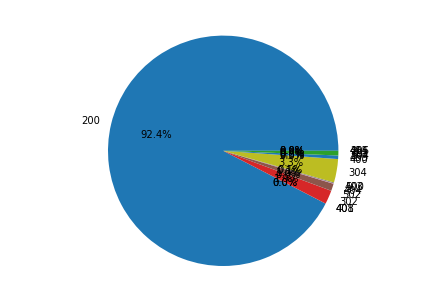

In [35]:
#(b)
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(code_counts, labels = codes,autopct='%1.1f%%')
plt.show()

In [36]:
#(c) and (d)
print("Frequent Hosts:")
print("host count")
host_count = final_df.groupBy('Host').count().alias('count')
temp = host_count.collect()
unique_hosts = len(temp)
for i in range(unique_hosts):
    print(temp[i]['Host'],temp[i]['count'])
print("Unique hosts:")
print(unique_hosts)

Frequent Hosts:
host count


54.36.148.102 170
54.36.148.213 160
5.122.95.74 7
79.127.13.131 3
5.126.156.206 2
116.202.28.181 2
5.127.55.169 101
188.208.75.72 1
5.115.98.126 2
5.213.122.151 1
5.126.91.7 1
5.214.64.42 69
172.80.216.247 1
138.68.87.131 160
40.77.188.18 11
5.218.173.249 14
37.254.132.44 2
5.210.70.227 1
188.214.99.150 1
5.208.70.158 2
5.123.15.197 42
5.124.236.97 6
87.107.188.192 3
2.190.227.189 134
151.235.9.49 55
5.119.88.8 360
5.232.152.222 99
89.235.85.135 2
89.196.111.80 11
5.239.241.237 2
95.38.224.230 296
40.77.194.162 1
185.126.1.130 3
5.63.15.254 788
92.114.26.95 630
5.120.119.105 2
5.202.178.250 76
195.181.168.72 1
188.229.34.202 4
94.24.101.136 1
89.199.65.179 4
91.185.156.146 2
172.80.220.241 2
204.18.96.69 1
31.59.249.242 180
2.191.144.18 1
5.218.22.113 3
159.89.1.24 1
91.251.40.157 2
5.212.139.147 1
204.18.240.202 3
104.173.6.32 40
5.52.99.254 66
37.27.12.61 62
2.176.140.168 82
83.122.117.3 25
5.114.29.187 1
40.77.195.10 3
5.209.40.55 2
5.217.191.165 4
54.36.149.38 153
54.36.149.98 175


104.248.81.122 17
5.122.68.69 85
2.190.165.231 2
5.124.12.3 6
2.191.37.74 5
86.55.129.175 14
83.121.49.123 1
5.212.55.234 48
31.56.204.19 36
5.119.41.250 25
2.178.96.200 102
40.77.190.73 12
40.77.189.159 14
62.138.3.157 132
104.194.25.13 1
2.176.90.143 2
5.115.143.241 26
91.98.150.56 344
5.106.129.143 10
91.251.24.163 52
5.113.202.223 60
5.215.148.176 2
185.195.72.1 900
5.127.70.135 1
5.125.71.51 16
85.133.176.217 182
83.123.40.41 24
5.214.85.83 1
217.219.79.131 1
46.224.151.71 70
5.120.138.232 3
78.39.217.167 722
83.123.198.146 11
192.15.83.109 20
89.34.50.203 505
185.171.54.242 62
5.218.205.231 3
178.128.171.60 9
69.194.90.214 20
51.38.65.114 83
37.255.171.179 119
54.36.149.102 168
5.127.227.69 1
5.119.150.208 1
192.15.185.192 1
5.214.241.88 2
5.106.46.238 1
5.216.121.100 20
2.177.229.176 4
74.82.17.74 5
83.122.252.174 2
151.233.172.151 1
5.214.224.214 1
217.60.172.107 1
5.209.143.26 5
81.90.144.56 2835
194.225.167.82 17
89.196.145.105 29
5.209.12.71 40
5.123.210.210 1
2.180.131.14 1

2.176.110.198 146
5.127.92.118 1
2.178.26.118 3
109.162.249.90 1
79.127.69.73 6
91.251.176.54 6
46.224.73.121 1
216.151.180.197 8
5.216.51.217 2
5.201.146.109 3
84.241.9.141 50
84.241.26.222 2
87.107.234.149 57
5.237.78.50 1
5.208.38.10 13
194.225.106.35 201
86.55.98.233 2
5.214.115.92 1
5.127.7.111 2
5.123.37.89 1
5.120.7.190 1
84.241.2.248 2
151.242.70.48 234
2.191.11.131 2
2.187.186.129 332
167.114.232.133 1
46.209.145.15 385
69.194.67.74 5
95.82.28.56 21
82.99.206.146 1349
109.232.2.1 6
5.209.176.49 17
66.249.81.229 88
54.36.148.188 171
199.58.86.211 40
40.77.194.161 4
91.98.253.201 19
5.114.214.224 1
5.208.170.196 36
83.123.214.110 2
5.124.250.159 3
5.119.4.67 15
5.113.41.80 1
5.208.40.176 9
5.126.68.123 17
5.218.192.239 1
5.117.6.90 2
104.37.31.64 3
113.203.107.212 1
5.216.162.43 31
37.254.239.233 1
83.120.156.245 34
89.40.111.19 74
158.58.6.63 1
5.226.55.226 387
86.55.237.82 88
83.120.122.164 1
80.191.27.26 399
5.219.184.111 22
188.208.210.183 62
2.183.109.99 18
5.134.179.250 3


5.120.204.241 2
178.238.206.125 4
66.249.75.207 6
5.198.175.199 147
78.38.31.238 1
89.198.220.51 1
5.127.253.34 1
185.124.112.226 461
40.77.194.145 2
5.126.5.156 21
40.77.194.196 3
83.122.96.49 13
5.211.23.208 9
5.72.145.186 1
5.114.2.162 40
5.127.141.54 33
5.134.153.54 2
77.237.177.13 1
5.219.23.24 1
37.129.87.69 2
5.208.52.240 1
5.115.236.74 2
46.248.57.55 5
80.191.240.26 243
5.114.204.110 2
31.2.170.200 2
5.114.182.162 1
5.121.9.157 1
2.177.123.20 171
5.126.0.109 16
5.214.26.60 16
91.251.102.198 1
46.209.223.212 4
45.33.84.7 1
5.217.72.214 1
5.114.92.114 166
178.252.149.234 828
5.114.152.215 4
80.191.255.94 54
5.213.176.198 22
172.104.129.34 42
51.38.114.13 2
5.122.102.103 1
86.55.202.233 16
46.100.229.6 17
209.97.184.148 2
5.113.154.26 5
94.101.141.71 356
5.234.192.39 1
5.125.220.204 5
104.248.154.124 1
84.241.59.242 113
5.120.30.230 1
37.255.98.85 6
95.80.131.9 214
5.124.57.209 99
46.32.7.230 866
94.183.175.149 83
204.18.45.59 20
94.183.61.93 216
83.122.8.253 1
5.239.42.25 17
83.1

5.226.55.91 2355
5.126.118.179 45
31.56.206.177 1
37.129.31.201 1
185.113.58.158 314
178.252.129.246 1
89.196.251.164 6
194.225.194.237 133
5.114.243.249 2
188.158.161.172 64
104.248.43.58 221
5.234.130.129 2
5.217.162.166 73
5.117.174.11 1
5.216.223.38 37
151.239.191.76 308
94.74.175.147 666
10.104.208.32 96
5.123.58.219 1
2.176.157.249 62
5.127.81.213 2
86.55.166.113 16
78.157.53.104 1
80.210.180.240 113
31.58.172.202 35
5.216.59.151 3
185.147.40.233 1
5.119.121.109 1
5.106.63.200 1
151.235.226.91 4
94.183.131.170 198
128.199.224.17 4
5.122.76.25 16
5.120.239.190 33
172.80.251.250 35
5.122.224.24 1
5.112.250.38 1
5.127.112.78 1
5.112.90.25 19
188.136.199.210 689
194.225.57.45 82
5.219.107.247 136
5.218.28.211 2
5.121.162.115 8
194.225.185.45 21
5.115.34.157 3
188.253.126.26 45
5.124.245.47 1
37.129.220.119 1
91.251.10.136 1
178.131.243.192 1
176.12.69.62 98
178.238.196.59 21
80.191.8.216 44
5.216.250.115 2
5.122.81.219 1
83.123.109.221 14
89.144.137.213 42
128.204.0.48 1
5.218.202.20

204.18.122.105 1
5.121.13.183 1
5.217.190.7 13
5.115.234.151 2
85.185.118.175 1
204.11.50.131 4
91.108.147.209 727
185.142.235.233 667
91.251.214.13 1
83.123.58.163 20
213.32.47.233 50
206.189.25.39 5
5.127.251.73 10
2.190.165.79 1
46.62.136.206 92
95.38.147.204 114
5.114.191.241 1
66.79.100.9 1
151.243.100.62 17
37.98.115.133 480
89.40.91.142 1
91.108.211.149 71
83.122.235.190 11
91.98.32.198 147
46.62.190.185 1
5.52.71.134 10
89.47.145.159 3
151.232.237.175 11
5.116.158.248 1
37.254.0.202 239
5.115.95.88 32
5.52.82.37 1
5.122.157.238 76
5.121.209.169 1
5.127.194.138 21
2.181.213.183 72
91.185.138.246 7
5.126.120.36 1
5.124.222.33 11
77.238.114.121 15
158.58.60.99 1
89.199.54.143 1
5.126.56.198 3
5.125.111.27 25
5.122.235.159 242
5.121.224.16 30
37.129.159.64 1
31.57.94.171 106
37.129.222.224 1
195.181.0.180 1
5.135.137.88 94
37.202.162.149 33
5.233.64.85 13
5.239.7.167 1
5.208.211.51 1
91.98.129.240 66
46.248.54.91 3
5.116.11.253 2
5.232.197.121 40
5.218.107.169 1
91.98.46.120 1
5.12

2.180.166.112 1
2.182.228.154 253
45.55.223.31 97
208.80.194.32 10
83.120.56.29 1
5.123.201.208 44
5.119.4.85 1
188.158.123.152 1
37.27.241.207 1
40.77.188.115 66
5.209.157.162 53
188.245.54.57 17
185.3.212.154 3
93.110.111.177 24
5.119.18.64 38
89.196.6.147 9
5.124.46.140 1
204.18.228.57 10
2.185.140.163 3
185.129.233.63 411
113.203.26.61 49
46.248.36.189 1
5.113.215.167 78
2.183.145.146 2
151.239.46.250 3
104.222.32.72 1460
80.210.200.127 7
83.122.154.236 2
83.123.213.90 1
2.147.63.250 4
2.191.231.11 44
194.225.167.182 1
91.98.186.189 22
31.57.72.74 1
46.51.46.65 1
103.216.160.144 73
89.165.43.128 1
5.232.125.252 2
89.144.131.210 383
188.34.22.66 446
5.215.21.216 1
31.2.151.66 52
89.196.248.209 1
5.122.19.215 20
5.120.72.195 3
46.51.56.230 17
5.117.142.37 1
188.75.81.196 337
5.120.159.197 1
79.127.79.202 1
109.162.240.81 2
2.176.136.13 3
51.38.64.89 2
5.62.216.174 1
5.116.64.154 34
89.165.42.112 263
91.251.91.36 3
89.219.112.22 1
2.187.27.215 2
5.237.10.37 27
5.114.232.227 40
86.55.7

37.137.165.38 1
151.235.107.165 2
83.120.58.68 7
151.238.217.67 71
5.106.230.94 106
5.73.165.227 1
188.213.109.53 20
151.233.232.121 13
174.138.7.225 130
83.122.147.71 2
83.122.46.65 1
91.251.171.84 2
5.121.106.71 389
204.18.75.108 1
5.123.22.128 198
178.238.193.101 62
151.239.183.42 580
5.216.41.185 1
5.116.109.71 50
84.47.232.110 57
195.206.107.74 44
37.129.209.95 3
2.182.245.65 16
5.115.32.21 3
5.106.235.26 12
162.223.91.58 124
37.148.94.117 1
85.133.216.56 4
95.82.32.200 1
5.116.23.158 1
113.203.19.223 43
5.124.3.107 36
5.126.19.40 12
37.129.142.61 3
5.113.65.89 197
89.196.224.102 13
151.239.160.98 64
46.225.115.111 74
79.127.88.241 40
5.123.189.215 3
5.73.222.218 1
62.193.9.234 124
151.242.172.249 1
5.212.111.23 1
5.121.19.103 7
95.64.95.188 1
37.254.88.22 126
5.122.221.192 6
151.238.165.166 1
188.209.3.49 1
5.106.59.187 55
89.219.120.72 1
184.154.30.5 121
104.194.25.177 177
46.224.151.213 1
83.120.56.202 2
5.127.102.194 15
109.230.101.18 10
5.121.74.11 2
188.213.122.166 59
40.77.

2.190.228.123 1
5.114.65.178 1
5.120.69.68 1
5.112.73.4 1
151.242.175.84 1
5.209.91.20 32
46.248.53.58 81
37.129.184.114 1
5.235.246.244 19
5.121.94.3 1
5.126.154.238 50
142.93.196.41 69
5.237.82.231 21
5.211.162.88 1
5.126.185.83 1
5.211.83.249 1
83.121.67.243 99
95.64.3.85 1
151.235.10.65 57
5.116.230.53 2
69.194.77.90 1
192.15.13.149 2
83.121.198.221 2
83.120.194.19 26
5.210.34.5 2
83.122.146.121 1
204.18.42.100 1
185.39.183.55 16
5.126.64.76 1
37.129.239.73 61
46.225.165.219 2
83.122.82.184 17
69.194.83.11 30
87.107.172.184 12
95.85.58.188 55
31.56.64.187 1
79.127.4.168 35
37.148.17.193 1
176.65.160.251 1
151.240.252.232 4
5.120.113.3 6
37.129.176.255 41
5.209.22.59 6
83.122.118.66 1
188.158.93.223 1
93.118.170.68 1
5.212.210.169 4
83.122.216.17 57
5.121.88.19 1
5.125.100.243 37
80.82.67.40 70
5.209.218.103 3
5.121.83.225 1
5.45.207.24 3
5.119.53.174 1
5.119.62.236 1
5.121.149.159 19
2.179.251.140 3
5.211.12.47 3
37.139.27.152 27
5.113.47.245 1
5.126.151.105 1
37.129.172.204 3
5.10

37.255.179.37 3
31.58.166.182 478
2.180.25.169 90
5.202.1.148 14
5.218.172.220 1
83.120.174.84 4
5.113.233.200 1
5.236.35.174 1
192.15.75.196 2
95.82.53.80 49
2.179.137.53 1
5.127.192.47 1
95.80.135.138 4
2.178.21.113 1
151.239.145.213 2
37.137.6.154 6
5.218.86.186 1
5.127.165.4 24
85.204.31.146 1
46.224.95.157 1
5.112.86.127 1
188.208.63.35 4
5.121.43.10 1
93.114.21.74 2
5.216.235.190 27
31.59.213.195 3
5.123.10.99 2
91.92.150.4 2
5.237.155.31 1
5.213.215.148 22
2.180.223.21 205
188.229.88.242 1
5.121.239.81 48
109.125.167.84 64
85.133.214.194 63
5.214.215.63 1
5.122.250.183 18
37.148.61.240 2
5.237.11.231 3
5.216.102.207 10
86.55.57.78 3
89.37.249.189 1
5.72.113.181 37
46.209.163.43 318
207.241.229.70 5
5.123.199.176 1
87.116.176.94 1
91.251.89.180 4
5.209.162.130 23
5.210.138.249 2
5.218.187.19 1
5.72.123.50 38
109.109.42.42 128
5.120.59.241 20
5.135.139.188 63
5.217.135.243 3
64.52.102.103 1
83.122.175.30 8
188.229.19.234 1
37.129.176.142 17
89.41.40.34 1
89.34.57.155 1
5.112.30.20

2.190.167.13 60
113.203.57.221 1
5.127.5.86 1
5.125.15.167 1
83.123.117.139 53
89.199.179.26 1
5.210.148.179 28
37.129.56.192 1
83.122.12.74 15
2.180.154.154 2
5.122.24.149 98
37.44.62.139 153
104.194.25.70 7
192.15.26.101 1
46.224.204.180 1
80.191.20.102 1
5.123.212.15 39
5.126.190.152 6
5.212.243.102 58
83.123.2.186 3
5.239.45.226 2
195.154.122.219 15
5.124.226.53 1
188.229.17.113 17
5.121.9.12 31
146.185.146.147 17
86.55.64.219 1
69.194.108.68 1
5.127.143.198 13
5.116.128.158 1
5.113.206.91 45
82.168.224.190 359
79.127.22.162 12
91.243.166.136 41
83.120.71.95 191
79.127.94.168 141
109.162.245.13 4
109.162.175.210 51
94.24.103.65 1
5.200.116.250 3
5.52.146.200 109
91.134.135.36 1
5.113.219.174 16
89.45.156.227 14
5.114.248.22 1
204.18.254.63 27
89.165.86.66 103
5.122.3.167 28
91.237.255.247 12
5.122.68.179 19
5.117.80.59 1
5.122.176.200 4
188.159.75.181 1
5.219.155.216 96
91.251.37.178 70
91.251.36.0 1
40.77.189.228 11
5.125.208.119 1
5.127.130.73 5
5.121.68.90 2
5.117.251.90 134
5.1

89.47.146.251 2
5.122.227.177 28
5.117.211.19 27
5.127.186.91 24
192.15.119.189 1
40.77.195.18 8
5.120.159.44 31
31.2.186.182 1
188.158.126.172 59
176.65.161.114 1
204.18.50.67 4
69.194.109.8 1
5.233.180.15 1
158.58.48.34 1
5.123.96.36 1
40.77.193.35 3
5.134.154.13 2
5.125.20.146 38
192.15.199.111 8
87.251.151.62 1
185.215.233.222 1
172.80.237.28 1
91.99.106.153 1
31.59.228.149 1
5.112.218.49 73
2.187.234.146 1
5.214.223.23 33
5.212.164.5 1
5.211.116.65 2
89.199.129.225 1
109.125.159.205 40
188.253.69.134 1
5.217.148.104 6
5.73.168.20 1
188.215.178.121 3
95.64.67.126 3
46.225.84.216 11
176.65.174.2 1
5.112.204.128 1
5.127.66.90 1
192.15.52.127 1
5.208.152.18 45
89.35.70.94 36
5.210.168.169 1
37.98.21.199 4
31.57.149.171 32
5.117.238.92 2
5.218.147.188 1
31.2.156.145 1
104.237.226.200 1
89.198.85.223 1
5.113.118.4 1
91.99.50.135 39
178.252.170.234 2
91.98.13.250 1
5.119.58.223 2
5.232.209.23 130
113.203.2.145 23
192.15.48.178 3
5.125.126.216 1
5.216.100.161 2
46.225.217.250 1
5.217.151.

81.28.43.50 151
83.122.188.123 6
5.126.4.58 28
5.123.75.129 1
185.89.114.201 107
5.127.98.238 1
151.239.3.81 205
51.38.65.128 1
37.137.247.232 1
83.121.22.152 1
2.182.70.128 1
185.165.242.117 20
5.219.212.48 2
5.112.210.225 7
5.106.156.123 1
5.121.124.168 1
5.117.252.44 2
5.212.43.144 1
66.249.79.240 3
37.148.117.25 1
176.65.165.50 104
46.51.26.98 17
89.198.250.235 8
5.117.104.181 44
83.123.219.231 1
91.99.245.216 1
5.127.28.169 1
37.137.8.6 76
151.242.65.206 47
5.214.90.44 1
37.129.118.189 1
158.58.25.50 2
185.239.173.79 113
202.69.15.15 2
5.218.2.159 7
5.134.140.163 4
91.251.177.79 44
5.213.219.84 7
46.224.108.224 1
5.119.250.138 22
180.94.82.115 2
31.59.176.225 1
89.235.81.4 67
151.239.110.33 2
95.162.93.82 1
5.209.148.98 29
5.208.127.89 1
5.216.196.29 1
89.235.93.217 1
192.119.167.67 1
40.77.192.128 3
5.126.92.226 1
89.199.255.155 2
5.127.203.150 3
5.114.161.34 2
5.117.94.16 2
2.178.12.85 75
31.59.154.153 1
151.242.101.197 54
2.191.203.116 4
40.77.190.7 9
5.126.68.109 1
151.235.103

91.251.202.156 49
31.7.117.242 11
5.120.25.29 1
5.124.18.61 1
5.210.110.157 256
5.212.164.228 17
151.238.141.212 48
86.55.124.110 1
188.158.234.78 3
5.127.87.228 83
83.121.71.156 3
216.162.47.10 1
37.27.72.123 22
37.129.104.9 2
5.115.83.136 7
5.217.127.175 17
37.254.92.143 3
77.77.100.57 1
89.198.250.96 19
2.178.104.101 19
2.182.25.145 3
188.209.36.207 1
5.210.96.37 1
95.64.23.122 2
5.121.199.138 66
92.114.75.115 1
5.114.232.149 1
89.41.14.236 68
151.234.174.36 2
188.166.171.89 1
5.126.228.198 27
83.123.181.150 35
79.127.92.88 3
92.114.75.67 1
2.147.145.237 1
91.251.1.57 1
192.15.127.26 3
5.113.92.42 30
5.117.167.134 1
80.210.185.252 2
89.45.62.82 119
5.113.96.140 26
83.123.182.206 1
109.110.170.90 2
5.208.57.33 32
5.135.143.181 219
172.113.251.214 1
5.114.5.219 1
185.80.201.215 2
185.86.93.56 34
40.77.188.155 14
86.57.118.152 1
83.122.19.162 2
5.117.64.79 14
5.122.198.0 1
5.114.241.72 1
37.129.242.162 92
37.139.31.40 1
5.219.17.114 88
5.112.24.149 1
5.127.141.201 1
151.243.248.69 214


85.133.249.130 625
91.92.183.107 1
5.112.5.160 1
5.200.208.117 1
31.57.252.112 58
93.118.112.171 150
83.121.220.141 80
10.116.37.144 1
46.51.54.11 1
192.15.204.246 1
194.225.168.182 3
83.123.14.129 3
5.119.156.184 1
46.51.124.207 1
89.165.113.197 55
5.115.14.243 12
5.233.239.98 54
5.121.247.169 57
5.211.106.83 66
94.183.24.127 20
5.216.219.10 11
91.251.32.98 36
5.112.61.63 107
5.209.158.65 1
185.232.21.220 211
40.77.188.85 14
2.187.39.24 22
89.34.47.8 2
5.127.118.129 2
192.119.167.172 1
5.238.20.199 15
2.177.7.33 62
79.127.26.18 214
46.224.127.186 50
213.217.50.190 164
31.58.86.157 2
5.121.114.11 1
5.210.135.112 24
5.120.192.36 1
217.219.65.231 151
5.232.46.145 15
5.119.172.56 1
5.211.135.251 1
91.251.140.15 1
40.77.190.70 20
5.134.172.110 13
5.115.74.86 1
5.113.153.223 30
91.185.150.162 1
37.148.55.237 52
31.170.58.94 41
95.38.52.87 70
173.212.246.178 105
10.75.35.242 1
167.99.255.2 39
51.158.70.25 2
5.208.35.5 1
37.254.38.202 108
91.98.147.164 1
151.232.218.185 421
83.123.134.68 1
5.

84.241.9.37 19
5.217.208.251 1
188.209.25.193 3
5.219.77.171 1
83.123.78.230 1
5.213.254.131 26
5.120.199.28 1
5.215.178.160 1
5.126.153.158 1
5.160.52.75 5
92.43.160.111 37
2.176.138.161 356
5.217.73.241 37
31.59.96.99 1
89.196.213.31 1
5.116.207.68 2
80.210.181.116 1
5.208.138.233 19
207.154.224.51 33
83.123.35.162 76
167.99.134.161 1
83.120.122.231 1
5.238.76.210 1
151.233.17.101 1
5.121.64.125 17
151.242.78.107 3
5.112.166.185 31
5.212.119.203 27
5.122.56.23 1
5.112.188.189 3
46.209.251.195 1
188.158.216.158 3
83.122.19.68 26
204.18.146.171 48
5.160.71.218 702
5.114.182.186 141
31.2.217.222 68
5.218.163.195 446
116.66.184.178 1
5.216.150.183 35
5.113.16.146 12
84.241.26.26 6
83.122.177.202 2
5.217.220.95 1
192.15.80.88 48
89.198.106.215 10
37.98.10.175 167
5.122.110.253 36
188.214.96.252 51
188.229.22.21 1
5.190.192.185 30
83.123.146.10 102
37.148.48.190 1
5.116.34.44 1
185.120.212.119 14
5.112.151.79 27
89.196.146.59 1
188.208.214.67 1
93.126.5.20 1
5.114.133.178 23
54.36.113.52 1

2.180.57.106 4
89.196.97.124 1
91.99.164.25 2
213.207.237.11 138
86.55.200.173 2
5.160.5.162 2
5.120.84.217 6
83.123.36.240 1
5.127.33.134 8
83.121.67.26 1
5.210.245.152 4
5.198.189.80 3
5.215.233.144 1
31.59.181.44 30
5.106.48.178 1
5.104.210.230 1
5.114.234.137 1
5.121.251.74 1
5.217.1.32 1
5.211.141.162 1
83.122.158.22 20
31.58.242.235 1
46.51.47.31 17
89.36.16.68 1
5.121.21.22 368
188.159.208.222 5
5.123.176.20 1
5.120.20.51 6
5.115.126.9 5
5.127.218.115 11
89.34.43.12 31
5.122.162.174 1
31.56.201.168 1
83.122.126.160 24
83.120.90.205 42
5.226.139.107 32
199.195.250.77 11
178.131.68.245 68
2.180.135.216 1
5.124.201.151 2
69.194.122.176 1
5.122.167.185 1
185.131.131.191 84
172.80.226.129 1
83.120.72.60 1
83.123.167.168 11
5.119.193.43 1
87.107.200.47 4
5.218.177.106 3
80.250.199.201 1
5.113.95.243 1
95.81.91.185 16
5.208.176.107 2
151.234.121.85 1
2.182.32.164 1
5.116.103.198 3
95.64.105.89 3
37.255.167.235 1
5.116.16.96 85
79.127.80.132 1
95.151.27.187 1
83.123.120.233 33
188.211.5

5.124.177.231 2
5.125.23.131 1
173.249.21.206 204
5.119.77.58 1
5.124.114.86 1
37.129.224.144 1
5.62.203.17 36
95.80.181.218 1
5.121.156.148 36
2.181.240.133 1
188.208.78.152 1
83.123.138.65 22
5.218.222.161 1
46.248.41.194 56
5.232.12.15 2
5.112.44.198 37
31.58.63.195 1
5.208.88.91 1
176.65.168.46 11
46.224.162.209 34
5.119.67.255 1
2.187.20.145 1
86.55.209.218 1
5.202.6.55 83
185.129.126.235 1
31.56.192.230 38
46.51.54.208 3
5.114.71.157 1
2.186.15.215 18
151.234.212.11 1
5.106.38.249 46
89.248.162.130 97
5.218.80.57 1
188.215.128.255 2
45.56.194.178 2
37.137.224.204 1
5.123.193.115 118
5.239.108.134 89
216.155.147.72 5
83.123.225.50 23
5.120.11.31 1
83.123.45.190 1
46.248.59.154 11
188.211.96.211 1
5.233.53.146 1
5.209.231.164 2
87.123.205.37 1
37.156.53.156 1
83.123.159.60 1
5.218.252.11 112
5.117.236.80 12
92.242.197.38 8
83.122.74.119 63
5.117.48.185 1
5.209.214.83 27
86.55.165.174 5
2.179.145.145 31
54.38.79.28 2
89.235.121.2 1
12.216.232.91 14
77.237.176.197 73
5.114.219.247 2


5.115.167.189 83
31.59.35.50 2
2.184.80.130 2
83.122.99.103 1
5.74.221.61 40
37.255.70.147 1
137.74.29.47 2
190.2.153.77 18
2.182.37.249 1
5.218.212.238 3
5.160.116.155 2
5.112.197.172 1
2.176.228.248 4
204.18.2.12 36
5.115.46.200 21
37.137.34.7 21
2.179.122.213 32
31.59.248.144 1
5.214.48.7 1
5.116.105.88 1
83.122.8.133 1
83.123.138.36 1
5.127.172.231 1
178.238.198.78 3
5.213.98.52 86
185.111.15.140 1
158.58.1.253 2
2.190.121.53 1
83.120.240.9 1
2.186.83.15 107
2.182.112.188 1
5.125.219.16 1
5.216.185.179 27
5.125.160.6 1
188.215.175.20 46
5.113.164.52 4
40.77.193.158 2
2.180.93.136 2
2.182.125.148 1
5.123.178.146 31
5.114.193.170 42
5.122.113.151 1
192.15.173.207 3
5.113.90.62 36
37.129.45.187 238
5.212.134.145 3
204.18.254.97 42
5.113.108.255 23
5.202.216.170 3
5.126.106.233 1
104.194.24.178 4
89.219.115.116 117
178.131.113.166 1
118.163.201.4 14
5.127.50.78 19
104.248.90.2 1
5.211.6.102 61
5.134.180.192 2
5.218.115.132 1
89.199.90.197 30
151.239.24.5 14
5.208.121.109 1
94.183.23.10

5.218.22.197 1
188.166.82.72 1
192.15.51.93 2
83.121.88.128 1
5.119.41.68 27
79.127.76.187 20
188.166.153.250 23
5.232.70.204 13
85.204.86.200 132
5.112.97.26 11
5.106.86.189 11
5.125.188.216 1
5.78.74.88 80
95.64.116.125 51
5.122.21.123 2
31.2.210.160 7
5.112.14.236 1
5.123.120.66 1
51.38.82.49 16
5.219.37.233 1
66.79.127.145 1
8.37.231.16 6
188.229.35.6 69
5.112.242.60 1
5.116.106.180 1
5.217.40.203 1
5.202.9.223 1
195.181.169.184 28
5.126.150.2 1
5.212.72.62 15
172.80.231.132 1
5.125.164.65 25
83.120.88.104 1
5.116.15.98 2
2.179.114.132 2
152.44.37.90 13
31.59.251.157 46
2.185.133.176 1
77.81.192.250 5
5.106.214.50 1
83.122.96.213 6
5.73.198.153 3
81.28.50.219 254
31.58.165.13 2
188.208.70.113 3
5.233.144.225 1
37.129.48.109 61
192.15.81.191 28
5.127.149.15 1
5.236.185.162 1
5.112.82.166 1
89.199.94.222 1
83.120.227.147 1
5.123.50.220 25
83.122.69.220 72
139.59.152.38 29
31.57.240.7 72
5.218.42.196 1
192.15.41.59 21
46.34.170.57 1
5.209.191.80 1
79.127.64.82 93
151.239.194.4 76
2.18

5.116.169.236 1
64.207.208.145 30
192.15.200.41 1
5.112.65.79 2
46.100.124.20 2
158.58.60.173 5
31.56.66.142 106
2.180.193.185 15
5.112.237.31 55
192.15.87.126 1
151.234.4.88 1
83.120.15.26 1
204.18.33.113 34
172.80.221.126 43
83.123.164.112 66
5.112.73.117 1
86.55.158.135 1
5.215.10.20 1
5.106.213.110 211
2.184.97.178 41
91.251.127.100 1
95.64.101.236 1
5.119.197.141 5
89.34.254.236 56
5.123.164.59 1
2.176.240.67 1
5.116.226.21 1
5.201.210.155 176
5.113.16.45 48
5.210.97.135 5
89.196.21.42 1
5.127.181.167 46
37.254.238.110 2
5.122.238.201 1
113.203.25.224 79
91.99.71.207 1
83.121.196.212 1
5.116.176.133 271
151.239.122.139 1
83.121.70.193 1
86.55.232.238 1
204.18.126.60 79
151.242.53.143 1
89.235.123.12 89
46.225.39.49 83
5.115.225.225 1
5.117.210.180 1
95.162.119.25 1
2.187.121.105 51
5.117.162.228 2
151.235.136.198 2
188.158.155.106 2
5.212.246.118 130
2.191.0.36 1
89.196.11.238 1
2.190.164.218 1
192.15.233.110 163
37.255.113.22 3
2.183.252.197 1
89.235.86.81 96
89.36.252.127 25
5.1

151.238.211.16 127
89.219.107.45 1
2.185.45.142 29
194.225.92.207 7
157.230.23.115 43
172.80.192.236 1
89.32.103.173 20
188.212.86.18 1
31.57.90.213 1
5.115.183.166 1
5.209.66.31 40
93.115.221.149 38
5.114.235.54 104
95.64.125.88 4
95.38.18.46 5
89.219.127.16 1
80.191.19.250 1
5.238.239.173 1
31.56.8.187 2
5.218.177.178 1
5.217.210.147 3
62.138.2.169 57
5.73.29.102 30
86.229.20.79 1
207.46.13.15 2
46.167.152.123 38
5.122.116.163 4
180.94.84.205 2
178.238.198.89 3
5.112.119.134 7
37.129.247.138 1
5.119.206.136 2
83.121.169.72 2
5.126.188.33 20
151.238.62.193 1
46.224.52.127 3
2.176.245.179 3
5.125.127.9 53
5.119.107.2 1
5.113.7.167 1
2.191.152.199 1
83.123.119.135 56
31.7.121.143 3
5.124.69.130 34
5.210.197.17 1
5.213.193.99 1
5.124.33.186 79
5.208.155.157 32
5.113.213.24 1
204.18.125.37 23
2.191.255.38 60
176.65.190.96 1
31.56.80.128 5
89.34.33.245 13
77.88.11.200 1
109.162.254.152 1
91.98.239.42 1
91.99.70.78 1
5.126.109.66 90
5.216.7.36 2
2.187.155.165 73
192.15.46.157 1
37.137.253.1

159.20.107.155 32
5.127.234.111 1
151.243.244.2 21
94.176.59.183 1
86.55.4.104 39
5.112.69.101 35
5.117.121.68 1
83.120.70.226 14
5.113.42.104 40
188.253.90.212 1
188.215.200.214 1
31.59.153.9 76
192.15.191.60 1
83.122.162.51 2
46.34.180.180 1
37.156.127.105 1
162.210.196.100 26
5.113.59.36 55
5.200.123.241 1
5.213.100.121 2
5.126.9.88 1
83.122.227.35 1
5.114.241.160 3
5.78.250.254 22
5.124.45.6 23
172.80.203.17 29
217.69.143.71 1
51.39.1.0 3
37.129.210.40 1
5.126.41.14 1
5.122.237.5 1
5.119.24.106 23
5.237.72.228 3
151.243.29.174 10
5.125.131.113 1
2.181.98.0 112
89.32.102.136 36
91.184.84.121 53
5.127.118.5 1
79.127.67.211 4
158.58.3.159 1
188.208.62.95 1
2.176.176.138 123
5.202.208.249 267
5.211.99.243 1
5.126.24.173 34
51.38.124.162 3
5.112.89.57 1
89.32.14.186 1
5.216.157.224 5
5.209.79.0 1
86.55.126.17 41
89.199.203.108 1
173.230.131.249 257
5.214.129.132 48
5.124.47.100 1
5.112.99.8 54
5.238.203.188 2
5.216.180.23 1
151.235.214.64 12
83.123.80.195 1
31.57.160.252 87
151.235.81.1

5.214.189.120 13
5.119.51.33 2
66.111.55.18 1
178.238.196.210 4
5.113.231.243 5
89.219.89.129 2
79.127.4.179 91
5.113.33.170 2
5.200.90.79 81
46.248.35.113 1
5.126.163.107 2
95.64.72.144 1
185.124.112.161 809
5.217.80.130 4
152.44.33.144 114
5.52.192.95 137
91.98.87.131 102
5.123.214.245 49
79.127.12.202 1
83.121.118.98 1
5.126.92.68 1
83.123.139.41 23
5.127.138.205 1
5.121.69.24 1
5.122.181.18 2
165.225.76.212 1
83.123.45.226 3
94.176.23.197 1
188.158.38.148 1
95.64.19.67 1
89.32.106.170 1
113.203.40.162 1
89.32.27.85 1
151.238.226.180 5
109.162.255.180 171
5.117.150.41 1
5.122.168.37 1
89.196.250.106 2
88.231.30.150 4
172.80.215.207 1
5.126.138.188 1
5.119.208.78 1
37.148.83.202 2
5.125.68.36 5
217.24.158.42 12
50.116.6.185 2
5.116.240.8 13
5.217.141.48 4
5.122.214.107 1
31.57.246.253 138
188.215.241.51 1
37.98.14.85 401
5.124.108.7 1
37.148.127.142 2
192.241.215.153 4
176.65.162.97 116
37.254.161.23 1
5.122.150.247 47
66.79.100.232 1
93.126.28.103 22
46.225.5.172 30
5.122.95.227 5
5

5.117.138.204 1
83.122.48.238 1
5.218.52.231 1
5.202.232.22 1
66.79.97.205 1
77.42.25.39 222
69.194.80.189 1
89.235.90.98 1
185.120.243.243 1
5.208.172.66 3
176.65.160.199 14
95.64.63.162 35
78.38.172.152 4
5.235.4.124 38
91.92.206.254 98
5.218.137.237 1
31.56.216.234 3
83.122.36.151 5
2.179.125.125 1
5.126.99.218 8
2.183.47.29 25
89.199.159.213 1
5.120.63.59 1
2.186.167.234 27
5.215.198.212 1
5.214.146.254 54
69.16.147.254 22
37.129.140.209 109
5.119.46.25 1
5.116.54.22 1
5.119.38.189 2
77.42.47.14 1
2.179.161.25 7
185.245.84.151 161
35.157.139.207 1
151.232.185.201 1
5.134.188.205 1
83.122.29.128 1
109.162.234.252 2
83.121.234.9 10
40.77.194.84 2
5.238.217.202 1
5.213.125.102 47
5.122.26.111 1
185.195.16.71 259
2.181.242.176 1
172.80.198.170 1
83.122.41.108 1
5.119.126.222 3
5.214.116.161 1
79.127.76.79 1
188.210.134.100 102
5.120.180.247 4
5.106.82.79 1
5.113.111.191 3
83.120.247.81 1
5.123.152.21 14
5.127.199.47 19
81.16.115.32 1
2.180.254.136 111
113.203.22.108 2
152.44.37.99 2
5.

37.32.5.101 1
51.75.90.143 1
5.232.26.149 1
2.181.116.37 52
2.178.137.230 2
5.113.74.36 1
46.51.33.137 2
37.148.32.155 36
5.214.107.99 1
83.122.141.177 10
5.233.131.25 1
5.115.119.234 35
83.121.24.133 11
204.18.129.176 1
89.196.76.244 59
204.18.140.64 4
91.251.52.236 15
151.239.90.6 1
5.127.60.128 2
176.12.74.17 1
89.199.214.80 13
94.176.59.200 1
91.251.5.216 11
5.214.215.68 1
89.199.119.47 1
185.205.204.58 1
91.251.28.179 1
151.234.6.60 165
5.213.81.204 1
83.120.38.236 1
91.243.167.187 2
2.179.110.186 97
5.112.215.245 90
89.199.196.161 29
83.120.71.249 135
5.62.185.150 82
2.184.188.107 185
192.15.40.29 9
37.137.59.35 1
151.233.1.163 97
5.115.252.103 2
109.230.204.241 289
5.239.86.186 17
5.117.190.191 2
5.233.240.179 1
5.212.197.207 78
5.218.45.150 88
2.190.158.63 1
204.18.218.225 43
2.176.27.135 32
5.116.36.243 134
5.119.170.206 27
2.186.82.24 22
5.200.108.208 1
5.121.98.245 1
89.199.78.208 1
5.126.99.190 1
204.18.237.166 91
5.210.117.252 45
5.114.21.120 23
5.212.17.29 1
5.215.231.110

5.218.169.209 6
89.196.204.204 28
188.209.4.167 1
5.125.175.161 1
91.251.151.131 1
5.120.168.1 40
31.58.255.158 58
185.112.130.121 2
31.2.147.69 47
5.215.245.251 1
2.186.25.114 1
91.251.195.214 157
5.113.75.50 1
5.115.158.98 33
86.55.116.41 4
195.181.2.162 1
151.238.180.45 5
5.208.110.56 1
37.129.152.42 107
5.52.204.101 4
5.210.20.111 1
83.123.82.116 1
5.117.151.247 1
5.114.198.116 1
83.120.199.219 70
2.186.106.178 1
5.120.92.152 36
5.239.81.198 1
5.73.97.59 1
5.208.204.195 4
83.123.92.143 1
91.98.246.142 1
5.208.230.141 1
5.124.186.39 1
213.207.238.111 1
192.15.105.67 1
2.187.29.55 34
2.176.189.88 458
109.162.230.86 52
109.162.199.211 5
5.210.108.249 19
83.123.99.185 20
86.104.247.193 2
5.121.71.120 1
104.194.24.48 44
5.123.143.147 4
2.182.91.43 63
5.212.75.165 2
31.56.89.229 49
151.234.153.86 13
2.176.216.96 137
5.113.36.126 1
5.211.80.28 2
5.234.66.112 1
5.211.128.206 62
213.207.243.120 78
86.55.105.246 2
31.2.138.128 1
37.27.168.117 1
217.24.148.188 101
5.211.1.95 2
37.129.102.117 

83.120.58.110 45
216.185.45.183 78
31.58.235.85 400
5.215.139.108 3
2.187.125.113 2
31.59.220.84 69
5.113.62.51 1
5.126.63.115 4
37.254.38.142 1
5.52.254.126 1
46.224.105.3 1
85.133.224.207 1
5.209.121.161 45
5.117.40.127 13
5.218.251.154 2
95.81.85.88 2
5.115.32.137 1
89.198.180.63 1
37.129.164.189 1
5.208.99.192 11
5.117.64.168 47
2.183.108.19 55
69.194.118.242 1
138.68.82.116 2
2.187.177.81 1
5.134.134.141 4
46.51.43.97 22
5.117.142.204 1
5.121.156.13 1
151.239.150.184 2
31.2.227.202 1
192.119.160.86 1
83.122.216.71 62
37.191.73.26 41
5.123.102.248 1
5.119.249.231 37
83.123.247.219 5
185.120.250.172 125
5.209.245.207 32
5.232.47.142 33
151.243.225.190 44
177.159.243.254 4
5.126.6.66 287
83.121.141.92 1
5.214.217.239 15
103.90.206.83 1
5.121.195.223 1
46.225.204.180 1
83.122.112.2 1
5.52.163.74 15
89.199.198.50 2
31.2.243.243 2
37.255.253.134 1
5.106.155.242 2
5.123.211.88 1
5.125.184.66 2
2.180.92.204 171
192.15.13.125 7
188.245.8.216 2
95.64.123.65 1
113.203.49.182 11
2.185.127.111

5.124.100.70 1
5.213.202.48 16
5.212.21.84 1
2.186.106.193 1
5.123.197.152 23
5.113.40.1 4
37.148.91.16 19
5.116.185.72 1
188.208.61.221 19
2.178.195.216 1
83.120.79.7 1
188.215.137.107 46
37.137.103.183 12
5.112.220.115 2
188.210.138.133 165
5.116.133.68 14
151.241.236.100 21
79.127.77.149 1
88.135.44.17 3
5.119.62.106 1
37.27.173.198 2
5.115.211.183 1
37.153.178.219 37
37.255.106.64 1
5.125.64.88 168
5.112.196.238 1
5.126.85.227 1
188.34.124.215 2
46.248.51.156 2
178.238.193.8 37
89.199.176.198 1
5.123.53.179 1
46.51.115.46 15
5.208.30.173 2
204.18.92.163 1
86.55.193.247 57
5.125.121.220 1
151.234.81.183 1
5.116.83.157 1
89.196.29.137 1
5.116.149.180 36
5.217.177.81 30
5.214.178.22 1
5.116.181.64 2
5.211.188.55 3
5.123.33.242 3
5.125.181.228 2
5.125.133.156 94
5.215.65.199 1
5.116.229.243 2
83.121.38.18 4
5.124.35.47 5
31.56.76.251 1
5.117.24.196 56
151.238.244.146 2
37.254.33.125 1
185.246.7.157 36
5.117.212.14 1
204.18.81.163 1
5.119.196.247 11
37.139.16.197 46
89.41.192.13 1
217.2

151.239.74.69 3
31.2.158.167 30
5.123.146.32 11
5.120.90.204 174
5.211.28.132 25
94.24.89.207 1
5.120.230.16 10
5.117.157.61 3
83.123.2.148 2
5.126.60.211 71
5.127.143.206 15
5.117.145.40 1
5.127.214.152 1
91.227.85.24 18
5.78.54.26 27
5.236.163.99 78
192.119.164.192 60
5.116.55.160 8
188.159.42.210 2
31.56.106.135 75
188.34.82.51 36
5.62.210.1 42
5.112.227.128 34
5.113.14.197 1
83.120.94.77 1
152.44.33.164 1
185.180.221.37 1
83.122.129.59 42
5.122.249.19 1
46.51.15.211 2
31.2.231.153 21
5.114.5.231 1
46.167.156.197 15
5.117.94.35 95
5.211.135.129 32
89.41.194.228 4
31.57.157.91 18
5.215.242.213 1
134.147.24.172 132
5.125.160.159 1
109.125.188.198 2
83.122.215.151 1
204.18.94.187 1
5.122.130.7 1
37.137.5.90 1
5.114.112.39 1
5.126.242.192 1
89.199.150.239 9
109.228.46.124 1
188.215.199.187 51
217.24.145.244 19
5.123.145.215 1
94.24.83.176 1
89.47.70.189 15
5.235.124.55 1
5.212.56.171 33
5.119.91.28 3
5.126.23.25 14
5.126.189.56 1
5.115.113.188 104
5.119.89.103 1
188.159.166.85 1
5.120.8

2.181.183.28 1
77.81.33.172 47
31.2.249.113 3
83.121.5.17 8
5.201.200.64 1
113.203.59.180 8
5.124.129.8 1
89.32.103.156 1
91.251.224.57 2
5.213.18.169 71
37.202.252.80 4
46.51.66.254 1
91.251.21.11 4
5.216.215.251 27
185.89.217.245 9
83.120.52.54 20
5.124.232.161 61
5.119.59.143 49
109.125.147.174 17
5.123.24.21 2
104.36.19.96 1
158.58.94.119 28
5.134.155.239 4
5.62.232.158 1
69.16.147.153 80
2.179.113.60 1
5.200.108.30 1
2.178.114.226 1
51.38.125.228 99
151.233.142.72 2
158.58.115.16 2
5.235.148.71 4
89.34.57.1 82
83.121.29.89 23
5.124.87.184 51
5.124.25.179 1
2.190.189.218 6
83.123.57.215 3
86.55.203.60 1
5.211.181.207 14
158.58.35.4 38
95.64.73.78 1
5.78.69.219 1
5.211.189.64 88
5.123.57.37 2
5.116.171.145 1
95.64.96.16 3
37.129.214.78 37
176.65.170.80 1
5.212.11.157 116
151.235.107.145 3
5.126.167.139 17
5.116.62.95 1
5.217.147.159 1
5.112.105.16 15
5.121.15.230 15
5.117.152.240 1
83.121.85.213 27
83.121.90.161 1
5.112.237.156 1
88.135.40.52 1
31.56.104.221 1
162.243.82.178 2
89.19

5.209.79.252 42
91.98.77.22 3
5.123.75.39 318
91.222.206.234 25
5.122.186.114 2
151.239.142.222 33
89.46.191.98 3
5.218.9.191 23
188.159.240.247 6
5.113.51.236 1
31.2.152.85 1
5.218.30.204 1
5.115.90.218 4
178.128.193.136 16
5.75.2.38 18
31.58.202.130 34
2.177.194.126 1
159.89.111.34 2
5.113.251.46 2
80.250.202.34 1
5.212.35.70 16
5.198.160.218 3
5.114.29.5 1
5.127.48.110 1
5.215.121.190 3
2.190.165.164 2
5.114.40.108 1
173.249.54.82 46
5.119.152.63 2
37.129.224.130 1
188.229.48.242 4
86.55.211.77 1
5.238.72.188 1
5.106.75.33 2
91.251.184.95 1
185.217.69.98 2
86.55.38.196 2
95.162.162.201 8
5.218.112.71 1
5.215.132.236 1
188.229.4.225 2
37.137.243.225 1
176.65.186.217 77
1.234.99.77 108
46.62.176.187 20
198.143.155.138 1
5.114.220.64 42
31.56.70.244 2
188.166.109.154 2
92.114.74.19 1
46.225.210.219 2
5.217.39.41 2
213.195.57.123 3
40.77.192.134 3
5.116.15.70 19
5.119.129.248 1
5.114.4.59 1
5.121.64.46 2
5.127.122.38 1
83.123.28.232 38
5.210.222.144 1
5.213.74.19 2
31.59.212.210 2
5.213

5.123.234.248 1
5.218.98.82 1
5.160.188.163 118
5.124.106.111 1
5.121.238.143 1
94.24.103.194 2
5.200.193.101 2
5.117.124.173 1
188.211.105.244 2
5.214.22.173 1
192.15.92.21 1
2.191.55.250 1
5.113.151.26 2
5.72.84.137 222
5.119.35.207 1
5.116.66.40 1
5.126.125.101 4
5.112.226.142 1
5.120.173.17 1
5.124.211.168 2
5.235.44.40 2
5.120.242.164 1
5.119.30.192 1
37.153.189.155 1
37.238.153.22 2
5.127.214.163 1
204.18.243.30 2
5.234.138.13 2
37.129.79.163 57
5.123.220.23 2
83.123.64.190 1
159.89.106.153 98
5.123.94.80 2
5.210.113.9 42
89.199.10.70 1
5.75.40.138 1
178.131.243.149 1
5.209.172.111 2
5.209.50.237 42
185.217.68.253 2
185.89.217.167 3
5.126.214.188 21
5.219.188.100 1
86.55.76.125 1
5.127.64.253 1
31.58.50.89 17
5.114.66.197 22
31.58.243.234 1
79.127.4.202 1
5.115.58.91 10
5.73.82.12 2
158.58.18.29 1
5.115.212.28 2
5.219.41.76 4
188.211.126.172 82
5.123.150.87 2
2.186.254.236 60
178.238.205.223 23
5.113.72.202 1
146.185.154.112 27
5.125.151.101 1
5.126.43.81 154
77.238.116.29 2
5.21

5.218.76.128 29
195.181.116.71 23
5.212.174.116 28
2.190.72.119 35
5.113.23.21 1
95.81.89.244 1
5.209.18.125 1
188.208.95.44 1
5.239.103.55 15
204.18.119.180 1
5.218.59.120 20
5.114.23.252 13
5.216.3.29 1
192.15.156.32 2
46.51.74.237 6
5.216.41.218 5
5.122.222.39 1
188.229.34.38 2
5.121.158.189 34
46.224.54.71 2
5.125.207.93 1
5.126.189.207 7
5.115.90.25 28
31.2.219.252 11
5.115.215.237 4
83.122.125.156 127
79.127.67.114 1
109.70.100.22 55
37.148.79.220 30
80.210.189.99 1
89.198.202.208 1
54.36.117.85 21
5.238.81.216 4
93.115.219.189 171
5.112.224.233 1
5.212.172.47 2
5.112.163.171 65
151.234.45.123 20
37.129.241.236 10
37.255.81.228 1
5.125.210.170 18
5.234.138.31 55
5.106.219.206 1
109.238.188.198 65
5.125.146.141 1
151.239.56.216 1
213.207.243.188 99
5.62.219.253 71
83.121.153.251 37
5.112.139.9 1
89.47.155.227 1
5.116.54.231 1
79.127.64.32 1
5.126.116.247 1
37.255.199.56 11
2.186.77.186 1
5.208.68.27 13
5.234.102.10 44
5.214.74.206 12
37.254.104.72 1
89.199.169.5 115
2.186.28.53 1


5.134.179.61 97
5.126.207.91 22
5.127.137.229 71
80.210.254.208 1
2.186.6.200 179
178.128.194.55 37
5.52.187.165 6
95.162.133.215 2
80.210.144.253 35
5.112.227.38 1
89.198.51.117 30
83.122.61.59 56
5.122.219.95 7
5.122.103.30 1
83.123.249.150 20
5.215.237.195 2
77.42.19.16 139
109.162.144.16 5
46.248.63.172 6
178.238.199.225 5
2.184.66.130 2
151.233.100.198 1
5.218.196.210 5
5.216.228.218 1
89.34.156.178 50
83.122.248.73 1
5.127.166.63 1
83.121.250.135 15
46.248.51.101 443
5.217.245.37 72
83.121.151.24 12
46.41.253.211 1
5.120.142.63 183
113.203.52.190 1
5.208.99.225 5
37.27.53.137 2
83.121.132.135 1
5.198.187.23 168
89.198.190.192 75
5.117.222.10 1
46.224.58.67 1
151.239.143.105 29
5.119.140.45 12
5.123.252.195 10
5.232.3.81 80
188.208.63.208 5
5.78.108.16 128
2.183.94.238 12
91.251.201.198 2
91.251.133.146 9
188.229.0.55 47
5.120.167.122 1
79.127.11.82 1
5.202.27.172 78
5.117.155.185 354
213.226.68.215 63
5.127.253.216 72
5.106.222.8 4
5.217.202.212 1
5.119.181.148 21
46.36.99.86 17


5.114.16.150 42
37.254.235.225 27
89.196.120.49 2
89.196.148.160 1
5.115.239.112 68
5.218.249.63 15
188.159.2.93 1
89.198.65.14 56
5.113.219.101 9
37.148.126.186 1
192.15.144.203 10
5.117.55.104 1
5.211.51.84 3
204.18.234.242 1
162.243.23.252 44
37.27.80.15 20
188.215.24.41 19
2.190.98.135 1
5.116.46.12 38
5.74.154.135 1
37.254.255.195 3
192.15.172.139 1
5.125.219.12 1
46.51.45.255 47
192.15.165.11 41
95.162.239.86 1
5.112.167.36 114
5.219.45.142 33
94.176.24.45 108
64.145.79.140 19
5.212.120.252 57
5.127.227.2 1
5.125.58.129 33
5.114.127.162 15
207.154.254.192 25
5.238.33.1 1
144.217.80.80 418
31.56.220.110 58
89.165.54.87 1
192.15.82.21 3
5.239.113.246 85
2.186.200.224 137
5.53.61.226 16
5.119.225.103 37
5.106.251.98 48
5.211.85.169 235
79.127.14.191 35
5.127.123.140 1
37.254.8.181 2
5.238.174.143 30
89.47.72.43 10
5.123.82.231 2
5.212.11.122 46
91.133.197.231 118
85.185.240.52 1
40.77.252.237 2
5.75.88.238 22
188.208.73.153 15
5.216.13.83 8
5.217.252.120 35
91.251.118.51 4
89.34.41.

5.112.232.31 2
151.238.229.169 1
83.122.224.38 7
83.120.19.225 36
5.115.135.153 1
37.148.101.61 1
5.78.197.108 65
5.215.55.21 1
2.178.152.97 209
5.115.246.164 1
192.15.193.38 148
46.51.88.145 14
5.212.115.157 2
86.55.248.164 1
5.127.67.25 1
2.186.250.109 1
93.110.221.187 40
5.121.200.21 32
37.202.176.15 2
185.120.214.143 2
5.212.46.255 2
188.229.5.232 1
2.178.98.72 104
2.181.68.249 1
2.183.218.178 48
5.212.40.119 1
69.194.100.158 20
5.73.178.173 34
79.127.90.141 33
83.121.77.182 1
172.80.233.88 9
46.41.216.224 201
2.179.158.223 1
45.79.136.31 12
5.112.125.252 68
5.210.151.225 64
5.115.206.101 1
185.111.14.44 113
77.42.29.237 15
46.100.75.182 4
77.237.181.165 44
204.18.187.121 2
89.196.50.17 53
2.176.42.204 36
89.196.123.6 31
5.116.113.163 3
89.199.152.61 9
151.238.9.183 1
83.120.215.97 47
83.123.140.234 1
151.239.220.105 53
46.224.171.51 1
37.254.86.138 1
5.126.223.221 15
5.114.253.10 1
5.117.209.156 2
2.178.73.131 3
192.15.185.73 1
5.218.168.92 2
89.219.121.88 1
5.112.168.250 1
91.98.

5.217.90.40 13
217.218.246.135 3
176.65.178.195 42
113.203.82.68 2
5.126.198.50 29
2.184.76.57 1
87.107.250.2 133
83.123.95.206 53
31.58.204.186 3
83.122.4.34 1
5.160.100.154 3
93.114.26.150 396
5.211.55.93 21
5.218.47.116 1
178.238.203.40 73
2.186.68.130 109
5.121.112.69 4
5.126.32.164 4
188.158.34.152 1
5.234.102.165 36
151.242.88.209 42
178.131.69.180 1
5.236.143.61 107
95.162.78.187 327
5.116.253.77 53
83.123.152.97 32
188.208.95.77 1
5.120.182.26 15
91.251.71.108 4
89.34.32.211 1
2.178.188.73 1
151.238.229.158 1
188.211.49.145 2
5.106.253.2 38
5.210.234.238 4
89.46.188.122 24
2.185.43.53 1
31.2.174.124 3
46.224.59.108 292
5.211.105.164 5
217.60.217.119 70
2.191.93.107 1
5.208.255.48 1
2.176.253.193 360
5.219.81.131 1
37.137.4.1 1
66.79.101.3 21
77.238.115.220 24
5.116.58.86 234
2.185.211.120 1
204.18.73.203 15
31.58.0.13 1
5.117.119.149 1
2.185.188.2 2
5.126.100.0 109
5.218.1.47 47
5.116.206.2 1
37.148.98.79 17
5.213.48.182 41
5.134.168.184 4
5.113.81.5 34
46.51.95.114 1
5.120.87.

5.113.184.23 1
5.116.236.141 1
107.167.104.197 23
5.52.155.209 12
151.239.167.90 1
5.120.228.166 7
95.81.89.220 1
5.122.133.109 27
83.122.131.218 59
5.114.117.231 9
37.129.167.85 11
5.211.228.102 66
159.65.234.34 1
5.211.110.14 15
5.113.208.6 211
5.112.196.59 65
77.42.31.72 3
5.114.248.105 2
5.232.125.31 9
5.125.49.186 1
2.179.139.162 1
89.34.55.15 413
185.120.218.175 220
178.173.153.141 35
89.199.58.80 14
5.126.181.169 2
86.55.244.135 9
188.212.62.50 11
46.51.41.107 1
83.123.253.67 32
5.120.210.246 3
37.129.126.34 1
151.233.49.56 105
217.60.150.220 3
46.224.40.124 8
5.114.162.177 3
5.116.20.10 105
188.212.190.246 1
5.123.9.126 1
204.18.21.93 1
5.122.243.10 32
5.126.86.51 24
2.190.12.22 77
5.216.25.72 2
94.23.247.93 4
5.120.50.63 1
5.120.90.251 2
5.117.74.57 33
5.113.96.102 21
51.75.93.201 13
151.239.136.157 201
151.238.57.136 27
204.18.94.59 39
37.255.245.56 303
195.181.89.127 72
5.122.176.69 52
5.116.18.170 7
5.214.41.211 1
37.129.55.155 71
5.120.74.153 49
5.114.159.243 46
5.202.16.1

5.121.181.132 17
2.187.112.31 1
37.173.137.162 176
5.210.151.2 20
46.248.37.10 49
5.210.98.4 1
37.254.98.131 3
31.47.42.79 137
176.67.79.95 47
5.116.113.181 52
151.238.246.23 1
5.216.17.63 1
5.121.167.215 6
5.125.68.180 15
5.112.29.144 1
192.15.47.254 44
5.218.172.115 1
204.18.247.38 1
5.74.149.68 1
5.218.64.133 30
192.15.217.232 1
5.113.207.223 28
5.218.95.127 1
89.42.184.117 3
5.112.91.88 39
5.208.34.123 10
185.246.7.138 18
5.217.143.40 1
213.183.51.223 1
217.219.8.225 24
89.34.47.110 22
5.75.57.81 2
5.114.10.232 19
77.42.41.243 1
5.123.184.7 38
5.210.139.102 5
151.243.239.96 50
5.120.201.91 1
46.224.157.171 35
89.196.231.251 1
5.208.216.66 50
5.120.114.186 3
5.114.238.212 1
5.211.75.18 1
5.218.19.42 28
109.203.134.50 40
217.77.120.147 1
85.133.134.109 1
188.215.139.119 22
66.79.96.252 2
31.2.134.51 4
86.55.138.171 15
5.121.141.57 11
80.191.206.198 2
95.162.229.206 269
2.187.182.43 101
37.148.125.34 3
192.15.3.225 2
5.112.102.163 10
188.210.142.84 122
151.233.174.159 1
83.123.66.203 

158.58.23.194 11
2.183.48.197 32
89.32.100.220 4
46.248.49.105 1
5.217.49.56 1
5.126.241.9 1
37.137.164.152 136
151.238.254.249 113
37.202.199.85 2
31.56.221.4 1
91.251.40.204 1
89.47.146.92 142
2.190.224.10 1
5.73.46.62 1
89.32.1.136 22
185.234.217.143 1
5.213.152.114 1
5.113.41.1 38
5.213.89.124 3
89.47.152.225 1
5.215.132.135 22
37.148.87.140 144
176.65.162.235 1
83.121.7.68 1
2.180.97.74 17
5.121.241.127 39
91.251.244.167 1
5.212.23.250 1
5.210.20.5 2
2.28.154.151 1
5.115.177.25 1
31.2.174.184 1
95.64.72.105 15
5.209.19.137 26
95.80.171.254 23
5.127.159.113 111
2.177.119.195 76
89.199.134.188 1
5.121.181.27 1
83.122.145.165 20
5.78.140.108 2
5.75.26.117 91
5.235.116.84 1
37.255.80.80 1
46.209.109.47 2
5.127.17.154 1
5.210.170.47 37
31.57.37.45 43
31.58.165.43 15
5.218.9.207 1
172.80.252.229 1
5.115.121.119 1
83.120.105.133 84
5.114.9.73 1
5.120.155.220 1
5.211.236.98 1
5.119.90.55 47
190.2.152.114 1
5.213.250.153 30
5.127.64.20 1
37.27.66.134 1
217.24.147.166 1
37.27.78.66 4
5.112.

5.236.44.195 15
151.239.93.11 10
2.190.99.234 47
5.211.242.75 43
185.112.170.215 12
37.129.68.145 1
46.51.124.195 1
37.129.52.108 1
5.115.8.85 1
5.126.129.185 66
5.218.45.125 1
5.122.78.163 2
188.208.203.137 1
46.248.41.213 49
5.114.69.124 1
5.122.26.104 1
79.127.89.209 1
89.198.41.41 1
5.236.206.85 1
80.250.204.113 62
151.234.141.65 14
89.199.20.148 30
46.224.237.195 2
5.217.120.130 10
151.238.207.8 20
46.224.203.126 12
83.120.54.38 1
204.18.51.15 76
89.196.50.29 1
5.74.143.94 3
5.117.52.164 16
5.210.145.104 39
83.122.4.130 19
83.121.125.193 1
188.209.6.55 89
91.98.0.252 172
86.55.126.243 38
2.178.206.49 1
31.59.81.170 24
172.80.208.203 34
5.215.68.40 49
91.251.170.247 1
37.137.77.35 1
5.121.221.34 1
87.107.195.38 3
5.115.46.184 20
192.15.28.134 5
89.198.128.187 34
89.196.206.83 9
5.52.180.40 49
188.211.44.219 17
5.127.193.208 15
5.123.151.234 28
5.117.241.180 2
188.229.67.62 46
2.190.124.248 25
5.115.23.69 68
2.182.78.162 1
2.176.144.167 15
5.218.20.141 45
83.122.113.219 41
89.198.59

138.197.111.86 5
204.18.82.17 30
5.124.29.237 1
83.123.189.0 15
5.215.26.156 36
87.107.234.232 18
172.80.225.180 22
5.119.114.199 1
86.55.220.62 1
5.117.7.224 2
91.241.20.90 290
204.18.48.123 1
79.127.106.118 1
185.220.238.246 79
5.126.42.96 1
151.242.73.96 11
94.183.24.249 86
158.58.22.143 3
5.116.95.67 65
5.114.125.215 11
89.47.159.105 92
31.59.43.125 1
5.160.103.202 13
46.224.214.159 1
13.59.180.86 22
31.59.233.204 186
5.72.212.194 1
37.254.45.178 132
5.211.115.12 77
217.218.66.66 475
188.210.168.54 2
113.203.33.110 2
5.211.238.77 1
83.121.177.56 34
5.113.78.50 1
204.18.176.150 1
5.160.10.11 1
81.16.116.231 50
37.156.125.230 188
5.209.10.56 64
188.229.88.72 1
5.120.51.102 15
5.74.152.162 10
5.210.97.215 1
217.60.151.226 4
5.209.207.62 2
5.190.55.94 238
2.191.20.183 1
5.106.238.194 2
5.74.41.193 111
204.18.22.46 1
94.183.242.35 153
188.210.105.158 167
37.27.91.188 1
91.92.214.231 59
5.113.26.244 117
172.80.248.128 4
5.218.102.5 1
84.241.62.37 108
204.18.229.174 115
5.126.59.231 15
18

31.58.20.251 50
83.123.27.139 1
217.219.139.185 129
5.125.9.53 57
5.126.249.1 4
31.217.210.229 14
89.196.134.208 1
46.225.239.210 2
95.162.141.118 2
5.209.35.126 10
89.34.37.104 4
83.120.227.71 1
5.113.205.6 1
5.202.178.125 15
5.125.211.107 2
185.106.145.178 270
5.238.234.124 123
5.200.108.147 11
5.126.233.22 17
2.177.144.247 2
79.127.80.143 170
31.14.157.142 23
188.158.136.210 189
5.119.137.179 1
64.233.172.192 55
149.202.163.144 42
5.214.43.81 11
5.123.21.13 18
5.119.7.16 3
188.210.175.124 73
89.196.68.151 9
5.218.154.3 35
5.119.10.29 1
94.176.61.124 15
83.123.27.9 42
2.177.180.13 1
37.202.187.236 333
5.117.202.164 10
31.59.209.206 5
5.122.152.117 1
89.198.252.47 1
109.72.205.78 120
5.238.247.146 181
5.73.225.101 34
5.211.237.214 1
188.229.67.127 1
86.55.7.205 38
5.120.208.24 1
89.34.44.92 1
5.211.63.107 1
5.236.156.130 25
5.115.38.200 2
5.106.89.203 1
5.114.245.116 1
195.181.2.71 110
151.238.159.42 1
5.218.75.24 5
83.120.94.111 26
79.127.67.153 1
2.181.68.16 2
5.127.161.140 46
5.121

5.127.127.208 60
2.187.213.232 34
204.18.191.102 1
5.216.95.32 66
176.65.169.235 10
5.117.72.47 3
151.243.193.235 9
5.127.44.52 13
151.242.63.152 143
5.114.136.183 1
5.121.143.8 68
83.120.49.71 54
86.55.202.135 2
83.121.36.105 1
188.211.68.31 44
2.187.251.122 61
89.47.144.149 58
5.112.72.250 3
178.173.201.198 1
5.218.96.78 1
46.225.186.0 1
5.123.246.215 40
2.182.49.129 391
5.114.14.125 1
5.122.29.178 11
5.124.249.16 63
31.2.213.31 1
5.123.72.204 1
5.208.155.192 1
89.235.123.70 61
5.127.235.80 6
178.238.199.89 108
91.99.26.151 1
5.216.15.233 1
5.235.148.89 34
79.127.101.177 404
5.127.138.47 25
89.199.68.26 24
46.224.172.147 130
5.211.117.56 1
83.122.46.14 37
109.125.149.46 66
192.15.182.151 1
109.232.2.49 1
89.199.24.34 6
5.212.157.105 76
5.112.82.64 35
188.158.198.155 103
188.159.240.93 1
31.59.213.168 2
5.213.123.18 1
80.253.150.146 74
5.208.107.72 38
31.59.71.77 6
5.78.17.53 39
151.232.168.115 10
5.127.128.161 48
5.112.122.104 1
5.215.205.95 9
5.216.205.187 72
5.218.169.4 1
31.59.168

69.194.127.40 3
5.232.229.57 8
89.199.27.87 35
46.34.182.252 4
91.92.125.70 86
5.125.42.112 1
5.115.69.176 2
37.129.66.206 14
5.117.83.39 4
5.217.201.48 5
85.239.223.172 72
5.117.26.40 1
83.121.252.38 10
5.125.117.223 189
188.34.56.91 3
192.15.115.191 8
5.78.161.208 51
158.58.109.205 3
188.210.154.64 25
5.200.102.254 8
2.180.206.53 1
151.239.135.192 994
83.120.76.18 43
188.229.123.124 9
5.238.50.35 36
195.181.19.70 1
87.107.179.238 83
5.119.158.94 2
5.212.130.180 33
5.126.150.121 1
5.208.22.225 1
95.38.189.179 6
83.120.109.240 1
203.90.251.154 1
31.56.103.65 7
5.209.0.56 124
83.122.139.20 5
5.211.59.139 72
188.245.38.251 1
5.210.210.190 6
5.208.95.240 177
31.2.194.237 2
2.184.169.121 2
79.127.81.147 2
77.42.125.71 23
5.214.225.147 2
5.214.85.162 1
204.18.45.150 92
5.112.204.105 11
89.47.130.66 46
5.113.162.165 40
5.125.47.144 70
192.15.151.114 1
5.117.155.133 11
194.225.168.166 4
5.122.67.55 1
5.213.74.191 1
5.123.191.68 1
188.214.178.63 28
31.47.37.18 66
172.80.235.153 143
5.52.189.18

31.56.216.11 129
95.38.153.8 66
5.117.161.170 2
188.211.128.232 1
5.115.31.128 1
5.106.86.21 1
2.179.59.162 33
178.173.205.106 3
5.126.168.204 11
151.235.16.111 26
83.122.77.100 25
5.116.29.11 34
5.217.67.79 67
151.234.140.47 257
89.199.88.210 47
5.120.96.139 1
5.106.135.128 1
74.209.129.145 38
31.214.172.236 2
151.239.116.219 1
204.18.33.13 37
83.123.198.58 1
5.124.172.203 11
194.26.72.21 7
2.186.16.80 2
77.42.68.106 3
46.248.60.213 4
5.115.142.106 1
188.229.34.69 1
5.127.36.173 14
5.115.184.127 1
37.255.46.192 1
84.241.25.197 196
5.116.101.61 41
5.106.179.157 1
5.217.125.18 6
5.215.0.197 67
86.55.215.197 1
37.27.162.47 1
5.125.86.73 13
5.239.254.89 1
2.187.245.196 14
5.127.234.121 1
5.232.8.135 1
91.251.189.223 66
46.224.124.12 1
95.82.41.19 36
113.203.44.250 3
92.114.26.135 100
5.114.70.218 34
5.208.62.50 12
5.119.175.154 5
188.159.236.139 29
66.79.101.225 272
31.58.175.176 33
5.218.43.119 1
46.209.104.11 1
5.208.141.158 1
83.122.39.204 1
5.122.71.107 37
2.178.175.35 66
89.198.72.22

37.148.69.182 27
151.238.3.30 1
5.72.91.54 52
188.210.104.55 74
5.119.100.54 1
46.51.48.190 2
5.212.116.78 24
204.18.22.59 1
37.148.14.120 2
91.251.171.123 1
89.199.206.198 3
2.185.20.25 1
151.242.164.83 379
83.123.148.55 67
37.129.67.190 2
5.218.215.82 27
5.116.84.158 1
2.178.83.8 1
5.119.73.16 16
5.115.89.238 64
5.127.168.61 38
158.58.60.210 47
5.209.175.251 1
2.191.249.33 36
5.217.234.204 2
89.34.33.230 1
83.123.149.169 1
5.126.1.246 2
5.126.188.47 3
77.237.185.8 92
94.182.232.10 1
83.123.205.33 3
204.18.221.197 1
5.114.255.197 27
77.77.124.217 105
2.179.24.213 17
151.239.26.88 31
86.55.2.135 35
46.62.192.84 11
5.124.3.110 4
5.218.116.189 1
5.116.74.111 65
204.18.218.58 1
91.251.122.94 49
37.27.103.192 1
185.131.143.103 7
83.122.80.43 71
2.184.118.152 32
5.115.125.15 5
37.137.116.121 99
37.129.230.67 2
5.78.155.35 1
204.18.192.42 25
2.185.150.19 61
5.121.56.180 3
151.239.19.157 50
5.210.28.83 1
5.134.136.82 2
5.122.99.211 4
213.207.224.17 1
5.238.175.53 73
37.129.61.241 2
188.215.13

5.125.143.9 1
5.122.68.211 2
2.190.107.244 1
217.218.200.162 320
77.238.115.202 535
54.36.148.118 158
104.194.25.207 63
5.124.151.115 1
65.49.68.176 1176
54.36.149.39 157
5.124.29.0 1
46.248.52.83 48
31.58.10.196 1
5.115.188.222 3
5.117.32.94 2
37.129.132.75 135
5.215.112.244 41
5.219.251.137 1
5.126.153.49 1
188.213.64.94 79
83.120.112.126 1
5.119.211.183 2
2.147.137.228 3
151.233.34.17 6
40.77.188.33 9
83.122.185.245 21
5.112.126.211 1
5.115.156.11 4
142.93.42.239 130
5.114.22.235 68
5.115.142.8 2
83.121.1.116 2
37.27.31.237 52
91.251.67.208 1
83.121.23.193 1
83.121.71.229 4
10.30.175.186 228
142.93.219.197 4
5.126.199.175 64
83.121.20.201 1
151.242.75.166 343
217.24.149.37 196
5.213.179.97 4
5.200.114.171 1
5.119.85.129 2
5.237.152.183 29
5.113.19.64 5
89.198.29.217 3
5.209.5.164 1
104.237.226.186 406
83.122.81.148 8
5.121.223.47 2
69.65.31.110 17
185.120.137.243 1605
40.77.194.51 4
40.77.192.215 2
91.98.247.26 1
5.122.243.122 1
107.131.8.219 168
54.36.148.28 172
54.36.148.243 161
1

79.127.86.103 127
5.78.44.66 1
37.32.30.23 3
5.238.220.132 60
5.114.229.18 6
81.91.145.42 1
185.44.112.90 945
37.254.209.113 1
5.202.67.246 1
74.82.35.88 2
31.25.92.184 5
54.36.111.53 104
5.126.194.191 1
2.178.176.215 1
5.114.121.141 2
54.36.149.92 181
83.123.86.60 36
5.208.102.126 2
54.36.148.77 168
89.32.103.182 8
54.36.149.31 164
54.36.148.15 164
157.55.39.236 713
5.113.137.7 7
5.106.146.244 2
50.68.233.32 1
192.15.114.206 1
5.125.230.75 1
151.239.20.26 2
104.194.25.138 76
151.241.48.202 1
5.113.135.135 8
2.185.45.205 2
5.75.27.79 9
5.126.250.72 7
5.160.117.71 12
5.112.181.34 32
5.123.212.158 37
188.211.142.107 151
5.125.92.115 4
31.59.215.185 1
2.190.180.170 1
104.194.24.52 12
94.182.37.138 45
40.77.195.210 3
91.251.18.200 3
62.138.7.207 289
31.58.13.182 1
5.210.56.126 4
5.239.60.111 5
5.120.51.107 1
109.230.72.41 3
5.124.51.64 5
5.123.88.152 1
89.196.4.159 4
2.147.112.130 2
94.241.143.221 80
92.50.28.250 10
83.121.236.180 5
5.126.205.4 1
185.137.110.29 184
192.15.155.238 3
93.115.

46.224.102.153 1
5.106.184.121 2
85.185.227.210 150
2.144.243.82 55
2.191.142.125 50
2.191.232.74 67
188.211.76.239 4
188.209.5.241 695
5.127.125.200 1
91.98.45.57 2
5.117.0.35 1
51.38.64.190 3
94.183.37.129 217
78.38.136.134 654
188.229.41.64 12
5.116.212.185 27
5.202.252.18 162
5.120.122.230 1
5.127.101.164 6
188.229.14.160 34
5.232.144.175 78
178.238.205.117 94
37.148.117.245 1
51.38.57.92 49
5.209.103.38 2
178.131.118.13 525
89.196.191.121 13
188.211.82.104 2
151.234.211.4 87
5.121.22.38 27
89.198.200.245 2
5.113.66.172 2
5.210.139.221 1
5.210.24.199 65
5.209.84.186 12
157.55.39.250 281
5.212.19.72 11
5.200.109.6 35
5.122.169.12 13
5.113.110.17 1
89.196.26.105 2
185.111.66.55 1
46.224.113.43 3621
31.59.75.60 5
94.183.183.172 1
192.15.86.226 1
2.187.149.75 1
5.125.68.235 4
5.218.78.49 1
5.123.89.64 1
192.15.229.176 5
5.212.127.159 1
2.185.137.0 38
91.99.56.232 27
185.109.61.21 687
46.209.247.164 137
5.114.57.11 29
5.238.146.185 52
5.200.219.134 46
5.125.133.175 1
5.115.129.162 28
81

5.112.125.228 19
5.125.136.206 2
5.202.157.234 7
5.119.4.44 1
5.115.154.69 1
178.252.146.5 85
5.210.45.2 1
5.218.218.128 1
46.51.41.178 1
2.177.190.146 1
2.179.59.103 1
5.237.192.14 43
5.126.86.6 15
93.110.131.29 46
94.101.182.211 602
192.15.93.171 1
5.112.138.141 1
185.23.129.198 232
5.123.159.48 5
2.190.0.232 81
91.251.91.24 13
2.50.4.25 17
5.232.181.119 2
151.239.180.156 20
217.218.163.98 118
5.123.78.125 105
5.217.195.9 49
5.215.7.224 1
151.239.31.77 118
5.217.142.241 4
185.125.204.79 11
83.121.65.161 1
89.196.107.186 61
89.32.105.194 1
2.185.142.44 28
109.162.186.159 21
158.58.66.22 1
5.200.136.71 1
2.181.202.211 38
5.121.176.108 30
192.15.180.188 150
113.203.19.61 1
46.224.223.69 2
5.122.89.161 3
220.181.108.79 1
176.65.183.125 56
5.124.198.57 61
5.114.187.32 4
5.232.19.160 1
188.212.97.178 4
40.77.252.167 7
188.209.1.228 49
10.45.221.83 16
2.186.144.201 113
83.122.142.96 80
5.216.100.152 2
185.142.159.32 10
5.121.120.125 1
5.114.65.126 11
212.82.108.126 4
37.137.187.159 20
5.106

5.115.166.212 2
164.215.247.132 1
178.238.194.91 6
37.129.121.176 9
84.241.5.145 54
194.225.57.35 1
178.238.192.19 5
5.121.0.126 1
5.200.71.250 51
5.120.211.67 25
37.27.100.71 1
5.112.60.55 1
151.239.75.104 22
5.217.211.15 13
5.126.247.130 2
5.62.180.68 2
89.196.38.180 2
31.56.177.66 1
31.2.197.194 1
5.120.34.184 24
31.7.123.159 1
37.148.49.188 1
40.77.195.77 4
46.209.144.250 70
46.51.14.122 1
5.119.106.201 3
5.201.135.230 82
5.116.245.191 1
5.122.16.167 60
188.229.57.130 19
37.137.42.25 1
5.217.72.51 1
31.56.93.48 1
188.159.149.110 3
5.115.13.57 1
91.251.168.178 4
5.106.244.147 4
31.7.116.112 24
91.98.5.31 1
89.196.185.133 25
5.125.191.79 1
37.129.250.217 1
5.127.8.240 1
5.106.52.49 1
62.138.7.144 121
138.68.74.206 94
5.114.9.132 2
91.92.204.18 129
51.75.90.53 56
5.126.59.158 1
95.162.104.27 20
151.234.146.21 2
91.98.193.220 2
5.116.197.205 24
2.185.214.5 83
185.82.31.146 41
5.115.59.68 9
5.112.70.162 28
5.115.221.106 1
5.218.156.150 6
77.104.103.250 211
5.117.134.157 1
204.18.20.86 1

37.129.188.95 2
5.117.70.191 1
2.186.111.41 1
217.77.125.236 2
89.32.110.238 3
2.183.77.1 48
5.235.254.48 18
188.245.51.118 718
5.208.236.241 1
91.251.200.37 1
86.55.64.186 21
5.117.119.122 2
139.59.160.198 42
5.112.151.166 62
5.121.15.29 1
46.41.228.46 302
217.218.103.2 497
185.11.179.16 30
37.148.125.6 65
91.251.50.142 3
188.210.180.57 1
91.99.27.240 1
89.196.185.66 16
78.38.130.78 1
86.55.111.108 2
89.199.44.139 1
185.131.150.105 203
5.214.140.206 8
5.126.118.141 4
89.198.103.48 64
86.55.159.41 5
91.98.68.243 30
5.117.47.54 156
2.182.60.165 19
37.98.43.153 1
89.199.219.143 5
5.124.132.78 114
5.218.192.112 1
5.234.239.183 1
89.198.65.133 1
89.198.10.132 57
85.239.213.253 1
151.239.250.166 1
89.144.193.82 1
46.100.157.87 263
80.191.202.2 22
5.126.1.188 5
213.109.254.157 69
85.9.74.147 98
46.224.149.24 4
5.113.85.250 2
5.117.17.18 13
5.212.220.9 1
198.8.84.230 29
85.203.46.211 3
5.121.87.183 82
2.179.146.243 1
31.56.91.119 4
220.181.108.77 2
213.217.43.27 329
83.123.214.84 18
5.120.235

5.106.173.140 1
5.112.114.81 69
5.212.189.26 39
5.200.217.93 3
5.218.29.62 2
5.211.164.96 1
79.127.0.225 33
89.199.61.35 1
204.18.164.89 42
2.178.222.167 2
213.109.251.104 34
204.18.16.54 5
167.99.252.12 71
5.233.237.210 39
5.134.129.8 6
54.227.76.180 166
83.123.138.88 70
83.121.82.183 1
5.123.159.250 1
77.237.177.247 87
40.77.252.226 1
188.229.108.41 1
5.114.66.226 11
95.91.218.211 1
37.255.74.99 34
5.122.211.119 15
151.235.16.196 1
89.36.99.2 61
37.254.95.53 1
188.158.223.184 1
2.181.61.223 1
66.160.188.59 42
5.216.187.7 31
5.113.243.250 2
5.116.93.175 253
158.58.109.195 1
195.181.173.4 36
192.15.222.93 1
89.196.83.90 1
5.127.95.125 4
5.208.49.175 1
5.208.147.254 1
83.122.132.153 1
86.55.205.94 3
37.129.189.25 2
5.121.137.236 1
5.234.53.188 15
5.218.176.249 1
5.116.141.108 2
5.112.198.175 2
192.15.183.177 2
5.52.170.159 2
2.191.211.14 3
2.181.114.209 16
89.34.58.199 6
83.123.31.106 1
37.255.132.79 176
2.178.80.182 1
192.15.12.9 38
5.235.114.240 70
5.233.191.20 26
5.125.17.178 15
2.19

5.120.48.103 1
2.182.55.92 38
31.59.243.41 226
46.62.255.174 1
5.113.179.253 2
89.37.248.63 36
83.121.157.43 20
5.106.116.36 43
31.2.176.159 43
79.127.90.162 375
2.178.60.38 76
89.32.5.214 33
5.115.0.212 11
185.120.138.219 2
93.117.14.13 19
31.58.175.253 166
89.198.109.213 1
5.236.79.119 16
83.121.226.209 4
2.186.216.121 92
5.74.115.248 1
5.112.221.47 328
5.127.161.57 9
5.216.55.200 1
5.123.214.91 4
5.119.99.68 49
83.123.64.228 1
89.199.149.18 4
151.234.15.179 120
5.126.95.97 5
81.90.150.48 1
83.120.140.183 1
5.127.234.37 1
5.62.204.199 35
151.233.34.125 2
31.59.142.8 14
5.119.209.13 2
188.136.217.248 1
5.235.170.176 35
5.238.46.2 1
185.129.185.130 1
5.119.149.100 1
5.232.165.3 112
5.215.230.49 1
185.242.5.27 15
5.121.87.202 6
158.58.19.115 4
79.127.8.93 1
79.127.65.9 73
167.114.231.55 68
5.120.153.18 30
178.131.110.131 53
5.121.7.242 2
5.218.199.26 1
5.112.224.7 3
5.112.128.174 1
151.242.39.161 34
5.127.207.62 25
5.217.29.28 49
2.184.142.80 47
40.77.194.41 2
176.65.171.235 54
173.244.

142.93.132.167 111
5.232.112.231 43
5.117.85.146 46
5.127.168.164 35
5.114.38.83 21
46.62.233.186 25
192.15.92.68 1
188.229.63.116 11
91.99.64.38 11
37.156.17.207 294
5.211.25.57 6
178.241.192.129 14
40.77.192.122 2
5.125.177.23 27
5.134.173.66 11
212.33.220.99 1
83.122.161.31 1
2.190.89.242 23
82.181.90.105 1
5.211.202.2 2
91.251.46.176 8
2.178.121.24 6
192.15.65.153 1
5.119.74.173 1
2.183.163.249 1
188.159.162.240 12
5.233.218.154 66
5.120.214.201 3
188.158.125.177 11
86.55.9.44 4
66.249.93.211 3
5.122.76.4 206
158.58.51.155 6
5.120.114.245 23
37.129.173.175 4
5.113.78.91 1
5.218.244.134 6
172.80.250.14 1
79.127.0.215 2
37.148.73.39 8
213.195.41.74 1
192.15.242.35 27
64.62.232.81 1
5.124.26.228 2
37.98.51.87 21
5.119.124.164 23
31.59.213.165 3
46.225.40.88 15
188.210.105.213 33
83.120.124.70 142
5.106.41.153 13
83.121.137.155 1
89.34.32.95 1
89.34.44.202 13
5.116.231.3 1
78.39.28.66 11
5.120.167.241 1
37.129.49.50 1
2.185.87.59 18
5.202.210.119 4
151.239.186.70 1
37.255.123.232 4
91.

77.77.80.53 9
69.194.90.47 1
5.117.153.151 12
167.99.92.6 178
37.129.107.30 12
188.208.210.3 60
37.255.55.204 4
5.217.240.167 305
51.38.82.211 12
37.148.63.206 38
185.165.241.76 50
104.194.25.149 110
5.219.41.65 1
5.112.254.21 166
5.134.151.228 2
31.56.77.60 34
5.120.57.236 33
89.198.187.62 1
5.120.195.40 31
5.210.98.163 3
151.239.15.72 5
185.49.97.201 2
80.250.198.37 33
83.120.100.37 3
31.2.179.118 1
2.180.84.227 188
83.121.43.207 7
5.74.49.245 67
5.123.183.128 13
173.252.95.8 1
31.47.57.39 1
5.116.187.222 18
151.234.13.215 1
188.211.194.20 1
5.218.115.161 26
5.123.19.90 13
5.120.191.196 4
2.178.51.32 1
91.251.224.125 30
188.158.38.163 13
204.18.119.124 1
5.208.173.242 1
79.127.79.45 1
5.115.254.167 1
62.138.3.161 59
158.58.30.74 1
190.2.152.120 1
2.183.90.16 2
5.52.101.28 1
37.129.180.148 1
89.235.119.133 1
5.121.108.10 1
207.154.240.240 3
5.237.115.29 1
5.122.28.49 73
5.116.53.17 1
5.115.3.169 1
5.208.149.192 1
151.235.115.188 1
188.229.7.109 87
157.55.39.44 2
93.110.195.29 1
79.132

141.0.13.102 224
5.218.45.252 14
5.212.169.7 1
5.218.126.25 1
5.213.59.92 1
5.216.242.103 1
212.33.220.53 39
5.124.98.41 1
5.212.31.148 37
151.241.246.25 492
195.181.83.149 1
185.129.217.246 15
89.198.206.77 1
201.27.181.149 1
152.44.37.77 18
5.73.112.55 1
5.119.11.199 3
83.120.32.218 1
195.181.124.167 1
2.147.79.177 109
2.179.182.159 40
5.233.184.118 1
2.186.150.210 1
5.119.58.210 36
83.120.53.132 1
5.115.170.155 2
5.217.157.179 2
5.217.73.144 2
40.77.192.110 57
5.120.197.215 67
37.148.80.41 1
195.181.99.79 39
5.126.160.175 5
204.18.87.127 4
5.126.10.44 2
5.124.185.143 4
83.120.38.98 33
5.125.218.185 1
188.209.6.44 100
37.129.131.243 5
151.239.40.26 8
109.162.249.105 64
5.127.25.1 35
206.189.58.34 15
5.123.91.53 3
109.125.153.91 1
89.235.85.59 1
83.120.135.204 1
5.114.248.59 14
152.44.36.80 13
5.117.243.185 1
89.198.169.26 8
5.239.66.229 3
113.203.43.244 12
2.180.120.195 1
2.178.12.147 79
94.24.97.163 1
37.27.196.86 4
5.121.230.172 1
5.212.77.15 31
5.210.11.72 1
89.196.151.225 23
93.1

185.137.60.66 47
5.114.246.90 191
209.107.216.108 1
83.120.87.153 3
5.217.229.118 3
5.113.254.106 1
5.209.189.13 1
37.129.21.190 3
89.235.90.177 4
5.126.23.230 112
5.127.200.111 1
178.128.238.123 49
5.113.249.91 117
217.219.68.189 434
151.243.202.116 74
2.190.165.69 80
91.186.208.197 51
2.191.74.23 10
5.216.107.81 3
5.211.67.81 1
85.185.159.178 5
31.59.106.180 91
5.212.175.75 42
5.127.137.3 48
5.127.68.90 101
5.200.104.191 3
5.22.195.202 105
5.215.24.82 1
5.115.93.240 1
185.232.178.38 139
89.196.97.33 23
40.77.189.165 5
40.77.192.6 1
40.77.167.145 390
2.179.144.45 197
83.122.192.189 1
46.51.20.0 44
40.77.195.8 4
89.37.0.181 198
195.181.48.193 1
64.233.173.167 3
5.209.165.12 2
5.117.244.169 1
176.65.172.246 77
5.209.74.175 8
91.251.208.230 32
46.148.34.43 6
5.208.255.127 96
217.24.157.99 244
185.26.234.151 1
95.163.255.117 5
95.162.251.58 1
2.177.145.208 12
79.175.152.150 1
46.51.92.202 7
40.77.190.85 25
178.131.99.89 68
83.122.176.19 13
5.239.196.253 102
5.112.111.130 1
5.127.53.173 1


81.16.116.101 1
64.26.151.55 1
5.125.180.109 1
5.210.159.114 9
194.225.49.186 248
5.112.46.190 4
83.123.171.195 258
86.55.219.187 5
37.137.238.209 2
5.120.51.79 6
5.215.97.186 1
83.121.100.55 1
5.116.140.208 6
78.38.49.2 29
5.213.100.13 1
37.156.137.16 20
5.236.106.32 1
40.77.193.180 3
89.199.55.195 39
192.15.157.107 1
5.113.194.72 2
31.2.234.0 8
10.122.126.26 226
5.124.250.38 2
5.112.18.117 27
91.92.211.238 147
89.34.43.174 1
46.100.251.9 75
185.141.132.245 88
83.120.169.118 2
89.196.133.16 1
37.254.11.58 2
2.180.211.196 61
37.202.232.129 269
83.123.138.83 1
93.118.170.185 558
5.112.27.95 82
10.244.252.231 255
5.116.42.110 19
5.122.224.185 2
109.230.80.73 456
5.112.77.36 3
2.185.18.5 264
113.203.81.107 40
5.127.155.36 2
5.115.96.54 1
86.105.41.211 328
151.239.227.174 2
188.212.79.9 1
40.77.188.213 3
217.219.20.86 129
5.114.180.94 2
86.107.88.20 57
2.180.133.189 164
5.217.205.188 49
5.122.206.248 1
5.73.182.26 25
89.36.16.228 1
40.77.194.86 2
151.238.233.34 1
91.251.51.11 45
84.47.251.

5.218.201.62 7
80.210.222.52 52
87.251.149.5 93
95.64.121.86 2
188.75.93.102 99
37.98.114.130 73
40.77.194.226 3
31.59.253.245 1
5.112.40.7 1
5.238.255.190 5
40.77.189.40 9
82.99.228.41 3
37.129.198.40 1
2.177.140.134 140
5.209.11.52 1
5.72.88.130 1
5.127.100.67 1
83.121.58.151 1
86.55.44.47 5
5.218.74.208 28
5.114.128.147 34
46.224.65.202 173
188.208.171.179 1
5.106.14.218 74
83.123.245.69 12
5.121.247.146 32
93.115.229.210 1
2.185.167.23 2
5.212.79.110 1
86.55.96.134 1
5.127.62.238 1
5.238.209.254 2
176.65.175.186 1
78.39.88.92 150
2.184.107.220 1
5.113.194.129 1
5.78.99.1 127
79.127.47.98 74
86.55.195.102 2
2.182.11.69 1
5.78.13.78 409
89.144.165.204 101
5.209.59.220 15
77.81.76.79 581
5.122.82.113 1
5.117.50.41 2
158.58.8.214 1
5.127.123.113 10
2.183.227.36 37
5.119.139.199 1
5.73.118.45 17
5.215.134.78 32
2.179.224.182 431
5.121.224.52 7
5.125.168.109 2
31.57.139.124 3
5.119.118.201 45
2.190.158.185 166
185.165.241.70 2
91.92.211.146 664
5.210.193.156 24
83.120.2.204 3
192.15.4.10

207.89.22.83 176
83.122.235.214 19
5.125.142.189 1
5.239.169.164 28
46.248.56.226 1
84.47.244.205 70
5.127.37.58 1
31.58.48.84 1
89.199.159.236 2
31.2.237.251 2
83.120.112.119 42
77.104.78.66 107
89.219.107.100 189
5.210.239.108 25
66.79.97.30 1
216.185.45.34 1
2.177.227.149 45
94.241.178.22 2
37.129.114.49 110
5.126.232.136 188
5.233.168.35 1
185.161.112.114 1
83.122.26.161 1
5.120.42.179 1
5.202.216.6 49
84.241.26.73 1
5.126.223.5 1
5.122.131.176 1
5.75.58.251 216
5.113.242.138 4
5.236.208.13 25
5.112.199.55 57
126.234.121.52 1
79.127.24.122 302
5.125.73.13 1
5.126.201.32 1
49.35.119.232 1
151.235.25.88 13
5.210.200.107 34
31.56.83.45 10
5.126.230.31 54
5.117.198.48 1
5.232.128.156 1
31.58.5.161 16
94.102.51.78 271
83.121.102.40 2
5.119.131.163 1
5.212.209.84 1
217.219.122.119 70
185.106.230.122 1
5.124.50.75 34
5.200.218.24 1
5.214.208.227 1
89.34.35.46 27
139.59.7.90 39
46.51.9.8 1
89.45.158.7 20
83.123.192.55 1
109.162.206.59 1
37.120.131.100 61
5.114.125.98 69
89.199.0.135 1
46.6

94.74.159.34 2
5.122.9.42 1
89.34.88.203 75
31.58.51.202 1
83.123.217.129 6
165.227.132.130 1
5.127.159.190 26
79.127.67.254 2
138.197.177.62 24
5.215.115.174 19
5.114.156.164 1
5.114.24.208 359
5.122.255.92 39
5.119.2.11 3
5.113.124.4 72
5.123.223.19 1
158.58.42.56 5
5.112.223.133 77
185.180.221.28 46
5.126.70.151 1
91.92.209.166 260
5.121.247.160 1
5.117.9.120 1
5.115.98.215 40
5.232.29.227 2
151.243.108.153 4
5.125.165.240 79
5.122.158.127 12
5.236.148.202 1
2.187.92.183 50
5.126.134.19 1
157.97.123.85 1
5.126.181.19 1
178.238.206.245 1
83.123.52.109 1
89.32.96.53 2
5.112.44.225 33
5.117.242.237 21
89.32.15.26 1
2.190.222.117 1
188.158.213.223 1
5.211.74.162 3
185.117.206.225 60
109.125.169.156 1
5.114.251.251 2
5.112.105.234 1
5.133.176.138 24
5.125.125.247 3
5.113.30.41 53
83.123.152.203 61
89.235.86.199 21
83.122.168.218 12
83.121.98.255 2
31.59.227.7 1
94.182.27.12 156
2.177.254.188 1
86.55.146.144 69
151.233.227.72 11
83.123.56.117 39
5.113.55.152 1
2.177.3.4 17
5.209.176.41 2


5.127.184.178 3
5.113.163.70 1
37.129.218.107 2
192.15.187.248 1
5.114.198.94 1
5.126.198.184 22
104.222.32.88 99
5.210.2.98 3
83.122.120.107 24
5.216.22.116 1
37.27.47.43 54
151.241.213.102 1
83.122.91.211 1
46.143.208.225 1
151.239.219.220 11
2.176.216.205 6
5.114.42.246 25
31.59.247.85 134
37.254.224.234 24
5.124.31.1 10
37.10.64.239 1
51.15.40.225 2
37.202.180.51 374
2.178.248.246 1
31.56.201.42 2
79.127.85.100 1
5.216.125.65 1
158.58.82.250 1
5.121.133.217 1
31.56.112.167 2
5.124.41.101 3
89.196.170.134 1
5.106.165.18 136
5.114.9.94 1
5.127.119.68 1
5.120.56.55 95
5.115.148.130 70
86.55.251.171 2
46.224.137.149 1
188.159.96.37 30
91.251.228.27 8
83.123.2.216 2
31.56.70.209 55
89.199.188.236 1
188.210.191.226 9
89.198.69.79 1
5.210.112.162 1
5.114.109.196 93
5.115.222.127 48
5.212.233.134 37
5.119.226.42 6
83.123.199.215 16
5.127.48.48 22
5.208.143.139 27
5.113.43.221 20
89.34.62.80 2
5.120.162.27 1
195.181.173.3 2
31.58.241.235 149
94.241.176.252 42
138.197.137.72 15
95.162.166.20

31.59.221.194 1
94.24.21.47 3
91.99.111.233 1
176.65.173.155 35
2.186.163.122 29
5.218.190.59 94
37.148.62.252 169
5.126.131.5 1
5.114.103.213 1
5.209.220.226 72
5.211.155.106 1
37.255.81.180 8
5.121.76.74 4
94.182.53.2 458
89.219.204.38 1
5.208.90.191 3
5.113.141.127 1
89.47.154.139 1
31.56.109.230 2
37.202.160.111 42
5.124.127.199 2
158.58.118.249 22
151.243.247.185 51
167.114.236.9 3
2.191.48.84 1
91.99.172.91 14
5.232.132.32 104
172.80.251.42 55
37.202.247.192 19
46.100.199.238 2
5.126.60.174 1
2.180.129.184 1
81.19.218.228 19
5.113.191.144 1
5.112.59.78 2
5.234.192.164 13
91.92.145.23 1
5.117.130.184 31
5.125.50.73 1
2.178.125.202 299
5.209.56.241 1
5.123.47.209 1
66.249.83.159 1
81.12.0.54 45
151.233.239.222 501
5.210.165.235 1
178.131.171.112 1
188.212.246.172 3
5.115.96.128 103
157.230.31.234 15
91.98.216.80 144
37.129.126.129 2
37.254.35.130 1
188.210.153.37 35
5.121.162.255 29
89.199.139.93 1
5.210.238.2 1
83.137.6.235 32
138.68.90.22 287
217.24.159.194 5
5.216.90.16 35
77.11

2.185.117.81 8
31.7.119.175 56
89.34.42.3 70
2.189.178.212 94
188.229.103.57 1
188.212.200.3 15
5.120.141.184 1
113.203.101.14 48
128.199.57.92 36
86.55.107.42 23
5.113.147.114 114
37.148.116.168 1
192.15.15.20 1
192.15.231.25 54
93.110.226.235 1
5.117.17.22 34
83.122.204.209 45
5.114.164.92 2
5.123.209.176 26
89.34.128.131 1
142.93.168.188 20
5.117.47.17 2
89.144.165.39 54
5.208.213.233 1
5.119.238.98 1
5.212.140.160 2
79.127.17.87 65
31.58.60.87 1
109.162.139.189 1
5.115.71.167 3
5.127.113.202 36
46.225.48.10 1
5.125.92.78 1
185.131.89.40 2
83.120.12.217 16
151.241.32.96 1
5.115.197.157 22
95.38.45.158 48
5.116.20.96 64
188.208.85.126 5
109.125.169.244 1
5.214.50.171 1
89.196.245.87 37
5.208.42.60 28
5.211.252.196 1
5.115.120.172 11
192.15.117.124 119
5.122.44.7 1
5.120.221.243 60
83.120.157.209 1
5.124.107.207 41
172.80.192.245 22
5.209.227.84 19
5.121.4.123 1
5.112.213.20 2
83.123.215.15 1
5.127.157.233 15
5.208.122.32 3
5.127.160.155 2
2.180.51.210 43
5.120.189.178 2
5.239.178.88 

113.203.26.152 3
5.215.26.193 2
5.218.29.47 1
188.245.38.236 55
5.239.62.22 61
91.251.133.239 20
5.215.128.181 1
79.127.17.165 11
5.123.128.116 1
83.123.121.146 94
46.51.72.192 1
2.182.29.210 1
2.176.235.119 2
83.123.141.213 64
5.217.190.167 2
5.121.81.147 44
5.122.115.194 2
151.239.110.141 1
5.116.248.245 1
95.38.149.166 57
87.107.173.251 2
83.123.173.179 63
5.200.141.227 1
37.137.140.100 42
5.115.243.252 1
95.38.129.43 3
213.195.58.20 1
86.55.17.99 2
79.127.73.83 1
5.120.179.134 3
5.211.215.91 1
83.120.110.31 1
5.119.168.37 9
2.190.236.40 1
79.195.115.8 1
5.112.87.20 15
5.125.8.91 1
5.122.124.102 1
176.65.171.166 58
172.80.202.87 1
188.210.118.87 33
5.120.215.78 21
87.107.172.158 1
158.58.87.27 2
5.124.249.107 1
5.127.19.225 1
5.218.243.30 1
83.121.22.111 7
5.116.166.103 1
5.119.95.125 16
188.214.219.212 1
162.223.89.156 1
188.208.59.169 66
95.38.182.91 345
91.99.131.122 30
2.190.26.44 1
5.210.90.84 6
2.191.27.150 38
5.125.104.238 1
151.235.67.16 100
2.177.214.109 219
5.115.134.189 1

93.118.164.216 1
144.217.192.173 23
86.55.101.177 1
5.211.49.45 1
5.219.88.146 1
5.113.116.188 2
151.233.18.56 1
5.116.200.36 1
5.134.131.238 1
167.114.243.47 1
5.113.177.177 1
109.125.150.145 84
5.213.158.94 1
37.44.60.82 30
2.177.249.74 1
5.233.99.192 1
83.121.184.56 2
5.78.218.84 1
89.165.41.210 75
5.208.120.164 1
5.216.167.120 101
5.120.150.199 23
2.179.233.109 2
157.55.39.121 5
5.112.182.33 2
192.15.12.56 1
94.24.81.115 1
5.127.95.233 3
2.191.28.249 3
89.196.84.101 15
5.121.254.15 2
158.58.0.113 1
113.203.125.168 25
5.112.190.221 1
5.119.35.249 1
178.209.50.163 26
5.120.14.13 11
162.243.56.167 59
5.114.34.47 3
46.51.22.117 24
5.119.100.2 1
78.38.2.81 2
204.18.215.251 1
86.55.27.226 1
5.127.5.155 4
89.219.120.173 43
176.65.168.174 152
37.27.10.111 176
85.185.127.8 1
5.218.244.216 2
2.178.171.191 1
5.211.66.56 2
37.98.10.33 1
5.126.100.252 11
5.121.172.120 2
151.238.234.28 1
2.178.136.246 110
95.64.90.99 15
5.127.139.131 1
5.115.94.99 3
151.238.200.173 12
46.248.38.233 2
5.119.241.1

2.187.228.236 218
192.15.65.204 61
5.125.232.179 65
37.148.38.240 1
77.42.20.73 1
37.152.178.143 1
83.122.230.205 36
207.148.90.243 1
83.120.93.120 1
5.115.63.26 2
37.148.75.164 1
46.167.137.77 1
86.55.95.204 38
5.232.221.77 1
40.77.252.42 3
167.114.233.197 1
5.215.28.84 1
91.251.11.168 6
2.188.27.53 430
2.178.135.240 14
5.117.187.144 1
151.238.40.118 121
31.2.203.239 2
5.124.137.230 1
5.124.202.3 1
5.218.44.72 1
188.212.224.240 3
5.127.82.224 53
89.196.92.189 15
5.120.17.99 52
46.62.206.226 17
37.27.158.78 1045
5.115.28.99 31
89.34.149.128 3
204.18.118.2 29
31.58.209.117 11
5.112.128.85 35
5.127.187.217 41
45.56.195.58 2
5.119.53.75 100
89.47.147.136 95
2.183.145.183 54
5.127.94.133 1
83.120.20.161 1
5.115.111.2 65
5.190.175.21 3
46.235.76.171 64
46.224.136.236 1
195.201.113.179 3
83.122.56.251 71
5.115.58.241 1
151.240.156.87 3
31.59.169.76 1
5.234.224.212 1
5.208.121.83 29
91.98.106.46 1
5.123.88.28 1
31.2.146.109 1
91.108.154.11 27
31.2.254.169 5
5.120.242.36 2
5.114.185.153 66
34.

5.134.148.74 1
83.120.52.122 1
109.125.147.3 1
46.225.212.144 183
151.243.246.221 57
5.217.159.80 1
46.4.223.154 2
5.117.163.166 17
5.115.224.239 4
5.117.29.210 1
5.200.117.197 4
31.214.201.153 29
5.209.45.254 1
5.125.242.128 1
5.202.178.210 107
5.122.203.97 2
5.106.109.93 12
31.2.193.13 1
5.122.91.60 1
95.163.255.35 11
5.113.93.200 1
5.200.133.51 3
5.211.255.234 36
5.211.140.132 23
5.113.222.82 4
5.190.192.149 1
5.122.153.99 1
185.72.27.242 49
5.202.213.168 5
5.114.34.27 1
77.42.47.12 1
2.191.132.158 76
91.106.79.67 16
92.242.205.216 277
5.210.165.186 136
5.114.7.48 3
5.78.181.195 1
2.186.60.180 2
37.148.62.123 2
5.127.159.52 10
2.190.219.254 1
5.117.6.211 124
5.123.253.35 14
5.217.188.18 57
5.209.123.189 1
37.255.115.21 1
5.125.248.126 25
5.119.218.139 305
5.214.244.23 1
89.42.32.238 1
5.114.5.140 1
217.219.172.14 114
5.106.25.0 1
31.56.192.77 2
5.123.227.67 1
37.254.243.228 7
2.180.223.19 2
79.127.82.145 1
5.216.224.11 1
79.127.7.62 1
5.124.12.138 3
79.127.0.177 16
37.129.185.169 1


2.191.52.171 4
5.123.0.116 1
5.212.177.248 1
5.114.87.63 59
95.80.147.52 2
31.56.190.242 212
31.2.190.98 1
91.99.200.75 81
5.126.12.195 80
195.181.71.199 2
5.123.245.98 4
5.113.149.112 1
5.122.252.6 90
91.98.132.138 245
5.236.82.75 2
5.210.10.77 2
5.112.38.7 1
5.219.216.63 1
5.113.100.172 1
2.187.198.5 94
89.198.229.163 1
5.114.205.185 1
80.191.203.192 220
91.99.121.113 1
46.225.164.67 1
188.229.4.137 2
151.238.79.89 1
84.241.14.250 1
5.117.237.85 1
5.127.67.28 1
85.9.92.114 161
5.78.171.98 1
5.117.89.30 71
83.121.238.38 3
192.15.74.109 2
2.184.181.105 41
188.75.73.62 882
89.198.236.9 1
95.64.119.82 3
5.126.220.48 1
5.209.181.141 37
5.124.107.56 1
188.34.49.209 54
5.120.11.33 71
5.117.157.95 35
5.120.228.31 1
185.126.11.5 3
5.75.21.98 1
2.185.36.142 1
5.217.100.135 4
37.27.130.233 5
89.196.133.159 1
113.203.67.181 8
93.110.76.88 49
5.116.201.59 1
5.210.207.252 1
5.209.35.49 1
178.252.142.162 295
2.187.122.106 5
2.178.170.138 4
5.216.83.23 11
89.40.152.167 1
5.74.33.235 1
5.124.173.65 1

5.115.223.213 314
5.114.42.73 1
159.65.183.7 1
5.216.92.130 1
5.208.211.14 1
31.2.217.247 1
5.115.179.135 3
5.120.57.238 1
83.120.108.188 3
204.18.147.118 2
192.15.174.194 1
77.237.185.49 3
5.121.208.83 1
5.120.196.6 18
5.214.53.148 1
5.127.125.240 12
5.134.155.66 2
5.121.29.122 10
5.209.245.35 3
5.113.1.45 1
5.117.179.17 12
83.123.140.10 2
31.56.107.251 1
95.64.70.69 105
5.115.16.191 50
91.251.55.153 19
31.2.163.157 2
83.123.37.240 1
5.116.251.207 1
95.38.208.10 3
89.199.121.71 37
5.127.13.104 1
5.106.155.113 4
31.2.188.174 3
91.251.30.126 1
31.58.86.50 77
188.158.198.145 1
188.159.238.112 13
5.78.78.214 18
5.78.202.61 102
5.120.62.22 1
2.181.225.36 1
188.229.125.135 3
91.98.199.249 36
5.134.145.185 1
5.124.7.22 2
31.59.210.211 44
185.111.66.211 21
5.201.217.138 2
5.209.91.51 1
89.47.154.200 1
46.248.48.253 41
5.126.242.90 3
5.216.203.119 7
5.52.90.76 1
5.115.82.94 3
2.184.130.179 4
2.183.169.2 1
5.126.39.29 1
31.58.49.27 1
31.59.176.223 39
86.55.13.91 1
5.126.50.230 1
83.122.181.107 

46.51.92.149 1
109.162.174.126 1
5.125.107.220 2
5.239.135.200 86
83.121.177.227 12
31.56.183.45 54
5.200.163.77 1
5.62.225.243 5
164.215.222.1 1
5.211.56.157 129
5.123.230.53 1
2.187.65.119 3
188.253.78.239 1
5.235.29.28 1
213.109.255.135 2
37.129.186.59 1
91.92.214.95 81
79.127.127.181 2
83.121.170.147 56
5.74.253.165 6
37.129.135.2 1
46.209.221.146 2
83.123.201.192 2
5.134.130.137 1
83.123.45.93 3
2.177.218.67 42
2.183.198.215 87
79.127.30.211 30
5.127.180.12 1
5.212.130.148 1
5.125.23.108 1
5.126.75.103 15
5.117.189.173 9
5.125.168.116 151
2.186.136.77 1
188.159.43.18 1
172.80.216.173 35
151.239.91.36 1
178.238.202.181 2
91.99.234.36 96
5.216.163.144 2
5.53.42.183 4
46.224.115.246 57
37.129.197.237 24
5.115.71.245 75
2.182.237.13 2
151.233.11.167 1
172.80.212.6 1
151.238.225.171 91
83.120.238.145 3
5.119.131.186 1
91.99.208.113 2
5.112.64.242 78
79.127.18.50 2
5.233.202.160 1
31.14.154.172 90
51.38.64.215 1
188.229.63.178 1
212.120.212.185 1
5.115.167.157 4
204.18.164.218 1
79.127.

91.185.141.90 118
91.251.169.173 1
5.209.0.66 4
2.178.43.101 3
5.122.112.26 19
5.52.30.134 3
31.56.76.246 37
37.254.118.151 2
204.18.168.235 18
46.34.161.23 1
2.178.250.63 143
5.213.97.38 1
185.168.29.6 28
151.232.168.53 1
5.218.6.22 1
5.209.170.179 29
31.57.161.174 1
5.208.223.238 1
5.232.37.118 66
83.121.209.48 13
89.196.31.68 1
5.121.75.184 12
5.236.85.236 4
5.113.44.38 2
46.248.62.65 23
188.208.212.108 1
5.106.35.244 1
5.210.149.103 1
93.118.148.20 9
83.122.145.205 1
5.52.234.223 69
5.218.39.50 24
5.121.227.147 189
5.114.67.158 1
5.209.177.94 1
5.210.151.41 16
5.219.143.14 9
192.15.196.231 2
40.77.192.68 27
31.56.181.177 3
94.176.148.172 2
204.18.20.130 4
5.112.94.15 1
83.123.236.64 3
5.218.163.22 29
91.251.2.143 98
89.199.85.86 2
5.216.29.166 1
83.123.206.70 5
5.126.148.45 1
2.182.238.152 3
31.59.210.188 21
46.248.62.199 1
5.213.32.87 8
93.117.13.61 11
109.74.238.67 100
5.214.11.165 7
5.125.179.178 1
89.198.146.58 1
89.34.35.246 34
2.180.237.104 34
188.214.177.184 2
31.57.158.237 

5.113.90.209 2
94.24.22.57 30
83.122.20.163 3
91.99.222.123 16
79.127.5.109 60
5.127.176.7 1
188.159.58.74 2
185.137.61.247 1
5.209.50.6 40
83.122.31.242 38
5.119.140.52 5
31.59.42.55 6
5.115.129.89 1
5.125.221.207 14
5.112.170.216 50
37.129.220.39 14
94.183.43.10 88
5.218.207.72 1
5.238.179.98 41
192.15.75.92 3
2.176.21.96 103
5.216.61.85 1
5.114.245.197 1
37.129.219.66 3
5.123.65.50 23
83.122.226.26 1
5.160.132.224 17
5.200.127.183 1
46.248.37.201 1
5.209.143.134 4
37.27.61.72 1
172.80.228.94 12
34.222.115.219 6
5.210.26.57 49
91.251.53.224 1
5.125.115.221 34
83.120.125.87 1
2.180.74.120 40
66.79.102.207 2
188.158.116.173 3
89.165.25.204 62
5.232.126.96 1
5.127.186.193 3
5.124.54.149 3
5.112.164.224 2
89.47.130.102 6
5.112.213.145 13
2.185.104.181 1
2.184.142.232 2
5.209.65.100 2
188.211.47.28 1
5.210.13.231 1
89.219.124.176 1
31.59.114.15 1
5.216.252.191 1
83.120.106.173 1
83.123.17.19 1
213.195.56.207 1
83.147.212.232 183
37.137.83.34 1
5.125.31.247 116
2.182.41.252 251
5.115.65.14

5.113.80.193 28
37.27.51.49 32
5.125.101.31 50
5.117.214.116 1
151.239.193.52 4
5.127.191.220 2
188.245.82.15 3
83.123.179.70 46
5.127.169.69 1
188.229.127.72 1
5.235.96.103 1
5.126.229.54 2
5.202.140.24 1
5.124.168.211 1
5.123.195.216 28
5.122.130.14 1
5.78.173.207 46
5.214.65.58 15
185.165.103.56 1
5.113.5.208 49
95.162.167.119 1
83.123.174.105 33
46.62.145.181 60
93.117.12.87 41
5.121.165.69 1
2.178.196.135 1
91.184.71.69 1
5.219.49.53 2
5.53.49.249 1
89.34.55.63 1
151.239.186.50 1
5.127.118.195 2
5.117.234.79 1
5.113.165.185 76
83.120.238.59 97
31.58.6.58 20
83.123.207.22 38
151.233.96.33 1
45.56.78.29 1
24.84.44.112 139
5.120.221.241 1
2.176.240.156 47
89.198.57.180 4
5.213.125.3 2
5.209.133.118 1
2.185.35.27 1
83.120.254.233 1
95.82.124.216 12
2.185.34.154 1
209.234.253.196 33
5.112.80.180 1
192.15.7.243 1
37.202.147.172 1
188.159.95.213 57
5.114.229.240 2
2.185.119.211 3
151.234.0.47 91
5.121.59.112 1
5.216.34.13 1
46.248.54.96 1
5.210.70.42 31
185.109.81.92 112
5.116.125.245 21

5.119.205.178 57
5.127.140.241 1
178.238.194.78 2
5.106.56.225 9
5.117.76.126 18
83.121.25.63 2
5.115.230.237 1
5.120.97.60 3
5.115.133.197 51
5.127.133.148 1
2.191.195.32 6
83.121.32.216 62
2.183.166.254 1
2.178.164.97 34
5.120.55.230 1
151.235.159.195 4
213.226.68.214 1
5.116.79.239 57
5.212.213.205 23
5.114.47.249 11
78.38.179.100 12
83.120.108.54 86
5.52.21.59 47
2.185.132.70 33
95.82.13.75 2
5.218.17.95 1
5.117.98.107 2
37.129.234.117 1
31.59.83.78 23
83.121.39.66 2
86.55.164.206 164
5.232.51.204 1
51.38.125.214 16
151.239.12.199 139
31.2.181.124 27
5.120.143.45 1
95.8.126.215 181
37.202.211.150 1
5.127.56.153 12
5.122.19.158 1
5.125.202.72 1
89.199.198.82 1
5.210.39.2 2
204.18.91.127 26
5.113.30.171 128
109.162.148.59 10
5.120.41.206 1
5.212.168.178 2
95.162.47.215 1
5.209.98.155 2
188.215.212.194 274
5.115.241.244 46
5.213.72.153 1
2.190.24.162 33
151.239.148.149 30
31.59.223.99 33
95.64.66.85 36
188.158.233.19 1
151.239.8.202 2
113.203.56.217 1
2.177.63.222 2
77.238.117.128 25


5.62.173.132 1
5.122.117.71 2
213.109.243.162 53
5.215.185.108 1
151.238.238.222 36
5.210.229.226 1
5.121.200.253 1
5.210.165.140 35
77.42.98.236 1
5.127.158.114 40
2.191.178.161 1
86.55.241.90 1
5.121.191.202 1
83.120.21.241 1
5.106.159.64 1
5.117.187.224 1
5.124.195.150 2
5.121.151.128 14
151.238.41.11 41
5.122.61.119 1
37.137.46.88 1
5.106.86.249 1
77.237.176.130 1
83.122.23.242 4
5.212.248.225 106
5.117.182.28 3
192.15.201.111 1
5.119.172.18 82
5.125.78.125 35
5.121.186.68 1
83.123.22.155 1
5.113.232.205 1
86.104.106.146 56
5.125.230.83 3
5.122.42.40 20
94.183.36.141 36
5.123.204.154 2
5.123.155.118 1
146.185.142.44 10
5.211.245.96 1
83.121.180.78 3
5.52.133.150 181
2.190.116.133 34
5.125.140.48 100
5.218.18.17 48
151.238.65.164 1
31.56.155.149 167
91.251.218.236 34
5.72.246.172 1
5.115.153.169 41
190.2.153.89 1
89.199.108.180 50
77.81.207.133 28
162.217.29.78 163
5.112.21.167 39
5.125.10.186 1
5.126.89.229 1
5.218.154.72 2
31.57.209.78 36
5.115.125.67 31
176.65.183.41 29
5.121.141

5.218.232.197 1
89.198.72.152 2
5.210.2.16 4
5.122.176.28 1
188.213.158.211 1
151.238.22.44 44
5.237.70.197 13
5.239.90.61 1
89.34.35.103 14
5.213.215.63 3
109.125.153.64 1
5.238.164.46 1
5.120.83.197 1
5.127.136.0 2
37.255.109.51 15
37.129.78.185 1
89.196.197.20 1
192.15.42.250 1
195.181.112.77 4
5.121.114.120 1
91.251.35.91 15
5.119.65.18 2
80.210.213.219 73
5.114.136.113 1
46.4.192.246 1
91.98.79.191 2
37.254.216.180 1
79.127.80.110 19
204.18.166.253 86
158.58.47.89 1
31.56.221.86 1
76.216.225.103 35
83.121.207.235 16
5.74.93.81 1
151.241.200.236 2
5.106.219.146 2
5.106.83.6 13
5.122.61.111 2
5.120.134.83 2
5.75.22.214 2
5.114.57.119 2
86.55.38.58 1
2.187.39.45 42
185.11.176.210 1
5.209.63.67 1
37.156.57.164 33
89.196.217.154 15
188.208.246.162 1
5.212.244.221 2
5.209.98.144 1
92.40.249.196 10
5.122.105.108 29
37.27.175.160 27
93.119.76.53 11
83.123.87.73 15
5.211.121.252 9
5.119.201.131 6
5.127.199.5 93
5.115.160.32 2
83.123.149.173 11
5.232.62.112 3
83.123.219.207 2
5.115.46.162 3

5.122.128.69 4
5.112.51.108 5
103.131.14.3 4
204.18.237.161 34
5.114.116.235 2
5.119.87.54 61
95.38.156.12 57
5.116.95.234 1
89.196.178.89 2
46.248.43.173 1
46.225.23.255 1
149.28.252.42 1
5.113.215.106 13
5.120.139.110 1
83.121.30.210 2
5.120.103.32 1
142.93.34.73 1
37.129.44.38 42
5.72.134.40 1
91.98.129.172 1
5.113.179.112 1
5.125.195.185 1
2.190.79.229 203
151.241.250.124 1
5.234.208.72 1
5.215.86.209 17
5.113.251.73 1
5.117.242.170 3
192.15.130.55 1
5.112.117.84 24
5.233.49.225 1
5.122.246.189 153
5.119.7.39 1
5.115.101.43 1
46.100.122.19 3
151.242.179.4 2
5.117.106.48 1
188.229.35.69 27
91.99.156.175 1
5.126.126.101 5
5.238.239.76 1
51.38.125.234 3
5.115.252.200 2
5.123.9.79 1
83.120.108.70 1
5.216.223.128 1
95.38.145.160 5
5.119.40.205 1
2.182.226.42 9
158.58.89.84 3
5.73.177.28 2
5.237.83.4 2
5.237.47.10 7
5.212.46.16 15
5.127.106.187 2
5.209.55.101 27
5.114.36.169 1
5.126.75.246 1
91.251.117.186 20
5.211.136.236 1
5.120.106.81 1
5.73.156.16 18
89.196.140.90 1
70.29.74.2 1
2.19

5.123.89.137 1
172.80.239.130 5
83.122.93.170 1
5.214.9.120 2
5.215.66.40 81
5.212.140.235 15
5.112.13.157 1
5.218.145.153 11
5.219.167.146 2
185.220.100.254 8
2.178.109.172 2
40.77.188.242 2
5.124.7.235 1
5.120.52.40 2
5.120.138.82 1
80.191.146.171 1
5.112.125.196 71
89.199.230.135 1
5.216.135.220 37
188.208.59.247 1
37.129.5.116 1
2.187.113.112 7
5.113.159.104 19
95.82.47.90 1
5.119.41.17 1
213.207.235.118 1
5.121.54.194 1
5.218.253.52 8
5.126.176.122 1
5.74.126.31 1
91.98.198.245 25
93.114.19.110 3
5.122.187.160 137
5.134.170.171 1
5.218.92.225 22
5.116.210.26 1
5.122.236.74 74
37.128.247.107 56
5.123.147.161 1
2.176.155.167 7
185.94.190.16 254
5.126.57.157 1
151.242.49.2 186
46.101.74.187 4
5.78.48.179 1
31.56.100.156 2
5.122.62.109 1
31.58.250.240 34
37.27.86.170 3
91.251.193.232 3
91.98.206.151 2
91.251.114.80 69
95.82.32.182 122
5.117.249.227 5
5.238.232.18 1
192.15.236.86 1
192.119.167.199 78
204.18.229.193 1
5.209.19.252 6
151.239.83.142 1
5.215.88.189 39
2.181.215.226 1
5.120

5.213.226.116 1
195.181.18.45 30
5.117.129.6 91
86.55.247.112 2
83.120.180.80 92
95.179.201.148 52
5.113.62.250 2
188.159.102.161 1
5.112.60.112 2
2.183.160.104 1
89.198.104.162 9
5.121.204.106 1
5.126.63.252 14
95.64.7.91 1
5.112.34.47 19
174.138.10.35 2
37.202.219.183 151
1.215.205.157 2
158.58.13.38 1
5.115.141.69 29
5.234.142.118 7
91.251.36.158 1
5.211.16.208 1
5.113.111.231 4
149.202.182.198 1
188.213.188.168 77
5.214.104.181 2
5.208.158.80 53
5.214.140.74 1
5.218.126.26 2
149.202.179.24 1
151.242.167.75 1
5.106.53.125 59
192.15.36.141 194
5.116.15.159 2
95.38.218.94 38
5.121.160.76 1
5.124.249.105 54
5.112.122.198 69
5.112.207.34 1
5.122.194.116 1
5.114.240.77 3
5.127.18.191 1
5.78.166.96 16
2.181.83.110 1
5.218.42.132 15
37.129.42.58 3
89.47.75.126 2
95.216.233.183 116
5.119.71.8 32
5.112.74.16 49
5.114.2.91 1
5.122.91.8 21
5.74.172.175 25
192.15.54.161 1
5.237.116.198 1
5.236.203.101 5
2.183.114.143 1
5.122.51.116 1
5.215.253.46 4
5.216.135.148 1
10.86.6.186 96
83.120.62.77 1


5.218.81.92 1
5.114.117.136 1
93.117.20.206 1
46.225.160.65 129
45.56.110.240 53
93.110.134.183 40
5.114.249.121 33
5.113.178.22 1
46.143.247.88 3
95.162.229.120 1
5.239.104.186 37
176.65.162.233 16
37.255.143.145 13
89.196.107.241 1
188.212.80.54 1
5.123.17.159 230
2.186.221.215 1
77.42.115.183 2
5.124.19.57 3
5.78.205.70 1
165.227.44.169 14
5.213.34.143 1
5.112.93.67 69
5.123.100.42 1
5.114.180.72 38
5.123.170.237 22
192.15.216.224 1
185.120.240.182 1
5.236.87.16 2
188.209.74.99 1
5.210.103.99 1
174.116.145.30 1
89.196.193.153 4
31.58.80.15 1
5.210.62.143 9
5.126.193.29 21
5.200.191.61 4
5.237.21.231 1
5.210.31.76 1
5.116.228.153 2
5.218.227.152 2
5.125.81.108 17
95.162.21.193 1
5.112.254.223 3
91.99.48.140 1
5.235.31.250 5
5.215.74.105 1
192.15.166.195 34
91.251.188.112 1
5.125.217.7 3
95.64.10.103 38
83.121.8.72 1
86.55.53.242 2
91.185.151.210 2
5.75.76.161 33
37.137.25.159 1
89.34.39.178 1
89.235.122.106 28
37.27.80.50 49
86.55.25.160 1
89.199.184.34 1
5.236.170.142 1
5.215.246.20

5.113.13.72 71
31.59.43.80 18
5.208.202.41 26
5.125.46.164 34
162.243.56.35 2
2.186.176.202 22
5.124.251.142 1
37.129.248.56 32
5.112.103.44 1
5.215.246.225 45
5.113.168.219 84
86.106.195.159 54
46.224.187.90 91
185.131.89.218 1
5.113.1.139 2
2.181.229.9 61
46.51.11.241 8
151.234.43.89 1
188.34.61.147 1
5.216.232.104 4
5.125.162.27 1
89.37.198.112 1
2.186.91.27 1
192.15.48.78 1
5.116.61.131 2
46.62.130.195 82
151.235.48.234 1
46.248.63.178 87
2.187.119.218 1
5.122.42.54 1
109.125.187.152 1
37.129.252.167 3
5.115.49.138 2
5.113.40.82 22
5.116.244.250 118
89.37.42.202 1
5.238.56.88 36
5.120.150.69 9
204.18.193.58 30
5.208.146.57 1
192.119.10.205 2
5.212.230.237 1
5.114.119.36 69
5.121.67.221 1
188.229.10.56 49
5.120.105.134 53
5.120.46.85 1
94.24.80.209 3
89.44.130.123 1
2.190.230.21 20
46.51.80.30 3
5.121.230.91 2
5.123.0.89 8
37.129.91.74 2
5.219.62.81 90
5.112.246.134 52
151.234.52.122 38
2.191.28.241 3
79.127.16.17 1
2.185.205.103 38
89.199.220.125 1
5.78.197.113 2
5.208.95.234 1
5.1

192.15.13.67 4
87.107.175.134 1
180.222.143.249 44
5.120.119.232 2
5.208.188.170 1
89.47.153.154 3
151.239.139.120 28
5.238.250.41 59
5.218.170.248 1
31.173.80.205 1
204.18.128.223 2
5.120.248.90 28
5.210.7.34 1
31.59.252.97 27
5.208.150.146 54
5.124.149.130 37
5.124.230.62 7
2.184.225.40 2
2.176.135.181 15
37.148.116.158 171
172.80.230.21 1
5.126.44.190 4
5.215.147.104 14
5.124.91.51 1
5.125.143.216 2
5.236.182.82 15
89.144.135.237 42
5.212.109.127 20
89.198.108.155 1
5.119.85.94 1
5.116.229.12 1
5.78.12.115 104
5.217.35.205 42
64.233.173.45 2
5.127.121.205 14
91.251.137.26 1
5.117.134.131 2
116.202.29.163 1
5.72.233.44 4
5.112.211.70 124
151.240.155.226 1
120.22.6.181 54
5.216.153.142 1
5.213.220.48 17
5.122.95.69 11
176.65.184.61 1
5.125.190.120 1
5.113.179.132 51
5.74.24.175 38
178.131.78.6 66
91.251.158.124 3
5.219.248.54 1
2.178.151.177 2
5.209.55.203 1
5.116.128.164 1
5.201.142.61 19
5.127.60.248 1
83.122.156.11 38
5.213.22.178 1
83.121.123.138 1
5.117.42.141 1
5.208.168.192 1
1

95.82.33.58 40
5.217.117.56 12
5.115.12.35 1
83.121.147.41 7
5.208.14.206 1
5.216.84.192 33
192.15.38.253 1
204.18.100.33 1
5.213.89.82 73
5.237.28.69 6
5.209.5.210 11
31.2.232.233 13
37.27.138.198 1
158.58.122.14 1
5.121.167.243 1
188.208.182.239 2
5.210.102.221 43
2.184.208.53 46
46.51.62.244 2
5.211.173.255 2
5.212.147.47 1
212.111.41.89 55
5.116.198.18 14
87.251.148.78 24
2.184.129.173 74
2.190.137.48 1
5.113.93.87 32
5.73.44.146 18
83.120.63.144 1
5.120.56.32 128
151.241.240.162 3
5.115.241.68 1
89.199.93.128 24
217.60.151.35 1
2.191.117.137 30
31.58.7.24 16
37.129.211.69 35
89.47.144.252 1
5.115.20.247 35
2.180.251.66 1
5.212.86.49 1
5.209.236.132 1
2.186.160.154 56
151.239.107.91 1
5.119.211.161 2
5.116.57.116 1
69.194.107.210 9
151.242.177.76 1
89.198.180.184 1
5.127.222.69 1
188.159.224.225 6
5.123.71.251 87
89.32.106.232 86
185.80.201.183 4
31.2.198.165 31
192.15.61.2 35
83.120.224.140 1
5.115.43.190 309
151.235.182.79 389
5.113.114.209 2
5.114.249.7 1
5.124.27.91 13
89.199.1

5.115.58.170 1
37.254.219.123 82
46.51.76.249 33
31.56.88.148 1
2.185.55.9 1
5.106.148.242 1
5.209.185.76 4
5.209.191.60 1
5.117.136.31 2
5.121.202.208 3
83.121.178.29 1
2.181.48.60 18
89.196.199.165 8
5.125.169.67 2
195.181.108.129 24
5.127.239.237 67
5.235.121.254 43
2.181.251.104 2
83.122.207.59 35
89.198.199.29 1
188.229.12.155 11
5.213.137.239 27
5.116.98.21 37
5.52.65.140 31
5.106.175.43 96
37.148.84.164 5
5.217.70.103 62
46.51.7.243 1
2.177.23.117 9
5.208.118.55 231
5.216.119.20 1
5.239.204.108 1
31.7.114.147 232
2.178.206.21 62
37.27.121.229 170
5.120.182.58 2
154.72.185.198 1
192.15.154.73 135
83.122.10.254 22
5.120.111.178 18
31.2.142.213 32
5.217.80.170 58
5.112.135.117 3
2.178.158.27 93
83.120.13.169 3
37.129.241.11 127
5.127.106.98 2
5.216.186.32 1
5.125.23.199 1
83.120.15.198 44
83.122.137.221 35
5.237.113.176 42
46.51.84.65 1
5.210.103.241 1
5.215.229.91 6
5.233.235.7 52
5.123.107.75 23
69.194.127.18 21
83.120.224.11 3
5.123.225.152 58
5.212.234.195 48
5.117.119.184 64
1

2.190.136.239 36
83.121.142.197 1
5.233.65.59 1
151.234.35.129 2
5.120.169.113 1
2.181.204.111 203
5.219.79.73 23
5.124.188.122 1
93.115.230.96 24
5.62.199.30 3
5.113.230.186 1
188.34.48.78 14
5.212.47.84 17
5.120.230.127 19
37.137.233.14 1
5.122.58.25 1
5.114.233.249 19
5.114.17.243 2
87.251.154.135 1
5.116.25.175 1
37.137.4.108 123
5.114.112.178 1
89.199.124.119 26
86.55.185.120 2
66.79.99.51 11
78.38.125.120 1
5.52.188.5 1
2.178.62.180 2
5.114.142.43 1
5.218.170.172 37
5.119.194.1 51
2.182.85.73 38
151.239.58.244 11
185.80.201.139 11
5.216.202.125 5
83.121.235.238 34
94.130.130.223 1
5.234.55.150 1
89.219.201.105 41
109.125.163.226 51
86.55.40.64 2
89.199.191.65 15
5.215.174.195 2
5.114.154.240 3
5.113.84.32 138
83.120.184.156 153
2.185.111.151 71
5.217.44.27 1
5.214.240.31 48
84.47.194.193 1
37.129.139.104 34
151.235.151.188 1
5.119.237.228 2
151.239.8.83 15
5.117.11.113 13
37.129.190.50 65
158.58.29.48 14
151.243.27.37 1
5.211.122.71 90
152.44.37.36 42
91.99.24.164 1
5.208.113.228

31.56.97.184 1
5.114.213.225 30
176.65.183.196 4
89.42.185.218 1
95.64.88.233 1
91.251.122.37 1
5.126.186.32 5
5.119.165.234 1
151.243.233.151 12
31.2.190.71 4
2.177.185.159 12
5.114.173.67 38
5.211.208.7 3
5.210.132.21 21
188.158.221.168 33
158.58.42.180 1
178.131.226.203 1
185.131.89.75 8
89.198.8.221 1
5.209.152.98 1
5.123.10.33 23
5.124.121.193 14
192.15.164.15 1
2.181.81.77 19
151.232.215.0 2
2.183.113.176 70
176.65.190.71 2
5.116.45.98 84
162.243.8.188 33
5.239.93.93 1
5.200.143.197 91
5.127.232.68 6
83.120.63.230 3
83.120.212.39 35
5.115.94.117 1
173.249.39.109 3
5.106.95.54 22
89.196.11.209 1
5.212.38.9 9
5.238.8.48 1
83.121.212.71 179
107.150.23.150 13
5.120.33.118 3
5.216.242.125 6
151.238.215.75 1
89.196.45.155 1
83.122.203.182 1
5.211.134.183 89
37.255.21.161 1
5.219.182.125 1
5.124.144.28 1
5.117.197.64 78
2.186.176.195 30
83.122.126.189 105
37.129.44.46 49
77.237.181.20 29
37.148.32.191 1
188.215.164.192 34
31.57.209.48 3
5.112.17.232 13
5.215.236.153 1
5.213.93.126 21
2.

31.56.128.245 1
192.15.30.187 1
2.178.237.60 3
5.213.104.233 3
83.122.206.163 9
5.122.7.159 20
81.28.50.78 68
77.81.192.33 1
5.215.157.8 60
2.187.199.230 1
151.241.9.92 1
188.159.126.207 5
83.122.104.176 10
5.218.139.177 4
185.153.186.9 90
5.122.32.15 28
5.52.187.193 1
192.15.100.31 79
5.72.64.48 1
91.251.21.25 33
5.115.58.196 1
5.114.157.173 3
5.116.110.74 39
37.27.246.5 143
5.119.97.55 1
31.2.221.231 2
5.218.70.139 1
5.78.51.2 8
95.24.201.51 1
89.43.229.215 30
5.213.177.134 33
84.241.4.59 95
79.127.90.96 3
5.106.149.207 1
5.75.113.228 1
89.196.130.184 1
2.181.71.83 1
89.199.195.157 1
83.123.251.81 1
5.123.150.50 39
5.121.17.196 2
5.117.223.159 88
5.121.126.77 2
136.243.95.112 2
5.234.156.31 1
95.38.219.140 268
5.239.74.179 37
5.216.189.112 17
192.15.190.229 11
37.254.219.218 34
89.36.57.109 6
5.189.183.190 4
5.216.250.235 1
5.52.226.206 147
37.129.112.21 4
5.114.102.255 8
167.114.241.11 1
5.122.228.152 1
5.114.113.170 58
5.210.105.157 33
86.55.178.97 120
5.127.17.136 1
5.114.124.96 1

5.218.245.93 7
178.238.205.114 3
204.18.118.195 49
2.183.31.198 1
5.126.184.137 19
5.214.197.60 8
91.251.182.232 60
91.99.27.176 1
109.162.205.201 3
91.99.189.208 1
5.120.241.254 42
46.100.251.249 1
5.124.135.149 35
2.185.51.106 1
46.182.35.105 1
83.123.140.128 159
151.239.176.88 2
79.127.16.0 97
2.190.47.8 49
5.124.193.37 85
5.219.157.100 1
151.235.117.122 39
204.18.204.125 3
2.190.67.171 2
89.219.119.29 14
5.235.28.246 296
5.115.213.77 1
89.144.187.226 65
5.123.213.187 3
5.114.210.250 15
5.119.184.146 10
86.105.41.38 326
89.196.117.23 52
46.248.38.252 1
5.112.4.15 203
5.237.244.174 144
5.72.29.94 129
5.116.221.182 1
37.129.188.0 17
5.126.184.250 1
5.124.207.171 5
151.242.100.188 44
69.194.107.100 18
86.55.166.65 25
89.199.229.213 56
142.93.74.123 1
5.113.177.198 1
85.133.210.214 1
2.147.191.34 3
89.196.33.215 394
5.112.254.66 1
5.211.23.141 5
77.111.247.133 1
90.219.117.8 12
2.181.10.233 33
91.251.128.124 1
91.190.91.7 36
5.217.36.37 30
5.120.131.121 11
5.134.191.175 79
5.113.205.20 

158.58.16.30 1
113.203.67.134 1
5.121.160.206 3
89.199.238.159 1
5.126.223.176 1
2.190.119.60 55
93.115.221.225 3
5.119.43.57 2
89.34.50.121 11
31.7.119.114 9
5.120.122.13 4
5.119.246.100 1
83.120.103.74 1
188.211.122.221 71
86.55.67.15 3
5.216.144.32 5
5.112.217.167 2
5.125.206.121 19
109.162.148.32 36
37.156.62.229 24
5.121.7.145 31
5.122.140.183 1
5.117.89.217 1
5.120.32.98 2
188.213.109.177 1
66.79.98.45 1
5.122.164.92 55
5.115.141.71 1
2.176.186.191 64
5.124.155.109 1
80.253.153.171 8
188.159.69.122 1
5.120.69.152 3
5.116.222.77 1
84.241.62.164 178
204.18.97.210 24
37.202.140.69 117
5.215.190.91 18
5.237.165.241 3
5.113.64.19 1
2.184.179.49 1
83.121.198.13 24
91.251.0.200 3
83.120.49.166 53
5.126.63.86 41
89.34.39.182 4
204.18.33.221 1
5.125.99.93 14
151.241.253.87 2
5.198.185.77 1
5.106.203.140 10
2.180.24.247 32
5.117.183.32 11
5.200.216.190 1
5.212.28.64 1
5.113.166.154 13
83.122.234.133 2
5.208.28.106 1
5.213.50.87 48
5.72.165.159 40
151.239.72.54 23
5.200.243.105 8
5.114.23.2

5.121.116.181 33
5.123.177.249 1
188.34.45.79 1
78.38.40.97 3
2.147.243.18 34
31.58.61.97 1
5.215.228.171 1
77.42.28.235 1
5.116.149.126 7
5.106.229.11 1
5.52.88.142 32
5.72.18.11 68
151.239.131.213 159
5.218.26.35 35
204.18.171.46 1
5.216.60.103 42
5.115.226.114 2
5.238.33.57 1
5.219.14.62 2
5.113.59.181 16
93.117.117.77 2
91.99.8.127 1
5.236.157.181 1
188.118.96.186 49
185.124.113.42 54
86.55.209.169 17
2.185.198.162 2
94.183.179.197 250
5.52.171.107 152
89.199.254.129 33
5.209.219.194 1
83.123.33.48 11
83.120.103.227 56
109.125.161.197 11
2.176.101.89 43
2.179.13.201 1
5.213.170.91 4
188.208.57.233 46
37.137.96.119 1
86.55.63.177 1
37.44.56.31 141
192.15.43.88 1
77.42.69.173 98
46.225.134.175 15
5.216.153.22 72
5.115.147.10 44
5.114.155.63 99
89.32.103.100 55
2.186.56.213 1
188.212.239.91 4
5.217.8.155 1
95.64.124.21 5
5.113.3.83 94
5.114.32.73 15
192.15.67.49 1
37.129.101.162 6
5.120.92.232 3
89.196.84.189 2
151.235.14.46 44
5.113.145.141 1
188.210.187.150 1
5.239.22.2 41
5.202.221

95.81.105.146 11
213.195.63.192 1
79.127.72.17 1
5.125.8.89 1
159.69.207.28 20
5.234.27.229 30
5.122.21.137 26
5.217.11.223 3
83.120.63.55 1
5.233.61.207 16
89.196.103.251 1
5.116.164.130 1
83.122.65.153 2
5.216.190.174 27
5.120.124.229 19
103.119.24.113 34
5.200.109.144 1
83.121.69.133 4
188.213.99.85 31
31.58.1.179 14
89.196.97.77 3
95.162.240.31 12
5.216.180.46 13
217.24.151.115 2
5.218.174.85 1
5.233.78.46 1
5.123.188.222 42
5.122.176.157 1
83.123.244.112 1
5.122.62.165 1
204.18.13.19 20
2.191.86.6 1
5.214.28.83 1
5.113.167.82 36
5.210.113.144 1
2.190.53.14 2
5.213.7.50 3
45.79.177.249 1
83.121.95.129 1
5.113.86.189 11
188.158.46.99 1
5.121.241.128 6
37.148.68.169 58
5.212.170.232 18
31.7.112.254 1
151.240.142.46 57
5.112.16.56 1
5.124.213.136 4
2.182.126.186 91
37.137.161.12 13
151.242.40.164 26
5.217.118.105 1
5.123.83.34 2
89.235.81.163 60
91.98.63.239 1
5.117.231.243 20
5.127.99.45 1
5.74.30.1 2
5.210.79.47 19
204.18.233.47 5
5.214.159.143 3
37.148.114.85 45
206.189.30.206 2
5.

176.56.156.96 7
217.146.215.34 1
5.112.149.132 5
5.217.226.252 1
5.208.59.128 2
204.18.153.60 3
5.217.177.113 52
40.77.189.245 1
46.225.204.240 47
5.119.21.232 2
185.21.68.45 1
5.210.173.86 38
77.36.156.27 401
86.55.127.27 6
5.214.44.192 2
192.15.217.176 1
37.254.177.69 3
5.126.171.77 4
37.255.183.237 1
46.225.95.207 295
5.215.166.8 2
31.2.165.106 1
188.159.34.187 1
5.119.211.105 2
5.219.46.142 127
5.114.57.83 1
138.201.106.86 40
151.232.240.70 1
80.191.8.214 306
5.208.92.37 2
164.215.138.36 136
5.119.38.196 5
83.123.36.159 3
5.112.132.175 1
5.121.158.58 25
51.38.65.126 41
54.36.148.206 172
54.36.148.182 187
204.18.222.181 19
5.126.78.24 1
54.36.148.178 163
151.239.157.48 1
2.190.98.165 38
5.211.134.134 1
188.208.71.228 109
5.114.75.165 1
40.77.252.74 2
5.119.89.42 5
40.77.252.66 3
204.18.148.103 1
5.124.49.85 6
188.210.131.159 44
198.199.127.12 29
5.122.27.204 14
83.123.213.12 1
2.190.129.186 33
83.121.140.87 11
82.99.193.6 263
2.188.70.148 53
104.237.141.130 2
5.117.98.90 2
158.58.40

5.214.91.187 3
31.14.125.147 11
5.112.8.231 8
2.190.139.197 20
204.18.194.71 14
151.241.25.43 4
93.119.76.133 72
89.32.110.48 35
37.255.72.231 44
151.234.116.173 19
5.113.93.4 2
5.123.153.9 2
175.106.32.181 1
5.236.6.172 2
5.208.128.34 3
83.122.103.109 3
178.131.116.248 52
2.176.114.151 92
159.65.88.152 1
10.105.14.186 8
109.125.152.94 2
78.38.111.74 30
5.122.148.146 2
93.110.224.210 92
5.120.191.182 3
5.121.58.126 15
91.243.166.115 191
5.121.116.105 16
5.233.120.210 3
83.123.144.186 1
123.125.71.111 1
5.117.127.190 127
5.119.229.122 1
5.52.64.125 150
5.216.189.201 1
51.38.82.31 37
5.112.242.96 2
40.77.167.12 274
79.127.7.71 1
128.65.180.252 1
5.116.153.56 1
188.229.30.66 2
5.73.203.90 22
2.191.253.11 60
5.218.30.170 1
5.123.202.106 1
5.114.166.231 1
178.252.146.42 885
5.115.86.190 78
5.214.54.183 7
5.116.12.166 5
5.236.151.234 1
46.209.90.193 1
5.114.175.203 1
83.120.18.107 99
37.152.163.59 215
5.218.104.15 7
83.121.108.99 3
40.77.190.112 12
5.218.78.7 1
5.208.234.26 24
77.104.65.104 

151.238.118.191 1
83.120.32.112 34
46.38.159.12 1
5.120.83.102 2
151.233.188.9 34
5.234.113.213 21
5.219.81.186 31
5.121.202.2 1
31.59.208.230 107
46.209.15.171 217
31.58.66.8 82
83.123.21.117 3
83.121.105.12 22
142.93.41.239 34
83.120.85.203 1
5.124.184.131 1
151.239.176.247 44
5.112.66.144 38
5.218.18.22 3
5.127.179.145 2
91.99.13.238 2
5.208.175.219 75
5.218.141.226 32
89.199.245.206 2
192.111.142.86 23
83.120.106.212 13
194.225.53.17 617
2.184.51.204 636
116.202.29.142 69
5.127.246.153 2
176.65.164.108 1
5.215.31.213 1
83.121.57.41 1
5.124.228.250 3
5.209.29.106 78
204.18.199.38 17
188.118.71.104 4
185.169.36.3 2
5.78.176.26 58
62.138.7.66 144
5.120.105.245 1
2.178.69.164 61
83.123.26.173 3
2.191.238.172 1
185.145.10.15 1
217.219.3.64 7
5.120.60.228 1
5.208.7.170 4
83.123.103.154 52
5.216.143.57 3
84.241.49.74 60
37.44.58.56 11
185.225.83.203 19
178.32.88.234 89
185.220.237.143 256
159.89.19.167 1
151.235.158.240 2
46.36.110.81 131
217.219.45.235 2
5.212.246.19 23
5.214.217.62 1
5.

2.187.76.148 1
89.40.247.135 2
31.57.50.174 87
31.57.51.15 151
37.153.191.2 1
89.199.232.138 45
5.127.186.63 1
158.58.50.65 59
69.194.126.33 73
37.148.29.247 29
176.65.172.218 1
91.99.60.162 2
188.136.224.15 515
5.114.70.26 1
91.99.66.137 18
188.118.104.18 48
5.74.191.46 62
84.241.14.229 66
5.121.220.4 1
5.226.55.162 258
88.135.44.230 25
5.214.61.16 63
5.215.124.77 15
37.27.88.243 387
185.131.91.111 192
5.112.99.122 16
79.127.77.219 1
45.79.132.93 1
72.52.125.38 4
94.74.189.88 2
5.218.97.37 5
91.251.48.54 1
159.89.102.117 41
5.211.247.45 77
79.127.17.147 23
5.208.101.95 1
5.213.3.208 1
5.78.133.109 1
2.177.214.48 4
5.125.234.103 1
5.119.220.235 1
5.116.98.10 91
5.210.13.218 2
84.241.39.187 86
83.122.8.95 9
37.255.211.70 124
5.208.152.169 19
89.35.70.64 1
152.44.36.222 1
5.120.34.1 30
83.120.90.186 1
5.216.137.173 1
37.153.190.231 3
5.208.119.44 9
95.162.212.34 47
5.218.125.193 40
185.132.81.157 467
37.137.45.93 1
5.113.30.241 3
37.129.97.132 5
188.210.163.202 101
5.73.241.104 1
85.15.4

5.116.245.61 1
83.123.165.1 4
31.2.158.245 2
5.114.52.24 1
185.101.228.228 102
79.127.65.64 129
5.113.66.232 1
95.208.138.75 1
151.242.73.117 1
89.45.112.33 2
5.126.131.238 1
5.209.105.148 22
5.117.165.5 6
46.51.95.137 59
37.148.70.192 1
5.238.204.134 1
37.129.239.121 3
5.210.141.246 2
80.210.208.123 26
5.116.128.179 4
5.213.155.47 19
89.198.124.40 1
5.216.231.207 6
91.98.249.248 108
2.191.20.72 2
37.152.163.227 20
37.137.247.8 1
46.245.39.147 111
83.123.24.35 4
82.99.227.18 468
5.116.7.155 47
151.234.155.196 1
5.208.24.37 22
89.165.4.37 50
178.162.204.14 19
217.218.171.19 3
5.239.64.87 1
79.174.166.129 601
5.62.183.123 8
5.126.242.140 2
80.210.181.39 3
5.124.91.78 18
5.116.139.42 4
5.238.77.24 1
91.99.169.159 1
31.59.229.68 131
5.112.62.50 1
5.112.228.133 1
83.123.133.93 81
83.123.144.202 89
94.176.63.249 1
94.176.52.101 33
5.200.172.69 36
83.122.147.237 6
158.58.19.214 1
83.120.186.148 2
5.122.1.224 3
159.89.33.51 3
5.125.103.26 16
5.121.243.165 1
79.127.4.156 311
5.125.181.105 1
192

5.201.131.12 612
66.228.60.70 1
5.113.178.40 63
5.123.41.232 38
2.181.115.172 53
69.194.105.194 12
2.147.165.91 1
5.112.67.180 43
40.77.252.214 1
31.7.119.247 2
37.156.241.226 20
5.116.199.132 2
5.127.59.143 1
5.119.180.62 1
5.117.87.178 1
5.125.254.140 21
5.112.178.224 2
5.127.149.185 1
89.235.80.217 132
5.34.206.66 8
2.190.4.129 4
158.58.63.186 8
5.114.109.86 1
2.179.242.205 1
5.75.65.89 1
37.148.18.46 57
91.190.93.9 1
5.120.123.129 10
5.215.236.61 1
31.7.112.166 134
89.41.222.7 1
5.117.40.245 2
5.114.64.53 4
5.113.0.125 1
46.224.47.163 4
5.238.185.223 5
2.147.99.242 1
5.215.248.26 1
5.120.220.158 1
40.77.190.129 13
46.51.94.12 2
89.32.104.19 36
5.114.245.183 3
5.114.151.203 12
62.138.2.184 91
93.115.228.107 1
46.224.222.39 6
40.77.252.126 2
5.119.27.74 51
173.249.15.69 3
5.123.252.26 15
167.99.255.73 2
5.127.194.145 21
2.190.40.234 157
151.239.209.141 411
158.58.33.127 3
5.208.207.161 23
31.57.199.184 26
5.238.46.198 13
2.191.101.161 5
5.117.132.115 2
89.32.96.41 4
5.216.220.146 20


5.117.146.236 3
2.191.74.242 1
2.179.45.170 52
5.112.223.90 1
173.249.39.66 5
5.126.124.9 1
5.112.106.255 24
95.162.173.92 1
5.160.148.29 13
5.210.141.6 47
5.112.19.60 82
5.78.24.183 2
91.99.168.133 7
104.248.19.207 46
89.32.96.34 36
5.239.125.121 21
37.255.94.145 1
89.198.175.71 118
5.218.2.114 2
188.213.108.214 123
80.250.207.42 5
5.114.66.117 59
5.116.235.186 49
92.97.78.242 1
5.113.36.138 2
5.121.74.55 9
2.177.87.190 1
51.38.82.245 2
5.121.118.226 176
5.119.251.221 2
5.127.142.77 204
89.198.219.231 3
83.120.143.148 3
178.131.185.238 2
5.74.248.7 1
69.194.108.193 1
5.232.207.166 1
5.123.159.1 4
109.203.132.80 36
188.212.60.103 54
146.185.133.56 21
5.218.44.217 29
89.199.115.248 1
109.162.142.212 17
5.120.236.27 60
31.56.110.16 11
2.178.51.130 4
5.114.229.33 1
79.127.64.246 60
5.112.88.190 21
31.59.163.199 1
188.159.137.75 26
5.124.35.88 1
5.232.18.187 1
2.191.98.38 2
192.119.167.81 24
188.209.3.141 145
5.234.152.235 15
37.129.254.13 1
86.55.155.17 3
89.196.121.145 1
94.24.102.229 14

83.123.27.87 1
188.208.69.19 3
83.121.239.139 1
188.229.42.176 3
31.56.73.166 1
5.218.42.212 1
79.127.9.61 1
83.121.193.122 2
198.211.120.223 6
89.41.23.5 1
2.181.5.239 2
91.251.186.138 1
5.122.108.241 42
5.123.141.86 12
89.196.40.184 1
5.237.79.7 1
5.208.183.187 72
5.208.153.229 1
5.114.26.108 1
95.38.66.213 80
5.120.223.157 1
2.247.243.95 1
204.18.163.9 11
5.120.169.204 84
5.236.166.250 4
5.239.152.64 1
69.194.99.9 13
37.202.232.60 1
5.116.51.191 3
31.200.8.115 1
5.52.250.68 1
5.211.12.24 35
188.229.82.154 1
91.98.168.202 5
79.127.72.89 38
5.120.216.131 9
5.239.68.172 92
2.177.92.209 26
5.200.96.114 1
5.122.212.31 16
5.217.101.247 1
83.122.223.74 2
5.116.81.29 51
2.181.89.170 150
5.160.68.242 1
2.179.12.22 46
152.44.36.37 1
89.32.108.132 1
188.212.223.253 2
5.117.12.76 25
89.47.128.196 1
85.185.202.102 36
193.23.181.145 1
5.123.73.245 3
5.215.154.171 10
151.233.192.142 1
5.218.137.10 2
5.117.98.151 123
173.249.7.11 6
46.100.82.248 19
46.248.59.43 1
5.215.151.253 1
31.145.201.0 2
46.2

46.51.125.118 3
37.129.206.177 66
77.238.113.129 23
5.208.204.39 57
5.127.58.245 1
5.73.211.79 3
5.232.130.45 2
5.121.208.163 1
188.208.60.249 320
5.126.61.132 68
151.232.176.81 14
69.194.108.241 19
5.113.217.163 1
83.123.95.113 1
89.199.90.228 27
188.158.213.203 291
5.120.161.208 1
5.238.36.218 1
5.112.108.105 1
5.208.7.111 22
37.129.224.241 4
86.55.95.116 1
5.232.27.78 17
159.65.239.189 2
5.123.134.61 1
2.187.48.57 1
37.156.214.184 44
86.55.179.73 1
5.236.91.137 6
188.159.118.88 1
5.218.213.177 41
151.243.202.195 14
5.112.171.214 28
5.213.5.193 1
2.185.80.244 4
192.15.164.144 2
149.202.190.252 24
151.238.242.113 4
5.115.70.117 1
46.51.105.57 79
91.185.153.224 36
37.148.109.232 352
31.56.79.208 12
5.127.170.45 2
5.234.52.198 73
5.121.83.227 2
77.237.181.69 55
167.99.33.19 3
5.234.148.233 266
37.254.122.146 36
158.58.120.61 44
5.209.246.213 1
5.115.218.187 7
204.18.176.135 26
5.122.152.119 1
5.125.51.63 1
5.117.174.152 1
89.199.59.203 1
83.120.174.88 38
5.117.7.193 57
5.226.50.76 5
91.

5.121.151.199 89
91.99.125.116 12
5.125.222.46 7
5.119.174.243 1
79.127.78.61 126
5.125.227.98 230
31.214.249.113 1
93.117.11.253 152
91.251.103.204 3
149.202.176.5 1
5.73.212.178 1
37.44.61.52 4
80.210.254.65 1
5.120.181.119 33
5.127.130.220 1
5.125.146.70 51
5.119.61.150 1
5.125.200.101 1
83.121.172.227 1
2.185.20.164 36
192.15.203.220 31
66.79.102.224 323
2.182.61.38 6
5.125.232.226 1
2.179.181.109 19
40.77.194.96 1
89.199.57.165 1
5.74.210.145 39
147.135.135.71 1
89.199.5.95 1
5.127.146.67 1
5.212.208.171 16
79.127.29.63 2
5.127.209.255 1
89.198.211.153 4
207.46.13.195 462
5.119.108.255 95
31.59.149.162 1
5.117.138.8 36
5.212.102.17 12
157.55.39.178 1489
157.55.39.177 1440
2.178.10.37 97
5.127.111.224 1
40.77.188.206 7
40.77.189.135 20
34.229.42.155 2
2.177.145.82 1
2.178.17.152 1
46.62.213.231 1
5.212.39.246 3
5.212.32.54 1
86.55.23.69 2
5.235.124.59 1
5.237.115.195 1
95.64.18.126 36
40.77.252.196 5
109.162.144.89 3
173.249.1.153 15
5.211.200.111 1
5.121.59.208 1
5.212.123.40 2
37

40.77.253.78 1
92.50.62.67 373
2.184.30.156 1
188.158.187.114 1
2.186.6.83 1
5.217.213.175 17
5.239.123.120 2
77.81.209.148 35
109.125.159.85 24
188.211.147.73 5
89.196.243.186 151
5.217.85.198 1
79.127.68.24 1
31.56.105.233 1
5.239.71.66 4
185.42.25.234 136
37.137.27.96 1
188.121.120.101 66
5.120.18.189 182
178.131.206.54 236
77.238.115.205 13
5.120.73.239 1
5.106.237.193 1
74.118.81.50 21
5.127.4.31 1
40.77.253.211 3
89.198.171.214 1
91.92.211.108 231
5.73.154.7 1
2.185.149.101 374
37.254.245.182 4
151.239.187.104 200
5.134.194.211 166
31.58.64.241 85
5.210.187.36 1
188.215.196.110 109
82.113.98.111 1
151.235.135.160 1
178.131.212.251 1
5.127.107.82 7
5.127.146.142 47
158.58.126.61 1
5.124.122.75 1
5.126.44.239 13
89.47.154.11 1
188.34.54.0 1840
83.123.204.120 1
89.235.64.127 104
40.77.167.61 11
2.178.29.182 32
91.98.112.64 102
5.121.85.95 18
5.236.0.97 1
40.77.189.29 7
31.2.251.68 1
5.121.242.39 29
5.125.109.248 1
158.58.7.126 20
5.121.254.133 3
188.208.212.152 2
188.214.220.141 29


5.113.224.208 1
46.209.216.70 19
31.56.96.63 384
2.180.53.2 1
192.119.160.233 55
188.229.126.7 49
5.215.143.170 45
94.128.85.34 2
2.191.159.187 52
93.117.12.206 46
5.235.156.192 2
5.114.133.64 10
2.182.223.31 141
5.117.106.14 38
176.65.183.92 1
188.121.118.78 1
207.46.13.179 1
89.198.52.151 6
31.2.162.148 1
81.90.155.50 184
91.92.185.227 92
89.248.165.151 92
5.121.226.123 36
5.78.51.71 1
79.127.56.252 79
5.127.82.176 3
5.217.123.99 1
5.217.40.246 20
5.232.11.156 64
178.238.201.51 52
46.51.72.138 106
2.177.228.123 108
94.183.240.161 266
91.99.130.104 50
91.99.87.57 1
5.116.170.172 6
5.134.156.238 3
89.198.13.21 22
78.38.181.235 81
5.212.79.109 1
83.123.30.146 1
91.251.61.85 1
176.216.172.89 35
89.198.160.155 1
5.218.177.150 1
5.232.176.196 78
5.115.174.154 25
89.47.159.223 2
5.117.18.227 14
188.229.24.163 11
40.77.252.97 1
151.238.137.7 1
5.218.243.127 3
5.236.129.95 1
83.122.165.55 1
40.77.192.86 3
206.189.102.211 28
5.217.179.32 2
31.214.200.231 8
91.251.8.213 1
158.58.8.190 1
37.129.

84.241.25.236 1
5.116.166.145 4
178.131.98.56 664
69.194.91.214 1
2.181.208.123 65
2.181.252.139 3
83.120.153.45 1
91.251.190.83 2
2.183.149.227 29
66.79.125.208 61
5.200.68.241 153
213.195.32.60 34
37.110.50.217 2
5.119.75.103 1
92.114.26.241 170
151.235.145.138 5
83.122.243.232 94
151.239.54.239 17
5.209.96.19 277
89.196.103.67 1
91.98.142.244 9
89.196.240.211 1
89.32.15.223 1
5.121.111.55 7
5.208.9.9 1
5.210.21.228 1
69.194.69.7 1
5.114.251.148 1
95.64.117.142 71
5.209.109.200 1
5.115.19.101 9
5.127.19.128 1
83.123.142.212 22
37.255.190.97 70
5.236.164.255 15
5.119.223.33 2
5.113.153.29 56
5.120.136.117 2
37.98.12.127 1
152.44.40.223 1
151.238.71.110 17
65.49.126.62 182
5.116.193.210 286
5.119.198.226 4
5.233.132.6 47
5.106.243.239 38
95.64.7.177 2
2.178.159.112 105
5.121.211.167 2
141.0.12.156 1
5.218.132.252 1
83.120.99.52 150
46.51.121.160 16
5.234.254.232 2
86.55.153.78 102
5.127.171.144 1
176.65.181.58 33
151.235.143.163 1
192.119.164.243 2
151.232.183.82 22
192.15.179.25 24
17

5.112.192.110 1
188.210.138.96 1
89.199.9.162 1
145.133.121.159 1
5.211.113.166 1
5.106.207.166 2
188.210.138.33 3
151.235.82.105 2
2.178.67.207 114
151.239.129.219 1
5.124.244.169 1
83.120.163.153 32
31.56.84.147 1
5.236.23.70 16
5.106.22.49 10
172.80.252.104 5
31.59.67.161 30
46.62.155.45 1
5.126.250.230 1
45.116.233.34 1
113.203.26.242 2
94.182.192.21 113
84.241.26.231 22
5.200.77.148 2
84.241.2.254 46
5.113.88.149 1
83.122.30.147 1
176.65.190.13 128
86.82.93.220 1
5.212.162.62 1
5.73.238.123 3
83.121.146.143 1
5.112.87.106 1
31.56.89.35 3
151.243.206.80 56
91.99.145.217 1
94.24.19.2 3
2.177.121.193 34
5.115.43.101 2
31.2.212.32 1
89.34.37.175 35
89.43.217.128 1
5.119.153.167 2
5.126.216.135 73
164.215.221.105 1
5.117.162.2 35
83.122.233.206 2
31.58.3.49 41
5.52.45.88 92
5.209.111.98 159
40.77.253.247 1
83.121.58.220 1
5.214.161.30 1
5.218.203.240 4
2.185.123.33 1
113.203.39.212 1
89.34.56.92 4
5.119.97.191 98
2.179.205.207 1
31.58.252.144 155
5.120.88.29 6
5.236.195.100 20
151.242.

5.216.163.69 43
5.119.98.66 4
37.137.28.94 2
2.181.253.158 95
188.208.63.102 23
5.114.21.11 33
37.254.114.86 20
151.238.58.122 1
69.137.34.98 43
89.199.149.106 25
5.114.210.124 5
89.36.57.210 2
5.236.29.95 41
95.82.8.251 65
5.236.91.208 341
51.15.125.181 203
83.121.145.50 20
5.113.64.193 21
5.122.179.8 1
5.120.207.165 5
2.191.69.9 3
83.120.15.91 2
46.209.239.154 191
80.210.155.88 74
109.110.190.72 19
91.98.209.192 53
5.217.45.215 2
37.202.145.230 14
85.239.213.114 66
40.77.253.118 1
5.122.104.95 1
5.233.46.218 2
92.114.26.228 85
86.105.130.128 1
89.41.12.157 1
95.64.8.70 130
37.129.153.159 3
151.240.148.216 16
5.117.32.253 61
2.176.225.74 1
5.106.22.124 1
95.174.64.211 54
93.115.217.223 1
69.171.251.31 1
5.216.80.217 3
94.183.217.192 73
2.177.97.3 26
91.99.45.2 138
109.238.185.3 90
86.55.15.96 11
185.131.95.87 81
5.115.43.116 1
176.67.68.131 88
95.216.125.176 203
89.47.133.99 6
5.119.184.120 5
5.127.56.42 5
151.240.129.29 4
93.110.123.175 154
5.126.52.15 1
37.148.102.83 2
5.122.71.232 

37.129.125.147 1
5.213.140.50 112
89.199.165.4 13
109.74.229.229 22
83.122.155.226 33
40.77.194.235 1
83.121.148.152 1
5.190.175.252 11
5.217.101.31 2
89.219.195.245 74
5.217.134.135 125
5.113.21.107 1
5.216.112.78 20
5.218.228.28 2
5.237.132.223 24
113.203.37.47 1
91.99.207.63 2
89.165.94.41 25
46.51.94.14 82
151.239.10.127 10
5.114.109.41 167
5.106.234.203 58
37.27.197.213 120
5.216.238.165 1
5.122.160.98 2
79.127.20.147 1
46.51.111.126 74
83.120.67.48 18
5.112.217.141 1
178.238.193.135 2
5.52.205.76 71
5.235.34.39 1
2.180.89.12 51
31.56.180.129 6
83.122.1.14 1
5.114.239.133 16
5.126.150.81 2
82.165.251.85 66
93.118.174.178 2
5.127.22.193 76
2.179.69.36 1
5.216.246.51 3
89.196.25.61 1
188.209.36.10 34
5.78.153.41 1
5.116.192.116 14
172.80.211.0 29
5.119.142.108 49
151.239.84.132 34
5.116.151.86 11
5.218.158.67 1
46.41.233.247 171
217.60.151.228 43
194.225.232.255 2
5.126.241.137 11
89.199.129.232 1
5.117.163.253 3
5.113.179.14 1
37.129.78.249 1
86.55.168.112 29
2.180.211.50 3
5.213.2

151.239.11.147 3
5.219.126.195 55
5.117.139.75 1
5.124.27.197 8
5.121.199.121 34
5.215.117.183 1
83.120.56.208 1
5.211.179.181 46
5.212.80.72 1
89.34.39.196 6
89.199.155.51 2
5.122.244.168 1
86.55.81.240 4
91.251.85.168 1
5.217.137.252 3
5.121.201.90 60
5.116.5.118 12
5.124.47.241 1
5.210.101.109 56
151.242.77.27 1
5.115.210.76 194
83.120.104.181 1
83.122.234.35 1
5.211.125.243 1
89.199.255.241 2
5.78.68.18 47
5.214.56.214 1
192.15.185.131 1
37.129.214.198 1
5.122.11.182 23
5.124.220.194 1
5.73.46.18 1
185.95.181.32 1
5.214.25.200 1
31.58.1.183 6
83.123.241.130 90
5.72.200.189 2
91.251.152.124 1
8.37.233.116 3
5.124.153.74 1
192.15.248.177 108
89.34.46.44 13
37.255.42.230 1
185.165.242.118 2
5.116.116.113 1
37.129.194.26 1
87.107.161.205 1
79.127.7.15 3
37.255.123.222 1
2.182.78.100 26
5.211.219.174 1
5.121.104.179 1
87.107.197.86 185
37.27.23.13 1
5.126.171.108 1
5.113.242.154 42
89.34.56.142 1
89.199.183.238 43
188.159.199.19 1
5.116.149.0 50
37.129.74.117 1
198.50.215.183 16
89.38.9

46.224.155.228 15
5.127.31.117 2
5.216.163.80 1
5.116.161.39 5
91.251.8.212 3
107.170.203.5 16
188.34.102.90 82
37.148.81.149 38
5.116.44.59 1
5.211.22.48 193
91.251.201.98 1
2.191.202.208 1
5.114.132.205 1
91.99.90.55 38
5.127.96.67 5
5.216.232.142 9
83.120.246.150 27
5.74.179.41 5
83.120.7.113 48
5.115.232.137 10
5.112.121.197 2
5.106.89.234 5
5.112.172.61 1
2.178.41.22 1
2.191.25.222 1
93.110.252.194 1
5.117.112.174 88
151.235.249.214 183
5.127.138.177 7
46.245.54.211 73
5.209.45.132 1
178.238.204.9 1
176.65.177.30 1
83.120.93.35 2
5.127.13.212 15
5.121.15.114 1
5.52.201.254 17
66.79.101.115 6
151.238.250.109 1
5.113.74.71 1
5.208.71.191 42
89.198.23.170 1
151.239.9.167 49
5.120.120.99 5
104.131.144.104 1
185.129.237.8 35
207.46.13.131 2
2.184.19.232 1
5.120.38.157 2
204.18.25.84 30
217.69.143.64 1
37.44.60.223 5
5.125.37.138 129
5.124.6.192 41
5.106.44.21 2
2.180.82.117 1
91.99.81.246 147
5.116.233.230 1
5.236.89.40 1
5.124.42.161 1
5.209.110.174 3
172.80.201.96 1
58.96.78.252 3
83

2.182.240.48 1
95.82.24.105 1
81.17.27.136 226
66.220.149.16 3
5.124.106.186 3
83.123.252.4 68
5.215.202.175 1
2.180.16.55 1
5.218.40.149 2
5.78.177.242 1
31.56.190.192 1
5.116.142.107 10
5.121.83.53 2
5.125.8.100 3
2.179.124.17 3
5.115.6.158 115
37.27.21.241 1
37.255.137.201 1
5.119.253.81 1
5.208.194.186 1
188.245.85.231 97
188.210.142.158 3
5.236.87.193 1
188.158.88.125 1
37.255.41.121 1
89.199.247.224 1
5.212.81.120 29
2.178.63.47 33
86.55.175.134 1
5.127.232.46 2
5.126.234.123 52
192.119.164.235 13
151.239.131.183 30
5.213.56.35 26
5.115.16.203 1
185.120.232.209 3
88.131.31.187 3
148.69.52.18 42
192.15.137.166 1
5.116.208.128 1
192.15.177.13 1
5.113.110.161 1
5.126.137.136 1
37.129.240.66 1
94.24.101.208 9
10.92.2.242 84
5.121.119.233 24
192.15.63.112 95
37.255.222.166 1
89.198.82.207 1
5.124.221.119 1
5.113.229.194 66
5.121.121.252 1
5.114.175.234 1
2.187.184.114 2
69.194.77.239 1
5.123.232.150 1
5.126.129.253 1
5.125.225.109 20
5.209.35.59 17
151.239.126.8 282
172.80.213.204 1
1

217.24.148.122 3
128.65.167.32 1
5.120.184.90 33
89.196.100.137 1
46.245.39.9 1
2.185.219.44 1
5.75.113.99 1
5.119.106.217 1
5.126.181.228 1
136.0.99.50 376
5.106.173.179 1
5.239.217.53 1
84.241.9.163 214
5.114.224.32 7
5.117.214.29 1
89.32.105.30 2
213.108.105.188 4
158.58.118.4 1
5.209.92.97 310
5.126.11.20 1
46.224.60.53 145
31.59.220.92 65
5.117.225.111 1
83.123.45.119 1
204.18.207.27 1
5.74.255.234 1
5.115.147.92 3
5.122.50.105 1
72.52.112.80 24
167.114.233.103 1
5.218.197.215 3
5.125.100.74 1
5.115.207.189 1
5.120.117.248 1
5.121.143.102 1
89.196.92.221 1
46.225.70.251 212
5.238.20.228 1
188.34.58.187 312
5.122.48.42 21
2.191.5.121 1
5.212.64.252 2
5.234.6.64 1
185.224.176.76 1
10.75.35.210 190
151.233.74.145 113
5.122.148.120 90
5.117.180.133 1
94.183.184.160 2
5.237.251.249 1
5.119.210.67 1
2.185.79.233 22
5.106.166.249 1
5.217.70.119 1
5.113.36.135 197
2.177.70.141 2
83.122.245.23 1
83.122.32.77 1
5.126.18.48 23
5.212.110.93 32
195.181.90.242 38
2.178.143.181 112
5.113.250.231

5.125.144.41 1
5.106.124.215 1
5.113.128.180 2
5.210.118.252 1
78.39.33.14 135
5.124.133.232 1
5.125.236.235 1
5.122.207.34 1
5.114.191.164 1
5.123.34.139 1
89.199.42.170 16
31.59.64.34 1
91.98.36.232 3
151.241.34.173 119
37.254.100.21 4
94.176.27.129 1
31.2.209.207 19
5.2.70.97 207
178.131.127.248 5
5.122.133.227 47
192.15.178.80 21
5.213.178.163 1
158.58.6.181 3
5.237.52.175 1
5.115.20.234 1
5.208.132.192 1
185.124.115.115 1
83.122.200.23 13
5.122.130.76 54
217.219.172.39 123
5.125.99.96 1
46.224.177.40 106
148.251.75.34 1
5.126.0.195 31
164.215.236.76 2
2.176.97.223 134
31.2.144.209 1
5.127.161.173 1
5.114.207.104 2
5.219.79.98 2
5.124.62.199 2
5.208.36.220 1
5.219.253.75 1
89.34.37.18 1
159.89.109.77 36
5.119.87.205 1
194.225.169.182 1
37.129.172.123 2
94.183.103.185 1
5.114.233.167 8
217.11.29.213 109
5.127.0.193 3
172.80.194.30 51
5.74.252.215 51
89.198.215.152 15
2.187.76.109 446
5.75.89.182 6
2.191.18.41 62
2.180.102.5 44
89.35.176.229 1
5.117.199.116 52
5.119.9.226 98
5.121.45

31.59.240.165 371
83.123.165.16 1
178.238.200.82 22
5.125.235.60 1
5.117.255.149 1
188.208.210.142 1
151.239.201.183 45
5.116.63.171 1
89.198.170.202 4
5.114.133.101 1
5.126.249.70 70
86.55.134.177 2
86.55.149.252 1
91.251.250.211 1
5.122.243.234 24
89.198.53.63 53
2.191.40.211 2
5.127.74.251 1
5.214.10.240 50
188.34.26.87 1
31.58.241.190 2
5.216.210.91 1
46.248.43.116 1
5.124.227.41 1
89.35.65.190 2
5.124.55.105 31
188.212.185.39 13
85.9.70.23 6
94.183.187.42 1
109.199.127.62 4
5.120.89.202 26
83.120.22.22 18
2.180.84.64 1
95.64.23.206 1
86.55.108.116 1
188.159.12.207 1
5.113.136.188 4
5.114.42.50 19
5.114.209.128 1
5.201.222.10 126
5.62.206.181 13
5.121.232.190 1
46.62.198.241 2
5.209.83.14 1
83.120.12.65 1
5.112.207.55 1
83.122.232.166 2
89.235.98.227 52
89.196.64.49 60
94.74.149.29 1
5.123.88.180 3
89.219.73.29 1
5.74.242.25 24
5.212.204.190 1
5.219.176.93 1
5.208.14.41 88
86.55.215.167 19
2.179.48.213 27
37.27.171.244 2
5.78.16.59 1
83.123.27.222 2
31.59.229.227 1
83.121.238.238 1

46.248.45.110 7
37.153.181.210 243
37.129.130.61 26
5.113.202.102 1
31.2.226.26 43
5.119.94.226 1
5.209.167.244 1
31.29.61.198 53
176.65.179.233 1
5.126.106.136 1
31.56.75.231 2
83.120.32.139 1
109.125.146.85 1
37.137.249.56 17
5.122.254.77 8
5.210.162.3 1
5.210.15.241 1
192.15.221.248 11
66.79.98.245 51
5.213.64.137 283
83.121.51.100 33
5.123.253.221 1
151.234.105.209 448
5.213.164.208 1
2.177.214.97 1
5.208.7.26 11
5.124.29.254 75
83.121.145.228 1
178.62.118.23 71
5.213.243.92 16
5.117.79.225 29
2.184.138.151 1
5.218.133.233 1
46.101.168.131 24
5.72.170.242 21
5.113.42.91 15
89.47.129.234 1
151.238.196.173 127
5.112.199.210 3
93.115.216.205 1
5.114.240.179 1
5.218.4.78 1
5.218.91.116 4
2.191.27.34 121
2.186.201.251 1
192.15.226.173 1
79.127.6.198 17
89.165.96.60 1
5.122.134.174 1
5.2.74.10 22
89.165.18.129 1
5.125.168.231 67
95.64.76.205 1
5.114.152.178 1
5.125.123.217 4
5.119.211.51 70
2.183.244.182 2
5.117.202.186 1
204.18.213.226 39
5.119.242.111 1
5.112.242.125 33
95.162.154.110 

5.119.184.115 31
5.116.136.46 9
37.129.12.35 2
83.121.196.208 12
83.121.37.203 10
2.180.75.73 1
37.129.124.47 2
5.121.174.171 61
5.117.117.169 1
89.43.221.59 1
176.65.178.6 2
5.208.52.242 1
91.99.186.128 1
109.162.195.120 2
69.194.89.13 1
91.251.159.93 1
51.255.169.74 10
5.219.4.148 149
151.234.110.199 1
95.64.100.209 1
95.162.193.144 48
5.239.47.12 1
5.232.89.242 1
5.125.241.79 18
5.120.152.88 1
204.18.150.193 1
31.59.66.46 1
37.153.180.206 28
104.194.24.77 40
89.199.141.51 35
37.98.54.110 1
178.253.46.229 68
5.115.36.60 1
5.219.119.12 100
79.143.186.84 223
2.178.48.210 1
89.32.17.103 44
89.38.81.253 84
89.235.79.184 17
5.115.59.104 36
37.153.129.25 1
79.127.14.224 2
83.120.123.27 1
77.237.180.178 4
5.215.146.24 3
5.123.59.229 49
5.215.163.11 1
93.115.239.68 2
5.233.62.246 4
40.77.194.147 2
5.113.132.213 38
151.234.172.180 1
5.217.195.3 1
185.180.197.83 50
5.238.167.202 29
89.199.226.217 2
89.38.244.63 1
89.144.147.134 66
5.127.136.17 1
5.112.237.190 47
5.115.204.238 9
5.236.151.73 78

5.237.156.228 1
5.116.109.19 50
83.123.108.2 4
5.120.47.120 3
2.247.250.66 16
83.123.89.248 1
151.235.43.1 1
5.120.184.210 2
185.131.92.106 8
94.24.23.107 20
37.148.70.10 17
37.255.217.78 15
5.112.244.85 54
5.217.79.202 1
195.181.18.104 1
5.124.96.43 12
113.203.124.141 10
37.156.142.192 1
5.213.83.160 1
2.178.20.137 1
79.127.76.115 11
94.201.197.31 4
5.238.177.89 1
204.18.44.229 1
83.123.213.34 21
46.51.106.71 1
5.210.199.42 28
2.177.80.87 47
37.237.168.66 18
5.74.66.119 44
5.217.58.4 1
86.55.60.5 2
5.126.186.93 86
5.212.41.29 34
5.212.137.68 1
172.80.196.62 2
91.251.193.32 2
5.234.167.9 24
2.183.88.52 1
2.181.8.4 1
5.115.155.191 14
5.127.93.146 25
151.232.217.64 20
5.209.154.138 1
5.119.128.93 39
83.123.70.153 1
5.238.208.169 3
5.127.231.42 1
5.235.107.163 1
89.38.189.205 2
5.117.213.247 38
95.162.214.239 1
5.121.36.182 11
5.212.6.103 1
5.112.128.161 16
94.24.22.230 4
185.220.102.4 21
89.165.22.84 77
89.199.144.51 1
31.59.39.135 59
2.191.136.91 1
5.106.57.208 23
5.117.109.224 2
185.13

83.122.180.42 8
151.239.59.213 156
46.100.162.112 1
5.74.107.25 18
5.121.63.86 118
188.159.25.225 1
5.113.136.197 45
5.113.69.169 1
91.98.179.191 2
5.126.54.221 23
5.116.117.238 1
195.181.3.151 1
5.123.162.172 1
5.113.95.251 1
5.124.115.201 2
5.210.2.186 1
188.211.186.114 1
5.213.103.132 15
5.209.7.73 1
2.183.150.4 1
5.116.180.113 1
91.98.184.222 36
151.241.239.83 53
172.80.216.38 15
217.24.152.223 1
62.212.35.41 52
5.232.192.52 113
5.114.84.174 1
5.212.171.93 1
5.112.240.5 1
2.178.14.228 16
5.121.215.121 1
5.116.241.224 2
5.209.176.208 42
188.159.201.13 25
5.74.109.235 210
151.234.49.11 114
2.147.15.192 1
5.200.147.43 52
89.198.119.97 93
156.57.3.204 1
5.216.242.142 1
213.195.56.251 38
83.123.142.77 2
83.121.132.159 1
5.211.93.147 2
2.179.218.179 83
178.209.51.252 13
46.167.147.172 1
188.215.242.96 1
5.219.121.58 67
107.167.106.19 23
113.203.7.127 1
5.72.158.214 1
5.233.237.41 87
89.199.224.27 2
5.73.197.225 14
151.238.149.94 2
5.216.49.19 75
113.203.46.176 20
83.123.188.161 2
2.185.2

83.121.18.177 2
2.183.210.166 8
158.58.30.106 1
5.125.175.69 111
86.55.103.243 84
172.80.214.152 1
5.114.195.173 36
212.33.223.109 1
95.81.66.124 1
5.219.165.253 7
46.51.94.107 3
31.58.58.80 4
151.243.100.210 51
5.73.23.146 1
46.225.43.176 1
151.238.19.220 1
5.123.83.136 13
37.255.64.42 19
5.121.160.211 2
5.124.125.40 1
5.211.239.174 21
5.210.186.249 14
5.113.37.17 2
89.196.134.44 2
51.38.82.131 2
2.147.198.242 17
5.214.20.109 1
37.129.92.229 1
5.211.253.253 8
5.127.203.245 1
5.112.38.15 1
109.162.179.116 1
151.238.99.33 1
31.59.223.98 57
83.120.1.125 29
94.24.90.27 2
31.2.199.21 1
5.123.137.19 76
37.129.2.222 1
5.218.236.103 6
83.122.74.83 1
5.127.75.124 2
83.121.76.53 1
5.113.212.33 3
83.122.12.203 1
78.154.63.164 15
5.117.161.103 2
5.127.20.173 3
5.119.51.1 1
5.112.79.200 1
87.107.231.164 194
5.120.225.10 1
5.209.253.172 1
124.105.255.55 1
5.112.252.21 3
5.127.43.24 2
83.121.189.79 2
109.201.12.57 2
5.121.81.71 90
5.120.191.39 2
31.2.226.199 2
5.114.245.200 1
91.251.84.1 1
5.233.221

5.125.130.216 2
5.114.144.15 1
89.199.149.76 1
159.89.9.150 2
79.127.7.16 1
46.101.204.121 33
5.234.230.94 18
5.114.235.122 3
37.156.59.172 2
5.238.203.95 8
192.15.8.141 1
5.78.112.153 1
40.77.193.110 1
5.121.143.122 2
5.120.151.185 1
5.119.148.9 41
212.12.61.5 1
5.124.52.124 35
5.210.185.70 2
91.185.158.113 2
37.144.40.52 119
86.107.148.34 310
188.165.255.109 29
91.251.9.126 8
5.210.68.147 1
31.2.236.63 1
5.218.85.163 2
51.38.125.207 23
5.124.98.174 19
5.218.19.136 21
46.225.55.219 1
5.216.90.231 1
192.15.218.15 69
5.127.152.20 1
85.237.200.103 17
5.211.151.191 19
5.115.229.230 1
217.24.157.194 63
5.236.161.29 3
5.218.114.11 10
2.177.239.229 1
2.184.78.7 27
31.56.93.64 54
37.255.26.233 47
5.125.251.139 3
46.100.131.75 117
204.18.32.170 1
89.32.15.119 32
40.77.195.216 1
5.125.81.110 26
151.241.54.102 142
5.112.195.120 3
46.225.0.46 1
5.117.184.52 2
176.74.57.164 22
89.235.86.187 52
5.211.76.38 85
5.218.193.53 2
5.209.215.132 10
85.185.204.178 7
31.2.167.129 756
37.129.98.65 1
5.120.219

5.114.26.119 2
5.219.4.39 1
2.176.188.63 1
5.120.115.177 20
2.178.120.152 2
5.202.9.36 31
5.62.202.170 52
192.15.112.45 15
5.116.202.38 8
151.241.170.106 7
5.115.172.205 1
5.113.185.205 1
5.112.98.160 1
5.236.70.181 147
5.123.242.81 1
37.129.53.230 1
5.202.219.219 2
83.121.149.83 1
2.176.131.192 1
5.114.240.34 28
89.219.93.67 113
5.239.169.114 1
5.215.63.158 1
5.208.245.131 1
5.120.84.187 3
5.112.74.9 2
2.178.37.159 1
37.254.41.158 86
89.196.1.182 3
5.125.152.66 2
83.120.67.114 1
79.127.65.249 1
151.235.29.138 2
5.238.216.24 2
157.230.140.159 70
89.144.191.253 49
83.123.33.31 1
94.24.81.117 11
188.158.57.161 50
5.112.6.123 21
2.184.187.253 34
5.122.194.10 2
5.127.247.143 34
5.73.8.82 2
5.209.247.244 2
5.127.213.20 1
5.52.187.50 4
5.215.8.108 83
5.210.216.62 2
192.15.225.63 22
5.62.178.235 1
5.235.110.119 9
95.162.126.104 226
5.200.118.52 50
5.119.247.225 1
157.55.39.243 102
5.123.97.20 1
5.116.179.60 37
5.210.8.70 1
31.2.205.102 2
5.127.85.115 4
95.82.100.48 4
204.18.31.74 9
89.198.139

5.232.232.6 52
5.112.137.164 1
46.225.213.143 1
31.56.108.181 3
5.114.252.15 1
5.125.100.9 1
192.15.62.151 3
5.209.188.120 2
5.211.132.0 2
5.115.84.209 5
5.120.107.114 1
5.217.223.122 8
151.234.113.252 2
2.178.247.239 78
5.126.127.142 6
83.122.233.203 2
5.73.128.203 48
5.112.146.158 12
5.211.18.118 1
5.113.162.179 633
5.127.172.23 36
89.46.191.225 37
94.24.96.113 1
5.123.51.209 1
91.98.90.84 1
5.124.189.65 93
5.121.168.115 7
204.18.134.21 7
185.246.155.78 7
185.129.235.153 1
37.254.13.34 6
5.121.126.171 1
5.215.209.204 111
5.215.145.17 41
5.216.185.182 1
5.112.49.64 61
2.178.149.137 40
89.34.20.118 175
31.58.33.143 2
5.113.99.230 6
5.113.202.36 15
2.177.196.4 40
46.248.58.235 15
5.119.188.242 47
5.125.174.34 30
83.122.137.154 1
89.199.162.122 63
91.99.233.165 1
89.198.170.22 3
5.217.12.48 1
109.72.207.182 17
83.120.144.205 1
5.115.62.17 1
83.120.55.61 8
5.115.22.13 68
2.182.81.93 512
37.254.203.64 205
37.27.192.236 1
5.239.81.244 3
185.129.62.62 1
5.125.163.100 4
5.122.172.248 8
31.59.

204.18.83.118 1
151.239.125.22 26
217.24.151.99 15
5.213.40.35 48
5.120.50.14 3
46.224.32.138 14
5.239.2.241 12
151.234.92.151 220
5.119.190.57 2
217.60.248.35 69
86.55.56.202 1
151.235.80.233 1
158.58.69.138 1
64.62.232.54 1
89.199.78.162 1
5.218.197.94 1
5.215.31.179 15
5.117.120.221 1
37.129.181.162 12
2.191.205.59 1
5.233.180.112 33
5.127.61.155 1
151.238.184.66 91
5.210.188.173 13
86.55.27.176 1
83.123.211.99 60
89.198.19.34 52
113.203.33.16 15
5.112.137.17 1
172.80.199.247 14
37.98.44.76 1
5.215.39.254 2
5.78.71.128 1
5.116.79.163 1
5.123.95.251 41
5.126.96.245 76
5.116.252.253 2
5.134.189.213 44
5.239.198.188 41
5.114.25.246 3
83.121.51.165 2
83.120.67.166 172
2.187.231.163 2
176.65.174.88 75
5.124.138.57 20
77.238.117.69 1
185.126.2.48 1
5.127.123.137 4
5.239.66.123 15
69.194.80.8 2
5.124.33.77 46
5.209.75.124 1
5.235.48.190 1
89.199.12.185 97
5.126.226.185 4
2.191.97.78 6
77.77.74.27 1
5.239.59.243 2
83.122.59.250 4
93.115.221.142 1
89.37.198.150 31
89.165.99.171 1
46.62.152.1

2.180.183.25 3
2.178.48.222 40
2.190.242.174 96
83.123.204.21 18
5.214.55.97 39
5.112.82.193 3
185.129.228.212 2
5.123.206.111 41
5.22.208.157 2
46.51.73.30 1
5.209.156.160 31
37.27.244.237 166
172.80.207.95 21
5.62.207.194 11
204.18.231.70 20
188.159.28.181 69
37.129.99.58 2
5.218.168.129 22
69.55.54.121 2
5.122.175.189 11
5.120.248.76 2
1.214.221.2 2
5.123.164.81 21
2.180.251.184 3
185.147.41.116 1
151.233.61.91 1
5.124.147.9 35
40.77.194.172 1
5.114.99.167 1
89.196.194.194 1
91.251.19.192 1
5.116.83.107 27
37.254.224.110 49
5.74.174.51 2
5.238.46.4 52
88.208.39.74 6
141.0.9.38 35
5.74.95.229 20
192.15.211.126 22
5.117.162.143 1
89.47.138.44 31
176.65.190.240 48
188.158.115.154 140
5.115.109.212 11
2.178.23.96 175
80.210.211.172 29
83.123.125.197 11
89.198.2.178 2
5.213.230.213 1
113.203.54.58 1
5.212.87.223 2
66.79.115.215 1
95.162.126.88 1
109.230.207.187 97
77.237.186.106 69
89.45.59.177 1
77.42.44.254 2
5.74.74.59 67
5.124.6.190 1
86.55.174.170 6
5.125.190.172 9
5.200.116.87 1
2.

79.127.8.227 1
78.38.190.114 141
79.127.76.93 111
5.212.161.240 11
89.199.111.210 3
188.245.84.81 3
83.122.246.76 1
5.124.141.200 9
5.216.145.243 1
46.182.32.209 1
5.212.40.41 7
86.55.27.26 1
31.57.155.149 1
5.218.60.150 1
83.121.77.86 4
5.214.93.146 13
188.211.159.198 19
5.124.47.107 41
151.242.104.67 3
5.239.99.96 28
89.32.0.240 2
195.181.93.100 31
213.195.57.20 1
5.122.230.163 1
2.181.210.249 4
5.218.151.8 66
86.55.111.197 82
89.32.18.39 64
5.213.13.173 1
2.178.115.231 1
37.255.52.97 190
37.129.7.6 31
2.190.106.114 23
37.129.178.187 42
89.199.165.218 32
5.126.103.250 20
5.116.125.64 32
51.38.124.61 1
89.43.231.12 1
83.121.42.7 33
188.229.52.108 31
151.239.236.36 86
31.58.65.111 33
5.209.50.155 2
5.119.163.220 55
37.129.83.59 14
158.58.41.245 1
5.119.15.31 2
5.212.175.210 91
5.120.215.9 6
5.121.72.179 4
172.80.197.248 4
5.213.133.156 35
5.217.84.8 1
86.107.144.181 3
5.233.22.39 43
69.194.120.21 2
83.122.157.68 2
151.238.34.240 62
83.120.135.162 12
5.75.121.121 2
5.113.252.105 3
5.209

5.213.190.209 1
5.117.180.98 75
83.122.2.226 103
5.62.200.5 2
2.178.169.71 1
31.7.123.178 1
5.115.250.180 1
83.123.161.39 1
5.215.46.102 1
37.156.53.49 4
79.127.77.196 1
83.121.239.148 1
5.119.21.201 1
5.208.50.68 1
188.208.62.160 1
5.124.74.191 70
5.216.218.206 4
83.121.120.27 38
2.191.195.60 150
31.58.164.111 1
5.119.132.44 1
5.113.80.42 151
185.85.139.225 1
2.177.243.165 1
151.234.15.110 1
89.34.63.215 33
89.198.230.102 2
5.106.239.24 26
2.178.187.168 1
31.56.101.35 82
5.232.146.123 1
157.97.123.62 5
37.255.27.201 1
5.238.68.55 396
79.127.24.24 71
5.116.234.249 22
5.121.88.46 2
5.113.39.92 1
89.198.148.139 25
5.124.81.51 1
180.222.141.64 12
5.62.207.192 72
89.199.62.224 1
5.210.5.170 17
37.137.22.56 3
5.62.217.141 8
93.115.217.25 3
31.2.161.107 10
5.121.156.212 4
78.39.245.222 35
192.15.230.124 24
5.114.188.18 25
178.238.193.178 1
5.113.205.98 35
86.55.89.211 1
5.122.5.37 1
2.190.94.248 50
83.122.214.199 1
5.123.150.168 1
5.218.137.241 1
151.236.19.199 1
83.120.75.112 3
2.176.210.14

89.219.83.248 3
37.137.81.102 2
46.224.79.171 77
66.249.80.53 1
91.98.160.123 579
89.198.250.114 5
5.127.1.252 1
91.251.27.128 50
5.210.90.105 2
5.217.183.193 1
37.129.70.60 1
5.212.237.254 35
89.199.74.132 41
83.122.148.197 20
89.219.103.150 1
5.210.203.196 12
142.93.78.184 1
5.219.63.184 1
91.243.167.154 39
5.116.214.121 1
5.117.200.146 27
40.77.192.219 1
86.55.166.106 1
83.120.61.170 2
5.117.131.81 10
5.218.14.58 41
91.251.103.140 1
5.124.94.130 137
5.115.72.60 13
5.217.186.63 36
5.218.189.187 44
31.58.202.2 1
5.117.224.24 2
5.115.154.57 1
5.214.236.38 1
5.119.63.163 3
5.113.137.79 33
5.127.100.48 15
5.112.18.211 58
5.217.228.138 1
66.79.97.103 1
89.198.61.101 1
46.224.212.221 34
5.122.51.164 2
91.185.139.250 11
5.125.89.101 2
2.186.192.125 64
31.56.181.108 26
5.126.63.123 3
5.114.239.118 1
91.251.173.101 76
5.124.31.22 113
2.178.183.69 27
83.122.86.124 1
31.56.216.169 1
37.129.90.214 32
5.114.32.165 5
5.117.144.227 1
194.225.170.74 1
46.224.124.124 1
5.113.105.91 2
5.218.98.172 1
3

5.218.154.137 1
2.181.107.150 96
5.210.191.9 2
5.112.224.120 33
5.211.79.70 42
83.120.168.219 5
5.112.88.227 1
5.201.198.179 116
5.126.77.192 1
5.123.110.67 2
5.112.75.239 35
5.212.52.105 8
37.137.107.222 43
89.34.57.165 1
5.123.149.25 1
5.116.136.89 133
5.121.239.70 92
151.242.102.202 3
5.122.12.109 3
5.114.95.19 28
5.126.26.217 14
188.209.2.252 4
5.74.107.221 2
46.51.88.35 63
83.121.73.183 2
5.115.201.15 93
86.55.208.19 1
176.65.161.58 1
178.175.135.102 5
176.67.66.244 3
2.190.244.167 1
5.209.117.148 89
185.112.128.248 3
188.159.34.239 2
45.56.194.213 1
5.115.150.216 1
83.120.252.43 33
5.121.147.76 61
89.38.82.171 1
87.107.225.249 1
5.73.199.10 2
5.218.64.4 2
5.238.95.147 39
5.196.41.157 2
89.199.67.132 112
151.233.2.107 15
5.113.244.239 1
192.15.125.197 24
5.209.34.118 2
216.185.45.56 12
188.159.104.129 14
2.176.142.169 2
37.137.43.221 1
83.120.143.37 15
176.65.186.201 4
2.181.55.49 4
118.78.196.174 1
151.233.175.114 1
5.126.24.81 1
5.235.66.206 4
2.184.34.75 1
91.98.203.119 1
5.117

84.241.38.224 477
188.208.213.176 1
5.119.31.129 23
5.134.194.156 1
5.208.144.183 25
31.58.236.37 21
5.121.239.123 39
83.123.114.134 1
5.211.82.40 3
91.99.126.204 46
5.78.199.93 10
2.178.210.0 24
2.186.74.57 1
89.196.236.207 2
5.238.219.247 947
37.27.0.226 1
87.107.233.241 12
5.114.147.4 6
5.125.92.204 1
5.62.224.24 147
91.251.21.162 1
95.82.52.39 1
83.121.156.91 44
84.241.14.53 21
5.215.170.172 15
37.255.7.157 1
2.178.140.144 552
5.115.166.99 11
2.186.230.209 44
154.59.46.68 1
151.239.16.217 79
83.123.20.149 1
5.210.153.151 172
83.123.134.71 3
5.209.143.38 1
5.234.125.229 1
5.117.145.53 14
77.77.85.212 1
95.81.83.240 173
46.62.164.15 9
5.114.155.153 1
5.112.108.86 1
91.251.249.231 21
86.55.201.46 38
5.212.159.111 39
5.218.181.208 50
5.114.29.73 1
5.210.149.171 16
83.123.179.91 33
5.121.34.224 34
5.117.120.224 61
84.47.217.15 52
83.122.140.92 15
87.107.184.94 102
94.199.137.172 225
91.99.43.35 278
89.199.118.215 65
83.122.226.184 24
2.183.193.181 15
5.112.239.50 2
5.123.207.120 4
95.38

5.214.14.178 32
89.199.152.215 1
91.92.204.253 2
5.211.115.57 67
2.191.150.0 1
31.58.58.108 18
37.32.8.58 57
84.241.24.73 350
216.185.45.191 1
185.108.166.253 3
204.18.204.96 2
31.59.215.120 1
5.62.221.9 1
188.121.154.34 3
37.6.49.119 1
5.113.34.95 31
5.112.69.85 143
204.18.141.20 1
5.120.130.148 43
95.38.44.50 53
5.114.10.104 2
31.58.251.49 27
176.12.73.239 1
2.177.165.48 1
188.229.33.101 64
5.62.218.186 1
83.123.133.237 3
195.146.37.254 102
2.184.4.114 1
5.52.90.230 1387
5.116.83.35 10
5.113.172.86 114
176.65.179.48 1
94.183.245.250 2
5.210.224.159 3
5.124.1.96 12
5.160.90.194 42
83.122.2.179 13
5.106.88.218 1
5.127.211.67 38
5.78.231.132 101
5.123.239.163 14
5.233.213.26 186
5.112.179.172 1
5.119.206.178 4
178.131.206.68 100
5.74.100.148 40
83.121.79.110 1
84.47.211.244 1
5.106.90.115 15
37.254.116.107 36
188.158.148.215 14
192.15.118.43 40
5.116.136.53 2
91.99.184.61 234
5.112.18.4 2
5.125.235.70 12
5.115.58.88 187
37.202.236.44 1
178.128.200.229 39
37.148.63.179 92
2.178.98.175 54

37.255.119.173 1
5.122.64.29 4
217.60.255.163 3
5.120.255.212 1
94.183.37.84 2
192.15.136.81 1
69.194.104.118 1
37.27.234.21 1
2.178.159.49 19
5.74.26.45 1
46.51.63.81 15
37.202.220.110 1
151.235.68.119 114
5.119.100.192 48
5.209.245.179 54
5.234.70.134 42
5.126.12.85 17
5.78.2.122 1
5.114.213.39 33
2.176.211.60 85
5.124.197.108 1
158.58.48.20 28
5.212.187.44 57
95.82.118.68 33
5.212.200.103 28
46.224.252.57 55
87.107.162.178 1
5.218.36.163 3
5.119.44.112 1
89.199.76.204 310
217.60.144.100 3
5.112.247.129 1
83.123.146.93 42
5.218.44.41 16
113.203.107.202 1
5.122.154.169 19
89.37.243.202 2
217.24.159.208 3
5.75.111.69 48
5.190.54.118 4
5.119.246.226 14
109.125.154.248 3
5.120.253.155 23
83.123.143.19 1
83.120.215.58 1
217.170.255.137 1
89.198.24.138 1
85.185.202.118 81
2.183.243.43 1
83.121.173.185 11
89.238.177.183 3
192.15.241.176 1
46.225.137.54 64
37.254.39.156 21
5.113.22.50 24
110.150.150.181 382
5.200.218.68 42
5.209.197.117 31
5.119.100.6 1
46.224.35.55 267
5.209.4.205 1
5.122.1

5.122.109.48 6
5.117.141.219 1
91.98.166.107 9
37.129.44.184 7
152.44.37.106 12
83.121.236.22 132
89.198.3.183 24
5.213.192.149 2
2.181.73.170 180
83.123.80.223 31
5.238.185.95 58
151.243.240.233 1
5.211.34.87 72
5.211.85.43 1
91.251.114.237 11
5.112.113.175 12
5.119.102.10 5
5.112.132.202 39
5.236.131.145 1
104.194.25.81 4
37.153.128.252 2
91.99.210.3 85
2.177.253.66 29
5.120.151.111 17
5.106.110.146 23
89.235.92.131 1
185.46.217.210 134
40.77.192.52 1
113.203.47.33 22
37.98.12.203 2
5.114.61.4 1
46.224.155.106 17
5.211.224.135 20
217.66.207.98 142
5.115.96.111 122
5.127.180.180 34
85.185.216.243 1
5.115.131.14 2
5.116.123.62 1
5.120.242.145 1
5.123.22.158 4
83.120.10.18 1
78.154.62.35 2
5.202.211.203 1
204.18.105.23 33
83.122.93.109 15
188.208.214.145 2
5.160.5.114 2
83.120.169.130 1
95.38.175.22 88
66.160.188.36 1
185.111.13.168 15
5.217.206.109 11
5.116.71.102 25
109.125.150.15 21
5.120.107.176 4
31.58.210.152 140
5.209.197.224 26
2.177.253.123 26
5.125.210.13 2
5.209.50.27 2
79.12

37.255.106.205 1
37.129.237.75 11
66.102.6.139 63
5.126.124.73 1
5.52.66.113 1
2.180.36.33 131
5.124.28.40 2
5.120.21.103 35
77.36.236.131 58
188.245.81.59 130
5.237.66.92 1
5.119.68.231 2
46.248.42.59 2
5.119.21.84 1
5.115.5.98 2
83.121.156.61 19
5.120.6.110 1
93.117.28.114 35
89.39.186.134 93
5.126.111.219 2
91.185.153.163 2
5.124.23.143 32
178.252.154.253 1
94.74.143.249 1
5.73.157.198 73
5.120.213.58 5
109.125.154.152 3
5.125.108.19 6
91.251.217.2 6
5.78.222.148 70
2.181.149.72 2
46.34.169.232 5
5.124.162.138 3
89.198.101.117 1
5.218.112.8 1
89.198.245.109 11
37.254.244.99 1
192.15.119.130 31
5.124.43.190 4
5.123.83.125 2
77.42.15.201 2
83.123.60.38 2
5.200.124.80 19
85.185.166.215 80
31.56.68.185 15
192.15.106.57 48
5.212.213.102 3
5.234.234.136 1
195.181.28.147 114
5.217.205.87 1
5.125.57.54 2
37.202.218.196 54
37.235.20.247 31
89.198.47.98 44
5.218.87.168 44
5.114.26.30 31
188.159.31.148 1
91.98.106.147 1
37.255.193.128 39
5.238.220.229 1
5.120.194.107 2
5.119.210.44 1
46.225.17

83.122.200.106 15
5.124.6.21 1
31.59.218.254 2
5.218.8.246 1
34.209.168.174 6
146.185.157.250 4
5.112.158.203 1
45.56.194.165 1
83.123.210.187 19
83.122.47.126 1
31.57.161.253 139
5.123.184.255 89
89.38.196.25 2
5.115.57.62 57
91.99.59.96 1
5.211.201.225 1
195.181.2.215 157
188.215.162.227 1
46.248.48.115 1
2.183.171.208 1
5.125.5.181 5
5.234.56.157 40
5.124.89.122 2
5.215.174.110 1
94.176.50.217 66
5.116.22.38 34
188.210.99.187 1
5.112.80.172 4
89.199.255.158 1
5.202.214.146 23
83.120.35.7 1
151.234.130.80 48
2.184.209.215 51
5.119.171.252 1
5.113.148.237 1
2.183.247.163 26
2.182.40.1 1
188.209.7.202 25
5.160.175.72 1
204.18.236.131 32
188.209.4.121 7
2.190.245.41 5
5.112.88.50 1
94.183.35.226 54
91.99.220.39 42
89.196.18.229 55
5.117.245.248 1
5.218.119.69 1
185.192.69.54 76
5.117.133.128 27
89.235.85.58 108
5.217.239.133 6
5.121.63.48 2
5.125.32.3 15
5.122.247.119 34
185.170.237.159 32
119.59.87.36 1
79.127.6.204 26
5.218.96.144 3
2.176.158.178 106
5.119.96.183 10
2.190.112.115 7
17

37.255.93.28 67
46.209.151.2 5
5.113.69.114 3
188.211.39.98 118
151.232.235.160 2
89.47.130.121 1
37.254.229.27 52
5.217.4.118 51
5.116.129.108 1
180.76.15.14 3
54.36.148.48 173
172.80.205.91 50
176.65.169.113 138
31.56.220.83 1
54.36.148.208 154
40.77.193.115 8
5.125.6.252 24
5.114.162.108 5
37.254.192.89 1
37.254.69.255 67
194.225.167.220 266
5.123.249.243 5
5.125.37.137 5
31.7.104.198 2
5.126.59.17 6
5.120.57.96 8
5.126.237.59 1
5.123.201.113 1
5.125.247.9 2
46.224.163.5 2
151.234.47.201 6
40.77.193.127 9
5.117.175.106 40
5.124.201.193 1
31.58.85.237 1
176.123.123.173 99
2.179.43.235 3
5.114.143.102 1
86.91.161.56 2
5.124.22.97 2
178.134.104.220 1
157.55.39.84 8
5.123.62.252 409
31.56.146.72 25
91.99.50.40 40
5.124.136.37 1
185.112.36.125 540
5.127.193.165 37
178.128.16.198 1
83.123.158.115 317
5.211.197.147 3
5.112.150.241 1
5.123.237.230 2
5.122.179.163 279
31.13.115.1 6
5.233.203.135 47
2.186.112.11 448
5.121.136.72 3
5.211.100.245 2
80.191.46.51 11
5.219.165.9 356
2.177.160.170 

151.233.98.169 3
92.114.76.197 10
5.115.193.120 2
5.124.18.199 2
172.80.220.243 2
5.116.206.92 2
5.117.167.97 3
195.181.42.3 128
5.212.33.91 2
5.215.155.80 2
91.98.214.112 1
113.203.13.130 99
5.116.45.131 4
40.77.192.169 5
220.181.108.169 4
5.202.121.74 82
5.112.251.51 1
142.93.228.7 2
5.122.46.247 2
5.119.159.171 1
5.74.198.162 4
83.123.176.128 24
40.77.252.121 1
2.186.187.185 79
204.18.169.113 37
104.194.24.102 178
5.113.74.154 39
5.78.110.199 1
95.38.16.86 295
89.196.114.94 135
2.178.86.205 67
158.58.28.1 1
5.209.100.175 1
178.252.165.10 14
5.121.212.209 30
40.77.192.136 2
192.15.160.120 2
5.218.163.95 12
80.210.130.244 1
5.125.178.179 55
2.178.92.214 185
178.21.41.138 589
86.55.24.162 1
5.124.226.162 1
89.196.245.249 223
5.234.100.214 17
5.125.98.131 2
37.129.179.44 40
46.209.91.76 114
89.235.83.224 1
176.65.171.242 68
5.202.179.58 219
54.36.148.224 198
83.121.32.66 1
5.124.162.125 7
5.115.254.166 3
5.119.84.176 11
149.202.173.234 1
5.124.151.235 5
192.15.123.155 17
217.172.109.12 

5.116.163.53 284
5.120.133.126 1
151.242.204.36 93
83.122.195.250 1
178.248.40.186 159
86.109.59.240 1
83.120.252.49 90
2.185.140.214 88
5.209.14.108 31
85.15.47.17 82
5.210.109.142 1
95.162.210.205 6
5.232.93.26 1
5.113.177.154 1
5.125.28.11 1
5.115.26.67 1
79.127.123.218 76
5.120.117.135 38
213.109.247.156 276
5.122.53.147 36
188.210.147.37 53
151.238.239.23 1
37.202.219.249 1
2.177.225.129 1
93.115.220.84 90
5.52.237.48 2
5.239.21.172 38
89.165.99.158 78
5.120.187.176 31
5.75.127.159 1
5.112.74.45 211
80.75.15.226 74
79.127.19.84 34
188.229.28.180 631
83.122.223.127 1
5.112.139.213 1
5.121.109.195 1
5.116.205.227 2
5.214.244.39 2
66.79.103.134 1
2.183.213.107 92
5.216.44.102 19
176.65.185.116 1
5.126.139.105 13
85.133.189.134 171
178.252.143.214 2945
5.215.70.220 48
5.106.78.188 16
5.113.183.184 57
46.32.30.70 318
94.182.39.1 19
188.209.47.25 3
89.221.89.130 331
2.177.73.80 113
5.208.239.192 1
188.245.231.120 1
40.77.192.229 1
188.166.91.155 84
5.121.121.43 1
89.198.130.32 1
2.180.1

204.18.102.23 1
185.51.40.2 111
89.196.237.238 1
62.220.101.68 1
5.115.253.157 2
46.225.5.136 93
31.58.250.55 218
37.129.148.63 3
5.213.165.47 13
84.241.63.136 1
89.198.178.140 1
5.232.148.102 1
2.182.252.253 2
2.176.166.20 1
31.2.136.22 1
91.99.62.222 123
151.240.150.214 4
213.205.241.113 12
188.212.230.98 74
2.183.104.78 1
195.201.38.129 224
5.209.144.147 1
5.114.254.61 4
89.35.133.118 75
5.236.18.118 150
46.209.8.146 28
185.11.70.3 232
5.119.209.187 1
5.115.85.66 1
146.52.111.201 1
83.123.91.129 8
91.251.250.25 51
81.91.130.63 30
5.237.17.106 23
31.59.45.254 71
5.120.149.165 1
2.177.68.134 29
5.127.129.254 4
5.73.7.216 1
37.129.185.225 1
2.187.164.231 2
142.93.108.10 45
5.122.21.142 15
5.52.113.52 1
5.160.103.150 1
91.98.32.24 2
138.68.83.56 5
5.116.105.239 1
5.210.245.88 7
192.15.26.64 2
158.58.96.108 83
5.73.242.81 3
5.74.159.246 1
85.185.1.10 211
5.215.157.130 1
5.75.101.16 229
5.119.213.19 1
5.125.173.80 1
165.227.165.87 31
40.77.190.9 8
151.233.192.37 1
91.251.109.63 4
77.36.15

5.121.136.7 1
188.229.90.162 1
5.121.131.140 34
178.173.144.19 1
5.117.225.11 13
5.124.185.152 1
152.44.41.86 44
2.180.7.181 1
37.129.14.120 66
31.56.156.112 1
5.119.253.137 2
5.112.138.21 107
5.216.253.110 30
37.156.63.121 11
5.219.25.8 4
188.158.107.221 34
2.178.113.1 220
2.191.34.156 35
192.15.118.29 22
5.124.227.71 1
5.121.19.234 240
2.184.162.28 1
5.208.4.173 37
5.74.121.153 92
185.80.201.41 3
5.115.104.187 1
5.121.221.92 4
89.196.197.249 3
2.178.170.82 1
5.113.98.0 1
46.209.91.254 1
5.115.194.150 36
37.137.149.240 1
84.241.13.11 1
188.245.79.63 2
79.127.12.169 20
5.210.99.134 5
79.127.94.12 24
40.77.253.210 52
2.183.105.244 1
86.55.193.205 2
5.126.79.37 11
2.176.114.97 92
5.125.223.155 46
31.56.99.131 65
2.180.3.4 168
54.38.215.108 23
46.225.118.46 55
83.121.210.126 1
192.15.165.166 1
5.74.112.185 1
79.127.0.21 66
5.126.84.155 27
139.162.188.104 1
188.210.113.85 1
84.241.40.129 243
185.110.217.226 2
5.120.57.188 1
83.123.27.26 185
5.239.190.236 2
5.125.101.88 30
2.178.25.86 1
86.

204.18.168.35 2
167.99.233.149 1
5.112.94.224 14
2.176.37.32 76
188.253.85.233 1
151.238.167.215 1
69.194.103.56 1
89.32.96.183 1
82.99.229.37 208
5.214.4.83 2
2.191.210.66 1
5.74.231.245 9
5.232.28.174 2
5.208.60.198 1
40.77.194.174 1
79.127.1.105 1
5.134.147.176 8
5.53.42.26 1
5.125.105.41 1
5.119.77.248 1
151.240.152.217 245
89.187.189.131 2
5.114.68.193 29
5.127.216.30 2
31.58.30.146 20
37.137.156.113 1
192.15.220.177 1
5.124.1.65 32
31.59.34.42 5
5.219.152.237 1
5.239.47.122 1
217.170.248.226 210
5.219.30.182 113
5.213.200.231 63
5.116.188.90 1
5.112.72.220 18
192.15.23.82 1
2.178.51.100 115
151.239.16.186 1
93.119.95.231 2
5.116.17.34 69
51.75.95.15 2
91.251.234.179 61
37.156.52.245 1
5.124.42.182 32
89.199.143.43 37
109.162.160.226 74
37.129.195.198 19
77.42.46.106 28
5.125.33.91 1
151.239.28.23 47
5.214.151.66 1
2.181.191.150 33
89.199.244.183 44
151.235.34.173 11
5.213.228.129 1
185.251.77.151 82
5.119.135.46 71
5.112.102.154 36
86.55.214.150 8
5.126.225.123 2
46.248.56.107 3


5.122.85.87 1
5.112.71.9 27
204.18.212.243 35
2.190.143.152 136
5.113.14.141 1
185.165.241.45 2
62.138.6.33 110
79.127.23.24 11
46.209.45.172 166
5.213.204.214 19
66.70.233.23 1
46.248.42.207 27
92.114.76.105 124
188.229.16.173 20
5.216.70.125 1
31.59.37.177 1
5.211.238.54 66
5.112.75.199 1
5.114.155.202 2
31.7.121.67 1
5.113.197.43 1
5.213.89.38 9
5.233.49.126 1
10.75.2.2 320
5.114.239.85 1
94.101.140.226 145
5.208.72.112 13
37.148.92.57 169
66.79.100.230 1
37.148.84.165 4
5.209.95.220 1
83.123.64.145 81
176.65.178.20 28
79.127.79.28 120
83.122.59.62 3
5.208.234.48 4
5.124.67.63 1
5.212.199.129 1
86.55.62.240 8
204.18.82.234 4
188.158.213.188 20
5.115.6.215 1
91.251.95.227 4
213.207.241.254 25
5.119.49.126 11
31.59.95.92 190
130.193.234.40 21
54.36.111.167 474
93.118.102.106 90
5.211.126.166 2
5.234.90.155 1
5.217.33.71 1
31.59.215.247 602
167.114.236.202 27
5.214.53.74 1
104.194.25.21 7
149.28.250.160 9
5.122.135.44 1
80.210.249.56 27
5.124.123.112 2
31.59.207.175 3
195.181.168.166 4

80.210.171.64 5
37.254.106.207 1
188.210.161.93 19
86.55.106.228 1
151.235.212.220 106
5.238.98.150 1
91.134.240.57 1
5.215.175.246 1
2.185.167.212 73
5.122.154.233 1
84.47.209.243 1
5.237.228.234 153
2.190.167.179 94
5.124.206.91 1
151.239.24.217 2
46.224.57.199 53
5.115.4.39 8
173.249.5.207 2
37.137.29.45 2
195.181.168.91 1
188.245.39.114 1
103.102.29.119 4
178.252.147.98 417
5.62.202.8 1
5.127.209.130 1
109.125.157.46 122
5.119.178.195 46
83.122.52.28 5
65.49.126.69 20
5.52.135.102 23
5.211.87.13 6
5.78.33.171 1
91.251.133.155 38
5.125.113.157 6
95.64.51.9 2
89.219.101.174 12
5.134.144.206 1
40.77.194.238 2
5.117.24.49 153
188.229.45.113 32
198.20.110.155 56
83.121.64.168 23
5.74.242.158 3
78.160.191.12 18
149.202.167.113 40
5.117.17.221 1
2.184.81.205 27
176.65.187.77 2
89.34.45.40 23
5.121.253.59 1
2.184.78.55 110
5.122.224.70 27
5.116.169.249 1
176.65.178.52 22
5.120.97.160 1
89.42.103.197 167
5.123.64.4 1
5.208.142.15 2
5.217.29.81 2
151.234.120.36 1
37.120.136.243 1
5.212.43.20

5.201.218.86 1
5.122.10.68 188
79.127.88.230 82
5.116.250.109 47
91.98.9.99 54
40.74.255.63 1
5.122.190.27 63
5.210.9.86 2
5.127.180.107 2
151.243.239.8 71
80.210.174.119 638
83.123.49.74 38
2.176.225.253 77
5.114.76.12 38
213.195.34.225 39
89.199.54.176 16
5.127.175.173 12
5.53.53.39 6
5.238.186.3 428
5.121.156.15 278
2.183.108.87 10
89.144.136.191 2
5.125.35.120 69
152.44.33.143 1
5.218.106.63 7
89.235.88.62 65
37.27.213.88 3
2.177.173.136 1
5.119.61.18 4
151.241.62.82 1
5.124.226.73 1
84.241.47.183 1
5.125.134.18 1
204.18.69.8 1
37.255.215.106 1
5.120.197.124 1
5.160.77.49 1
5.127.112.13 1
5.75.127.33 35
178.238.204.163 32
5.232.213.185 101
5.212.75.202 1
5.210.171.200 5
195.181.1.135 83
5.121.37.72 20
46.225.179.180 8
204.18.143.32 51
5.160.209.173 1
5.124.41.122 118
5.75.7.210 1
5.117.220.10 3
89.34.52.204 1
151.232.241.231 31
91.251.26.181 102
46.100.199.156 1
5.112.25.200 24
2.187.163.145 1
5.119.174.58 1
5.122.76.94 1
5.125.165.135 1
5.211.206.97 1
37.254.49.235 1
192.119.160.1

5.115.4.79 1
5.125.90.151 1
188.34.31.119 5
5.218.53.76 104
31.56.187.8 7
83.121.99.191 4
5.62.249.218 6
5.217.176.166 9
2.182.105.134 3
5.122.68.160 1
83.121.61.165 1
5.114.168.179 50
5.239.0.106 1
91.98.255.212 1
89.199.64.179 4
2.180.40.23 2
86.55.38.166 1
5.122.48.91 3
5.211.101.2 12
2.179.45.252 30
5.198.162.250 1
5.119.140.115 1
151.239.35.165 74
5.117.242.225 1
5.112.153.246 1
5.117.74.107 38
37.254.241.13 3
5.236.11.156 39
5.115.232.181 109
83.121.55.224 9
151.238.225.216 2
5.134.175.90 1
2.187.13.179 1
37.254.111.62 85
37.254.173.161 1
5.116.34.31 2
37.46.114.77 68
188.212.222.240 1
89.198.51.184 13
2.186.103.40 3
5.213.214.54 1
5.114.237.200 2
2.183.146.110 60
5.106.156.4 1
5.122.197.141 22
188.158.231.75 1
5.218.17.127 1
5.114.63.92 3
2.183.44.94 33
93.114.17.142 31
151.238.255.222 3
5.126.145.251 1
185.49.96.100 1
86.55.206.105 41
5.115.224.27 2
5.72.225.102 1
5.127.24.36 1
5.210.113.8 1
178.238.203.215 18
46.21.86.94 1
69.194.91.64 1
37.129.115.110 3
5.116.164.26 1
46.100.

5.219.108.159 2
83.123.23.147 22
83.123.142.255 2
89.235.125.33 1
86.55.252.8 1
46.62.172.110 97
2.185.212.241 1
89.196.229.247 4
5.217.41.150 37
151.242.97.193 23
5.216.209.7 24
5.120.91.49 2
2.178.0.150 1
188.215.176.86 98
5.122.14.157 31
5.209.224.30 1
83.121.111.213 4
158.58.5.182 40
89.198.0.246 59
89.199.5.119 1
192.15.71.109 1
141.0.12.97 72
5.117.69.205 239
5.113.32.28 55
5.113.44.197 1
172.104.211.150 3
37.27.198.178 4
5.114.175.171 1
69.194.66.167 36
5.112.34.27 3
40.77.188.235 20
89.199.143.94 1
5.209.40.175 1
83.122.51.75 2
5.212.4.145 1
2.190.174.249 1
31.214.171.130 67
151.234.142.37 1
77.77.73.85 1
5.124.142.99 1
51.38.123.39 428
5.218.29.141 1
217.60.145.171 53
2.182.120.177 7
188.34.122.71 1
5.212.228.87 3
85.185.134.177 43
89.32.105.236 1
95.162.65.224 44
5.112.91.142 35
46.62.229.12 1
5.113.103.90 1
89.198.168.26 4
185.217.69.100 18
5.213.0.136 1
138.68.70.103 1
178.131.163.175 3
188.229.42.22 34
5.120.25.113 48
37.129.114.152 1
80.210.170.21 1
5.217.46.121 1
188.229

207.46.13.217 2736
37.129.58.225 1
114.73.68.208 38
69.194.83.67 36
89.47.154.50 8
5.119.252.173 3
31.59.5.202 85
51.38.124.43 52
5.125.82.217 1
192.15.7.170 1
31.56.87.78 5
5.218.168.135 26
159.89.102.110 3
5.125.191.34 32
89.196.105.148 2
188.210.174.86 1
5.218.41.88 44
83.122.160.36 3
31.59.155.118 1
94.176.19.233 1
83.121.248.37 2
104.194.25.4 3
5.208.22.191 5
31.56.157.151 2
213.217.43.22 15
5.112.93.167 1
92.43.163.66 1
37.129.88.245 66
83.123.141.74 1
5.73.53.163 1
95.38.151.75 1
5.113.45.238 47
5.123.99.155 11
54.36.111.3 72
5.210.6.58 2
83.122.176.83 1
5.52.254.24 2
172.80.192.148 1
66.111.54.228 3
5.216.184.4 3
5.112.162.74 2
5.218.55.158 2
2.191.11.121 1
5.120.108.241 3
95.81.106.72 29
5.125.157.131 37
5.112.208.137 1
188.159.50.136 82
2.178.92.243 36
31.3.152.207 2
5.125.249.142 1
5.113.16.174 6
172.80.245.120 1
5.113.251.34 1
5.217.113.227 3
83.120.31.190 2
5.213.214.79 40
5.202.14.48 131
151.243.4.0 67
5.218.40.49 14
5.127.102.217 1
5.106.151.173 1
89.235.89.74 1
91.106.6

5.62.209.91 4
192.15.150.74 1
185.235.138.35 1
79.127.29.8 1
5.218.238.109 18
188.158.193.129 3
5.106.73.216 16
5.112.205.80 3
89.235.88.114 1
157.230.116.149 134
91.99.125.132 1
83.121.232.20 1
5.213.33.199 3
195.201.94.205 21
151.239.1.110 2
2.180.121.139 1
5.112.198.212 2
5.115.142.216 1
91.251.49.164 3
86.55.32.102 1
37.129.208.167 2
5.216.163.64 1
5.238.134.15 24
192.15.215.173 3
89.199.124.132 40
151.238.246.50 2
2.191.241.192 7
62.44.135.144 1
5.73.109.93 31
5.208.253.3 22
5.121.8.167 1
5.208.150.21 32
46.225.174.205 2
89.187.189.162 33
5.218.240.127 1
167.114.228.191 2
185.240.150.2 129
37.254.8.152 382
176.65.191.83 60
5.114.68.210 9
91.99.123.103 15
5.112.167.173 2
89.47.76.77 3
5.127.26.101 1
83.120.147.172 13
5.120.140.96 1
89.38.198.119 1
5.122.62.159 179
5.122.245.47 2
83.120.31.27 1
83.120.130.4 3
89.47.145.166 20
91.242.162.26 16
192.15.56.202 248
5.212.44.163 23
5.119.55.109 32
5.215.24.154 1
46.248.54.69 143
5.124.176.160 6
5.214.178.27 36
192.15.133.227 15
83.123.59.

5.126.169.101 184
5.124.175.172 1
204.18.31.189 1
10.130.254.94 32
85.185.252.128 49
5.117.141.255 45
217.60.150.174 1
5.125.161.20 28
5.208.173.140 1
37.137.9.247 2
2.178.156.133 5
84.241.2.1 78
93.117.102.60 205
5.62.164.113 33
5.117.33.211 137
89.43.147.212 4
95.82.19.249 1
91.99.29.71 1
5.115.82.141 1
37.129.224.9 36
5.134.146.84 1
2.178.112.172 1
5.113.225.189 24
78.158.162.98 173
2.185.5.92 1
5.123.183.16 1
37.254.97.238 1
89.196.246.64 12
5.120.29.0 1
46.248.48.125 88
5.124.48.255 1
5.202.215.1 37
91.99.71.93 69
83.121.229.32 20
31.58.228.232 54
5.113.0.112 1
5.75.56.44 259
5.112.107.219 1
195.181.169.133 15
5.238.196.224 2
5.124.165.166 1
5.124.246.211 2
5.112.18.251 1
5.120.249.105 8
2.178.157.3 212
94.182.202.210 13
5.214.135.42 1
37.156.50.80 1
5.116.61.174 4
91.243.167.223 33
40.77.192.61 4
72.52.125.75 86
93.126.2.82 469
113.203.3.81 1
113.203.0.210 40
5.210.125.151 34
31.2.167.5 1
5.200.167.133 231
77.104.67.5 421
5.211.181.31 26
46.209.218.226 238
31.56.75.203 1
85.204.2

5.124.77.169 2
37.254.39.176 1
5.124.203.58 1
5.115.71.1 25
5.121.248.59 6
40.77.189.0 4
5.113.136.193 1
5.134.134.10 3
188.118.104.92 3
5.122.115.206 40
5.216.170.27 1
5.122.106.69 12
2.177.26.50 5
176.65.164.125 1
192.15.106.143 43
5.127.84.138 29
5.114.32.122 1
151.238.231.243 1
5.117.204.223 11
2.179.166.37 1
185.39.182.185 130
5.115.109.19 31
79.127.7.11 22
89.196.112.244 113
5.116.220.124 230
213.207.254.191 141
5.119.179.184 1
95.64.18.245 1
37.255.153.7 1
192.15.168.91 1
5.127.215.0 1
5.113.49.204 1
10.30.2.71 3
81.17.27.138 148
185.220.101.34 5
5.121.5.162 132
188.229.56.185 1
204.18.19.118 1
95.80.143.109 1
46.36.38.57 6
37.98.62.148 6
31.47.53.66 2
151.240.141.73 1
5.216.72.199 13
151.235.36.10 1
192.15.85.57 1
94.183.147.59 68
5.211.175.140 30
5.210.193.250 52
95.80.182.101 68
5.78.166.151 32
5.75.113.80 1
31.25.130.65 1
5.112.58.49 34
5.127.18.209 33
31.7.116.239 1
158.58.22.118 1
5.117.118.111 2
2.185.109.194 3
10.246.4.166 3
5.126.188.66 7
5.122.87.219 56
66.79.97.74 1
1

5.78.122.53 1
5.209.81.158 16
149.28.180.198 48
5.208.199.27 1
31.47.54.118 183
2.191.38.97 3
91.251.11.214 3
176.54.80.218 1
83.123.8.231 1
37.129.112.216 4
5.119.86.193 13
91.251.0.228 22
2.191.18.235 1
91.251.223.94 21
85.133.245.195 135
185.26.180.179 91
5.112.120.129 9
2.179.60.95 61
5.121.177.191 2
113.203.21.219 1
84.241.16.32 370
5.113.158.30 1
5.119.233.86 1
5.235.84.183 15
192.119.167.147 12
83.120.174.126 1
2.190.33.174 1
69.194.106.211 33
2.186.17.238 4
5.127.134.65 103
5.218.113.196 19
5.78.161.143 3
5.232.136.81 2
5.218.215.187 1
89.32.109.133 2
46.225.10.64 2
2.191.76.80 1
89.42.96.25 75
5.125.78.84 1
5.208.176.186 1
31.217.208.66 12
2.182.185.55 62
5.210.207.160 11
151.241.168.151 1
5.208.221.134 4
91.98.33.88 70
5.112.230.37 1
5.126.196.189 1
5.75.90.133 1
188.210.189.128 36
46.51.85.239 1
89.196.181.170 1
89.196.213.226 1
83.120.11.31 35
5.238.59.88 10
86.55.44.157 1
69.194.127.25 2
151.233.113.236 77
207.38.87.82 48
46.101.105.9 5
5.73.231.217 1
5.112.219.248 2
151.2

167.114.235.70 35
188.34.47.227 2
5.117.242.86 36
5.106.73.34 4
5.112.96.84 1
5.112.193.244 5
151.238.68.115 1
188.211.147.43 2
5.126.210.179 72
91.251.231.177 26
5.217.128.138 2
5.119.251.70 20
83.122.210.86 1
5.208.26.165 3
95.64.13.145 61
83.120.126.77 1
5.233.25.43 11
37.148.29.68 46
83.123.49.165 17
89.47.135.206 1
84.241.46.226 56
188.229.82.195 51
89.47.72.157 1
5.112.99.123 95
5.119.104.39 4
94.183.244.3 1
5.117.127.230 1
5.218.232.33 83
5.213.127.211 59
37.27.19.208 48
5.127.1.26 1
37.148.37.99 97
5.114.95.84 1
5.216.111.153 1
5.233.215.126 11
5.213.165.208 1
83.147.247.64 198
188.229.7.254 5
5.119.44.147 42
37.129.44.152 1
5.236.23.142 1
40.77.190.45 1
5.215.221.104 1
192.15.9.72 1
5.74.81.13 1
80.82.69.73 142
5.122.32.220 1
5.215.15.128 1
2.181.233.219 1
91.98.134.67 182
174.138.2.66 11
5.127.156.179 1
83.122.254.43 1
5.200.101.221 1
204.18.185.243 19
37.137.243.95 2
95.162.114.134 1
31.2.129.229 21
5.123.158.44 1
5.106.82.102 1
89.35.70.243 1
2.182.65.230 3
2.179.28.142 66


5.122.32.103 2
138.68.163.182 11
83.120.3.167 2
204.18.26.236 76
83.122.55.210 1
5.78.30.135 2
188.210.75.250 50
167.99.95.91 13
37.137.235.78 9
5.113.157.239 3
5.122.117.29 1
83.122.103.149 1
37.137.121.157 103
91.251.226.17 1
5.113.200.252 58
5.217.129.79 30
46.51.62.211 1
89.196.1.111 17
2.177.144.59 4
31.57.76.154 8
31.58.218.119 3
69.194.68.46 4
5.122.64.100 1
145.239.0.185 39
5.117.178.186 28
5.208.3.11 1
192.15.120.27 1
185.42.227.250 265
188.211.196.47 29
5.212.235.203 1
83.122.169.163 1
83.123.26.26 1
69.194.96.246 1
5.213.133.193 26
5.74.75.61 34
46.41.205.84 68
188.215.208.130 30
93.115.216.242 22
5.209.39.31 1
5.74.103.142 55
87.107.169.71 15
5.127.46.215 1
5.219.100.221 1
5.106.174.174 1
204.18.49.30 1
5.52.162.31 291
5.208.83.77 21
91.99.58.95 12
5.217.189.18 42
46.225.40.126 88
37.27.167.9 41
31.59.207.78 194
151.239.116.206 1
40.77.188.7 2
37.148.49.247 16
5.219.86.27 1
5.112.3.137 17
5.106.237.182 22
5.117.95.93 1
5.119.77.217 1
217.24.145.100 1
5.210.67.175 1
5.209.60

5.116.161.57 1
5.116.56.25 1
77.77.91.74 10
5.127.178.118 1
188.229.95.236 6
5.217.9.200 2
5.216.212.99 2
5.235.6.232 53
83.121.34.145 15
206.189.3.226 3
89.219.117.41 127
5.120.195.22 1
5.114.35.114 2
188.34.126.36 3
86.55.230.158 14
2.178.114.138 1
31.57.155.212 12
83.120.43.88 49
37.27.233.219 1
78.129.196.113 86
5.218.248.123 26
5.126.189.77 2
5.123.15.19 1
5.210.69.227 2
89.34.38.246 28
217.60.150.22 2
5.122.49.49 1
5.200.197.66 116
5.124.42.250 2
5.114.235.93 1
83.120.87.34 13
5.119.63.123 1
5.124.235.83 50
95.82.39.140 67
2.178.183.200 1
5.208.83.18 1
188.229.46.90 1
91.98.14.20 45
5.215.142.181 16
89.34.248.160 14
5.213.176.207 4
5.113.113.105 1
151.238.65.88 6
86.55.50.230 2
5.210.161.105 1
5.113.229.248 1
5.117.182.63 1
46.225.195.98 1
5.200.102.44 53
5.125.203.175 1
83.120.90.75 29
207.180.241.15 59
5.72.21.167 88
5.113.168.8 1
151.243.252.112 2
5.209.86.48 12
5.125.158.120 44
176.65.184.195 45
212.33.222.245 3
88.208.34.73 21
5.112.68.68 1
5.239.190.61 77
5.127.94.234 1
93.

5.120.184.25 41
188.75.93.101 54
158.58.18.48 13
5.112.120.199 1
192.15.50.94 1
46.167.146.9 2
151.241.248.181 2
5.78.53.13 1
46.224.82.85 49
37.27.51.78 11
83.123.73.183 3
5.125.17.95 2
5.215.244.64 1
185.131.90.94 5
204.18.80.9 6
83.122.114.37 16
83.122.67.210 8
5.127.175.89 1
37.98.58.56 1
5.217.196.50 46
5.121.119.247 3
31.59.220.208 84
188.159.28.230 63
5.126.35.189 1
185.80.201.84 1
151.239.203.134 2
5.232.101.106 1
151.239.177.175 378
46.101.183.12 83
91.92.146.243 168
83.123.187.189 1
2.182.51.96 259
87.163.28.179 1
158.58.77.98 1
5.127.161.200 1
5.208.28.110 29
94.24.83.209 1
5.116.186.47 5
5.52.88.245 19
86.55.164.193 5
31.56.102.1 64
5.211.41.83 26
83.123.250.40 1
178.238.202.218 1
83.123.102.192 4
37.137.14.243 34
93.110.101.149 34
5.211.226.63 237
89.196.75.199 36
5.123.249.224 96
85.133.206.197 1
5.120.200.177 216
5.123.51.65 2
91.251.161.164 35
51.38.114.205 1
204.18.44.175 78
209.97.135.150 2
5.116.158.124 51
46.224.33.7 22
217.24.157.13 23
5.202.8.113 31
5.119.155.245 

144.76.100.150 1
107.167.108.82 25
5.52.159.95 37
167.99.133.91 3
58.187.64.58 1
5.119.89.84 1
5.112.72.21 1
5.119.50.65 1
95.64.69.141 1
37.137.8.31 25
185.145.9.95 1
5.106.167.148 1
204.18.48.58 2
37.129.80.126 1
91.98.211.90 269
188.208.239.164 1
5.113.182.104 25
5.120.233.35 45
5.233.125.108 1
46.100.99.40 83
5.239.34.158 3
192.15.158.233 1
5.78.27.216 75
192.15.22.139 2
5.115.4.210 3
37.129.10.156 1
37.148.103.239 2
188.229.12.22 26
104.194.24.121 110
5.115.186.206 1
86.96.78.125 1
142.93.160.18 1
91.251.16.169 7
2.177.90.110 193
5.238.250.89 1
94.24.88.134 1
188.208.59.187 1
5.121.225.171 1
192.15.89.164 107
37.27.164.238 1
142.93.215.169 31
188.211.194.226 1
5.126.105.142 11
5.75.92.72 47
5.114.72.10 1
40.77.188.56 9
89.47.148.182 1
5.127.52.120 1
5.120.92.173 21
188.240.248.12 1
31.58.78.104 1
5.125.86.235 2
5.120.178.48 1
5.112.176.28 3
5.219.201.73 30
5.126.121.51 1
37.129.50.1 2
89.196.44.75 1
87.240.53.31 5
5.134.164.87 1
83.121.26.252 2
5.126.183.193 1
151.234.0.246 65
5.1

89.34.255.41 1
5.120.78.6 1
5.123.39.82 2
151.234.79.121 5
2.190.255.196 42
37.148.104.180 3
31.58.54.42 157
46.100.225.60 6
5.212.30.247 36
5.120.124.93 1
5.232.96.23 1
37.27.143.54 1
5.116.154.233 127
195.181.169.186 13
37.156.235.108 14
5.126.107.170 147
2.178.80.110 1
5.114.219.244 272
5.125.7.94 1
80.210.178.230 22
5.213.171.53 2
2.184.115.180 30
5.115.147.143 2
82.102.8.168 55
5.209.154.218 161
5.116.235.129 3
5.202.210.242 3
5.215.94.75 1
185.89.114.207 131
5.124.108.55 27
89.196.127.174 1
5.88.106.53 3
2.147.163.221 2
5.115.206.42 1
5.125.75.18 1
192.15.23.158 1
5.217.232.189 1
40.77.194.208 47
5.125.153.96 63
2.179.150.149 1
2.184.36.76 41
207.46.13.137 4612
94.24.87.204 36
5.112.88.132 16
5.119.120.8 69
103.36.79.7 2
5.209.92.134 15
5.218.21.94 2
46.51.6.23 55
5.120.198.218 5
83.120.224.225 30
5.119.224.21 1
37.129.214.41 92
5.62.218.160 19
40.77.193.208 1
5.119.232.84 48
5.212.113.207 1
40.77.167.62 7
89.235.87.216 72
123.120.173.71 2
5.127.219.162 11
5.213.251.115 1
83.123.

86.107.148.125 17
2.191.186.33 25
5.120.86.36 1
5.112.231.11 1
94.24.103.95 1
89.196.128.12 1
5.116.237.42 1
185.238.45.15 2
5.52.107.176 1
217.77.113.238 99
83.121.175.2 2
5.113.83.172 13
192.119.160.153 12
5.119.131.111 1
192.15.45.243 4
83.121.171.54 1
79.127.86.209 1
5.216.74.14 21
5.215.2.251 6
188.159.171.3 1
5.114.113.204 1
211.249.40.29 1
211.249.40.6 1
40.77.253.95 1
5.123.153.254 1
5.201.133.230 89
151.240.142.192 33
91.98.163.1 3
2.185.145.124 1
31.7.109.202 17
5.116.74.26 55
5.219.65.168 1
46.225.7.177 27
5.209.227.56 30
5.75.101.87 1
217.219.39.102 999
95.80.177.164 8
31.2.169.243 1
5.215.151.46 2
188.34.102.37 36
94.183.166.7 146
5.213.32.183 1
89.36.252.246 38
87.107.169.143 168
5.234.59.10 1
185.112.150.18 111
5.125.172.255 1
78.38.64.195 115
31.47.42.96 101
5.73.237.16 1
5.112.100.175 1
5.127.67.181 73
204.18.82.133 2
78.39.247.107 34
5.212.125.145 1
5.237.25.69 160
5.117.199.11 6
5.218.35.254 1
31.57.240.93 1
69.194.106.172 1
5.232.190.67 93
5.208.111.77 1
5.209.108.8

83.120.97.114 1
5.219.99.202 1
104.194.24.170 99
37.156.213.200 1
5.215.171.199 1
5.114.62.151 43
2.191.237.164 1
5.190.236.2 127
37.137.170.232 1
113.203.29.143 1
158.58.33.144 68
5.112.201.50 228
5.218.167.88 2
2.177.30.140 1
5.121.60.163 1
204.18.78.84 1
37.129.215.238 20
93.115.217.56 30
5.211.99.74 37
158.58.47.149 1
5.210.181.18 4
192.15.15.170 44
46.41.233.210 1
5.210.36.8 1
5.124.19.210 1
37.255.156.109 1
151.235.68.222 1
204.18.43.87 1
2.147.203.91 79
5.210.63.200 2
192.15.12.39 1
5.114.200.53 139
5.219.105.148 1
178.131.238.97 1
5.238.194.5 1
66.79.119.219 1
5.124.75.112 1
37.254.32.58 146
5.127.48.230 1
5.236.163.5 1
5.120.15.110 2
5.125.242.168 1
5.113.127.200 1
5.209.14.146 1
5.121.66.128 8
5.73.209.74 1
5.117.237.228 2
2.183.1.215 1
5.120.25.117 1
204.18.239.19 239
107.77.230.55 3
46.224.254.97 1
94.241.139.85 3
5.106.51.246 27
89.199.84.231 2
5.121.222.115 1
77.42.8.97 116
151.235.163.173 1
5.114.186.170 34
5.209.183.25 1
93.110.133.98 1
5.216.26.56 2
89.165.111.111 1
83

5.121.238.102 32
185.41.0.114 2
2.180.254.153 1
5.200.111.99 1
78.38.122.176 1
5.78.137.214 113
5.209.230.252 1
79.127.12.186 134
91.98.124.168 148
5.237.32.153 5
31.57.37.220 3
89.38.24.154 25
5.112.52.208 19
212.86.81.140 114
159.65.124.116 123
37.27.52.72 3
5.73.254.14 2
5.113.3.227 1
37.137.19.107 2
5.201.195.41 296
5.213.228.147 2
5.213.254.37 39
192.15.70.129 3
5.238.93.225 4
5.208.127.47 1
5.121.196.58 1
83.121.48.81 212
192.15.25.16 34
178.151.245.174 192
5.72.60.225 59
176.65.171.194 3
83.122.126.54 2
5.52.113.41 2
5.117.55.93 7
37.148.47.207 41
94.182.229.13 1
83.122.1.238 1
2.187.16.37 71
86.55.247.61 1
204.18.213.5 1
37.153.177.42 241
5.211.231.110 102
5.119.51.174 1
83.123.188.34 5
5.214.213.50 58
109.125.163.131 44
5.78.55.220 2
151.235.63.151 20
83.122.102.72 75
46.62.233.93 1
5.121.205.113 1
5.113.195.37 1
31.59.154.146 267
5.116.63.101 3
18.221.56.27 4
83.122.217.233 8
5.127.206.234 45
188.229.63.210 1
5.218.194.134 7
5.112.43.228 1
37.129.53.75 2
5.119.57.113 38
83.12

5.72.255.83 1
83.122.198.241 31
83.122.13.123 1
188.212.205.186 1
5.122.18.174 3
89.34.56.38 1
89.34.49.91 32
5.117.213.234 101
2.186.49.172 2
5.216.10.107 2
204.18.245.186 1
185.80.201.197 50
5.218.218.187 1
5.125.34.160 1
157.230.120.250 13
5.209.178.53 46
5.198.171.133 4
188.210.173.54 23
151.235.229.99 1
5.119.162.117 19
5.215.207.97 33
188.214.216.57 9
5.209.93.63 12
5.120.75.198 16
5.210.57.215 1
116.202.22.237 77
5.127.32.148 1
5.218.91.152 38
5.208.76.151 1
89.47.64.124 1
5.117.51.95 1
5.126.140.23 27
2.184.136.59 42
5.112.14.140 1
5.217.52.243 2
5.75.84.236 93
31.59.100.155 66
83.120.98.238 1
5.124.242.75 2
5.53.46.196 2
188.212.61.183 35
5.120.145.44 1
5.218.24.17 1
5.113.207.69 1
5.78.225.95 1
5.123.115.76 2
5.120.240.162 1
5.217.158.195 1
86.55.227.32 1
5.52.242.224 32
5.211.25.27 12
79.127.26.214 1
2.182.194.139 1
5.134.143.81 2
5.112.39.161 1
5.127.68.83 3
151.242.187.182 1
5.114.225.82 2
5.74.118.80 67
89.34.44.82 5
94.24.18.238 1
5.127.37.104 33
46.41.205.71 1
51.38.125

5.125.214.182 10
188.229.59.135 11
5.120.157.186 29
5.112.242.192 1
5.114.22.13 35
91.99.250.88 1
31.59.220.35 36
173.212.234.241 2
5.233.177.27 250
37.148.126.87 35
113.203.93.16 24
5.112.208.115 22
91.251.97.196 6
89.196.193.231 1
89.34.35.109 1
5.114.228.55 1
93.110.112.16 1
89.196.55.191 1
172.80.232.105 56
5.238.77.249 1
172.80.204.239 1
2.178.179.24 2
188.210.138.121 1
87.107.233.146 32
188.158.151.60 1
5.215.245.177 1
109.125.155.9 69
89.199.34.221 1
5.116.8.74 43
95.64.124.221 1
5.209.8.197 114
5.112.254.85 1
151.243.100.160 3
95.162.211.251 1
2.184.19.54 1
192.15.47.229 37
188.209.2.141 147
83.120.107.240 1
31.59.188.106 1
5.120.180.64 1
5.123.179.159 6
5.125.81.64 37
5.113.50.201 173
86.104.106.82 1
5.74.179.178 1
95.91.247.89 1
46.245.17.7 1
83.123.83.170 3
5.106.18.87 4
86.104.98.121 1
27.122.12.249 1
5.218.27.207 10
5.215.136.88 12
5.120.245.236 2
89.196.249.225 34
188.211.50.164 4
5.126.210.90 1
95.81.102.149 19
37.254.134.5 47
37.129.238.36 1
2.186.153.240 1
5.52.224.90 

145.239.255.51 69
5.126.115.27 1
188.211.181.26 391
5.210.211.112 5
176.31.65.87 19
5.116.47.32 1
5.114.56.96 3
2.187.170.78 5
5.124.232.51 15
5.124.137.97 1
5.201.197.115 60
94.241.180.23 1
37.153.187.109 1
5.106.150.74 1
5.125.133.115 8
31.2.134.14 33
2.177.73.99 2
94.176.26.40 2
83.121.206.25 3
86.55.195.97 3
69.194.108.35 1
188.118.102.105 1
5.126.146.117 10
151.233.10.126 55
188.34.82.196 1
176.65.161.14 1
91.251.154.14 1
5.212.227.118 119
5.119.208.80 1
85.239.201.38 47
5.127.104.223 98
2.177.224.9 2
2.180.87.81 2
5.124.175.79 4
46.224.174.60 1
204.18.10.190 24
2.184.0.15 46
5.239.238.254 1
89.235.90.159 15
80.210.145.248 13
5.117.189.252 11
95.130.57.249 2
5.232.238.127 97
95.64.8.122 1
5.47.231.214 1
5.121.208.7 3
5.212.237.142 4
5.127.78.164 251
2.191.153.210 90
83.121.190.10 1
89.47.146.18 2
5.120.54.27 26
91.97.215.112 1
5.214.112.117 30
95.162.218.214 1
2.185.79.81 3
5.123.43.230 82
37.202.218.132 22
188.211.188.20 39
5.117.82.99 1
188.209.2.197 240
37.137.4.161 23
5.126.24

5.237.174.108 2
188.229.29.30 11
69.194.116.192 1
104.243.210.252 1
142.93.32.169 5
5.212.157.61 2
91.251.216.169 1
192.119.167.70 38
5.209.103.208 497
109.125.168.116 1
86.55.217.216 29
176.65.163.21 1
151.238.215.229 1
5.210.138.4 2
5.120.213.246 2
5.211.150.140 1
91.99.159.221 1
5.112.42.148 2
5.218.96.147 88
2.184.99.56 84
5.239.157.139 1
2.178.233.209 59
83.120.47.181 41
5.119.66.56 1
220.181.108.76 2
46.225.13.122 15
31.58.254.227 1
5.121.49.12 2
5.124.98.42 8
204.18.144.140 1
5.114.75.70 2
5.127.71.181 128
5.116.143.138 33
5.114.48.251 5
151.239.149.109 40
2.185.70.78 1
5.78.4.141 1
5.212.11.31 18
5.218.172.242 1
151.239.117.71 1
5.52.183.148 1
172.80.199.48 1
31.56.96.30 208
5.124.50.7 1
113.203.59.165 60
5.126.234.245 2
2.176.103.77 1
5.233.193.228 1
5.117.241.128 1
89.196.254.56 2
5.134.151.30 1
5.218.83.240 123
5.214.30.180 1
5.208.90.134 77
31.2.212.57 1
113.203.8.26 4
2.176.43.178 91
86.55.219.18 4
83.122.234.55 42
2.190.80.69 2
5.124.130.229 1
83.120.124.148 32
149.202.17

5.125.212.236 1
5.209.100.20 3
5.218.195.8 11
5.120.232.141 1
5.116.79.219 68
188.209.4.8 11
83.121.176.74 33
5.116.222.147 11
93.118.143.44 1
95.38.131.120 87
5.210.141.77 1
113.203.14.219 2
5.235.105.47 1
91.251.98.124 12
5.62.165.49 21
2.177.124.158 2
5.120.50.225 1
5.112.75.64 118
5.115.131.36 1
192.15.131.92 32
5.127.74.159 12
5.52.87.221 61
91.251.43.79 212
5.213.105.243 18
192.15.30.152 57
69.194.84.95 1
2.177.205.171 1
46.224.142.81 12
151.238.125.68 85
83.122.187.99 33
5.237.70.64 1
163.172.170.184 46
109.162.149.199 2
5.208.174.241 2
37.129.218.227 89
5.127.192.247 3
151.238.252.86 79
2.179.236.140 1
5.112.39.246 4
5.218.246.239 1
5.209.106.136 7
37.27.15.44 128
89.198.250.72 3
151.239.27.143 19
158.58.84.22 2
2.176.134.30 38
5.127.131.177 15
204.18.78.142 72
46.224.189.141 114
192.15.127.76 42
5.126.169.10 19
89.198.10.127 1
5.209.167.64 1
5.126.201.167 1
5.121.28.157 14
91.207.172.13 1
5.238.5.62 13
5.217.13.207 12
5.120.94.177 2
74.82.35.80 1
5.115.108.249 1
5.113.157.56 1

2.182.217.177 2
5.213.231.214 1
104.194.24.94 54
5.121.74.9 1
5.112.146.87 16
83.122.172.95 1
5.127.14.208 11
91.251.111.172 3
158.58.74.43 3
5.112.196.143 2
5.126.45.243 5
176.65.185.214 2
5.117.240.80 2
5.72.80.14 1
158.58.60.169 29
5.217.228.188 17
83.123.185.107 1
91.99.122.76 3
5.216.96.82 1
89.196.48.160 1
188.210.183.111 2
142.117.10.79 1
5.121.135.68 1
5.212.132.118 1
5.116.103.108 47
89.196.30.199 33
46.225.12.177 1
5.126.106.120 1
172.80.233.250 38
5.115.80.22 1
5.123.120.142 1
83.122.209.118 1
89.199.59.173 1
86.55.12.115 3
5.219.251.210 1
5.125.80.93 111
5.215.211.251 1
5.125.227.74 11
46.224.239.244 22
204.18.147.111 1
83.120.93.105 1
5.218.28.232 1
5.211.33.100 1
83.123.23.49 6
5.209.168.225 1
5.215.123.1 1
5.218.116.190 12
83.120.218.91 10
5.73.233.65 1
86.55.222.158 39
89.38.80.46 12
37.255.103.212 70
5.116.95.31 27
5.72.83.97 2
89.41.19.13 1
5.123.61.42 1
5.134.151.84 45
5.120.149.130 2
195.181.9.177 28
5.215.158.165 2
5.73.242.199 1
5.127.150.224 2
2.178.32.241 3
5.21

5.114.92.202 1
5.62.247.128 112
5.120.199.39 1
2.185.126.84 45
220.181.108.96 2
5.117.189.218 30
151.235.38.176 1
185.85.139.238 47
5.126.94.128 8
5.115.48.58 2
5.117.98.195 14
188.158.211.93 1
5.126.251.63 33
188.229.20.93 29
5.239.201.9 2
5.123.90.220 1
83.120.182.88 1
113.203.2.123 1
89.199.73.186 1
46.248.39.35 78
151.239.30.1 28
185.212.202.170 2
89.34.33.161 2
5.106.54.191 30
5.117.154.202 10
83.120.21.90 1
2.184.228.68 2
188.34.101.86 16
5.127.207.95 14
31.56.100.93 26
5.121.198.54 1
5.127.87.240 1
37.202.143.58 1
5.200.109.117 1
5.73.214.192 14
204.18.239.248 1
5.114.60.243 31
185.111.66.77 88
2.184.43.58 243
86.55.241.205 1
94.24.101.105 1
5.121.55.7 45
5.119.181.131 11
188.215.185.198 6
86.55.174.152 37
151.235.94.200 2
5.125.232.241 1
5.215.98.35 50
5.114.217.207 438
5.208.248.51 1
5.127.177.190 1
165.84.231.131 21
5.73.139.223 88
31.2.159.226 2
5.122.99.99 30
2.100.95.228 171
5.123.204.141 2
2.178.70.26 401
5.116.219.126 15
46.41.195.89 128
37.129.234.112 1
46.225.247.182 1

149.202.171.58 1
5.115.5.191 2
46.224.163.170 2
5.127.49.99 1
2.191.118.12 11
89.196.162.106 1
101.181.2.207 1
5.212.236.69 1
89.199.204.182 1
5.121.119.54 3
5.238.165.36 3
5.121.30.52 1
2.183.161.167 1
5.127.219.144 1
5.127.4.179 1
5.200.124.209 118
84.47.192.25 2
31.56.156.135 2
2.191.145.186 3
5.115.130.220 1
5.211.177.177 2
5.234.164.200 15
37.254.119.76 2
151.242.39.160 1
5.209.40.7 2
37.137.15.30 12
74.82.35.54 4
5.212.63.171 33
2.176.31.228 1
5.73.47.162 22
5.114.129.150 3
2.191.4.127 1
5.200.156.154 1
5.217.185.215 1
95.64.88.125 1
5.211.38.103 2
5.121.183.211 2
5.212.103.194 11
107.21.1.8 3
5.125.76.81 1
79.127.76.90 2
172.80.214.176 75
5.117.236.188 1
5.212.111.159 4
5.236.201.187 80
62.138.11.89 45
185.246.153.210 12
109.230.251.162 5
158.58.8.198 42
5.239.34.54 1
5.113.98.152 1
2.180.254.123 32
37.129.191.115 4
113.203.112.224 35
204.18.104.63 1
5.200.121.67 96
5.124.1.122 1
5.123.187.166 1
37.156.54.185 2
37.156.116.183 3
5.119.4.149 4
46.51.119.150 23
5.126.10.81 8
151.23

83.120.215.163 38
77.42.53.246 16
5.124.82.65 25
5.126.198.199 57
5.126.60.53 5
5.126.1.50 1
2.176.67.32 1
37.129.196.14 52
93.117.1.73 22
5.126.30.142 1
5.74.30.216 2
5.209.75.95 1
5.116.8.198 2
151.233.90.41 3
5.124.59.34 1
5.113.125.53 11
46.224.150.134 2
5.218.239.138 14
83.121.66.120 1
83.120.15.147 2
151.239.190.165 89
5.74.14.146 5
5.121.135.95 1
5.127.66.143 1
172.80.252.237 1
5.208.196.185 1
5.115.88.234 34
5.116.160.196 65
5.208.5.238 2
192.15.82.187 5
37.98.14.120 21
31.56.111.164 13
5.78.233.107 2
5.127.131.206 1
192.15.154.68 7
69.194.85.243 1
37.254.226.41 1
109.162.167.208 19
2.205.114.81 38
5.121.22.159 87
178.128.221.80 1
5.125.105.12 1
5.121.109.92 6
151.234.38.19 1
2.180.218.192 42
5.113.228.232 1
5.123.178.53 19
46.51.127.5 2
5.208.153.24 34
213.195.59.202 3
5.211.14.119 2
2.178.17.153 36
188.211.159.118 179
5.62.199.69 6
212.47.227.151 7
5.125.95.1 2
5.218.29.242 41
5.121.67.209 1
5.122.162.37 1
91.251.169.216 1
37.148.94.151 58
2.180.55.188 2
37.129.236.160 134
5.

5.218.49.126 14
151.238.102.241 60
5.125.31.38 2
5.218.161.150 1
86.107.88.78 42
5.126.126.15 53
5.120.239.32 1
188.208.169.166 70
176.65.184.56 85
188.229.43.174 1
93.115.237.6 93
5.209.34.136 2
2.184.229.68 164
5.123.203.168 1
5.218.36.169 6
5.127.86.229 41
5.201.198.248 3
178.238.195.94 1
5.216.32.195 1
89.37.210.61 118
91.251.246.43 47
91.251.247.62 2
46.248.54.219 1
91.251.166.237 4
5.210.143.130 44
2.181.249.244 23
2.176.14.1 118
5.126.121.166 1
5.121.190.91 1
5.127.97.131 2
93.110.131.153 39
86.55.80.6 27
46.248.48.54 48
5.208.166.94 29
91.99.49.70 1
5.122.59.96 24
5.116.215.155 2
5.121.207.152 5
5.236.165.24 2
5.115.165.181 12
79.78.133.97 1
5.208.204.91 59
104.238.37.82 1
83.120.186.213 31
89.33.234.125 1
37.153.179.177 8
89.47.143.118 4
5.216.116.203 36
151.233.44.123 1
5.208.200.112 26
83.122.67.38 1
5.62.202.155 3
5.116.90.208 46
5.125.232.122 1
195.181.100.153 48
5.209.15.100 2
5.117.150.65 2
5.119.130.254 57
5.106.230.173 87
89.35.180.227 7
5.115.35.57 5
5.116.191.138 1
5

5.126.91.52 33
5.125.221.44 9
37.148.70.13 1
5.126.209.19 68
2.177.20.32 1
5.121.250.63 20
5.126.227.36 15
83.123.106.145 3
5.217.9.10 27
5.209.170.163 1
5.120.196.85 298
5.209.78.27 2
151.238.245.244 52
5.219.173.194 73
5.210.158.80 1
89.199.129.32 32
37.129.182.137 131
5.213.122.205 15
5.113.40.112 21
5.117.163.82 1
5.210.172.29 1
5.217.171.96 1
2.176.120.49 126
91.98.221.235 17
5.121.186.212 1
103.28.133.89 21
46.62.153.150 71
5.116.254.196 1
31.58.63.226 2
5.117.26.48 11
151.243.255.77 14
5.114.146.6 30
89.198.100.101 1
5.121.40.6 14
5.122.185.169 1
2.191.98.17 1
5.119.78.186 1
5.134.143.189 2
89.198.176.1 15
31.59.151.156 1
46.51.51.175 2
5.120.144.68 13
5.208.95.163 1
5.119.120.11 3
5.125.112.224 158
89.199.134.24 18
213.195.56.143 1
5.123.199.46 1
195.181.55.71 42
5.126.77.13 11
5.116.3.171 3
5.127.166.24 1
37.27.170.28 1
188.159.154.139 1204
109.110.178.147 2
158.58.20.24 15
37.255.14.106 13
83.120.226.193 2
192.15.216.240 1
5.119.214.193 1
5.112.87.255 16
5.113.79.151 84
192.1

2.178.191.41 98
83.123.246.161 24
5.116.131.30 1
5.127.76.102 2
94.74.166.76 17
5.121.5.5 104
89.47.139.219 1
5.114.198.85 108
5.134.166.189 5
5.216.32.141 1
204.18.198.19 35
5.114.142.34 1
5.211.111.173 1
5.121.222.58 1
95.156.249.73 3
95.64.32.28 15
5.126.86.8 220
5.209.162.231 69
5.237.109.252 22
5.216.70.86 2
176.65.191.106 2
31.56.188.208 1
5.215.184.122 1
5.209.110.198 7
5.113.85.92 11
178.238.206.56 1
188.159.239.141 1
89.34.35.145 47
37.98.42.196 2
2.184.166.117 29
5.219.83.77 14
5.112.22.128 54
46.225.182.194 2
5.122.153.171 1
87.107.189.46 1
89.34.51.36 2
2.182.208.245 2
5.210.116.76 56
89.40.107.208 1
5.239.100.148 1
5.121.31.184 1
5.124.70.27 1
151.242.74.80 50
5.78.23.156 1
46.225.247.242 173
5.210.40.119 40
86.55.48.166 70
188.215.169.1 1
151.239.151.87 1
5.121.201.187 1
89.198.27.82 1
5.218.236.227 33
5.119.180.205 2
5.121.109.178 23
5.125.188.233 1
5.75.115.194 13
188.211.137.253 42
213.225.12.182 2
31.214.175.121 1
5.117.219.107 32
5.234.248.152 1
83.123.124.48 43
5.52

5.218.71.15 74
5.232.94.3 49
5.233.12.184 1
37.129.106.110 1
5.123.204.224 154
2.147.150.19 89
5.232.220.3 6
80.210.211.130 16
5.127.81.68 1
2.187.58.117 12
159.69.147.0 162
5.235.35.160 1
213.195.58.56 40
5.211.129.65 1
5.236.217.38 2
46.21.84.46 63
2.190.181.230 95
192.15.23.68 17
5.212.97.204 35
5.113.227.150 131
5.214.158.18 7
192.119.167.29 78
89.198.135.24 1
89.165.21.74 52
5.122.214.50 2
2.179.233.255 82
5.218.114.20 1
46.225.213.229 150
83.122.112.184 7
5.123.92.96 63
5.120.69.126 1
91.251.168.236 1
5.117.200.127 16
167.114.237.105 1
195.181.52.148 95
80.210.1.67 47
5.236.185.58 8
103.28.132.5 11
91.99.78.144 342
2.182.237.66 49
5.134.148.230 1
5.125.20.247 22
2.190.233.27 27
31.58.240.16 1
91.251.195.108 1
2.147.31.200 1
83.120.246.73 1
5.113.12.254 5
37.129.73.30 1
204.18.239.98 36
2.186.92.98 6
91.251.118.253 52
5.127.226.54 69
5.123.86.95 4
188.158.45.95 1
5.122.109.87 38
5.112.141.179 61
5.116.237.2 11
5.120.117.81 1
5.117.99.248 1
37.27.31.131 33
5.117.104.120 21
89.165.2

5.218.83.48 1
85.133.204.133 99
5.113.143.224 1
5.126.101.239 18
5.127.123.74 4
5.217.211.89 2
83.121.86.220 1
66.111.55.34 2
2.183.150.123 37
5.115.238.232 1
5.202.214.149 12
5.127.248.33 3
151.235.134.162 2
5.52.238.37 27
5.116.217.71 2
176.65.176.28 1
89.199.231.81 11
86.55.142.4 34
158.58.36.165 56
5.218.146.7 24
89.198.93.77 2
94.241.129.124 1
5.239.77.4 1
5.78.18.239 42
5.211.109.207 4
5.116.157.108 2
5.210.185.139 4
192.15.142.45 22
5.218.182.38 1
151.233.178.190 31
5.127.244.178 1
5.126.9.239 1
5.115.64.189 31
188.229.9.236 1
188.208.212.240 39
206.189.220.177 2
93.114.17.247 2
5.212.145.173 1
91.251.187.57 1
5.214.120.219 39
37.156.134.77 32
2.191.136.249 10
84.47.217.246 663
5.215.22.57 46
5.125.48.191 1
5.119.158.93 2
176.65.180.106 1
89.36.59.96 25
5.120.114.132 1
83.123.207.231 1
5.127.109.112 1
46.248.61.55 1
5.127.162.58 70
2.176.114.144 1
31.59.74.35 1
5.117.152.171 1
31.56.179.240 1
5.127.203.97 1
5.114.34.125 27
5.121.148.224 12
157.97.123.121 6
89.199.238.61 1
5.134.

2.191.6.23 1
5.122.229.214 1
5.114.227.125 1
37.202.181.211 3
5.113.173.36 3
5.209.157.255 2
5.211.46.69 1
188.158.104.144 1
5.208.59.245 1
5.210.79.15 1
5.113.105.86 1
5.210.84.127 11
188.212.179.56 50
5.209.83.133 1
5.127.124.151 1
83.120.191.232 52
2.191.121.23 24
5.127.68.229 32
188.158.157.70 32
5.124.91.188 15
138.68.74.99 1
83.120.190.244 1
5.233.238.124 21
5.210.224.185 1
5.62.230.61 1
5.213.245.55 2
5.124.84.104 135
5.210.14.164 1
113.203.16.161 1
188.34.74.174 1
37.27.134.79 40
37.98.12.192 1
66.249.69.162 11
66.249.66.82 1
5.117.21.12 81
83.121.210.165 1
5.73.177.65 2
2.190.251.165 1
192.15.80.228 1
5.218.100.77 1
5.119.2.110 38
5.120.229.48 35
37.128.250.36 18
2.185.74.61 1
5.127.171.191 1
5.219.148.98 126
5.216.109.204 13
185.113.59.37 3
5.112.224.25 230
5.202.210.201 47
5.237.73.11 2
89.235.83.72 19
5.114.26.87 199
83.123.90.96 6
5.214.16.201 1
2.178.45.33 41
83.120.135.230 2
104.238.172.196 1
5.126.223.55 1
188.208.59.26 1
5.123.48.150 71
5.218.159.178 15
46.224.75.193 2

5.236.71.225 16
5.78.27.113 9
113.203.52.33 57
158.58.112.243 1
79.127.8.207 1
5.121.197.230 1
2.179.54.20 125
5.73.253.223 17
5.113.160.215 1
83.123.55.201 2
5.211.34.173 1
5.123.129.75 8
69.194.109.180 1
5.121.31.25 1
5.117.158.191 56
5.121.4.231 12
5.218.104.175 2
188.34.54.48 1
37.156.59.233 15
192.15.206.51 17
46.248.55.118 1
5.239.49.85 120
5.116.179.74 6
83.120.226.135 23
91.251.245.27 10
37.129.149.237 4
89.46.187.164 3
89.41.221.134 25
5.114.78.176 3
5.52.172.216 1
89.40.106.149 2
5.115.171.158 56
178.241.218.13 35
5.215.93.217 17
5.116.133.170 65
5.210.224.0 1
5.121.50.83 2
5.214.191.219 1
5.233.20.169 1
46.62.130.178 31
5.113.149.53 4
2.185.252.149 1
91.243.166.120 16
196.52.43.112 1
89.196.9.99 12
5.208.32.250 1
5.117.161.130 15
5.125.115.212 18
5.125.65.165 12
2.179.119.249 17
92.222.90.63 36
46.248.41.89 1
5.122.148.199 1
188.158.110.77 44
46.235.77.178 50
37.129.248.53 126
5.208.218.20 1
5.126.84.75 43
95.64.99.13 12
83.123.213.89 1
5.127.80.202 16
83.122.131.185 1
151.2

5.113.101.61 75
2.187.186.161 174
5.122.237.33 4
83.121.91.222 1
185.251.77.229 2
5.120.217.64 3
151.238.224.121 87
151.239.144.142 1
91.251.2.145 7
5.116.221.244 46
5.78.47.86 1
188.215.208.114 1
5.237.25.247 53
5.126.146.110 1
5.114.177.199 27
5.216.183.165 34
217.219.166.33 137
188.158.192.109 172
109.162.238.161 8
5.78.175.166 2
83.122.133.110 1
5.218.25.47 1
5.112.176.177 43
204.18.212.125 6
77.237.178.115 77
95.80.182.124 6
5.113.159.149 23
87.248.140.93 24
94.241.137.105 2
5.119.83.242 234
178.128.161.243 31
31.47.32.110 2
5.114.186.40 14
188.229.96.141 2
46.245.13.255 15
89.38.191.196 2
5.219.225.137 2
5.123.208.177 11
5.216.181.148 163
79.127.74.147 49
188.210.159.163 71
5.236.98.56 359
188.191.182.174 2
83.122.248.79 1
5.117.55.198 16
91.99.114.74 11
5.209.237.46 29
185.112.129.13 2
92.50.50.218 543
5.121.29.79 1
85.185.212.36 2
5.209.237.0 2
2.186.231.153 1
188.159.222.160 1
83.122.165.209 2
5.236.54.152 129
89.199.85.231 2
5.106.117.221 1
46.225.142.130 1
91.98.146.184 3
2.

91.99.213.89 11
89.199.62.219 63
5.121.174.90 1
5.125.137.201 8
31.56.84.152 2
86.55.210.136 17
5.234.114.110 254
5.208.213.218 23
192.15.34.3 1
5.114.88.243 5
188.229.9.128 3
5.237.209.238 64
89.199.52.194 51
109.162.181.102 1
5.125.133.224 1
5.114.100.182 4
46.51.102.238 29
5.134.162.102 49
89.198.52.119 11
2.179.221.165 90
46.62.171.113 1
5.52.26.105 1
5.114.163.32 1
5.212.192.217 1
5.216.170.120 6
78.158.172.202 202
37.255.72.161 1
2.180.40.45 81
89.34.49.84 30
5.232.180.119 14
31.59.98.83 2
178.238.206.13 11
178.131.231.2 217
113.203.15.140 13
5.209.128.139 1
5.210.114.170 10
91.251.154.146 26
2.176.161.247 1
213.109.240.113 1
89.199.125.107 3
5.236.28.49 508
151.233.230.185 375
5.117.148.204 17
5.119.59.17 31
83.122.142.5 1
5.126.33.113 1
94.24.84.33 24
5.123.67.43 33
5.112.175.37 27
5.121.186.64 2
2.180.7.204 69
5.119.125.192 2
83.123.246.183 20
5.126.109.53 2
159.65.174.114 68
83.120.209.9 30
158.69.68.212 2
185.227.64.130 486
83.122.138.168 1
80.211.240.162 148
86.55.209.128 1

5.125.14.72 2
78.38.90.36 71
31.2.174.23 40
5.200.121.235 2
94.130.126.81 3
5.217.114.199 6
5.127.103.237 146
2.176.64.242 64
5.217.13.89 1
151.239.58.251 1
81.28.36.34 85
151.240.141.179 53
5.120.2.139 1
83.121.172.246 3
5.115.102.44 1
5.52.146.9 1
151.240.224.204 1
89.199.228.141 4
151.239.184.41 112
5.200.91.89 1
5.52.86.94 1
151.235.60.205 23
192.15.97.231 1
5.106.46.63 1
192.15.216.212 1
5.122.33.233 51
5.237.238.107 29
188.159.209.60 176
5.124.45.27 18
151.241.241.82 149
5.120.23.28 6
5.119.198.150 7
79.127.86.100 1
5.114.91.126 1
5.116.121.162 12
2.186.111.156 6
5.124.7.231 138
91.98.93.106 73
94.184.203.95 90
5.125.17.25 2
5.120.87.82 25
5.233.229.166 1
5.126.150.91 6
188.159.6.46 72
204.18.94.233 20
5.115.51.216 3
83.121.200.196 30
86.55.240.99 1
5.218.192.198 1
91.243.162.98 147
194.225.167.169 3
83.123.60.205 1
95.80.151.223 6
5.123.80.96 28
31.2.150.157 1
158.58.106.205 11
216.185.45.133 2
5.75.29.197 16
151.239.0.12 14
5.238.22.79 1
89.199.27.151 1
151.240.41.197 166
5.112

83.120.77.253 5
5.116.235.29 3
195.181.7.88 14
31.59.210.148 1
5.116.94.255 1
5.208.247.97 39
95.162.45.129 2
2.190.60.75 2
77.77.79.111 127
5.209.196.128 1
5.125.180.208 107
31.2.212.222 5
37.129.70.175 75
5.127.170.240 3
178.131.150.174 57
5.114.208.251 34
89.32.104.80 1
5.121.74.144 35
46.36.105.1 202
2.177.203.223 60
2.179.154.125 21
151.242.81.126 1
188.229.29.41 15
5.121.37.112 1
192.15.238.154 1
5.120.10.198 29
185.3.215.28 114
5.218.90.3 37
5.116.210.199 69
217.24.159.222 1
5.215.218.129 1
188.159.119.226 279
5.115.140.104 11
104.194.24.78 1
5.78.248.63 101
5.117.44.177 94
5.218.189.43 44
2.147.133.161 230
5.117.153.167 18
5.218.100.159 1
90.255.169.131 1
5.114.105.129 66
2.176.87.214 42
5.123.236.58 1
5.120.154.24 18
185.189.120.114 188
5.119.133.221 1
5.122.107.39 1
5.120.247.136 1
5.121.191.182 39
5.78.7.87 53
2.181.208.143 1
2.176.170.131 223
104.237.226.49 3
5.215.233.35 11
5.78.140.22 11
37.202.231.229 46
204.18.190.144 1
37.191.73.245 29
37.27.222.198 12
151.242.190.14 1

5.112.204.58 34
5.216.86.23 16
31.58.238.53 71
2.179.171.232 2
2.180.120.73 3
188.229.110.126 1
79.127.27.87 3
46.167.158.159 51
5.215.152.157 9
83.245.230.112 66
95.162.11.209 50
5.113.45.205 115
5.122.188.207 38
94.184.174.144 1
5.116.247.141 2
5.120.133.183 2
188.229.90.52 96
188.253.69.6 1
37.137.3.174 1
94.74.156.153 1
5.121.222.114 19
2.178.69.3 16
2.186.111.230 14
91.251.113.107 1
188.34.57.112 11
151.235.119.190 5
5.202.16.229 67
89.36.63.124 44
5.123.82.203 1
37.254.145.253 157
37.27.230.182 3
83.123.206.8 35
195.181.90.104 6
83.121.109.212 1
5.218.238.106 1
5.73.78.10 77
78.38.182.32 22
5.200.126.32 3
151.239.188.254 1
5.218.200.70 3
89.196.97.255 89
192.15.107.228 12
5.209.8.236 1
83.123.108.48 18
151.238.191.225 93
5.119.36.62 3
85.204.130.132 4
5.119.212.125 3
2.147.239.47 13
5.233.5.242 62
151.239.183.128 15
2.191.113.98 2
5.52.48.78 1
176.65.177.136 122
5.124.60.143 7
2.177.219.148 28
5.115.121.190 21
5.125.141.68 1
176.65.183.212 1
83.122.233.44 2
151.235.109.77 55
37.2

5.239.160.190 99
5.116.223.190 6
5.210.61.111 1
79.127.75.89 38
5.236.83.92 2
5.74.240.121 3
5.114.200.166 1
176.65.187.116 4
5.215.160.116 11
31.56.182.123 133
5.116.178.23 17
89.199.35.102 29
5.119.214.75 1
5.115.8.228 5
89.32.15.81 2
5.114.33.95 1
5.218.211.142 1
5.125.168.194 33
5.218.150.185 28
5.200.133.54 81
2.178.250.170 5
83.123.186.156 4
2.190.232.55 1
93.119.81.177 4
92.110.130.59 1
37.129.135.66 17
5.120.145.134 1
5.122.105.222 2
5.238.138.215 1
37.137.139.163 1
5.218.225.34 1
5.134.150.229 2
192.15.124.75 1
5.124.211.44 2
37.148.48.151 1
5.127.131.112 36
86.55.53.232 40
89.196.127.8 1
93.117.11.88 1
5.122.175.37 1
5.127.134.111 4
151.232.211.109 2
31.59.221.60 44
5.214.100.160 3
5.119.159.28 1
204.18.54.96 1
89.198.126.175 14
79.127.21.67 21
31.59.35.18 2
5.238.131.57 2
176.65.175.158 87
80.250.192.213 1
2.176.48.15 4
46.248.60.80 1
5.119.248.102 28
46.248.42.70 1
151.240.152.254 119
83.121.135.154 2
5.200.186.249 43
77.237.185.26 1
5.198.166.125 6
2.178.28.166 1
83.120.12

5.200.122.112 1
188.210.169.82 209
185.126.133.12 550
5.124.136.193 3
5.115.147.232 9
5.116.175.222 2
91.98.122.87 179
151.238.109.176 1
5.122.155.235 5
85.133.133.248 1
192.241.247.30 257
80.191.44.219 112
5.120.199.193 73
5.117.185.96 1
5.120.188.0 22
217.219.137.197 759
91.98.120.92 182
91.99.192.118 116
176.65.178.198 2
5.115.31.135 93
54.36.149.73 186
51.38.125.215 83
31.184.130.52 577
80.210.245.49 56
54.36.148.123 161
87.251.148.24 1
54.36.148.181 138
5.45.207.88 75
185.148.3.141 51
54.36.148.98 161
109.201.27.2 77
40.77.195.69 3
5.114.198.90 6
5.72.74.109 2
5.122.206.97 117
5.235.101.126 1
89.43.5.66 362
31.7.113.183 3
5.127.38.73 3
93.115.144.11 67
5.232.184.73 2
77.104.99.174 492
163.172.156.132 19
5.239.230.174 4
37.129.117.202 3
5.232.120.45 49
46.225.59.40 7
86.55.0.167 27
5.211.19.189 1
2.178.153.87 13
5.113.235.40 1
37.202.204.104 4
217.219.76.102 8271
95.64.17.108 1
37.129.194.108 1
2.176.145.177 1214
5.123.16.207 45
40.77.192.184 3
5.120.35.189 2
192.15.235.56 209
80.7

89.198.147.116 21
80.75.7.130 7
5.53.49.58 3
83.123.165.152 1
95.174.64.190 1
5.22.198.10 962
51.15.194.206 4
91.251.69.112 11
2.190.55.126 1
188.166.33.170 1
95.64.72.185 50
188.209.18.143 1
31.56.150.192 205
2.179.181.165 43
79.175.173.155 209
204.18.10.223 1
31.2.160.48 9
5.121.191.243 1
5.209.153.108 2
81.16.112.183 1
31.56.98.63 4
5.127.168.138 3
5.53.53.139 18
185.129.228.71 83
89.196.10.147 1
212.33.221.180 114
79.127.70.36 2
83.122.39.173 13
37.255.102.202 71
31.7.118.150 12
2.178.51.1 1
192.15.223.126 1
86.55.152.162 1
5.213.83.199 1
198.108.66.32 4
5.232.134.27 25
89.36.48.47 153
91.251.113.108 25
5.238.23.56 7
5.126.243.124 1
5.121.194.176 7
5.127.59.74 84
5.239.162.158 83
37.129.196.90 1
31.57.146.196 4
2.185.134.221 11
138.68.134.56 129
142.93.132.172 49
5.74.185.235 1
192.15.38.186 1
149.56.110.1 1
5.212.220.166 3
89.165.63.199 61
69.194.95.127 1
5.114.132.35 34
188.229.108.25 3
46.209.189.113 2
188.211.156.34 1
5.114.224.73 57
178.252.189.162 1
5.233.199.224 13
37.156.12

5.125.80.210 2
31.56.110.85 1
91.98.113.44 25
66.249.83.6 6
5.126.97.180 6
5.124.62.4 3
5.75.107.149 1
46.62.177.189 1
5.213.182.100 104
5.112.126.144 1
5.236.43.10 65
2.180.135.52 1
37.148.49.36 1
5.211.44.110 25
40.77.190.68 18
5.112.226.189 3
31.2.181.100 1
5.124.202.100 1
89.40.247.174 232
159.89.47.32 3
2.185.109.108 2
83.121.126.227 36
5.116.208.214 614
83.121.139.196 1
46.248.46.32 96
185.154.186.136 129
217.146.218.218 98
86.55.18.229 96
172.80.200.215 1
78.38.173.144 2
81.28.50.131 17
89.196.247.16 1
5.117.59.164 1
5.116.21.254 13
5.127.135.224 101
5.113.141.234 1
5.214.175.185 101
5.115.252.207 33
5.112.200.153 3
37.129.233.210 8
5.125.77.141 6
91.99.87.147 3
5.124.193.109 1
91.99.40.211 1
5.117.159.46 1
31.7.120.117 261
5.234.220.233 142
37.254.160.84 1
81.16.112.12 38
40.77.167.35 49
212.237.121.141 1
5.124.5.7 3
5.112.76.128 3
113.203.23.125 1
2.185.24.249 1
5.114.99.65 2
5.235.125.247 8
5.202.214.56 1
5.120.78.246 14
91.98.168.215 57
5.120.236.163 2
62.210.140.122 25
5.23

46.100.164.109 92
5.202.219.170 2
95.80.178.205 71
78.38.39.39 29
79.127.67.139 1
2.183.164.63 1
5.238.250.121 266
5.127.140.28 1
5.234.164.54 133
176.65.188.208 1
5.215.146.247 1
5.122.99.40 21
84.241.14.3 1
37.129.193.151 1
173.249.1.78 3
217.219.246.51 3
5.160.126.82 8
51.15.243.89 413
2.176.26.179 2
188.158.84.230 1
31.56.115.173 4
5.215.183.209 1
2.180.162.162 1
83.123.104.163 13
5.212.94.211 6
5.56.135.179 1
83.120.237.74 133
5.125.35.226 21
91.251.221.126 1
40.77.252.6 1
80.191.200.225 69
2.177.157.252 1
74.82.4.89 69
188.229.92.76 86
188.210.114.61 1
5.212.2.199 13
151.238.245.247 47
5.74.214.89 1
93.119.55.192 70
91.251.109.100 11
5.120.229.41 1
2.185.184.232 1
5.216.233.252 1
176.65.174.19 1
46.100.207.125 1
46.51.6.165 83
5.235.123.195 142
93.117.103.86 1
5.123.116.254 34
5.127.146.206 1
5.106.155.138 3
2.186.190.70 2
192.15.34.247 10
31.56.88.20 137
5.209.195.66 67
5.210.50.225 4
5.114.210.20 1
31.58.20.143 1
5.238.247.127 417
91.251.139.218 7
167.99.128.93 44
64.52.102.163

151.235.68.34 5
95.38.142.167 51
5.126.87.128 23
5.114.113.68 37
195.181.168.163 513
46.101.204.19 30
5.239.125.4 3
5.209.22.143 1
5.217.85.224 1
5.215.15.16 1
5.123.152.79 1
5.115.50.92 3
40.77.253.0 5
166.70.207.2 4
5.121.43.127 3
151.239.144.148 49
5.218.176.159 3
37.255.76.133 68
151.239.178.5 71
80.210.209.74 2
188.212.90.197 62
89.196.163.69 1
89.47.154.167 101
185.13.231.228 200
185.104.195.86 259
5.116.192.177 3
5.211.240.2 2
5.212.44.207 1
5.126.207.86 1
86.55.130.244 1
2.183.123.31 3
5.122.215.217 1
151.238.241.22 6
5.198.186.207 13
151.240.133.250 109
5.73.213.143 1
217.218.251.156 2
5.218.80.167 1
5.21.255.130 53
5.235.160.31 34
83.122.56.229 1
83.120.131.71 3
5.78.234.200 4
5.125.251.97 1
192.119.14.194 398
5.237.68.54 1
85.185.2.242 1
5.214.181.39 3
5.124.12.141 2
37.32.17.182 90
5.216.43.181 1
188.211.208.177 1
5.120.157.29 2
91.251.57.29 3
84.241.45.44 128
2.185.148.178 1
5.121.98.71 158
178.238.199.51 1
31.2.163.197 5
5.218.155.0 3
5.238.168.56 5
78.39.194.1 422
94.183

2.181.47.129 2
89.198.119.64 21
89.199.145.251 46
5.122.185.72 1
5.117.228.142 1
204.18.194.207 1
66.249.93.55 6
5.117.218.156 136
83.123.200.162 4
31.56.201.116 129
40.77.194.6 5
5.120.97.234 1
5.211.235.179 1
5.121.53.224 2
5.134.130.74 3
2.186.237.162 1
89.34.44.28 154
5.112.20.96 44
5.212.140.36 1
195.181.126.248 24
5.126.220.54 2
5.216.84.38 1
5.115.23.12 1
5.112.142.168 1
5.213.78.5 2
37.129.235.194 1
5.216.21.127 1
31.56.87.178 30
176.102.244.89 97
192.15.148.3 4
104.194.24.153 184
5.120.27.233 1
5.212.153.158 1
5.117.149.189 1
86.55.92.250 1
5.120.84.107 26
165.227.75.127 5
5.123.104.207 1
5.218.15.147 2
89.34.43.237 4
5.124.185.147 7
5.106.69.9 34
66.249.66.78 17
5.117.16.8 5
37.254.83.151 7
151.242.188.135 1
5.213.129.180 1
104.194.25.190 95
5.214.137.238 15
54.37.78.77 6
2.191.246.165 2
5.114.5.173 4
5.217.140.174 60
77.81.45.27 21
142.93.184.7 14
5.121.13.162 1
91.251.105.173 12
37.156.123.163 311
79.127.29.46 11
83.123.114.184 8
192.15.61.79 7
5.233.131.17 1
92.114.77.177 

204.18.124.197 1
87.107.175.233 177
188.210.100.216 149
31.56.102.145 64
5.116.51.35 25
2.186.0.1 1
158.58.119.48 95
5.218.86.220 1
89.187.189.159 4
5.121.50.130 2
89.38.25.127 11
2.179.39.47 143
95.80.139.231 1
2.49.200.110 1
5.120.155.192 1
86.55.108.13 27
5.121.210.79 37
104.243.210.245 13
66.249.66.76 34
109.230.73.51 1
2.191.30.177 2
5.125.107.122 3
5.116.159.224 1
83.121.50.10 32
204.18.230.180 25
5.114.42.227 1
2.185.109.66 2
104.194.25.164 1
5.116.156.148 83
83.122.64.141 75
5.72.200.184 38
5.124.68.228 1
40.77.195.21 3
5.127.59.217 1
83.122.29.195 2
2.178.252.171 1
2.186.215.125 92
77.42.23.103 24
151.238.252.13 1
5.112.253.81 1
5.219.192.229 193
5.120.153.162 153
80.250.193.233 140
31.58.255.21 29
5.232.134.194 134
5.218.21.164 40
188.208.86.109 35
72.52.112.38 39
192.15.253.212 1
31.2.173.46 1
5.117.124.68 2
62.102.137.164 10
5.120.140.17 1
2.147.236.247 3
5.213.157.215 2
5.212.135.122 6
151.234.53.38 1
164.132.102.194 1
91.99.199.169 2
139.59.190.49 31
89.38.187.174 1
5.123

5.125.172.4 2
178.62.153.200 2
5.210.37.86 2
83.123.247.11 1
86.105.40.162 1
5.117.131.247 3
5.117.108.196 305
5.232.138.105 1
89.199.77.130 1
5.115.156.105 7
5.236.163.119 2
5.113.83.235 36
5.121.134.47 1
5.126.231.0 49
89.38.189.89 28
5.216.126.120 1
77.42.15.142 3
40.77.192.38 2
5.122.161.34 72
31.59.251.178 4
188.229.111.239 15
89.34.38.94 1
162.245.81.242 915
37.128.250.109 1
46.62.165.79 1
2.184.206.214 1
212.120.210.176 1
31.59.56.52 57
5.115.78.59 2
151.239.55.144 1
86.55.162.199 1
86.55.168.148 16
5.124.84.213 15
5.127.89.157 34
5.75.0.187 18
5.122.58.59 1
92.42.187.84 31
31.57.36.30 1
37.148.74.31 25
104.194.24.81 325
192.15.130.243 50
93.117.39.151 2
5.124.53.147 3
5.114.211.55 64
89.196.196.137 37
83.121.18.3 106
31.56.13.10 28
37.27.140.158 52
90.243.24.130 22
5.115.161.59 2
94.183.33.158 25
82.102.13.140 79
5.210.142.174 12
5.125.9.15 1
2.187.195.110 34
5.208.252.104 3
5.210.216.149 1
5.124.249.194 1
5.125.45.180 2
31.56.110.37 52
5.106.59.171 1
5.113.140.234 1
79.127.64.

31.131.26.114 38
188.229.52.84 25
176.65.160.23 1
5.237.244.122 6
5.121.175.57 5
5.121.189.44 1
83.120.116.187 4
5.218.54.198 1
5.112.184.30 131
192.15.30.239 1
188.245.53.140 1
89.219.86.174 1
2.183.183.245 2
5.216.74.88 1
188.215.208.128 1
5.122.42.38 1
37.137.16.69 1
5.211.94.31 3
204.18.90.74 18
91.251.113.230 36
83.121.170.48 1
185.239.173.107 581
5.125.236.36 24
37.98.51.7 41
5.211.105.137 1
37.27.11.82 24
5.237.148.85 1
178.238.202.229 2
5.126.67.5 1
2.183.161.184 52
5.117.210.200 1
5.112.220.158 3
2.182.125.238 2
151.234.93.209 1
2.186.201.91 32
83.122.103.113 6
192.15.108.16 7
89.34.48.75 1
113.203.126.236 1
5.112.147.223 37
5.74.16.73 38
109.110.186.100 3
37.148.57.162 1
89.34.49.215 1
5.112.229.131 5
83.120.18.64 44
5.78.43.103 1
2.191.112.10 3
5.121.111.32 3
37.129.87.9 55
64.52.102.171 45
40.77.252.150 1
5.52.186.164 57
5.115.180.189 1
91.98.165.239 71
40.77.193.27 4
2.186.192.50 3
40.77.194.98 2
89.144.131.4 922
5.116.80.106 33
5.122.112.195 1
5.121.225.190 1
188.212.59.2

93.118.148.158 1
40.77.195.172 3
93.104.209.19 108
37.129.72.187 5
5.208.62.151 60
192.15.69.18 3
46.167.158.132 4
5.233.243.87 63
5.202.32.53 118
87.107.85.177 78
5.116.182.102 1
95.64.101.83 1
2.190.228.5 480
5.239.55.13 14
91.99.112.251 85
151.243.231.177 368
86.55.83.8 101
5.74.87.27 2
188.229.65.101 122
5.122.96.185 2
5.211.97.162 1
103.25.58.141 2
2.185.115.174 1
5.116.149.55 137
5.208.5.213 24
192.15.156.63 8
162.223.91.57 372
5.114.34.177 137
80.250.201.43 3
83.120.89.67 11
5.114.209.80 1
5.208.194.233 5
5.114.223.115 21
2.186.59.254 1
2.185.84.251 2
89.199.179.242 33
37.137.147.249 2
5.117.118.120 62
5.122.82.147 1
5.217.147.97 2
72.137.1.54 1
213.108.105.129 1
5.125.200.100 1
5.218.57.31 3
37.148.37.189 4
91.99.62.5 105
5.126.23.220 29
151.234.48.227 16
5.219.213.42 7
204.18.173.187 18
204.18.125.174 1
5.127.168.139 23
5.121.206.175 1
5.120.235.12 1
5.217.27.74 124
104.248.82.250 5
192.15.129.192 15
5.113.37.190 4
2.190.12.15 1
91.185.130.161 1
5.115.114.223 8
77.42.124.254 4

5.212.93.49 1
5.124.215.19 8
91.98.7.67 14
31.59.235.17 73
5.209.128.217 1
5.217.233.104 37
5.122.65.239 2
2.176.190.23 1
5.116.112.38 822
217.24.150.215 2
5.124.150.121 45
93.117.101.148 72
5.114.113.159 10
5.116.188.194 4
37.129.190.97 1
5.116.78.70 1
5.212.68.159 38
209.126.104.77 4
86.106.195.81 100
167.99.190.100 1
5.120.59.118 1
31.56.104.87 2
188.209.64.7 1
31.59.171.240 8
188.245.97.149 209
5.114.9.249 2
31.58.55.154 1
5.211.14.240 1
188.229.43.92 1
37.129.118.70 32
83.120.0.246 25
151.238.115.42 1
5.112.189.163 1
5.126.26.197 7
5.122.168.152 1
5.212.8.14 37
188.229.49.186 1
83.122.192.12 1
37.137.30.175 2
5.116.234.242 1
5.120.126.159 2
91.92.228.137 1
5.216.94.238 1
188.240.255.28 2
91.185.136.133 1
5.116.126.31 1
5.62.177.74 2
83.120.9.216 15
159.89.110.134 34
5.116.148.88 14
5.115.150.6 2
5.213.145.174 1
5.208.119.217 1
204.18.223.197 1
80.250.199.165 258
86.55.141.2 20
46.224.85.240 1
5.52.106.124 1
151.238.105.124 1
40.77.192.157 5
5.74.72.114 1
5.78.88.162 98
5.119.245.9

91.190.92.239 1
5.114.50.80 13
66.249.66.215 1
5.116.108.58 6
89.34.46.180 24
5.125.53.122 1
104.194.25.65 3
79.127.84.129 1
5.159.55.82 227
91.243.167.104 1
2.183.89.219 33
113.203.36.242 46
5.123.210.18 1
5.213.52.190 5
5.216.243.207 1
5.119.252.255 7
5.113.252.239 1
89.199.29.159 1
89.199.17.157 4
192.15.110.222 3
5.126.61.111 51
86.55.164.231 2
83.120.22.71 4
104.248.136.173 76
89.199.120.128 17
83.122.199.82 1
5.215.83.3 6
5.113.171.219 2
2.179.151.184 41
46.100.147.29 176
5.127.55.97 2
81.183.143.169 113
46.248.48.133 1
5.216.57.156 9
5.239.26.83 35
89.196.107.230 47
5.113.99.137 1
173.249.54.56 37
5.52.59.217 39
31.214.229.217 30
5.234.185.209 1
5.62.222.188 2
37.255.43.246 1
2.183.0.82 1
5.218.38.227 1
2.191.154.31 1
5.120.241.219 114
5.212.105.153 11
5.127.248.109 3
89.36.176.23 4
149.202.176.156 1
5.113.212.219 32
5.218.54.125 1
67.205.135.244 1
5.121.210.151 5
31.56.220.47 1
5.120.221.255 1
40.77.194.28 3
14.207.224.169 2
188.209.206.73 1
5.127.103.46 1
83.121.58.82 8
2.191.

5.233.178.180 1
83.122.7.89 20
2.177.144.77 83
113.203.43.24 2
5.113.23.41 39
83.120.69.159 2
185.41.3.18 140
85.185.84.2 574
5.121.144.60 1
5.75.64.183 24
194.170.149.105 750
54.37.204.152 5
194.225.168.35 4
91.98.56.37 532
85.133.205.225 179
83.120.131.176 1
37.137.0.59 1
46.248.51.11 109
5.127.41.124 1
188.34.26.197 5
2.182.42.228 96
5.112.103.220 1
5.124.123.96 25
93.110.126.198 1
37.148.87.177 1
5.236.74.19 1
5.121.18.127 17
2.184.82.180 1
5.134.153.96 4
185.144.64.114 87
207.46.13.194 39
5.211.181.90 1
45.56.194.123 1
91.106.92.230 451
5.112.2.209 1
83.122.55.227 10
5.211.107.185 2
83.122.78.61 1
5.121.219.223 3
83.123.174.240 1
2.181.175.116 1
5.126.23.50 1
40.77.192.101 1
5.119.80.141 71
46.248.34.89 63
89.196.202.98 1
5.125.127.159 6
5.122.46.85 2
89.196.51.144 61
69.194.81.100 91
2.186.49.53 85
80.250.193.102 1
185.80.100.62 84
37.254.196.109 1
2.178.51.146 75
40.77.193.3 2
5.202.24.223 33
5.119.181.143 1
5.120.176.93 2
212.16.80.25 71
5.215.61.251 8
5.208.20.9 50
93.119.210.

5.113.60.166 1
5.239.98.5 1
188.158.251.218 60
5.121.82.101 22
5.126.94.60 1
2.176.33.145 2
5.123.78.218 1
5.116.78.21 1
2.186.176.2 6
5.122.125.227 10
5.237.188.17 2
5.134.184.53 20
5.236.145.161 1
91.251.124.54 64
5.117.52.105 20
192.15.91.179 1
5.212.235.79 1
5.73.30.14 1
84.241.37.37 630
5.116.163.0 10
138.68.111.121 39
46.100.220.80 1
51.38.65.192 1
5.120.103.114 1
151.233.40.20 1
46.167.143.58 85
83.121.158.251 2
178.238.198.16 13
5.123.34.216 20
2.184.61.167 1
2.183.69.33 1
5.116.250.33 3
5.122.170.197 1
5.214.43.44 1
5.125.220.249 4
188.159.16.63 1
5.116.11.128 1
121.74.122.137 2
37.129.79.199 3
5.121.75.139 2
31.56.190.59 143
217.218.74.172 2
5.116.78.54 21
2.181.77.157 91
5.117.150.198 1
5.215.67.28 1
89.47.150.65 1
2.180.133.154 2
5.73.115.205 2
2.182.87.106 2
91.243.166.94 29
5.123.232.47 1
188.159.202.29 34
2.179.17.181 67
5.126.179.242 1
151.235.0.56 35
109.203.190.159 97
77.238.112.77 1
5.117.38.246 1
5.122.184.255 49
5.115.181.38 53
5.114.89.51 92
46.225.53.40 87
2.184.

5.122.15.105 1
5.78.35.169 1
83.121.43.110 2
204.18.245.97 71
5.215.128.93 49
5.75.98.84 21
5.117.90.138 1
46.248.35.3 48
83.120.208.92 88
5.113.183.176 2
37.129.113.232 1
5.238.145.113 1
217.24.157.46 16
157.97.123.19 50
46.224.40.24 3
5.212.46.137 10
5.74.221.136 11
5.123.235.232 14
2.181.37.112 3
91.251.241.138 20
2.191.201.172 39
89.196.149.16 1
188.208.59.231 2
5.117.196.139 24
185.83.197.130 71
79.174.160.194 106
185.131.90.195 16
89.199.189.76 29
5.113.102.190 1
5.217.100.46 11
5.115.238.225 3
84.241.5.250 1
83.120.36.18 1
194.225.196.57 16
5.200.159.159 406
5.119.152.189 1
5.119.51.129 1
37.129.213.192 1
83.122.96.0 1
5.116.108.52 1
5.114.178.117 3
185.85.136.166 33
2.180.221.164 118
5.112.118.55 1
5.120.62.96 3
178.173.201.221 2
5.123.68.133 59
5.126.231.109 39
5.217.50.45 1
5.213.162.137 63
89.34.33.238 1
80.210.222.137 87
61.86.79.193 4
145.239.59.252 132
5.211.76.196 1
2.180.95.179 395
5.113.164.128 2
37.137.206.42 1
5.113.163.182 30
37.255.9.105 4
91.251.11.237 1
5.73.155.

204.18.12.5 1
5.208.145.241 12
195.181.168.75 1
83.123.152.147 9
5.211.60.44 92
149.202.187.147 3
2.190.79.63 3
5.122.112.16 11
5.117.54.221 1
188.208.208.112 29
89.34.48.193 2
176.223.83.235 34
5.216.52.36 2
5.126.129.235 1
5.216.149.244 18
86.55.163.129 3
5.117.91.44 1
2.184.12.41 1
83.123.197.225 2
83.122.104.110 11
178.131.246.13 19
5.117.19.236 55
107.167.107.59 122
5.217.153.98 32
86.104.93.75 3
5.121.96.136 32
83.121.57.22 1
77.238.117.206 1
5.120.25.72 32
173.212.224.157 25
37.129.156.119 53
89.196.247.161 1
204.18.246.119 1
94.183.183.77 29
2.183.36.10 1
185.112.167.32 2
79.127.93.233 85
37.129.112.130 2
83.123.141.18 1
5.218.117.214 33
89.34.45.195 36
89.235.88.142 1
109.125.160.35 1
5.216.248.224 1
204.18.170.158 29
5.106.110.11 4
188.210.188.52 10
5.211.204.111 142
95.162.248.145 1
89.43.188.105 13
2.191.80.138 219
95.64.5.39 1
5.122.228.70 39
5.62.217.88 1
178.131.101.115 126
5.211.108.195 21
185.110.246.100 59
5.117.48.55 2
5.215.18.149 56
5.114.231.128 2
40.77.195.116 5


188.212.69.212 10
5.125.81.8 87
5.217.90.108 6
5.239.3.255 332
83.121.167.48 37
89.196.235.66 5
5.112.42.69 49
2.181.185.6 1
83.121.174.53 1
5.115.12.6 70
142.93.105.18 44
89.198.4.54 12
5.106.149.52 9
77.77.80.93 57
51.38.65.111 50
5.134.128.96 2
5.120.141.219 2
37.148.43.109 70
89.199.243.128 9
178.128.193.66 73
91.190.94.95 1
5.112.77.62 11
5.52.231.155 2
176.65.189.22 36
5.208.200.71 13
5.116.43.133 1
37.120.131.98 4
5.127.177.160 170
5.117.59.137 30
92.114.75.52 1
5.53.44.227 2
79.127.4.68 11
5.239.92.38 1
5.124.124.181 2
5.121.177.79 1
5.134.133.142 12
5.219.77.29 5
91.243.167.10 77
80.210.245.137 1
5.115.4.236 32
5.126.72.14 1
188.210.137.244 97
5.119.142.150 1
2.185.170.177 40
5.232.185.251 128
188.211.79.246 1
5.127.16.90 19
5.127.198.186 9
5.208.247.11 1
5.208.46.40 1
5.126.81.115 45
151.235.44.22 111
109.125.148.189 16
77.238.118.150 3
204.18.205.210 1
5.123.37.191 1
77.237.178.78 2
151.235.128.189 39
5.127.153.192 13
188.208.211.137 1
5.210.39.145 19
83.120.74.155 1
188.229

37.255.255.16 379
5.239.235.223 1
5.127.127.248 11
45.56.160.188 22
37.148.52.217 1
188.229.51.70 1
5.62.221.215 1
5.78.92.88 90
65.49.2.101 5
5.216.13.158 1
5.120.194.34 1
5.201.228.112 90
5.213.97.42 1
2.182.68.47 13
91.108.197.177 4
2.186.57.108 23
185.131.148.17 1
83.120.138.233 2
204.18.86.245 61
5.209.89.107 1
5.210.28.253 2
91.251.191.160 114
37.137.205.23 2
31.56.181.55 2
5.126.138.249 1
31.2.206.194 2
37.129.203.169 16
5.117.21.18 15
5.121.34.155 7
5.232.60.128 84
158.58.113.32 12
93.110.204.81 211
2.178.71.101 2
5.218.156.119 1
188.208.60.223 9
5.122.139.23 107
51.254.37.123 66
5.218.172.80 4
188.209.6.212 1
5.198.170.75 91
95.162.66.18 29
151.238.205.160 92
37.129.212.210 1
5.116.30.216 2
139.59.134.174 40
5.116.176.177 1
188.211.130.139 1
94.176.15.48 34
5.216.65.37 11
51.38.237.22 3
204.18.34.198 1
5.200.110.239 185
5.217.222.88 18
5.113.92.10 351
188.159.134.25 2
5.122.166.21 12
5.239.0.135 1
37.254.73.37 1
5.113.151.142 2
2.182.0.83 141
37.156.137.0 1
95.64.18.246 60
151

2.178.85.166 2
192.15.165.216 66
188.215.200.159 2
5.119.15.48 1
5.216.36.92 56
37.129.85.242 1
188.208.61.63 1
5.120.144.237 1
5.112.63.59 5
95.64.78.145 2
209.129.85.52 26
51.38.127.233 1
178.131.192.127 65
185.131.95.92 20
5.238.238.81 116
151.239.134.16 1
5.160.188.124 30
217.219.52.115 215
188.229.108.62 1
5.121.174.223 12
5.216.79.199 19
109.203.142.101 45
89.196.71.59 1
5.212.17.67 1
5.237.238.72 123
5.121.225.224 1
31.58.201.111 6
5.116.205.236 2
5.106.93.251 1
87.107.252.49 1
5.127.51.99 1
5.124.40.235 1
83.121.58.60 1
82.145.223.34 84
192.15.81.155 1
5.127.249.95 2
188.215.175.93 2
204.18.48.164 1
95.162.78.167 19
2.191.169.131 22
37.137.20.16 48
151.238.205.105 110
31.59.68.55 149
2.181.18.34 1
5.125.28.178 16
79.241.202.197 1
46.224.100.241 5
5.202.208.108 1
5.122.178.73 1
188.158.205.92 126
5.125.231.120 2
192.15.202.21 1
5.127.63.250 1
5.121.74.169 22
5.217.246.130 1
51.15.248.194 15
5.239.14.7 2
5.218.4.137 45
5.113.217.33 1
5.208.108.92 1
79.127.6.119 1
123.125.71.12 3


37.191.72.255 1
5.121.129.180 3
5.117.217.18 96
5.117.156.109 2
5.208.249.180 1
46.224.183.228 2
188.214.178.61 1
37.153.176.42 13
5.78.57.184 1
167.99.178.183 2
5.134.190.249 1
5.126.165.211 1
5.209.193.19 40
95.38.184.89 105
5.119.8.127 182
2.187.200.1 1
5.208.32.47 1
46.225.61.175 1
5.214.185.240 43
46.224.93.47 35
89.198.120.195 1
5.114.1.135 2
192.15.62.250 1
37.98.57.124 1
79.127.73.225 32
207.46.13.32 104
167.99.180.197 100
207.46.13.59 2537
37.129.142.242 1
5.216.168.64 1
37.129.153.125 1
5.115.187.233 3
5.127.238.220 12
5.124.138.183 2
5.115.213.175 1
162.243.156.197 24
91.251.219.82 1
5.127.145.190 11
5.213.86.111 3
83.121.34.49 42
5.125.36.43 1
5.120.45.198 1
5.125.119.204 1
2.178.133.6 65
83.121.137.210 1
77.77.105.140 1
83.121.179.170 1
46.224.113.13 1
5.106.150.64 3
5.126.41.117 35
66.220.149.19 4
46.51.49.95 1
83.121.63.128 2
5.126.152.136 337
5.212.2.112 67
83.120.156.53 1
31.56.221.70 25
5.116.185.140 1
89.32.110.59 1
5.116.53.223 30
86.55.71.12 1
46.224.104.135 1
5.21

5.120.142.36 23
5.116.143.190 1
46.209.233.114 1
5.123.93.10 3
5.120.80.95 2
40.77.194.117 24
191.205.187.240 1
63.141.245.202 11
5.127.62.144 87
5.120.111.62 1
5.126.194.109 1
5.126.190.217 4
5.116.102.139 1
91.251.222.22 1
5.159.52.114 3
5.115.255.73 1
31.59.148.171 1
5.125.181.36 3
5.190.55.167 212
37.254.244.45 50
83.120.240.184 54
10.73.254.248 1
142.93.198.235 5
5.113.9.91 24
5.125.39.22 2
151.234.53.39 78
5.213.32.96 1
5.208.224.168 1
31.2.189.200 10
151.242.109.246 1
37.129.236.15 1
86.55.146.196 295
178.131.198.15 1
2.147.154.47 3
188.135.29.32 1
69.194.108.26 1
37.254.250.223 3
37.255.189.179 23
5.124.72.211 123
80.210.176.209 22
83.120.70.106 4
199.249.230.68 528
5.210.228.1 1
5.123.228.99 33
5.210.91.64 1
37.148.116.120 8
2.186.5.98 183
5.219.98.158 28
5.237.65.123 1
195.181.14.131 18
5.112.247.44 1
89.235.86.215 4
5.119.66.149 1
151.233.5.118 106
5.120.196.62 1
5.115.205.23 1
5.219.73.183 1
5.78.201.212 1
5.217.243.170 42
5.126.217.251 47
5.238.55.116 1
5.116.15.73 44
2.17

79.127.72.179 1
152.44.36.173 19
5.112.231.197 2
5.208.128.251 1
5.127.252.29 1
83.121.220.45 2
83.123.185.143 1
5.216.166.133 1
2.178.8.133 73
89.44.129.143 1
46.248.55.8 77
51.38.82.246 1
83.121.176.253 1
91.251.34.93 18
2.177.152.152 3
5.218.53.186 1
5.212.145.152 1
5.213.20.167 2
89.47.152.114 1
5.127.26.89 2
172.80.221.93 1
46.225.21.41 2
5.134.153.218 2
113.203.123.133 2
5.122.72.206 144
37.148.39.43 1
151.241.161.163 431
151.235.62.113 61
5.209.131.150 1
37.129.148.55 1
5.218.212.161 26
5.127.2.4 1
5.120.205.197 4
5.213.151.127 1
2.181.37.114 73
5.123.169.210 2
37.129.53.168 1
176.40.242.42 1
5.217.238.117 1
5.117.51.163 6
109.162.170.218 45
68.75.9.102 1
5.126.199.136 44
5.218.224.58 12
59.177.135.28 4
5.112.8.156 1
83.122.85.115 3
5.123.179.99 2
5.215.172.186 2
113.203.46.86 17
5.75.26.238 1
31.2.187.84 1
94.24.80.42 8
2.177.230.250 134
5.122.180.79 8
5.235.46.134 34
185.39.182.30 238
37.129.53.123 14
5.218.159.145 1
93.119.80.71 15
185.131.165.238 1
5.209.243.234 1
172.80.243

5.126.69.111 1
5.122.56.47 1
5.215.220.153 65
5.216.50.33 1
185.162.216.164 206
5.119.2.231 1
37.148.81.123 83
5.212.48.185 1
91.251.202.108 7
37.129.16.188 10
159.89.111.50 41
5.117.156.88 1
46.167.152.248 9
5.114.109.71 1
79.127.94.162 280
46.51.69.170 132
5.208.186.152 165
217.77.113.110 80
5.215.163.48 2
5.115.243.54 1
185.129.235.95 95
5.116.138.79 1
175.33.253.61 1
2.187.196.155 430
5.115.13.112 1
204.18.156.57 20
192.15.48.207 1
46.51.18.119 2
188.212.163.33 2
195.181.245.234 80
89.34.44.213 36
5.120.91.173 2
95.64.27.122 1
83.123.220.24 1
2.190.229.251 62
5.127.103.84 4
2.176.87.54 1
5.121.191.32 1
83.120.183.243 1
192.15.195.221 1
185.129.214.246 235
46.137.190.132 7
5.202.213.246 66
95.162.193.83 3
180.76.15.150 1
5.114.134.204 2
2.183.71.10 2
5.125.129.104 1
151.235.88.75 1
5.78.175.69 1
89.165.97.234 8
5.75.80.135 103
83.123.111.87 1
151.241.20.212 29
83.123.153.69 1
5.120.188.220 8
5.125.7.208 4
5.116.11.45 827
95.38.171.234 58
5.112.199.82 1
185.180.221.82 24
188.211.180.

151.233.113.89 41
192.15.236.177 2
5.113.162.48 36
5.211.93.42 4
151.235.98.148 3
5.78.68.197 331
5.122.56.115 2
31.2.210.207 1
31.25.109.129 55
5.114.211.74 6
89.47.130.25 62
5.117.216.129 1
178.131.69.184 2
83.122.230.181 1
5.113.178.170 91
79.127.85.64 36
46.225.54.118 4
192.15.112.208 2
5.126.241.167 97
213.207.209.138 186
77.104.76.146 157
89.32.100.249 122
83.123.218.198 43
84.241.6.70 2
66.160.188.80 12
5.78.60.102 1
5.114.168.54 1
94.183.142.192 1
89.196.251.142 3
5.236.128.209 1
5.219.232.163 1
2.182.64.153 4
188.229.32.235 2
5.124.87.92 1
192.15.249.22 1
2.182.91.255 1
5.119.148.193 1
83.120.153.24 13
5.127.53.235 2
31.7.112.158 2
83.123.73.92 7
5.127.9.52 1
5.74.225.192 1
5.234.26.28 1
5.123.250.208 1
5.121.139.216 2
83.120.84.238 43
5.23.114.113 594
89.198.55.56 1
37.137.19.9 43
37.254.139.76 4
5.160.145.99 217
94.24.17.108 1
31.2.160.31 1
188.213.156.28 1
5.126.28.75 1
5.75.96.192 2
176.65.174.138 2
204.18.81.214 1
77.238.118.94 33
5.123.204.36 1
192.15.85.99 2
192.15.188.

2.187.167.176 1
5.119.164.185 2
83.123.44.213 33
83.122.170.168 2
5.121.147.107 13
5.213.72.123 1
2.184.118.70 4
91.99.11.82 33
31.59.222.204 1
5.234.203.44 1
5.117.3.254 1
5.239.81.223 167
2.191.221.40 55
5.123.89.161 30
5.236.226.232 157
86.104.85.134 1
5.210.97.244 17
5.122.224.15 4
95.64.50.47 7
5.122.235.11 2
46.209.11.226 89
178.238.197.188 1
78.129.204.115 3
86.55.142.177 1
5.122.220.165 64
89.47.141.199 1
2.191.76.54 1
5.234.37.171 34
93.119.65.49 1
185.126.1.94 294
5.122.104.146 1
2.191.91.199 1
5.211.29.102 1
5.126.19.208 42
5.208.169.77 25
80.210.151.150 1
151.239.17.11 115
167.99.240.100 2
37.129.253.248 12
37.148.34.145 4
151.239.131.206 1
31.2.245.42 128
83.120.29.218 7
5.114.61.45 4
5.218.34.67 1
5.113.46.5 3
5.116.4.238 72
5.216.245.159 1
83.122.151.212 2
37.129.94.3 1
5.218.190.211 1
158.58.75.255 1
5.114.101.107 4
77.81.41.13 1
83.122.252.89 1
185.71.155.241 3
5.116.72.203 18
151.235.154.98 1
5.120.225.64 37
5.78.89.209 28
2.186.179.18 1
31.56.94.3 6
5.125.197.176 1
9

37.254.59.7 21
2.185.10.175 3
5.126.222.216 1
91.99.195.105 1
5.117.60.22 1
5.116.81.168 1
5.126.41.64 162
2.178.17.145 5
86.55.70.132 8
5.113.24.94 1
5.112.11.50 86
66.79.101.219 4
2.182.74.20 40
95.162.121.219 30
176.65.184.154 1
5.210.217.78 58
151.234.4.94 2
70.35.205.152 81
89.36.60.203 1
5.215.42.202 61
5.125.56.20 1
113.203.7.3 1
5.210.90.230 1
37.148.102.226 1
5.72.165.185 1
5.120.138.43 2
159.65.243.192 1
185.153.208.164 60
94.24.100.119 1
69.194.103.216 1
5.124.122.142 18
5.122.191.163 1
5.116.153.245 1
5.233.10.251 1
2.185.95.15 358
31.56.134.106 1
5.106.77.184 1
5.62.222.102 28
151.233.222.107 35
5.210.162.99 1
5.236.62.153 6
95.64.117.89 3
5.117.222.109 42
204.18.75.115 1
2.190.97.62 8
5.219.7.212 1
83.121.229.60 1
5.113.158.204 26
2.183.207.181 1
5.200.147.163 2
5.120.206.189 3
5.134.170.185 1
5.119.219.93 168
89.199.35.91 1
188.159.218.119 15
188.215.190.209 1
5.160.69.130 134
5.116.214.204 23
5.218.108.63 1
5.112.98.177 100
5.126.42.20 1
84.47.199.120 1
83.123.234.33 92

5.125.131.200 16
5.126.196.140 3
77.42.7.223 17
188.158.125.42 27
5.78.209.64 5
5.106.88.90 1
5.120.198.15 4
94.74.154.150 1
5.122.10.162 3
5.114.204.93 1
5.126.192.64 3
5.209.46.106 1
151.232.240.182 46
5.113.180.181 37
5.127.217.69 1
89.199.81.31 3
2.186.205.43 1
5.211.126.15 14
192.119.167.213 1
78.38.9.79 69
2.178.2.190 2
86.55.13.104 1
86.104.104.163 11
188.209.34.41 1
37.202.209.16 2
5.116.10.184 2
109.230.251.232 3
5.122.131.192 1
5.208.220.53 1
5.74.55.13 1
204.18.78.41 2
188.158.201.98 91
5.215.37.175 87
5.125.231.156 34
83.121.135.210 3
5.114.229.16 1
192.15.84.181 28
5.106.90.12 1
89.219.218.62 26
83.123.126.172 7
2.176.4.109 81
37.129.100.183 14
5.200.108.137 1
5.123.21.34 23
46.224.216.125 2
5.124.8.218 2
2.184.32.84 1
95.216.96.244 14
5.127.211.178 4
5.125.235.226 1
151.233.235.10 4
5.123.11.208 1
5.106.28.119 1
79.127.70.94 1
5.115.68.14 83
5.212.2.21 1
5.127.186.47 1
5.213.95.143 21
5.114.31.83 20
87.251.148.38 107
77.77.90.228 24
204.18.222.127 1
5.127.131.88 39
2.191.

83.121.14.220 7
91.185.138.35 190
151.235.86.71 148
46.245.44.10 1
83.121.72.159 53
89.199.231.51 1
83.122.170.24 12
2.176.123.8 1
5.119.251.129 1
5.73.136.121 1
89.219.90.88 31
5.78.199.26 1
5.116.100.83 6
2.182.21.148 1
5.113.154.96 12
5.112.245.112 1
185.201.51.90 1
89.199.212.169 1
37.137.145.3 2
5.123.41.154 1
89.34.157.226 90
5.217.179.250 46
5.237.83.129 1
5.119.110.136 37
104.194.24.24 119
5.216.90.24 1
5.120.97.162 1
5.232.14.95 100
37.129.44.91 1
5.124.236.254 40
74.82.35.44 1
5.209.84.41 1
185.168.30.22 2
5.126.72.60 2
77.42.102.41 1
37.254.39.22 1
83.120.254.47 1
5.114.22.217 7
2.176.184.63 3
5.62.192.230 1
46.41.204.134 131
83.123.213.91 1
151.238.212.9 3
89.196.23.204 28
158.58.54.186 1
5.126.187.19 1
5.112.134.48 1
5.106.139.146 20
212.120.219.181 99
5.218.29.179 1
5.112.167.161 108
5.125.143.59 25
46.224.121.38 2
31.58.247.32 51
5.112.9.31 57
86.55.90.222 1
5.116.174.144 1
83.120.116.59 1
5.213.224.241 1
5.125.140.131 33
188.159.238.248 1
37.129.222.252 1
5.75.81.8 26
5

104.194.24.242 163
83.123.86.238 65
86.55.141.125 9
31.7.113.174 1
151.243.11.130 43
151.234.54.131 137
5.117.32.68 36
5.200.223.134 22
5.116.112.141 1
5.209.92.149 11
84.47.197.84 99
46.101.120.24 1
5.219.50.90 3
2.187.39.7 89
5.125.175.158 12
185.95.186.87 89
83.123.15.170 15
5.117.187.208 31
5.124.120.103 16
5.114.107.23 1
185.147.41.138 1
5.239.96.177 1
5.75.20.232 1
86.55.114.5 2
204.18.19.122 1
46.225.43.108 1
46.100.63.14 4
91.251.132.193 2
5.200.118.75 60
46.51.44.213 11
151.243.9.206 10
2.178.35.187 1
46.62.254.17 1
89.198.27.125 69
5.73.224.244 1
5.235.16.89 1
51.75.91.195 15
5.114.83.77 1
151.239.143.247 88
5.217.193.56 1
5.124.124.152 1
5.239.40.34 17
192.15.76.100 10
80.210.228.254 301
77.42.13.23 4
37.129.79.110 17
190.2.152.54 27
109.110.189.182 1
5.112.69.236 1
93.126.29.246 44
5.117.52.93 1
5.214.229.211 1
5.121.179.5 5
5.121.245.72 1
5.126.138.219 1
37.255.90.226 1
5.215.125.63 1
5.120.117.175 2
82.171.83.112 108
86.55.72.120 1
5.116.196.243 1
46.100.117.231 1
5.237.8

91.251.190.125 1
188.211.74.106 71
5.211.131.190 2
2.179.221.183 1
204.18.246.254 34
5.218.183.8 1
5.216.29.215 1
86.55.233.193 1
2.176.38.201 16
198.199.125.25 13
5.127.222.18 15
5.123.173.216 1
5.120.63.4 1
5.73.34.238 1
176.12.71.77 2
5.218.121.141 33
188.159.21.17 2
5.119.34.0 1
83.122.31.100 1
85.239.218.97 17
86.55.76.174 55
185.80.201.164 1
5.211.169.26 1
78.38.1.214 1
185.56.97.102 3
89.196.146.172 1
31.59.205.204 17
66.79.102.100 1
83.123.160.22 29
176.65.168.71 1
85.133.194.174 14
83.122.172.236 34
77.77.116.154 256
5.119.24.164 1
5.215.62.106 11
31.56.223.246 8
192.15.39.11 1
91.99.64.151 180
5.116.62.39 34
2.185.221.101 1
95.162.186.80 1
89.198.140.60 17
5.114.121.193 27
5.127.37.122 1
109.201.6.183 1
5.122.82.207 11
151.239.73.33 1
5.115.210.117 3
5.119.162.186 21
83.123.102.154 3
5.115.94.154 5
83.120.57.17 1
5.116.153.109 1
151.233.252.44 5
5.72.120.213 3
37.129.31.185 3
2.186.210.2 6
5.210.32.152 22
188.208.214.19 264
5.123.187.137 1
5.114.134.171 10
165.227.153.117 1
5

5.134.181.120 1
46.51.84.2 39
37.254.138.56 90
83.120.252.4 1
5.112.247.158 85
204.18.228.71 81
31.56.66.244 1
216.185.45.231 1
5.210.255.238 1
83.123.233.31 2
46.224.110.8 5
66.79.96.74 1
151.241.170.202 81
89.196.58.252 1
188.210.128.48 1
194.225.115.186 39
2.147.248.220 30
5.123.151.117 1
5.123.182.70 22
5.122.193.66 1
87.71.61.134 3
5.213.26.178 1
5.119.183.138 11
151.238.160.104 33
188.211.157.165 1
46.209.90.3 1
5.121.66.15 1
5.117.228.173 14
83.120.144.225 4
5.217.201.122 2
2.181.151.183 74
37.129.231.226 1
5.114.242.100 46
2.176.231.80 1
204.18.158.13 1
5.210.55.97 1
176.65.181.131 27
83.123.214.153 1
37.32.41.157 2
2.181.236.9 452
195.181.88.130 1
5.215.175.188 14
46.100.227.0 16
5.234.142.54 1
37.137.93.109 40
2.176.44.153 1
91.251.242.1 1
207.154.253.244 12
5.237.215.249 2
5.234.77.229 8
185.124.159.101 1
204.18.60.166 2
5.217.94.81 1
5.78.156.218 1
5.212.229.71 1
2.186.66.178 1
83.123.241.175 15
83.123.179.27 1
5.218.87.148 1
5.122.124.180 173
5.209.80.88 24
5.72.136.110 2


5.215.226.158 1
5.78.0.128 1
83.122.85.145 10
2.181.104.28 11
89.198.116.228 1
5.212.51.212 55
5.113.205.239 1
5.127.202.173 25
151.239.10.21 38
5.121.7.33 1
83.121.34.144 1
5.218.127.54 64
104.248.18.150 123
5.126.48.137 1
5.213.235.78 36
5.121.25.222 1
5.217.93.166 134
31.2.159.132 10
185.131.139.220 1
89.199.24.227 1
5.119.27.227 2
5.121.206.72 1
5.218.26.91 1
83.120.120.210 1
5.115.93.224 1
5.217.42.220 1
5.212.170.221 2
5.116.61.197 3
213.195.56.142 2
17.58.99.55 1
5.233.12.222 1
5.209.100.117 3
173.255.233.43 1
5.126.224.29 60
83.122.226.43 3
5.213.183.226 1
5.115.205.120 40
5.121.11.89 1
5.208.138.42 1
5.208.88.221 1
5.214.3.160 1
5.117.28.18 3
5.112.177.26 2
5.112.29.247 3
5.126.39.158 1
72.52.87.32 3
192.0.99.106 2
5.127.68.71 11
89.199.220.191 39
5.120.163.198 42
46.225.20.80 3
5.113.17.215 1
5.239.84.237 41
5.125.130.102 17
91.251.138.231 36
77.237.190.111 88
5.106.87.139 22
5.52.76.151 6
185.131.89.143 35
31.59.217.250 2
89.34.54.106 1
172.80.223.240 19
5.113.242.227 1
5.11

5.116.19.20 126
37.238.131.149 93
5.113.21.0 1
5.213.115.28 2
5.127.203.68 40
5.117.45.115 5
46.51.88.83 2
89.199.146.66 1
5.214.14.33 2
5.122.135.111 27
188.229.48.165 35
5.121.152.0 2
5.121.174.139 1
5.119.15.250 2
37.27.99.97 1
89.47.130.46 23
5.134.177.247 26
5.113.209.248 2
2.178.64.95 2
5.237.160.50 2
5.235.195.6 15
5.117.122.86 1
5.117.227.220 4
89.199.116.17 40
83.122.128.176 2
5.123.58.150 3
188.158.237.204 26
86.55.249.16 2
5.238.178.159 2
86.55.187.106 2
5.217.117.193 78
5.213.253.93 2
113.203.64.68 64
83.120.29.176 1
204.18.145.216 2
5.127.30.97 1
172.104.9.89 12
91.251.21.240 1
207.46.13.52 237
149.202.45.98 1
5.116.82.55 1
5.214.25.1 66
5.125.165.0 31
83.122.251.158 1
5.125.39.8 2
91.251.126.219 47
89.199.117.121 2
188.209.0.166 27
5.125.238.246 1
5.126.162.142 1
5.114.109.166 1
151.239.61.189 1
5.113.211.51 1
5.114.242.138 2
37.129.76.62 1
172.80.208.119 5
185.89.217.228 13
23.129.64.101 7
5.121.220.77 10
5.119.250.50 2
37.27.70.253 2
5.122.67.63 59
5.125.176.82 34
5.121

77.237.178.31 46
5.126.145.60 1
151.235.183.168 1
31.7.117.137 2
83.122.161.90 1
185.24.136.11 2
5.214.174.89 13
93.114.24.142 48
109.125.158.91 14
5.123.146.87 3
5.119.102.223 1
151.238.27.252 1
89.47.134.19 15
5.212.160.7 2
5.114.140.204 15
5.127.231.193 26
5.210.156.221 2
5.232.206.13 1
5.113.38.107 3
5.119.62.144 58
5.218.216.224 1
5.126.66.129 128
89.34.63.229 2
31.58.252.54 135
92.50.33.3 4
86.55.170.218 1
5.122.90.214 2
89.199.161.22 1
5.125.43.150 65
80.210.161.36 20
83.120.36.145 33
83.122.146.225 13
5.217.141.20 1
5.121.152.152 1
192.15.74.46 1
5.208.212.64 11
5.215.109.242 51
5.211.239.167 16
46.248.40.182 1
5.208.24.84 17
5.211.157.93 1
216.185.36.78 11
5.121.55.240 1
37.202.246.22 147
205.185.198.232 1
5.212.144.160 1
31.58.70.127 96
5.113.204.58 1
204.18.10.236 91
5.127.9.136 1
5.211.49.250 1
5.208.207.165 23
188.229.120.44 1
2.183.38.37 1
5.114.182.167 24
5.127.9.208 25
192.15.77.222 1
5.200.121.142 2
5.212.138.173 42
91.99.24.193 2
5.209.173.103 1
5.117.40.158 5
79.127.

5.216.65.161 1
2.181.248.218 1
95.64.83.57 2
5.212.197.37 6
95.82.24.163 1
87.107.248.206 11
104.237.140.190 100
5.211.208.135 1
2.184.47.52 1
79.127.6.57 19
5.119.130.212 1
5.211.252.84 1
172.80.206.31 1
5.237.138.154 39
89.198.112.228 27
5.212.42.241 1
64.145.79.84 83
5.237.23.102 1
5.115.25.10 53
2.191.72.109 44
5.112.91.217 1
5.122.48.254 1
5.125.250.250 1
2.185.71.156 4
5.125.226.59 1
89.199.16.217 1
5.106.124.85 6
5.238.253.248 796
37.27.83.235 1
5.209.25.77 3
2.183.43.95 33
5.116.206.16 2
5.117.37.221 1
5.124.128.232 1
5.75.26.144 2
83.121.180.50 1
5.126.62.137 3
5.117.221.40 1
172.80.194.245 25
5.125.96.72 24
204.18.231.71 2
5.119.254.201 1
178.165.131.21 75
91.243.166.101 100
93.126.49.237 180
79.127.26.26 26
46.41.207.208 2
188.229.109.96 19
46.224.139.223 1
94.24.86.8 1
91.251.238.115 1
188.158.72.53 1
5.236.75.120 145
31.59.225.185 36
188.245.37.203 1
40.77.193.184 1
37.148.35.175 1
83.122.114.184 1
5.212.1.134 13
185.120.233.25 289
46.248.36.98 2
46.34.171.56 2
37.27.164.1

5.123.6.11 37
104.248.18.132 24
2.178.14.12 64
5.121.233.238 1
83.120.16.208 1
5.115.189.210 1
83.121.169.239 34
2.179.53.204 82
5.120.87.171 1
176.65.166.126 47
93.110.245.245 1
31.59.121.208 1
37.148.82.238 2
5.117.162.20 46
204.18.53.159 122
89.199.1.252 54
83.122.172.224 4
83.122.162.18 1
204.18.244.167 3
80.210.238.178 64
91.251.31.101 16
66.79.97.157 1
159.89.23.109 29
5.208.108.159 1
83.120.107.32 2
89.198.207.80 1
5.112.83.157 34
164.215.235.175 1
168.235.200.22 18
5.219.222.21 1
5.234.145.230 14
5.62.201.145 1
85.204.92.219 2
83.123.158.163 141
192.15.144.143 37
5.127.106.106 1
5.119.100.218 1
188.212.182.168 2
2.179.70.183 23
77.77.98.211 166
5.208.17.179 36
31.56.113.244 22
86.55.20.27 1
5.217.203.14 29
89.196.118.18 43
31.7.112.87 51
5.119.171.49 29
83.122.12.157 29
192.15.206.15 45
37.129.143.127 2
5.233.77.195 2
5.62.203.2 22
5.202.61.147 1
5.74.101.8 20
68.183.105.228 11
80.250.202.48 1
5.233.185.65 1
5.125.208.186 3
89.32.98.167 4
188.245.56.190 78
5.62.193.218 1
5.113.

151.238.245.123 1
37.137.28.140 1
5.235.209.77 1
5.120.211.169 84
151.234.65.194 2
204.18.79.27 56
83.120.218.7 16
31.56.201.235 88
204.18.50.171 2
5.113.209.251 23
2.191.136.147 1
151.238.142.41 1
5.119.200.160 2
5.215.127.109 1
89.198.141.163 1
172.80.221.203 32
5.236.90.160 14
91.99.69.39 26
151.238.123.80 1
91.251.239.23 39
5.116.178.77 26
5.238.255.210 1
5.117.185.88 5
5.239.123.96 118
204.18.222.100 59
85.204.93.246 1
5.215.199.211 54
5.125.169.163 2
157.230.17.222 1
5.122.85.49 91
31.56.109.143 26
5.127.135.47 34
5.116.254.200 1
83.123.242.77 1
5.116.14.13 1
83.123.88.237 16
5.122.94.216 9
5.52.102.196 2
91.251.164.227 10
5.125.90.206 19
5.117.10.224 26
46.51.124.223 11
89.196.114.147 13
77.111.246.223 5
5.236.199.92 11
5.202.212.97 32
5.78.41.98 70
185.131.137.137 2
2.182.21.112 1
5.115.201.220 85
151.239.53.88 1
139.59.181.165 2
83.122.180.105 1
95.64.93.12 112
83.122.244.193 12
213.195.61.84 1
89.196.64.7 1
5.115.142.195 19
51.38.65.43 4
5.114.44.23 157
5.117.99.41 15
113.203

91.251.20.86 39
5.211.153.113 1
2.184.37.72 11
5.125.216.52 1
89.198.87.251 19
5.115.150.162 1
37.129.112.131 35
138.68.182.118 22
83.121.102.76 51
2.178.17.244 19
204.18.57.65 1
173.213.89.32 11
83.123.33.194 1
5.123.172.170 1
89.199.158.160 1
188.213.188.146 111
5.214.135.180 6
5.239.38.85 1
5.121.67.49 1
5.106.86.140 163
217.77.126.103 1
5.236.150.224 211
83.121.128.161 31
31.56.179.28 1
5.233.248.81 36
83.122.156.174 32
5.209.220.170 1
5.237.6.225 7
5.52.47.22 11
5.75.73.60 1
89.219.123.200 2
83.121.167.206 41
192.15.108.88 64
5.112.61.4 36
131.191.76.16 1
158.58.62.36 1
5.214.50.92 154
89.196.214.173 1
5.114.119.194 47
89.199.130.185 1
188.213.107.22 1
5.126.173.105 12
5.120.180.15 2
2.180.153.175 11
5.200.119.213 1
5.112.161.176 5
80.250.192.156 60
89.34.46.95 1
5.115.1.76 23
172.80.238.44 1
79.127.64.194 47
5.112.181.65 22
5.215.124.210 1
113.203.6.151 38
77.77.81.204 5
5.216.97.124 6
5.209.54.177 32
5.72.105.76 1
113.203.122.68 3
5.122.94.197 36
5.239.91.19 55
90.187.41.13 15
2

5.114.120.48 1
5.124.46.194 2
5.209.198.3 12
89.196.7.9 1
83.123.202.229 1
5.119.91.204 1
46.51.63.2 29
89.196.5.216 25
50.7.78.250 30
87.248.154.213 1
31.2.158.98 1
37.137.253.204 4
185.236.90.108 3
5.215.91.145 28
79.127.65.153 130
5.75.29.241 8
93.115.223.222 2
5.120.86.22 14
5.112.188.148 1
5.127.20.229 37
37.129.74.165 1
195.181.115.210 21
5.214.65.192 1
5.119.126.23 1
77.42.11.80 3
5.213.88.252 1
2.178.52.210 2
5.126.56.184 1
104.248.18.218 25
89.219.101.35 1
5.212.196.75 1
5.212.53.44 1
185.141.171.77 20
5.119.69.234 1
5.113.73.199 53
5.126.228.28 1
5.119.214.201 1
5.113.133.158 1
89.198.122.15 1
5.234.18.103 352
89.32.96.185 15
93.118.123.138 98
5.117.253.125 1
188.245.9.77 1
83.123.88.184 115
5.219.174.80 23
5.214.231.155 4
192.15.89.2 1
5.116.39.44 17
31.58.13.85 103
93.110.211.61 1
5.233.61.33 48
83.120.230.105 17
95.64.30.10 15
5.239.234.122 1
5.120.142.41 1
5.112.134.132 31
5.125.35.119 70
207.154.246.161 1
37.254.36.151 54
89.219.89.76 1
188.229.52.202 17
37.129.109.145 1

5.112.81.244 157
188.158.126.31 6
83.120.189.237 32
188.136.155.184 1
5.212.43.233 1
5.215.170.234 1
5.217.165.122 1
188.136.216.218 1
2.176.11.181 65
5.113.26.241 1
5.112.99.56 1
188.159.212.0 1
151.238.197.49 17
5.200.98.145 16
176.36.171.35 14
46.245.14.135 34
5.211.234.101 21
5.72.251.15 26
5.115.235.147 54
37.137.30.243 80
5.124.158.155 17
2.190.113.109 5
5.122.77.32 22
2.190.165.222 2
31.58.213.218 2
5.121.93.95 21
185.80.201.108 1
5.126.100.224 1
45.56.169.243 2
151.239.24.43 199
5.125.104.119 34
37.254.117.202 1
5.212.53.247 1
91.99.92.2 12
5.214.200.124 1
5.237.127.49 33
5.73.57.114 36
5.208.123.108 1
5.74.241.237 34
91.251.78.222 3
178.173.169.75 1
46.224.66.168 6
188.212.219.218 21
5.127.84.82 85
89.165.55.32 8
95.162.12.3 1
176.65.175.82 1
5.236.121.252 1
83.120.61.163 58
5.123.222.250 1
5.115.53.198 1
5.114.17.200 1
5.211.67.140 88
5.106.168.59 63
151.238.181.200 11
91.99.82.182 1
89.196.180.45 32
5.126.203.251 171
2.185.140.21 1
5.215.179.101 1
2.191.118.10 1
5.124.130.15

80.210.188.30 3
5.117.45.42 19
5.117.130.76 1
5.113.38.145 1
5.117.129.89 67
89.196.183.124 30
83.122.9.15 1
5.218.111.101 1
5.112.176.218 2
192.15.138.130 1
5.114.252.12 9
91.251.158.44 54
5.208.231.132 44
5.122.102.105 1
37.129.208.211 27
5.123.206.138 3
5.127.220.170 4
5.234.227.59 1
204.18.64.146 1
31.59.160.152 11
5.125.51.82 1
5.122.206.53 1
89.43.36.113 1
107.167.104.44 52
5.209.31.20 1
5.72.163.93 1
5.119.178.34 45
5.216.254.86 1
5.232.179.247 45
5.120.60.148 36
83.122.191.135 38
93.110.114.198 75
91.251.189.220 42
37.254.243.65 1
31.217.209.179 2
151.239.137.253 24
46.248.47.128 37
5.123.209.39 62
83.122.169.242 15
5.127.187.47 3
2.182.8.123 1
31.59.43.4 49
5.119.50.140 1
5.112.223.29 1
178.238.204.69 44
94.176.59.12 2
5.123.169.89 52
5.120.102.4 1
5.211.28.172 1
172.80.247.174 1
95.81.112.27 1
5.120.18.7 43
46.100.208.212 67
5.213.74.220 15
5.211.161.201 70
5.126.142.112 44
89.34.48.198 1
2.179.121.98 1
151.242.82.66 55
188.208.234.96 7
5.121.10.104 1
5.117.49.50 15
85.204.84

5.112.238.47 2
91.99.47.99 36
46.51.95.25 37
185.124.112.121 158
5.216.85.175 1
5.125.140.92 4
151.242.193.96 75
5.202.235.183 37
5.116.149.112 2
5.120.9.0 53
2.182.24.169 254
185.172.215.123 1
5.112.254.184 1
188.229.9.197 7
2.186.160.54 10
86.55.194.18 9
109.125.188.166 70
5.115.121.171 502
84.241.39.140 1
5.236.115.81 2
37.156.155.147 63
5.120.223.125 1
5.106.129.188 5
37.27.130.243 115
2.179.160.210 1
188.136.246.181 3
5.116.173.78 1
82.223.109.113 129
5.232.197.101 2
5.219.13.244 361
83.122.67.75 1
5.123.174.153 1
192.15.43.61 4
89.47.132.146 2
82.99.201.246 101
5.209.17.92 15
5.125.135.93 61
91.251.193.172 20
83.120.23.243 1
5.123.90.69 1
86.55.47.69 6
176.65.184.150 183
37.129.67.171 1
128.199.116.69 1
5.218.228.231 2
204.18.248.27 3
109.125.158.131 15
93.126.40.19 193
37.129.254.2 34
83.120.78.208 12
37.254.56.229 1
5.125.240.63 1
2.184.140.229 1
83.120.77.15 32
192.15.46.162 20
46.62.130.111 76
91.251.188.46 107
146.185.151.64 1
212.80.15.167 33
95.162.187.205 151
5.112.173.21

5.112.89.4 12
109.237.115.91 1
5.116.40.79 25
5.236.66.107 65
5.214.225.41 2
2.191.23.45 2
151.243.230.162 591
2.177.22.23 38
5.218.198.232 2
91.99.181.164 11
91.251.164.137 156
2.177.104.29 15
5.115.144.227 34
151.238.141.178 1
141.98.136.19 127
109.169.65.235 8
204.18.203.97 1
213.195.61.56 4
5.114.165.220 82
5.123.63.29 1
5.116.65.199 115
5.75.115.71 56
87.107.220.177 1
5.122.96.34 3
5.217.186.192 2
185.140.5.3 217
151.235.215.232 51
5.209.41.37 1
31.171.223.226 111
5.115.142.45 1
5.114.234.100 1
45.56.194.42 15
5.127.23.174 1
5.120.140.241 3
2.187.220.25 364
188.229.51.252 1
5.233.50.54 181
89.196.16.180 1
5.112.156.246 3
5.127.218.121 55
5.210.43.229 1
79.127.20.98 136
5.236.87.76 22
5.239.29.134 45
5.219.48.138 55
5.127.99.144 14
117.104.231.17 2
5.126.19.26 3
46.4.249.143 323
46.224.126.120 4
46.51.99.217 2
5.214.81.248 35
213.108.105.220 50
83.122.67.213 42
37.148.65.28 2
178.238.195.175 15
2.179.158.143 27
37.148.119.50 1
192.42.116.18 67
113.203.92.69 49
128.30.52.73 2
5.113.

5.122.192.111 6
5.78.160.85 156
5.123.109.136 1
87.107.203.67 90
5.122.12.232 1
5.22.198.42 1
185.131.86.151 1
5.117.179.203 16
5.219.251.144 1
5.213.112.132 11
37.255.47.128 1
5.126.217.9 69
185.172.215.12 116
83.121.9.90 11
5.117.200.42 1
5.113.235.124 5
5.106.200.130 29
83.120.169.192 3
46.248.37.137 32
5.115.61.84 1
91.92.229.85 6
5.115.65.36 1
37.255.24.207 2
188.212.214.148 92
5.209.74.8 1
5.218.158.212 3
89.32.27.235 1
89.196.26.110 32
204.18.63.89 5
2.190.94.245 158
5.121.129.182 32
185.49.97.120 1
78.157.54.56 109
5.116.11.211 83
37.254.125.70 20
83.122.78.203 1
5.123.236.82 1
46.100.229.37 1
158.58.114.89 5
5.120.59.148 1
5.114.66.101 21
5.112.34.215 2
5.116.62.56 3
5.200.167.64 1
89.196.31.132 71
5.120.243.104 1
5.122.168.99 7
5.112.179.162 1
2.182.16.11 1
188.245.163.32 43
91.185.154.117 73
204.18.194.63 3
2.185.219.168 2
83.122.93.142 1
31.2.154.132 5
5.121.178.9 11
95.64.10.170 51
78.39.61.241 56
5.233.155.180 1
151.240.255.73 34
83.122.34.244 1
5.114.128.8 91
2.178.29.57

5.214.245.153 1
192.15.34.76 1
5.125.232.162 42
89.219.87.93 40
95.38.134.103 65
79.174.166.44 3
109.162.187.138 17
2.183.226.49 1
204.18.188.202 1
213.207.219.253 74
5.114.4.10 10
5.114.192.79 31
2.179.139.92 1
95.82.17.82 27
176.123.110.155 87
87.251.149.76 7
5.208.71.116 78
37.129.45.50 1
2.176.45.14 248
37.156.62.122 41
89.199.80.224 1
192.15.246.12 11
62.138.7.208 36
5.115.18.121 1
37.137.43.207 2
2.184.172.128 49
151.242.177.71 1
151.238.172.93 1
89.47.133.74 1
5.238.203.219 4
5.124.203.47 1
192.15.92.227 2
5.117.202.239 35
5.119.18.113 7
113.203.2.52 1
5.212.50.136 1
5.134.168.134 2
192.15.11.122 3
185.134.98.35 4
5.115.207.198 34
94.184.171.161 103
5.113.29.139 80
5.120.137.240 2
5.52.63.17 1
2.183.49.199 170
5.232.201.199 1
5.200.173.181 285
89.221.84.26 50
31.57.211.205 110
188.229.96.157 79
5.62.181.38 64
5.117.109.152 1
5.113.181.136 1
83.123.91.61 15
37.27.34.7 146
89.34.254.32 3
5.233.175.72 3
89.199.6.51 1
89.41.21.21 12
5.127.247.151 1
91.251.251.79 12
5.208.154.176 1
4

5.219.16.161 74
151.239.196.120 2
37.156.59.61 44
91.99.225.107 40
40.77.194.176 1
5.214.238.90 38
151.234.27.228 19
83.123.59.228 12
5.73.127.182 9
82.145.211.57 38
5.112.115.60 95
5.239.165.244 70
216.185.36.231 3
89.196.32.95 2
86.55.20.246 2
5.116.25.50 6
83.122.224.253 2
5.119.209.167 34
5.215.122.243 12
5.119.223.74 1
204.18.59.241 2
37.129.122.90 54
5.115.136.9 1
192.15.104.191 21
37.137.24.7 1
5.213.78.246 1
2.185.163.176 6
5.52.221.93 1
5.235.116.54 3
5.116.4.240 32
37.255.168.246 4
89.198.175.43 1
5.211.63.65 1
5.112.126.176 6
151.232.241.95 59
46.34.168.6 1
84.47.233.64 4
5.215.247.120 1
83.121.90.244 110
5.123.192.175 1
158.58.114.32 6
89.199.37.198 11
89.196.246.123 11
89.235.93.133 1
5.124.26.173 1
5.78.212.92 1
104.248.18.151 13
5.121.54.4 22
5.116.22.127 3
5.208.172.159 1
89.235.88.28 143
5.72.1.112 2
5.209.161.152 1
5.122.58.151 51
31.2.176.182 2
207.46.13.57 110
83.123.150.34 4
5.198.179.225 1
5.125.51.94 1
151.235.226.200 1
95.64.54.103 2
94.176.58.120 7
82.112.185.1

188.211.34.34 58
5.112.25.116 121
5.119.147.178 378
5.115.233.184 1
151.234.1.39 115
5.215.39.54 11
5.211.233.68 1
5.119.97.243 24
2.191.230.195 80
5.120.188.81 10
91.251.249.61 1
31.2.211.60 15
188.215.167.26 22
77.81.202.206 1
2.186.43.209 1
89.32.26.154 2
5.112.171.102 29
2.190.164.85 17
95.64.16.252 1
107.77.198.160 13
5.125.70.91 1
151.242.33.251 15
62.44.134.52 11
188.158.165.59 2
2.190.217.153 158
5.116.79.126 1
5.120.32.229 18
46.224.140.46 83
109.125.161.186 41
141.0.13.57 22
5.210.68.32 1
95.64.9.179 1
91.251.103.76 2
5.202.11.158 25
5.216.42.222 1
5.120.158.67 37
2.176.81.33 2
31.56.89.139 41
5.112.225.232 49
89.34.33.250 1
37.27.195.89 1
5.121.1.18 25
77.77.91.148 6
95.64.24.181 45
5.219.181.143 182
109.162.244.110 123
91.99.221.105 169
5.117.63.63 36
5.116.225.22 54
5.214.109.138 2
46.100.79.33 1
5.210.14.254 1
2.190.202.80 19
5.208.207.219 1
89.34.33.52 1
5.134.128.8 1
5.74.83.193 1
83.122.170.126 1
5.125.85.253 1
5.213.1.227 10
93.110.247.78 1
31.59.83.244 3
188.208.208.

5.119.51.181 1
159.89.97.68 13
40.77.167.121 4
5.73.169.216 1
54.37.74.122 522
194.225.49.138 110
162.220.220.60 233
5.112.255.134 2
89.199.146.247 2
5.217.103.40 1
151.234.148.213 1
83.120.135.48 1
5.115.82.33 1
183.89.6.75 44
5.78.192.113 1
5.126.26.90 6
185.141.38.245 4
5.74.204.37 193
46.101.83.15 2
5.121.210.188 3
151.239.218.114 417
89.37.211.93 1
5.73.223.60 4
5.115.164.212 1
91.251.48.16 1
217.11.19.98 502
192.154.106.155 439
8.37.234.65 18
95.82.124.64 166
5.126.194.62 36
5.113.15.72 16
5.210.156.114 1
78.38.193.22 248
151.239.32.76 3
77.81.192.127 29
37.255.115.116 27
78.38.106.16 582
5.120.251.110 1
5.216.56.36 1
5.126.202.146 66
93.114.29.142 2
79.175.135.12 403
91.98.113.249 119
195.181.168.180 235
5.120.110.119 2
5.113.181.45 1
46.51.61.160 3
5.112.88.17 16
5.120.207.113 19
5.127.239.54 61
5.126.249.11 1
89.221.88.105 115
2.179.21.254 1
54.36.149.20 172
54.36.148.79 171
40.77.189.50 69
31.56.222.232 1
5.120.127.158 1
40.77.189.244 8
5.116.131.251 1
5.124.154.178 268
2.190

91.251.121.118 2
5.216.143.158 2
37.202.229.69 4
192.15.87.147 23
151.241.0.197 93
5.120.239.165 1
2.187.178.101 182
5.117.19.192 2
204.18.211.170 2
54.36.148.60 142
188.159.63.26 2
54.36.149.79 160
95.38.170.76 92
5.119.37.38 1
5.124.247.7 1
204.18.252.85 1
40.77.252.154 18
5.116.199.189 1
167.114.241.171 3
192.15.253.17 3
5.127.103.225 7
94.183.68.35 132
5.113.40.221 1
185.16.235.148 1
151.235.78.40 3
37.156.57.23 2
158.58.71.173 1
40.77.253.174 36
188.245.50.130 2
89.196.202.63 34
5.122.52.69 1
159.89.97.41 4
188.158.88.73 2
89.196.170.90 12
46.209.208.220 99
123.125.71.45 3
37.129.245.93 109
83.120.22.127 2
5.218.186.189 3
72.52.112.81 68
5.117.178.177 1
5.112.104.255 30
188.158.179.182 1
83.120.178.236 390
37.129.47.64 3
2.180.111.248 1
5.119.150.153 1
178.252.177.226 83
37.129.27.42 19
5.122.100.212 76
5.106.80.56 2
85.9.74.98 110
37.32.121.155 238
94.183.136.83 1
2.179.11.28 84
2.184.204.218 24
2.180.103.113 1
5.126.72.154 1
207.38.87.80 7
5.115.194.193 2
37.255.237.51 6
37.32.1

31.2.162.241 22
5.123.171.252 3
185.111.13.48 1
31.13.115.8 2
5.212.218.242 1
5.215.126.239 2
5.114.128.118 15
92.114.26.116 113
5.208.87.128 1
5.200.162.136 20
5.112.241.26 75
185.147.237.8 196
212.80.3.207 5
37.191.73.25 2
54.36.148.255 187
2.177.39.6 26
83.123.57.163 4
5.114.34.126 1
5.123.151.97 1
79.127.9.165 1
5.212.15.251 2
37.27.34.1 1
5.78.193.92 59
5.116.50.44 2
5.126.162.102 20
37.129.199.104 2
185.131.88.112 2
5.202.5.93 22
2.176.232.194 17
31.13.191.195 18
51.38.114.25 96
89.199.97.246 1
40.77.253.60 61
5.73.176.121 15
40.77.195.157 1
5.237.50.74 8
89.196.208.161 3
93.119.92.238 2
5.119.44.243 2
5.112.202.76 1
84.241.6.115 2
45.55.81.52 250
185.189.123.251 1548
94.101.182.179 2007
109.162.240.135 116
188.136.149.34 212
5.209.242.128 1
178.131.83.252 171
84.241.25.218 86
5.115.36.193 11
5.215.22.189 1
79.175.180.6 555
31.47.53.226 277
104.194.24.252 3
206.189.136.7 5
5.114.156.47 319
204.18.172.67 8
5.215.94.200 2
128.199.117.95 20
2.177.213.3 168
5.113.50.9 1
151.241.34.10

46.32.4.100 1601
5.117.98.4 1
5.200.128.83 57
188.208.60.63 5
2.191.192.17 55
5.213.85.186 36
5.125.41.150 1
5.209.29.0 104
5.124.18.84 3
5.116.237.6 1
142.93.129.213 81
5.217.34.223 1
5.119.248.161 1
89.47.145.160 1
5.116.18.189 1
5.121.176.250 80
31.57.158.151 6
165.227.130.169 5
46.248.46.52 7
192.15.54.101 1
2.188.70.47 40
5.216.61.23 1
5.123.194.138 3
185.125.206.136 1
5.112.237.24 3
5.125.120.177 3
5.219.186.148 247
77.36.231.13 2
5.106.172.203 1
83.122.81.101 2
5.114.147.223 324
5.216.95.89 1
178.238.202.165 4
83.121.143.216 1
5.209.12.10 49
192.15.116.49 1
95.81.92.85 1
5.127.102.187 109
2.176.162.141 2
37.202.182.9 1
2.178.0.247 142
5.233.227.45 4
188.159.75.49 19
83.122.243.81 14
158.58.29.237 2
5.127.187.9 2
46.224.72.90 1
84.241.27.69 8
5.215.210.123 1
5.126.89.216 1
151.241.47.230 187
109.125.154.203 1
79.127.8.94 13
37.129.191.8 1
37.137.4.78 1
89.43.226.102 7
79.127.120.180 27
188.213.198.214 138
5.116.129.222 2
5.119.75.162 3
2.190.212.85 113
142.93.188.157 51
89.43.10.

217.182.175.224 17
37.10.66.176 77
5.124.185.235 117
31.47.53.100 117
159.65.119.179 98
77.111.247.204 129
5.78.237.234 44
46.225.123.194 386
95.38.14.3 201
5.122.178.82 1
5.78.164.5 120
192.119.12.102 140
85.185.208.146 196
5.112.143.132 40
5.125.69.83 14
89.196.169.68 45
69.197.169.66 22
5.127.166.28 1
5.119.244.9 518
165.227.235.177 38
5.215.214.145 1
188.211.68.142 28
5.208.99.145 2
5.112.1.210 133
2.179.7.31 87
95.82.26.76 81
5.114.178.202 3
185.46.108.227 310
5.125.249.89 2
185.232.20.76 228
5.9.107.211 127
5.121.215.68 1
217.171.148.103 1
5.126.185.193 26
31.2.250.116 1
204.18.128.183 57
5.200.100.23 37
5.239.89.163 14
5.117.100.109 1
46.225.134.89 2
46.167.141.35 63
5.74.177.27 1
5.218.228.207 9
31.59.38.102 2
2.179.165.248 887
54.87.139.146 1
31.59.219.94 169
89.198.73.170 2
2.176.118.9 4
5.106.230.250 1
2.179.28.55 3
10.40.0.133 53
46.225.239.14 530
83.120.43.71 1
37.235.20.41 67
185.26.232.90 25
5.116.200.165 200
5.120.198.221 1
89.165.111.27 173
5.208.225.219 2
37.137.152.1

37.27.248.191 3
188.159.166.73 94
86.55.13.110 17
178.238.196.88 1
77.42.40.167 139
217.60.248.196 1
2.182.45.103 66
91.98.38.55 179
31.7.113.53 12
185.131.86.67 35
46.248.62.88 154
5.125.4.104 3
194.225.168.98 19
89.235.93.157 69
5.119.30.222 2
5.232.123.209 307
37.129.96.12 1
37.235.28.68 108
5.233.122.207 29
84.241.58.173 125
89.165.48.194 308
95.38.208.123 39
5.121.114.117 24
188.208.164.134 1
91.98.200.106 89
188.229.108.201 1
5.124.138.7 3
5.236.199.217 1
2.190.176.12 61
2.182.117.123 3
5.124.115.88 2
95.216.125.167 1
176.199.211.16 1
151.238.30.148 2
185.229.31.66 156
5.127.143.77 29
151.235.168.132 1
104.194.24.63 70
5.112.23.159 31
95.82.100.75 55
151.239.86.201 1
31.2.188.74 1
79.127.83.9 1
5.115.26.216 1
5.238.196.179 119
5.124.181.190 1
2.179.110.77 1
2.185.223.153 28
178.128.184.107 36
5.121.188.221 133
194.225.53.16 320
5.117.100.70 43
69.65.31.112 1
5.126.209.45 1
204.18.3.150 1
84.241.62.76 1
31.59.224.188 30
5.116.107.172 2
5.218.188.148 86
212.33.217.110 3
5.219.5.227

188.208.215.82 41
83.120.206.24 2
5.127.46.83 1
31.56.185.159 1
5.122.235.41 3
5.112.199.247 1
5.125.9.47 1
5.114.180.165 25
5.232.241.62 2
5.127.214.10 19
5.117.137.220 1
31.56.159.31 1
5.236.97.221 2
31.47.43.253 113
85.185.251.220 224
151.239.42.26 59
5.112.147.153 27
172.80.209.253 25
69.194.97.155 1
5.120.150.232 4
5.208.12.162 19
5.114.75.82 6
91.251.112.10 15
5.121.75.151 1
5.123.215.206 1
5.122.90.93 1
91.92.211.206 231
92.50.50.132 28
192.15.102.79 57
5.125.157.32 1
2.185.79.15 1
5.127.214.59 17
37.98.32.140 40
188.158.107.236 44
82.165.102.49 182
5.117.185.12 9
109.162.164.41 41
2.187.227.152 1
5.216.62.61 29
83.122.170.230 2
46.51.19.205 1
5.214.166.18 31
176.65.163.177 139
194.225.168.168 14
46.51.73.66 16
5.202.216.29 110
5.210.9.254 28
5.113.141.41 1
91.98.191.240 154
91.99.145.30 140
151.239.121.131 1
89.34.48.156 11
31.2.230.130 77
46.62.130.176 92
46.209.149.243 111
5.119.231.133 1
188.208.93.176 1
79.127.96.93 4
5.124.29.214 3
5.74.205.223 18
151.234.143.171 1
217.218

37.137.152.80 2
83.122.98.236 1
5.126.17.151 1
192.15.175.171 119
31.56.133.222 97
37.129.193.217 51
5.216.11.11 1
49.50.107.221 4
5.234.218.250 11
113.203.17.59 6
5.125.17.158 34
66.79.96.138 3
158.69.121.72 1
92.246.145.26 2
192.95.22.73 367
95.38.214.81 404
85.9.92.59 177
2.178.37.208 25
113.203.70.66 5
5.219.112.87 1
5.218.75.179 3
5.116.215.121 30
83.121.218.167 1
5.122.150.10 22
93.118.180.205 1
51.38.125.203 90
84.241.0.142 47
5.217.122.46 1
5.236.184.101 1
185.11.70.186 283
151.242.89.237 1
5.212.67.236 1
188.209.6.101 29
83.122.90.1 1
151.234.159.102 157
5.115.234.242 2
37.148.44.204 2
5.119.103.236 45
37.98.23.39 2
5.202.121.99 123
31.58.74.39 49
37.156.16.204 69
5.215.216.103 2
83.123.12.255 26
5.117.30.224 39
5.104.212.9 114
5.106.237.145 63
192.119.164.168 15
2.180.42.58 10
5.211.28.45 104
5.119.179.241 17
180.94.84.227 12
66.160.188.77 73
5.208.36.34 3
37.27.155.169 38
5.123.204.1 8
78.39.81.37 482
151.234.99.153 5
5.215.73.184 1
84.241.19.57 94
5.124.101.112 45
89.199.24

89.199.232.251 1
83.123.64.245 3
5.127.51.128 2
89.196.199.85 3
37.137.0.219 55
46.245.39.98 5
83.121.198.39 25
5.123.113.76 21
5.119.84.204 1
83.120.116.197 3
185.120.137.180 41
2.185.164.175 117
2.183.13.57 114
5.114.154.224 9
77.104.85.207 179
78.38.81.120 261
45.56.194.248 19
2.178.173.153 4
5.112.77.214 1
5.234.24.30 1
151.239.187.54 91
5.117.88.81 1
37.27.135.57 147
46.209.157.114 55
95.82.52.9 135
87.107.20.100 867
5.116.99.92 58
5.116.12.130 1
94.183.248.34 127
5.236.208.214 81
204.187.14.78 62
5.127.250.187 6
5.78.173.126 1
89.236.112.99 149
185.82.65.185 5
5.217.25.74 3
83.121.5.161 3
2.187.89.254 81
5.125.246.134 37
5.113.95.143 20
5.211.9.151 1
2.182.216.25 44
5.160.103.238 196
5.214.119.135 1
158.58.46.239 9
5.200.150.33 1
113.203.43.166 40
217.60.198.9 150
89.199.168.35 9
85.133.178.230 19
5.214.188.75 25
5.112.157.52 22
5.117.3.114 105
5.116.227.196 1
85.133.243.56 1
164.215.229.153 1
37.137.147.92 2
104.248.0.58 1
5.119.208.127 1
5.72.193.249 22
5.211.8.127 2
95.82.16.2

31.56.179.21 1
2.180.122.79 1
77.81.46.129 3
91.99.66.11 47
2.190.129.7 144
95.64.98.115 1
151.243.202.125 1
176.65.190.133 79
5.112.72.196 43
5.216.170.30 1
31.2.235.37 1
5.123.141.93 42
158.58.10.88 1
5.119.77.165 1
5.210.30.213 2
185.131.128.64 153
5.62.209.229 1
31.2.136.99 4
5.216.149.120 49
5.106.79.20 33
83.123.155.120 1
5.119.63.62 43
192.15.71.126 1
5.113.57.105 1
5.123.124.242 1
5.234.99.58 145
5.120.17.17 1
95.64.46.85 8
5.134.150.172 1
163.172.135.16 11
86.55.110.198 1
5.123.179.10 1
46.62.203.49 72
5.213.224.193 1
5.113.241.89 11
5.113.24.42 1
178.157.250.211 1
5.120.74.93 1
178.62.215.60 1
37.153.176.29 1
176.65.176.137 2
91.98.245.68 85
5.218.65.253 4
37.129.67.59 36
5.72.91.21 1
5.106.244.55 50
91.99.58.246 256
91.133.178.115 113
2.187.141.12 2
5.113.102.57 1
83.121.93.198 4
5.209.77.247 20
5.116.25.227 42
5.125.6.29 3
5.200.97.234 1
37.255.131.235 28
5.218.103.8 3
2.176.30.243 2
185.125.206.150 46
5.121.182.195 1
5.116.203.73 80
5.124.9.190 10
2.183.146.173 2
5.238.213

5.216.175.160 1
5.127.213.134 1
95.64.70.100 2
79.127.16.90 1
5.125.128.209 1
5.117.136.149 3
113.203.51.205 59
93.115.222.44 3
5.208.123.61 1
40.77.252.79 2
5.113.130.54 22
89.235.77.95 58
5.117.170.157 2
31.57.212.240 12
81.16.122.246 3
78.157.52.98 25
5.113.54.97 22
213.217.51.27 104
5.190.137.229 2
91.98.50.163 545
178.128.193.122 5
40.77.190.17 31
5.78.117.181 13
5.120.67.241 70
46.51.9.247 2
5.218.121.70 1
5.127.42.241 1
2.178.37.39 78
151.240.149.175 1
46.101.83.74 71
95.81.87.101 63
5.210.92.226 2
80.242.5.192 1
5.218.27.204 1
46.225.28.42 1
5.114.121.169 2
194.225.53.19 1396
162.243.29.70 60
95.38.49.226 1
5.115.193.235 11
5.218.92.106 39
5.216.164.81 1
5.113.52.118 3
5.212.142.123 1
46.62.251.72 1
192.119.14.201 404
83.120.33.165 1
69.194.123.21 27
5.74.104.124 1
185.161.113.194 169
5.125.39.201 23
5.200.117.90 2
113.203.68.254 1
151.238.246.65 1
31.57.144.136 125
37.129.114.218 1
5.125.124.80 1
109.125.156.155 534
5.119.216.90 2
5.217.189.201 1
91.251.164.129 1
5.112.199.0 1

151.234.136.218 21
31.56.117.51 4
31.2.142.2 1
91.98.251.117 33
5.213.214.73 13
2.181.167.78 12
5.113.174.54 2
89.43.188.86 8
5.208.214.225 1
50.251.127.30 2
2.176.180.189 4
185.59.112.96 1
5.115.29.18 319
5.216.181.224 1
5.106.65.19 1
5.119.92.200 1
46.51.41.145 8
139.59.142.38 21
5.114.155.187 69
5.216.197.48 11
83.121.90.135 1
79.127.77.175 1
37.129.70.226 1
10.30.1.152 62
89.198.41.35 19
5.78.34.136 15
5.114.173.116 1
188.253.67.252 2
5.62.253.23 28
95.156.217.215 1
89.196.125.114 13
5.122.141.110 15
188.136.149.19 254
5.209.35.89 15
2.181.164.193 2
188.166.159.230 2
188.158.143.133 6
40.77.189.125 9
37.202.142.228 21
62.138.3.225 210
192.15.165.26 1
52.23.199.219 32
5.127.98.198 31
188.158.97.220 9
217.218.218.170 4
89.199.231.237 10
204.18.110.164 23
5.120.228.97 4
158.58.102.223 16
37.129.117.70 6
5.120.92.147 1
5.116.100.249 2
5.112.149.176 2
5.127.16.236 1
5.209.166.204 1
185.144.80.138 1
89.196.181.28 79
5.74.51.180 304
5.123.27.170 1
89.42.33.4 1
5.210.80.186 1
31.59.165.52 

89.199.63.1 1
37.59.248.21 36
5.74.161.13 2
37.255.7.16 1
40.77.192.66 1
37.202.149.116 1
79.127.76.234 50
192.15.45.42 2
94.24.82.189 1
5.126.112.1 37
87.107.235.195 3
5.209.162.203 1
5.115.169.23 1
5.216.128.132 3
5.119.93.91 1
172.80.208.24 13
5.216.235.249 66
89.40.159.39 114
5.119.215.220 1
69.194.108.192 3
188.158.204.100 1
37.129.146.245 1
109.162.255.15 5
2.178.215.37 650
5.127.94.142 71
5.211.103.108 20
188.210.234.101 1
213.109.251.31 6
83.122.37.207 3
94.176.57.5 1
164.215.228.14 23
5.126.158.60 1
64.62.232.29 35
5.209.202.94 28
192.15.81.57 1
188.208.58.187 69
5.116.9.117 2
2.182.70.188 41
89.198.88.191 10
86.55.76.131 4
37.98.33.209 118
188.158.156.226 1
178.197.228.166 378
5.218.203.79 32
82.102.13.149 1
204.18.114.234 11
83.123.133.126 9
89.196.93.92 1
192.15.87.40 3
5.217.238.14 13
5.214.103.104 1
5.115.62.179 1
83.121.48.195 1
5.127.106.221 10
5.114.3.109 21
5.232.208.19 43
5.126.111.51 1
89.34.43.197 1
79.127.12.78 13
5.117.81.1 1
5.121.217.160 2
5.212.162.143 1
188.2

83.122.196.166 1
5.238.22.57 1
93.115.225.108 60
5.202.209.23 1
2.185.103.252 12
5.215.185.130 1
89.37.210.88 162
5.116.188.206 1
5.216.65.229 1
5.53.45.163 3
83.123.54.217 1
5.121.56.63 25
5.106.85.173 69
5.218.24.129 1
31.56.159.86 1
95.82.118.95 1
5.124.193.116 1
5.121.180.96 1
5.74.112.181 15
5.119.33.109 27
5.116.92.116 3
89.47.139.113 2
192.15.22.125 89
83.121.98.117 33
158.58.126.86 1
5.208.183.87 1
40.77.188.197 9
79.127.68.255 1
93.119.65.209 25
91.251.18.166 10
5.122.160.189 59
5.213.234.41 1
5.115.203.20 3
2.179.236.184 1
31.58.251.208 3
188.159.224.212 140
86.104.107.240 1
83.122.183.138 1
5.74.73.190 83
139.59.138.25 72
2.191.0.215 24
5.75.59.29 293
188.209.46.205 1
192.15.39.203 61
2.181.228.98 74
109.74.232.164 30
5.236.15.69 4
5.120.197.186 1
185.163.111.243 188
5.127.58.90 21
5.116.4.78 1
87.107.232.200 4
5.209.212.128 32
192.15.61.201 1
62.102.141.78 2
5.116.200.248 1
5.122.154.225 3
142.93.101.37 44
192.119.167.5 70
5.119.69.232 1
5.113.58.137 15
77.237.186.47 3
5.11

5.78.89.199 1
5.211.159.55 1
5.210.128.68 1
5.239.133.229 1
83.121.67.108 5
93.117.29.222 1
89.34.36.87 21
37.137.197.193 39
89.187.189.173 11
37.137.228.224 21
5.74.172.158 14
83.122.211.27 2
46.225.13.14 1
40.77.195.31 2
89.34.48.217 1
5.219.151.105 2
204.18.29.130 3
5.115.18.9 7
37.129.125.227 2
2.178.157.192 2
151.243.103.202 1
5.216.215.57 19
5.123.105.48 2
5.122.230.52 1
5.52.203.26 84
46.19.227.190 4
5.216.102.119 4
5.112.25.232 1
5.218.90.12 1
83.121.76.65 10
5.122.117.163 2
37.254.34.82 1
46.100.222.233 4
5.74.11.102 1
5.124.71.59 3
5.213.218.207 2
83.121.119.5 1
2.180.76.73 14
91.133.152.170 4
31.2.147.153 21
46.62.204.24 3
217.60.217.233 65
5.114.63.62 194
85.204.91.25 344
5.123.234.93 1
209.97.182.167 14
95.64.124.14 11
40.77.192.250 2
5.211.234.140 120
188.209.74.228 1
79.127.16.71 35
104.194.25.148 20
5.115.241.193 1
188.75.109.84 3
2.185.107.199 14
5.232.220.124 53
5.212.135.232 3
5.125.66.118 1
5.112.209.4 17
157.230.22.211 23
91.98.199.24 52
83.120.235.115 1
151.243.24

5.113.158.140 3
5.126.191.74 40
37.202.147.131 9
185.187.86.104 412
91.92.208.31 1
5.218.241.166 3
86.55.12.49 1
5.122.192.138 1
5.125.154.50 44
5.216.0.61 1
5.112.240.219 1
5.123.29.241 1
5.78.113.17 1
5.217.114.3 76
89.43.149.117 35
5.73.214.213 24
5.212.35.176 1
91.185.128.45 66
178.131.138.143 1
5.78.233.93 62
89.198.33.26 1
2.177.49.189 16
5.119.193.77 1
5.122.209.135 1
109.125.146.176 19
89.47.158.126 2
192.15.30.207 48
37.129.243.128 6
93.119.60.41 16
113.203.67.207 1
37.32.1.206 8
5.237.146.217 1
37.137.1.186 1
5.213.122.138 3
37.129.64.183 34
5.126.134.221 81
5.238.45.245 2
86.55.148.191 4
5.125.190.84 19
5.113.186.38 155
5.235.252.212 25
151.234.164.36 4
83.122.198.29 1
31.59.210.131 223
185.143.207.7 12
190.2.152.159 25
5.114.18.251 2
188.229.28.104 27
83.121.212.177 45
5.52.68.62 10
93.119.44.164 203
2.176.45.89 6
2.190.144.31 1
5.210.141.43 42
188.240.250.1 41
151.241.245.78 9
5.117.56.176 1
37.139.28.32 24
89.47.143.53 1
83.120.233.206 1
77.77.81.200 1
91.251.111.36 1
5.1

46.51.122.154 26
151.238.217.60 1
5.208.132.6 1
5.239.28.8 17
46.248.40.176 1
5.122.245.54 124
185.106.231.82 1
79.127.85.86 8
5.209.71.253 1
5.115.177.253 4
5.215.144.111 173
5.117.244.102 35
5.212.12.98 1
5.121.70.156 2
79.127.66.31 1
151.233.120.36 2
5.216.64.43 2
5.211.251.144 161
83.123.123.189 26
5.112.186.15 294
94.241.175.80 3
5.239.236.124 138
2.182.202.186 1
188.212.214.198 1
5.218.57.112 3
172.80.196.7 210
109.125.160.33 4
5.212.198.184 3
37.148.88.158 52
5.113.80.70 1
37.255.77.134 23
5.115.57.139 35
188.211.140.125 3
69.194.87.64 11
104.194.25.47 37
5.120.140.76 1
185.165.241.49 2
83.120.53.134 1
86.107.94.209 1
37.254.194.97 84
89.235.98.253 1
31.56.102.181 189
89.165.21.113 107
31.58.241.21 2
5.112.20.161 6
5.113.235.153 1
5.122.158.82 3
5.238.54.202 28
5.212.26.157 51
5.120.231.241 1
5.115.3.145 3
37.27.197.7 1
5.115.126.166 1
89.34.48.113 65
5.214.185.53 2
31.58.226.0 23
5.112.20.140 7
37.252.82.107 38
83.121.11.163 1
5.116.6.182 1
164.215.216.140 19
91.251.98.245 44
3

5.124.93.101 1
192.40.59.144 1
5.208.109.137 1
5.237.132.212 1
5.119.93.113 5
204.18.4.218 1
5.117.20.65 40
89.199.122.243 15
5.112.178.14 1
190.2.153.100 1
5.160.173.45 3
172.80.243.237 1
5.232.115.200 1
5.121.135.15 2
173.212.244.77 1
5.115.198.214 49
5.112.51.211 9
5.106.101.96 12
5.198.170.12 333
5.119.74.48 90
94.176.29.149 1
5.120.84.20 1
31.25.130.249 93
94.241.177.66 92
5.117.194.253 1
5.218.198.79 1
5.119.230.18 1
5.125.17.181 38
2.177.106.217 3
192.15.188.128 36
40.77.192.11 9
91.98.181.180 6
83.121.242.53 1
151.239.25.27 1
89.235.83.146 83
5.211.128.143 7
86.104.107.59 1
46.248.45.2 1
46.62.203.46 2
83.123.232.196 1
5.122.188.71 1
37.148.68.197 1
89.41.20.27 1
5.116.241.73 1
46.21.92.126 97
5.78.207.117 73
188.208.209.65 25
89.34.254.92 4
85.59.177.246 1
5.124.6.214 1
37.129.119.43 1
91.92.180.108 184
5.106.45.245 2
5.127.44.255 1
5.122.21.2 4
5.236.164.241 4
91.185.134.4 24
2.185.159.102 381
5.215.20.254 2
89.199.87.78 1
164.215.231.3 4
5.125.63.153 1
5.121.231.108 56
2.178

151.51.217.88 1
2.183.246.151 1
5.62.179.233 318
5.218.80.100 1
37.129.154.54 3
5.218.122.248 24
5.212.3.6 1
5.218.150.247 1
185.131.93.74 1
5.211.235.164 1
5.117.196.59 5
83.121.180.166 1
5.209.117.194 1
188.34.125.197 1
5.114.27.152 22
188.245.77.64 3
5.114.138.82 1
5.210.88.235 1
2.183.64.132 25
5.125.4.138 17
79.127.2.198 61
5.235.195.165 1
5.234.121.60 42
5.120.34.115 1
5.52.207.227 69
5.213.253.121 11
5.113.147.80 3
5.237.109.163 1
5.200.124.252 1
37.129.156.24 2
79.127.1.59 1
5.125.14.1 22
5.121.32.178 4
5.127.5.88 1
89.34.251.55 29
94.24.17.189 7
46.224.208.25 1
37.254.83.122 1
89.199.208.165 1
83.121.227.126 1
195.154.123.103 5
5.239.218.109 62
5.114.72.156 60
5.127.121.224 1
5.114.158.7 1
31.2.164.60 143
157.230.116.217 10
5.127.86.17 128
5.112.69.109 2
5.210.83.52 1
5.219.114.218 1
40.77.194.218 23
2.178.158.24 75
5.127.58.131 1
46.51.75.71 119
5.127.107.13 8
83.122.98.235 181
5.125.116.151 90
113.203.23.89 1
5.112.112.183 1
5.123.203.112 6
77.237.179.68 1
5.106.61.67 2
5.21

151.234.97.172 6
185.84.220.147 122
89.199.119.122 13
72.52.112.49 3
5.113.236.204 1
5.218.27.230 29
89.196.91.200 3
89.196.113.187 81
91.251.22.255 2
5.209.124.52 1
5.127.39.181 1
5.120.151.212 3
89.198.191.184 51
109.125.153.217 7
83.123.248.221 35
5.122.154.224 7
5.74.14.83 1
5.134.174.94 1
31.58.249.196 1
5.218.189.232 2
185.225.83.192 32
185.141.170.152 1
5.123.49.148 1
5.121.117.49 1
5.211.114.169 1
5.127.90.97 2
40.77.189.55 10
87.107.6.55 1
40.77.193.89 1
5.212.226.195 1
37.120.155.147 140
5.125.242.63 2
151.234.25.200 1
5.211.189.59 22
5.125.31.81 68
5.126.206.87 1
151.239.178.148 26
5.125.157.123 37
5.115.224.24 45
217.182.194.89 173
5.127.18.151 1
89.32.103.187 1
192.15.173.86 2
86.104.111.126 417
5.200.176.129 1
5.232.65.83 1
2.180.42.124 11
83.123.122.84 8
5.121.125.41 58
5.212.200.44 1
5.208.202.34 1
5.123.208.189 1
37.137.232.242 93
37.129.235.61 32
5.212.58.147 2
204.18.135.137 21
91.98.191.108 54
93.110.210.212 2
89.235.124.61 4
5.122.125.187 30
2.187.28.174 1
83.120.2

5.212.37.253 1
176.65.175.73 258
31.58.251.204 2
5.74.49.208 25
5.116.117.21 150
83.123.75.254 1
83.121.179.61 1
5.126.169.180 2
151.242.105.67 2
87.107.217.149 76
192.15.202.222 29
185.165.241.62 76
5.117.9.90 1
31.58.238.164 1
5.121.224.35 3
95.162.47.191 1
66.249.66.221 2
195.181.6.80 1
5.106.156.36 2
91.251.149.252 5
37.44.57.185 6
82.163.72.199 21
5.115.135.235 1
5.120.130.78 1
178.238.196.155 1
83.122.91.115 3
5.126.177.102 1
5.216.92.61 1
2.178.28.143 78
107.167.108.85 19
5.124.172.213 1
152.44.36.63 3
89.196.122.176 2
5.113.234.95 2
5.115.196.9 1
2.183.156.226 1
5.214.236.8 3
2.187.62.17 1
151.238.97.69 2
83.120.254.119 1
40.77.195.29 2
206.81.24.200 2
46.209.111.168 1
91.99.158.205 1
89.47.140.163 1
5.125.73.5 51
2.181.247.173 29
5.116.235.168 39
5.212.57.95 1
5.213.246.177 50
5.211.57.97 14
5.210.86.214 12
5.116.68.174 2
5.218.74.61 3
94.176.30.213 1
37.254.43.12 3
69.194.75.240 2
89.196.1.147 1
5.239.116.154 12
176.65.189.245 1
5.209.144.76 19
5.115.50.165 308
31.7.120.121 1

2.182.185.41 1
31.56.66.132 4
5.72.225.186 3
188.158.92.174 1
5.121.78.167 43
5.213.252.214 27
5.106.214.159 1
5.237.204.160 180
5.120.159.33 1
5.213.2.77 1
5.124.115.204 33
5.112.45.56 1
89.165.27.86 1
5.115.29.79 1
193.176.87.235 1
5.213.119.228 1
91.185.154.200 1
5.124.213.81 1
5.115.115.141 2
2.186.138.248 5
188.209.22.221 2
5.127.26.197 9
46.51.90.221 1
5.106.123.174 84
89.187.189.168 5
5.201.219.88 663
5.218.56.165 1
5.208.202.233 1
83.121.77.211 10
5.74.200.141 1
5.112.227.104 1
95.162.147.58 1
5.120.12.231 3
5.115.166.205 1
5.210.158.207 49
192.15.137.104 31
40.77.188.149 9
5.116.192.251 1
109.202.101.42 346
195.181.25.165 1
40.77.189.88 8
5.123.195.228 31
66.79.96.44 2
83.122.38.78 22
5.214.145.13 1
5.120.70.167 15
5.114.230.178 3
5.202.214.123 482
5.116.201.15 82
54.38.215.131 26
5.126.176.32 6
5.74.46.176 185
5.213.201.160 235
5.112.60.244 1
91.99.233.154 64
2.182.208.83 2
5.122.4.1 8
151.239.215.77 150
37.255.87.60 1
95.64.72.56 1
5.237.160.252 2
151.239.197.148 224
89.198.

194.225.168.160 1
213.217.50.187 92
217.172.119.93 93
79.127.115.102 1
5.125.197.241 1
83.120.116.68 21
87.107.222.12 1
216.185.36.205 11
31.2.218.220 1
5.127.74.155 1
2.191.70.146 2
89.32.101.54 32
2.187.81.41 151
91.92.207.244 45
2.190.202.253 33
5.119.110.207 84
5.116.254.4 2
46.100.41.123 1
2.186.149.8 23
5.212.94.230 1
89.47.148.108 27
40.77.188.52 29
91.92.147.126 1
5.113.105.72 1
217.24.151.230 1
212.8.249.181 73
77.104.69.132 118
5.116.123.161 1
81.16.127.213 1
40.77.195.115 2
46.209.44.11 1
5.122.118.110 1
5.116.60.86 1
5.117.160.13 1
2.186.136.109 1
188.159.132.101 2
5.112.176.159 26
5.237.219.24 25
37.148.51.117 82
204.18.93.145 1
77.36.239.5 84
5.120.199.134 23
5.116.31.70 18
5.217.55.95 1
31.57.58.252 41
5.214.161.11 2
83.122.103.131 2
188.212.177.236 50
5.117.93.21 293
188.159.0.20 22
5.125.40.136 2
83.120.152.109 3
5.214.253.71 36
151.235.109.192 1
89.199.109.102 2
83.120.1.129 1
5.124.222.108 3
5.116.118.58 11
37.255.190.93 105
40.77.188.134 2
5.121.205.24 13
103.221.23

5.113.147.21 10
5.62.244.72 2
91.251.160.213 1
89.144.187.114 1
37.202.228.228 82
109.230.109.26 188
5.236.198.25 1
5.75.33.159 101
5.113.200.67 1
91.251.211.245 3
83.123.153.167 13
2.183.84.2 341
188.209.1.4 1
180.191.158.211 4
5.126.30.102 1
46.209.232.66 45
2.178.253.6 1
2.178.241.237 2
31.2.151.126 1
2.191.143.208 17
188.210.123.175 145
5.124.168.128 3
5.75.7.240 1
2.178.15.127 1
31.58.219.197 1
5.211.242.26 1
89.235.91.153 4
93.118.162.12 11
5.112.142.205 1
188.208.59.237 69
5.214.155.251 16
83.123.187.199 15
66.249.66.89 5
5.235.208.77 1
40.77.190.130 1
5.114.64.220 1
167.99.252.100 2
188.208.215.100 1
64.62.232.96 237
84.241.3.219 31
46.21.86.158 1
5.106.253.117 1
91.251.207.96 1
95.162.127.235 1
2.190.82.135 1
151.232.226.17 1
5.125.58.71 70
204.18.248.136 67
5.126.194.226 168
109.125.157.131 1
5.211.86.162 1
5.115.8.148 1
95.64.115.103 97
31.59.209.149 57
5.125.236.53 3
94.183.149.191 9
81.16.123.127 2
5.120.20.102 54
142.93.35.141 35
40.77.189.127 25
5.127.123.112 2
85.239.19

5.121.229.157 1
213.217.50.108 252
5.219.57.62 53
188.245.44.195 4
5.219.93.252 74
5.218.80.12 1
2.185.163.100 3
5.209.71.202 1
194.225.168.81 2
85.185.190.66 88
5.116.156.202 37
37.137.19.40 1
2.187.22.7 162
2.179.166.178 2
5.113.32.114 15
178.157.5.57 121
5.115.10.39 36
89.198.110.214 75
5.106.126.238 11
89.199.253.57 2
83.122.99.47 4
5.160.74.102 342
5.208.249.110 1
46.225.174.41 2
31.59.177.14 1
5.112.38.145 1
5.218.159.241 1
46.100.93.97 120
10.30.1.214 39
37.254.88.76 20
5.208.43.12 1
5.233.235.102 76
5.116.116.184 18
2.147.160.140 2
91.99.53.105 537
5.127.216.50 2
5.127.159.219 193
5.124.225.54 2
5.125.94.55 34
46.209.85.67 109
51.38.82.207 4
5.215.73.107 25
5.211.160.109 2
5.106.119.146 12
109.125.172.21 21
37.153.179.204 2
79.127.2.235 3
83.121.19.235 38
109.202.101.34 422
151.238.167.15 4
5.117.186.255 1
5.120.83.242 1
138.197.150.151 2
5.120.202.180 1
5.112.107.118 4
89.41.205.254 23
93.114.20.111 2
185.42.25.125 176
188.118.96.11 51
31.58.13.165 1
5.116.219.75 1
217.60.197.

5.112.55.163 1
83.120.94.78 4
5.126.136.206 6
91.98.74.92 262
37.202.207.110 124
46.4.141.175 1
91.98.32.42 232
2.178.203.141 3
91.134.141.105 2
5.78.212.29 26
91.98.198.27 27
95.64.102.52 1
83.122.101.209 36
81.29.244.196 68
5.114.151.187 1
5.127.97.45 19
31.56.101.213 97
72.52.125.76 5
5.219.85.90 1
83.120.245.66 1
204.18.198.28 54
5.120.142.181 1
86.55.40.29 2
188.211.109.94 52
46.101.224.114 1
40.77.189.216 18
5.217.60.191 1
188.209.0.42 4
85.185.169.205 71
85.132.107.189 149
5.123.224.198 127
5.215.152.173 1
5.234.156.244 1
46.225.117.62 3
31.58.61.62 87
31.7.116.27 26
79.127.69.174 1
192.15.241.222 110
5.213.229.63 33
151.235.156.44 20
89.196.122.110 1
74.82.60.66 109
5.115.155.42 39
46.224.138.244 20
5.112.213.185 422
31.59.247.209 1
151.243.193.150 2
40.77.188.67 5
85.15.42.127 107
5.200.122.145 8
2.179.44.179 1
5.123.216.25 1
37.129.247.85 11
84.241.43.155 1
217.60.144.201 394
5.72.93.48 34
5.126.56.34 3
40.77.194.131 1
2.187.114.11 1
2.191.239.175 99
37.137.11.71 2
5.200.87.6

5.122.86.31 3
5.123.29.232 6
5.56.129.24 18
5.121.128.132 43
204.18.127.72 18
2.179.67.60 1
176.65.181.243 50
103.28.133.81 1
109.125.148.169 7
5.127.136.223 17
37.137.14.197 30
5.114.70.48 3
185.255.89.119 1
5.74.181.193 22
5.237.118.206 2
10.145.254.153 213
2.178.159.167 1
157.230.17.135 1
188.159.34.215 50
80.210.197.168 1
212.33.220.58 19
5.236.145.33 5
5.213.145.127 1
151.239.6.6 1
31.2.217.165 343
5.113.141.145 91
94.74.163.2 128
5.214.5.198 8
83.120.35.152 77
83.120.129.208 1
5.210.251.166 43
85.133.188.3 205
107.167.108.9 61
89.198.243.209 1
5.72.9.188 1
104.222.32.91 42058
95.38.177.232 24
94.24.85.165 2
89.42.198.165 1
77.237.186.110 98
79.127.27.86 492
5.232.155.53 61
5.209.43.35 1
31.171.223.23 2
2.182.25.197 1
5.211.98.60 48
5.134.155.183 1
5.126.121.10 1
31.58.164.208 2
2.186.51.120 48
37.129.162.67 51
5.216.215.127 1
5.116.245.165 194
89.32.102.112 4
5.215.176.236 2
5.117.42.221 1
178.17.171.102 19
5.208.216.188 1
40.77.252.92 1
5.209.92.217 19
5.121.199.186 1
128.199.49

5.120.212.82 62
5.112.229.199 72
5.134.156.32 3
2.179.160.93 1
212.33.217.32 28
5.213.202.1 1
5.113.169.193 63
5.120.55.55 1
5.115.0.118 325
5.117.96.169 2
89.33.128.255 1
86.55.146.28 20
40.77.252.143 1
5.215.75.73 1
178.22.124.233 1
40.77.188.147 6
188.229.72.70 1
5.127.149.33 14
83.122.157.150 1
37.255.56.42 2
192.15.240.250 22
5.127.108.125 21
37.27.147.252 59
151.233.98.190 1
83.123.254.102 1
185.89.217.161 8
83.121.173.179 1
31.59.172.206 1
5.210.236.245 1
37.27.96.242 68
5.115.200.15 70
185.111.67.17 195
107.167.105.244 1
192.15.98.53 128
77.245.232.6 1
5.123.91.91 1
5.122.7.79 3
2.188.27.20 84
188.210.137.171 19
5.73.223.184 1
79.127.92.225 1
185.129.188.39 3
83.123.165.21 3
5.122.124.83 3
5.121.26.118 1
5.120.159.84 251
207.46.13.146 10
159.89.82.143 1
92.50.42.83 10
93.115.226.108 1
5.127.156.98 1
5.113.70.69 15
5.106.243.22 20
179.43.134.155 9
5.208.200.9 1
116.203.54.196 1
5.219.4.38 109
5.122.227.72 3
5.134.150.54 5
188.209.153.3 1
5.127.171.239 45
45.112.145.197 4
37.137.

171.25.193.77 509
5.215.143.141 1
178.131.255.90 187
5.210.48.86 40
5.210.109.193 35
151.235.25.86 3
83.121.64.221 50
5.216.51.90 2
5.116.189.41 48
91.251.123.54 109
2.144.130.136 3
188.245.36.194 40
5.210.121.1 1
5.114.155.194 33
5.116.70.180 44
5.208.62.183 1
188.212.70.204 86
5.134.186.224 33
5.115.183.29 23
89.196.57.151 36
89.34.43.173 1
5.210.247.210 2
5.232.101.203 1
5.115.83.180 1
5.120.5.80 4
5.112.120.50 1
188.229.30.186 1
83.121.11.242 1
37.129.235.88 2
94.74.135.201 75
5.119.131.68 36
188.211.39.0 1
5.210.128.134 35
195.181.89.57 44
77.111.247.184 210
94.139.169.146 12
5.114.112.239 53
91.251.44.70 102
151.242.95.248 1
5.215.39.158 38
89.196.142.175 4
151.232.218.218 33
185.235.137.67 4
31.58.54.126 1
113.203.39.94 2
5.116.136.57 44
192.15.57.157 77
5.213.97.67 1
46.100.84.10 21
83.122.89.171 40
31.59.33.66 1
91.251.126.79 40
5.112.114.27 1
89.219.100.9 2
86.55.237.232 5
83.123.65.28 1
2.181.85.191 2
83.120.89.108 12
37.148.84.113 79
2.178.213.56 1
2.180.210.209 2
5.208.212

5.116.58.20 38
31.2.255.106 55
89.198.216.116 2
5.112.130.206 1
46.248.37.119 16
151.242.109.35 2
5.125.183.122 2
31.14.126.44 1
151.239.180.121 164
5.123.62.191 1
217.24.150.167 1
138.197.68.213 4
5.113.248.158 1
2.183.31.169 3
89.34.49.164 1
46.225.46.129 128
5.123.200.166 5
5.126.22.113 2
5.116.204.177 1
5.219.133.195 24
78.38.133.8 3
5.62.204.184 1
5.127.18.228 1
86.55.89.84 38
5.112.206.214 1
94.183.177.172 1
5.115.9.52 71
5.124.43.135 19
185.129.237.175 95
93.114.24.61 24
5.116.136.178 1
151.238.249.226 37
5.217.100.188 1
5.78.209.190 1
5.125.90.158 9
95.64.41.226 1
5.133.176.127 1
37.27.69.19 1
5.74.27.106 1
172.80.230.156 1
188.229.38.174 1
5.112.166.195 32
5.213.84.97 1
89.198.106.57 27
5.53.42.27 1
5.124.250.142 2
5.216.96.18 28
109.230.207.169 46
91.98.133.90 35
31.57.210.195 1
37.191.71.162 21
83.122.107.144 1
5.127.158.113 3
121.216.197.235 1
5.146.248.226 103
46.224.81.45 1
37.129.238.15 1
89.196.24.250 28
159.89.108.101 2
151.235.32.146 1
96.31.67.12 1
5.239.107.209 20
1

2.180.59.92 24
91.99.240.149 1
5.124.165.55 42
178.131.192.215 1
5.120.207.225 16
89.165.14.191 31
5.114.6.77 5
83.121.167.22 1
5.62.194.195 1
5.123.145.163 1
5.114.142.86 1
5.237.165.159 140
5.211.228.107 71
146.185.147.216 40
5.114.244.12 1
188.229.12.164 1
204.18.103.228 39
5.116.88.163 2
5.127.25.140 44
5.125.214.181 2
85.239.203.119 28
2.178.215.251 1
80.191.19.244 26
5.215.79.62 33
5.208.36.179 1
172.80.251.174 1
2.191.18.177 1
5.121.77.222 3
77.42.63.179 2
31.59.218.236 153
89.196.96.81 12
212.33.223.208 36
109.125.165.119 55
5.117.41.135 2
95.38.147.29 2
5.126.185.141 49
5.114.119.49 1
37.129.78.66 30
5.62.232.131 1
5.126.73.55 1
89.198.140.235 1
5.72.220.43 1
198.23.143.35 1
5.121.95.100 1
5.126.116.251 27
93.119.78.86 42
5.120.36.18 11
104.243.210.111 12
5.126.222.171 1
83.120.47.218 1
178.238.207.3 48
151.238.88.37 162
2.191.106.243 4
5.126.83.68 26
37.129.197.214 1
89.199.58.37 1
5.198.165.105 1
5.125.79.85 1
83.120.92.151 1
5.116.170.24 1
5.211.172.0 71
5.232.98.11 2
79.12

94.183.156.246 69
188.166.170.81 1
46.51.66.62 25
167.99.197.205 3
188.159.207.23 250
69.194.102.154 1
5.116.86.21 82
83.120.28.147 1
83.123.94.58 1
2.182.112.210 5
83.120.133.233 1
83.122.71.65 2
5.218.212.146 2
31.214.200.160 1
37.148.48.227 1
5.119.255.27 2
5.215.15.111 14
5.112.13.171 2
79.127.15.220 1
37.137.118.28 4
204.18.179.73 1
5.232.27.62 46
164.215.202.136 1
5.119.116.159 17
5.115.43.25 1
151.242.56.242 1
5.233.1.27 175
2.190.253.17 219
40.77.188.99 1
80.250.192.13 141
83.123.147.139 1
172.104.85.206 1
83.120.158.223 58
83.123.192.208 2
5.113.193.147 23
185.82.31.91 1
37.129.33.90 42
5.219.175.121 2
5.75.14.110 1
5.214.60.188 2
83.123.22.227 32
192.15.73.201 1
93.114.17.146 51
5.125.226.219 1
37.129.198.220 1
5.200.103.213 1
37.27.251.164 53
89.42.99.96 6
46.51.29.197 73
31.56.152.179 3
94.241.183.165 4
5.114.145.115 2
5.112.104.52 18
37.129.255.93 1
5.126.123.218 1
5.217.178.39 1
2.190.75.79 1
83.121.211.68 2
5.114.133.214 73
77.237.179.204 1
37.254.87.137 11
5.198.173.112

91.98.75.183 118
83.120.169.50 1
95.64.60.102 1
188.212.168.49 2
2.178.64.6 3
5.106.43.177 1
95.38.45.106 1
2.182.196.171 1
151.241.246.248 1
188.212.6.50 1
217.60.150.171 3
124.140.76.80 2
5.119.249.67 12
5.201.196.80 1
5.121.36.225 3
5.126.75.50 1
113.203.29.168 34
5.125.171.25 25
94.183.237.125 275
89.198.110.180 57
95.82.118.152 1
5.212.163.151 1
178.131.111.24 64
37.129.51.181 1
185.42.25.242 3
5.208.43.184 3
5.117.224.91 36
5.217.135.215 1
5.217.154.188 8
5.210.57.200 29
37.139.12.49 56
89.196.72.216 1
91.251.223.15 1
5.235.252.149 2
31.59.210.206 43
5.200.139.82 5
91.251.159.43 27
5.213.75.127 26
87.107.218.136 60
87.118.116.12 218
89.199.228.5 25
2.178.117.127 9
5.214.132.71 78
37.44.61.82 1
37.129.106.99 4
2.185.240.134 2
5.119.63.38 2
5.120.14.77 1
37.254.63.216 1
5.120.108.94 16
5.119.162.60 19
2.183.46.156 2
82.113.98.140 24
5.120.2.60 188
5.121.57.235 45
5.215.206.43 15
141.0.9.26 2
2.191.87.181 67
188.208.235.59 2
46.100.158.138 2
2.182.61.104 11
158.58.64.5 166
5.119.1.1

89.249.73.15 21
5.112.124.146 13
5.115.164.87 1
172.80.210.6 1
151.235.192.186 1
5.78.151.229 25
5.238.17.167 37
188.229.59.226 16
5.219.113.21 41
93.115.216.186 41
5.210.158.96 1
176.65.191.197 3
31.59.99.240 1
93.114.26.239 3
5.119.20.179 4
5.234.191.182 3
2.179.24.211 22
37.129.92.208 1
86.55.171.180 2
83.120.39.236 64
37.254.97.183 1
89.144.188.102 1
5.117.196.43 34
5.219.71.162 1
91.251.30.227 9
5.120.140.225 2
83.120.232.10 1
192.15.198.52 1
89.36.16.86 1
2.187.68.17 1
5.127.185.235 28
5.113.30.232 41
5.112.42.167 1
5.233.126.5 145
5.200.184.125 1
46.41.199.243 168
89.199.194.173 45
5.123.219.155 1
5.74.59.236 1
5.127.147.252 1
5.238.128.190 1
89.38.191.235 2
5.116.12.127 2
2.183.36.231 1
151.233.92.156 35
5.72.137.27 62
188.159.150.159 1
5.121.92.188 39
89.34.136.23 8
151.239.23.141 11
5.214.130.195 39
185.180.221.59 1
5.122.236.80 80
54.36.162.70 40
95.159.97.35 1
5.126.231.101 15
176.65.188.15 4
89.199.10.114 1
31.56.64.9 1
89.199.203.251 1
5.232.224.92 1
5.127.24.51 2
151.240

5.114.121.103 5
46.248.44.229 2
5.73.82.170 1
31.57.149.75 54
192.15.149.13 1
31.56.153.112 1
5.233.121.180 16
91.185.141.34 2
89.199.112.182 1
5.115.133.99 1
5.113.212.146 1
51.15.92.212 8
89.198.157.58 1
5.120.103.181 1
188.245.82.93 1
83.122.32.24 53
46.100.67.21 1
198.20.116.104 1
5.119.48.53 1
2.191.143.43 24
86.55.130.254 58
79.127.86.194 161
5.124.11.157 29
5.126.46.224 29
216.185.45.107 55
5.210.140.75 2
5.121.179.173 1
5.126.97.49 2
83.120.43.83 2
2.181.77.62 102
5.127.242.249 35
5.214.178.21 1
46.248.58.67 7
5.124.191.153 1
5.114.96.147 4
5.208.252.9 8
5.209.215.0 1
5.235.246.24 164
5.233.195.68 200
37.148.107.111 2
31.56.78.151 1
5.114.98.225 1
5.106.18.231 49
5.115.210.63 2
5.217.82.36 15
151.235.73.73 119
46.248.32.218 18
91.92.157.240 1
5.214.17.141 31
77.81.83.51 13
89.198.87.25 1
37.254.243.246 6
145.239.252.240 16
5.126.246.191 1
185.89.217.174 5
83.121.169.144 1
83.123.231.174 1
5.104.214.156 2
37.27.163.113 47
46.248.60.156 16
5.219.45.217 66
5.112.54.183 1
31.58.56.

89.38.244.209 1
5.117.226.66 12
94.183.119.65 2
5.125.73.191 1
77.77.86.190 78
2.147.211.91 1
167.114.244.105 2
83.120.67.116 11
5.115.135.61 69
84.47.241.182 45
31.59.248.34 11
89.47.139.25 1
89.196.128.100 48
89.196.22.71 75
5.73.82.106 1
151.239.147.253 24
5.117.20.131 43
5.106.235.0 35
5.62.188.76 29
192.15.112.12 1
5.123.49.13 3
188.245.87.162 1
83.121.125.223 76
86.55.49.131 1
2.179.108.215 8
5.121.125.124 105
2.179.33.2 1
217.24.147.242 34
5.106.135.98 1
5.114.184.244 1
5.119.179.61 1
59.153.127.177 1
5.217.131.194 207
5.234.91.154 38
83.122.76.226 11
5.127.110.155 6
89.199.194.255 1
5.123.126.253 56
5.114.218.36 1
5.122.194.60 1
89.199.180.11 23
83.121.202.156 1
2.178.40.83 5
5.52.158.11 1
5.238.163.245 45
86.55.203.130 22
5.62.207.72 3
5.209.215.7 1
5.62.238.93 160
141.0.13.8 11
5.116.8.68 1
37.27.159.163 1
144.76.236.112 4
46.41.211.244 51
83.120.164.11 1
5.127.250.186 1
5.216.248.117 1
86.105.46.223 102
77.237.184.177 1
5.75.18.22 3
83.121.214.123 1
5.125.36.208 1
5.236.236.

172.80.251.150 61
91.251.195.50 3
5.209.233.79 1
77.42.79.69 1
5.236.18.104 22
83.121.107.166 16
5.113.215.38 1
5.134.171.215 4
89.235.80.154 1
83.122.87.249 1
83.123.10.96 1
5.236.125.116 2
204.18.78.160 1
5.126.126.209 5
5.114.247.123 20
89.47.137.58 1
5.119.131.178 1
5.126.204.22 6
2.176.95.115 356
5.119.14.37 34
5.122.162.41 4
5.125.156.133 2
157.230.21.46 26
2.186.49.137 2
5.208.108.167 4
5.117.248.69 37
93.110.252.137 15
2.186.194.109 187
5.126.191.244 22
37.254.200.15 7
2.190.72.70 6
185.131.95.77 203
2.183.204.200 1
5.123.201.186 33
5.234.22.164 1
5.75.62.147 6
188.211.145.252 64
37.129.212.33 34
5.239.131.133 2
89.36.55.39 8
151.233.80.197 15
178.238.200.138 1
192.15.77.29 1
204.18.244.55 19
93.117.26.121 34
79.127.65.93 1
2.183.124.175 91
151.239.105.124 51
5.121.192.14 1
93.117.2.203 89
83.120.65.45 1
79.127.17.31 42
5.210.191.51 6
51.38.82.130 2
2.176.237.137 22
5.120.203.203 1
5.73.88.7 27
83.122.129.179 27
5.209.63.95 11
5.211.106.156 11
37.137.20.6 72
141.105.109.45 1
5.

5.208.209.96 1
95.64.86.172 36
2.190.60.56 3
204.18.161.178 1
5.235.161.98 1
45.56.194.34 3
89.41.18.104 1
83.123.110.177 1
185.163.91.129 148
5.117.130.91 10
2.185.160.175 2
5.217.234.32 1
188.211.135.222 4
190.2.153.55 160
5.121.155.168 308
80.210.238.170 21
86.55.192.169 59
94.24.89.196 1
5.120.134.114 1
2.185.179.144 2
87.107.85.51 41
5.114.120.32 58
5.117.214.162 1
5.120.135.76 19
5.115.73.137 33
74.82.4.38 8
188.212.172.129 1
151.238.227.57 1
113.203.29.17 16
198.74.57.24 28
87.107.223.113 188
2.177.38.75 98
85.133.178.104 1
2.178.127.86 8
5.217.182.3 17
37.156.55.165 1
5.115.253.223 3
5.215.170.255 38
192.15.148.126 68
5.127.170.110 1
5.74.108.199 1
113.203.50.198 1
37.137.46.189 2
5.52.205.61 1
5.113.121.76 1
2.191.5.154 156
31.2.224.222 28
5.211.40.74 2
79.127.112.213 71
5.214.54.155 1
5.214.51.252 3
5.124.229.0 1
83.121.181.219 27
2.180.220.165 11
151.240.130.226 33
93.115.239.42 60
5.121.246.180 1
5.214.246.114 1
84.241.24.142 3
94.24.80.80 11
5.114.68.114 52
91.98.223.42 1


37.255.96.149 41
31.56.71.119 54
5.214.193.8 3
188.212.234.28 2
5.232.200.163 1
5.120.13.215 1
192.119.160.224 15
79.127.5.124 2
167.114.243.17 8
103.42.1.95 7
5.114.63.95 21
192.15.11.181 89
5.113.140.87 1
91.99.152.196 34
83.121.55.47 1
37.254.13.178 1
5.218.75.140 174
37.98.25.53 41
87.132.150.239 36
5.116.133.197 1
5.215.138.31 1
86.55.253.213 43
5.201.206.75 1
204.18.159.233 11
192.15.102.150 1
5.116.136.160 3
80.82.69.193 5
5.121.229.81 22
83.122.190.28 43
5.121.84.236 2
207.46.13.177 3150
2.147.249.0 20
83.122.195.146 1
5.120.86.123 3
83.123.183.217 46
5.208.57.97 1
5.122.121.227 3
5.212.125.188 1
172.80.229.219 3
5.214.183.134 25
5.124.174.79 33
109.110.190.177 1
5.212.76.23 2
188.158.134.137 47
5.232.124.235 113
2.176.175.74 1
83.123.42.232 2
188.212.76.94 16
5.215.72.72 2
91.98.104.38 1
5.120.183.39 1
5.124.232.125 1
217.60.215.217 36
5.119.183.132 1
188.229.41.252 1
89.219.218.202 1
5.106.73.159 7
91.251.198.215 12
89.34.43.211 172
78.39.18.198 1
5.106.77.159 4
89.196.24.142

89.198.35.1 1
37.156.112.143 1
2.186.135.153 2
5.211.222.232 52
2.147.93.51 30
89.32.26.249 5
5.114.230.9 1
5.216.27.192 27
5.125.117.235 4
5.120.184.229 72
89.199.61.89 1
176.65.191.169 1
89.199.87.80 1
5.74.248.142 22
178.253.52.156 58
83.120.214.44 1
37.27.243.222 214
2.186.232.164 2
83.123.90.228 27
31.14.95.127 1
5.113.196.86 1
5.210.90.193 2
5.115.156.212 1
89.196.174.191 15
95.162.123.248 1
5.78.233.102 234
5.216.218.178 41
91.251.75.40 1
5.213.59.101 32
192.15.62.214 34
5.120.128.39 27
109.169.65.169 33
89.198.250.80 23
91.98.7.45 1
5.127.192.60 8
66.228.43.245 319
46.224.123.120 15
89.198.195.213 59
151.235.180.154 1
5.52.29.48 22
91.251.11.79 1
5.73.82.116 1
5.117.5.41 91
5.126.33.176 29
192.15.198.104 2
5.126.186.107 12
5.124.223.180 1
5.127.222.177 1
192.15.32.152 1
204.18.195.190 11
5.116.171.5 2
5.113.92.137 1
5.213.215.230 1
5.215.45.92 1
151.242.84.5 43
80.210.178.148 443
192.15.12.31 1
5.114.8.236 32
5.234.222.109 10
5.119.231.120 1
5.210.184.33 1
83.121.156.230 2
5.11

192.15.59.226 1
73.66.177.254 31
2.179.129.243 2
5.127.34.137 1
95.163.255.36 7
95.82.124.82 1
31.56.85.34 1
37.129.105.87 1
5.217.69.38 10
5.114.209.197 185
5.112.95.163 1
5.212.10.173 28
5.106.194.76 11
151.239.61.124 1
95.156.235.225 1
5.116.185.21 3
192.15.178.104 1
37.129.5.47 42
5.208.32.234 2
5.213.73.50 81
158.58.77.154 1
37.137.150.103 1
83.121.180.66 1
104.194.24.47 110
5.121.133.200 37
5.116.217.180 1
95.162.201.188 1
5.124.230.211 4
37.27.161.208 1
2.183.217.216 75
89.199.89.106 1
5.126.42.65 2
5.213.192.35 1
192.155.90.218 3
89.199.143.133 1
212.33.222.214 2
204.18.82.96 1
5.217.67.75 62
37.129.68.62 1
5.120.78.31 58
5.213.163.60 5
5.127.132.205 18
195.181.123.26 7
5.127.72.83 3
83.122.57.118 1
5.115.254.228 2
192.15.97.106 63
89.204.135.21 8
5.52.241.254 1
5.122.206.250 1
5.122.85.224 46
172.80.212.192 1
93.117.8.85 1
185.26.180.104 1
5.72.63.243 1
188.215.193.10 1
5.78.139.66 37
95.64.91.217 9
212.120.213.171 126
5.127.217.145 3
91.251.63.22 2
188.211.148.133 1
162.158.8

5.123.117.89 9
2.181.54.71 2
5.122.120.249 1
83.123.207.71 4
5.127.98.103 2
188.212.165.154 46
188.211.82.226 2
5.126.211.56 1
5.210.77.39 2
5.112.169.148 37
107.77.225.182 127
87.247.182.243 63
5.106.177.21 457
2.187.251.2 112
5.119.199.48 3
83.121.87.244 1
5.211.10.17 1
5.214.60.116 1
192.15.198.191 37
5.126.160.62 1
5.120.115.78 2
5.120.110.150 90
158.58.12.254 33
5.74.197.246 28
5.78.57.29 1
2.191.148.194 22
188.245.36.42 2
5.52.194.34 42
46.100.139.26 1
5.239.155.212 20
83.120.34.148 1
78.38.144.54 6
192.15.93.131 1
5.127.153.231 92
89.34.47.26 1
192.15.73.191 23
5.237.227.79 53
5.213.225.227 36
5.216.52.126 1
162.213.38.45 1
204.18.222.243 1
51.255.208.121 4
5.208.183.33 4
185.129.235.151 2
5.124.212.31 1
5.211.169.71 1
188.158.169.13 37
37.129.94.145 2
2.179.169.144 2
79.127.86.122 8
89.32.106.2 27
2.191.191.8 1
37.44.58.228 1
89.47.77.39 38
5.238.48.63 1
5.117.0.51 3
46.62.171.2 5
5.125.147.230 1
5.125.254.88 4
192.15.146.67 1
188.229.19.96 73
165.227.77.243 2
37.148.58.244 112

5.106.224.220 1
103.42.1.177 1
31.56.66.66 37
213.217.50.149 301
5.126.198.162 1
86.55.215.135 112
2.176.11.30 1
2.186.126.111 61
217.24.155.224 32
2.186.249.128 21
185.162.42.223 81
188.208.165.230 75
31.57.212.229 44
83.120.164.237 1
46.182.39.1 1
178.131.89.66 91
95.64.99.211 3
5.209.9.99 1
5.126.23.9 2
5.126.124.26 2
5.125.85.111 2
5.117.237.191 1
5.127.66.31 1
5.121.207.60 42
83.121.94.220 1
66.111.55.57 38
5.214.248.241 59
176.65.174.25 83
95.82.48.146 1
5.217.81.217 1
162.158.77.22 1
89.199.142.110 1
190.2.151.56 1
89.34.138.247 6
5.214.49.94 1
93.110.97.164 59
5.217.79.104 1
49.195.129.16 11
83.121.45.19 3
5.113.183.47 1
207.46.13.66 13
151.235.21.84 6
5.120.43.250 28
188.212.176.75 179
5.213.190.124 97
194.225.170.54 1
46.100.231.218 2
5.218.87.121 2
83.122.126.253 1
31.59.72.153 1
5.52.40.204 1
86.107.154.186 110
5.218.17.190 22
5.112.89.225 7
5.210.122.224 7
192.15.252.131 37
5.112.190.207 34
66.160.199.93 16
5.113.155.195 10
5.238.14.134 516
5.112.182.49 19
192.15.123.173 1

83.120.33.188 63
5.121.168.14 1
5.218.119.71 1
5.119.211.224 1
2.186.115.203 268
46.248.55.158 2
31.56.189.68 90
79.127.7.240 1
5.127.103.141 5
5.106.109.20 1
5.106.106.127 25
5.125.71.11 1
91.98.43.26 4
207.154.216.242 2
86.106.195.27 193
162.158.76.94 1
5.124.220.253 9
2.147.216.191 64
5.122.199.101 1
86.107.173.238 1
89.196.81.174 21
40.77.252.36 1
5.123.227.60 42
89.219.96.29 1
5.114.155.76 1
5.121.164.50 23
83.122.135.191 1
5.115.255.224 3
37.156.154.218 1
37.254.199.151 3
5.120.235.164 1
92.50.31.227 1
5.216.37.168 11
204.18.136.135 2
5.127.33.213 1
89.44.135.227 86
5.212.142.246 1
86.55.98.155 1
5.127.11.141 1
5.121.173.78 3
5.121.135.106 1
91.92.209.83 57
5.74.29.57 1
95.38.168.96 184
5.112.230.83 27
192.15.13.154 2
5.122.0.83 2
5.112.73.69 36
52.60.129.180 7
188.212.162.244 1
5.120.191.234 57
5.125.75.84 3
5.217.153.240 1
5.106.66.238 2
86.55.14.71 3
5.217.67.20 42
83.123.153.231 2
5.127.1.218 2
178.173.199.166 125
188.210.164.69 452
91.99.198.10 67
128.65.171.67 1
5.216.181.2

217.24.145.186 1
90.232.31.240 1
5.117.74.75 4
162.158.77.156 1
93.117.24.138 71
5.239.187.94 9
2.178.106.214 119
151.238.62.171 1
5.212.54.72 2
31.56.77.174 4
188.212.172.245 1
5.124.155.111 34
5.119.132.166 10
151.240.235.42 53
5.112.226.166 41
5.114.232.189 1
5.215.152.17 13
77.42.31.27 62
185.101.231.228 54
113.203.78.196 1
185.42.214.184 16
195.181.108.209 2
195.154.123.77 4
95.162.226.71 1
79.127.86.219 1
5.238.224.118 315
5.212.41.225 1
91.99.57.178 160
78.38.121.102 1
83.123.202.133 2
89.32.99.185 57
46.62.212.102 1
151.236.174.248 1
5.216.80.52 1
5.212.61.177 4
2.191.180.169 11
83.120.118.78 1
84.241.9.4 1
2.177.86.188 140
89.196.126.195 1
204.18.52.14 11
195.181.10.9 631
5.113.13.212 1
209.126.90.17 27
185.12.44.197 43
151.235.142.123 163
64.62.197.29 431
5.125.93.117 9
5.216.152.232 1
5.216.162.2 1
78.38.117.210 95
31.56.81.143 116
5.126.99.250 1
5.122.209.226 3
5.200.181.83 1
46.167.140.147 271
147.92.137.158 1
5.106.70.111 36
5.112.133.214 15
185.131.165.225 1
5.117.241.11

5.116.82.255 1
185.226.132.107 2
192.15.49.121 1
31.59.34.237 1
5.126.15.84 1
83.122.255.89 37
5.126.34.227 39
37.129.48.143 10
89.34.39.27 1
83.121.7.91 1
5.116.187.225 1
5.134.146.226 2
5.122.169.48 16
5.218.167.0 1
5.120.214.86 1
5.119.142.9 2
5.238.133.52 1
167.99.82.156 15
93.36.189.249 2
151.241.38.16 1
5.126.192.121 4
2.176.98.54 45
5.126.79.63 1
86.55.230.173 1
5.208.24.29 1
188.159.194.146 9
5.216.21.225 2
5.212.115.38 4
89.199.101.86 1
5.213.238.171 2
5.115.156.175 33
95.162.21.201 1
151.239.181.85 1
5.126.187.136 1
37.202.174.166 187
5.124.171.244 1
5.238.170.112 202
151.238.206.21 12
5.62.218.86 42
185.112.130.81 135
79.127.16.212 1
5.78.119.244 1
5.218.235.126 1
5.52.96.225 2
5.117.214.149 24
83.121.152.80 1
86.55.191.158 2
46.248.57.21 5
77.237.178.235 2
5.106.188.95 2
85.133.217.234 269
192.15.24.238 2
83.122.194.60 1
83.121.245.2 1
188.166.96.56 3
5.78.238.18 2
109.72.199.223 1
5.116.95.139 1
164.215.143.54 72
95.162.174.108 1
5.112.255.14 73
5.217.51.225 1
46.224.98.14

31.59.188.126 42
2.147.207.134 4
172.80.194.103 1
5.126.68.33 100
5.117.37.210 1
5.117.177.254 82
5.119.20.161 179
5.213.27.213 1
5.123.200.95 1
5.116.4.72 4
46.224.235.114 107
5.236.103.165 1
5.116.108.98 109
5.239.147.28 34
83.120.113.249 67
5.53.61.152 37
83.122.66.176 1
89.196.59.61 2
176.65.180.203 2
5.117.68.241 195
5.112.160.101 6
91.99.65.204 1
80.210.206.208 1
5.75.73.150 237
94.130.167.106 2
93.119.55.190 1
5.120.185.39 1
5.121.253.198 6
178.238.204.156 39
46.62.248.247 4
5.119.13.221 1
37.137.197.89 2
89.199.244.169 21
188.75.119.4 197
151.235.198.31 3
188.118.111.208 115
5.233.51.70 10
178.128.5.214 16
2.178.161.68 34
5.127.187.193 1
5.214.239.39 1
5.117.120.42 1
5.120.114.191 1
83.122.249.231 36
89.199.132.231 5
37.129.197.255 1
5.134.137.198 2
213.195.34.198 1
5.216.57.90 26
5.238.87.128 18
83.122.132.228 1
89.36.55.214 82
151.235.224.105 1
5.62.219.58 1
37.148.56.228 37
213.207.251.150 234
5.106.122.2 32
204.18.72.238 35
212.33.221.245 11
5.219.68.209 30
151.235.234.148 

89.47.155.142 110
5.211.35.12 2
5.122.122.171 9
5.239.60.251 45
217.60.151.90 1
89.32.108.87 1
83.121.182.197 30
5.119.157.143 197
31.56.182.72 1
188.158.32.252 1
5.122.206.246 1
5.114.197.102 1
37.148.77.157 574
5.116.17.78 61
5.210.194.80 42
223.24.170.254 18
91.251.250.128 104
91.98.161.198 1
77.237.189.82 1
5.125.220.253 2
5.121.231.139 1
185.129.191.134 12
37.129.100.220 5
95.162.219.163 1
188.229.57.237 37
109.232.240.15 472
5.114.228.101 2
5.125.128.190 1
5.124.215.240 8
5.114.238.216 1
86.55.206.104 4
109.232.240.8 26
2.185.101.131 1
5.235.131.174 5
89.199.129.145 2
5.126.92.129 1
91.98.4.241 1
5.120.237.41 2
87.107.232.142 2
190.2.152.98 1
175.106.58.70 1
91.251.104.33 1
5.218.250.170 1
46.248.48.53 3
5.121.0.189 1
2.191.182.16 29
5.125.39.155 42
5.120.246.23 1
31.57.157.94 1
2.183.225.202 1
5.126.170.11 26
5.123.157.70 1
83.123.136.217 1
5.124.66.201 1
2.183.201.193 2
5.212.118.243 1
37.156.20.161 85
195.181.94.187 1
5.238.255.39 83
5.233.212.182 1
85.185.113.26 1
95.38.142.2

5.134.166.225 14
178.131.170.233 130
5.210.107.214 1
5.117.54.123 1
5.113.62.188 211
217.219.9.171 1
5.119.184.79 2
5.106.39.143 2
2.183.120.188 153
5.123.64.93 20
5.237.39.68 3
5.212.19.52 1
5.214.187.197 1
5.202.3.184 56
5.114.168.126 1
204.18.216.250 1
109.201.23.217 27
204.18.245.68 2
5.209.198.181 63
91.251.52.196 19
5.217.219.25 42
46.62.246.109 1
2.182.192.40 42
5.121.86.41 1
31.214.168.70 6
5.78.49.172 28
5.113.119.127 17
2.179.210.164 53
66.111.55.21 26
95.82.32.126 104
83.122.167.222 22
37.137.11.163 44
5.212.3.214 1
51.15.79.174 109
2.178.13.205 7
192.15.40.249 4
5.123.169.5 1
5.106.208.55 2
5.216.233.75 1
151.242.102.46 54
5.120.67.85 43
91.133.194.161 74
5.126.242.249 3
5.124.18.147 1
5.112.126.71 1
2.186.222.112 1
5.114.152.73 1
37.129.151.38 54
5.121.127.180 74
5.122.138.238 1
5.210.140.70 2
5.115.174.99 1
46.62.247.144 1
5.209.110.161 68
185.186.244.39 1
5.113.136.49 88
5.122.6.208 6
5.119.163.227 17
5.124.57.208 1
172.80.228.109 1
37.129.27.199 190
77.237.179.174 1
5.1

5.216.147.215 1
89.219.203.48 1
5.52.116.227 1
5.201.226.213 38
65.49.126.56 1
89.196.81.45 35
37.129.66.207 1
5.234.39.113 4
2.177.34.161 8
2.147.130.1 140
2.191.30.62 66
5.236.142.40 1
2.180.255.189 42
46.41.196.140 78
5.208.161.232 1
5.218.70.193 1
84.47.202.224 1
89.165.115.185 59
51.38.82.242 172
5.239.108.123 1
37.27.70.67 1
46.41.233.19 1
5.106.235.174 3
151.238.143.202 264
5.112.242.11 3
5.73.197.140 1
37.255.174.75 1
83.120.50.202 1
2.184.84.208 1
89.41.199.5 43
5.127.12.133 1
83.122.117.223 2
2.185.160.218 1
5.219.64.19 26
5.210.240.87 26
95.81.80.223 181
83.121.16.53 4
5.125.198.24 35
5.210.229.145 1
5.119.103.194 32
83.122.108.179 97
2.181.240.72 4
2.184.107.223 2
95.64.67.99 10
5.126.74.53 5
199.58.86.206 8
83.121.236.72 1
188.229.28.32 2
5.112.46.192 3
149.56.163.74 3
5.116.17.98 17
113.203.55.213 139
5.210.51.215 1
5.78.34.133 285
37.148.91.188 1
5.160.145.172 172
37.255.97.95 1
83.122.152.82 46
72.52.87.63 1
86.55.86.53 37
5.116.245.235 1
5.217.96.241 1
95.64.103.28 1
8

80.210.229.117 228
31.59.219.37 1
37.27.137.85 1
5.211.74.95 1
185.210.216.220 114
83.120.131.119 1
89.47.158.187 38
2.180.1.205 8
5.236.99.34 1
89.198.25.148 4
83.123.119.60 51
37.254.76.63 1
158.58.104.145 2
5.210.39.154 1
5.123.205.128 87
5.135.158.101 344
91.99.122.16 13
83.123.254.190 3
5.114.70.129 3
204.18.201.211 34
5.115.216.191 140
46.235.158.196 6
83.121.44.67 11
31.56.158.52 192
82.102.21.227 4
5.238.185.6 3
31.57.159.227 1
188.208.59.9 74
83.121.0.164 28
91.251.155.102 2
95.162.2.156 1
91.99.104.149 6
5.115.101.194 8
46.100.156.156 92
91.99.232.229 1
91.45.96.222 1
5.124.9.34 15
66.79.98.185 1
89.198.32.107 194
185.246.155.74 10
83.120.246.1 39
37.27.150.27 27
5.190.75.97 97
146.185.158.164 45
172.80.225.130 1
192.15.195.104 1
5.127.104.93 4
5.212.59.88 2
172.80.228.194 1
94.176.48.67 2
37.255.142.81 22
80.242.14.71 132
5.213.50.2 2
188.158.129.216 2
31.56.107.127 1731
37.254.143.8 2
188.212.65.115 1
2.177.6.89 1
5.127.94.30 4
5.112.188.68 1
5.124.83.109 1
77.77.72.148 1
7

5.214.186.21 1
5.120.129.154 1
188.158.217.190 1
5.119.32.109 1
50.3.70.162 2
5.120.176.190 1
5.115.89.128 1
2.147.202.187 1
151.232.171.104 2
2.178.118.31 46
151.239.205.86 52
5.234.76.95 1
5.126.156.219 1
83.123.196.115 12
37.129.42.200 1
83.121.112.25 3
83.121.65.99 14
5.237.122.124 1
5.122.165.213 67
5.120.17.148 114
151.242.33.207 1
5.213.62.50 4
109.162.165.77 2
5.119.117.228 20
5.218.124.245 6
5.119.139.197 54
5.120.12.28 1
83.122.186.205 67
2.176.167.210 61
2.185.51.246 117
2.180.117.35 8
31.56.195.87 1
93.118.114.12 1
192.119.164.155 14
5.62.249.220 8
5.115.114.173 1
46.100.120.89 1
5.122.203.227 1
185.100.44.200 81
5.213.154.16 8
5.121.171.148 1
89.43.5.105 396
83.123.192.160 1
5.119.208.69 1
104.194.24.185 2
5.232.250.169 2
5.123.114.171 28
37.129.146.248 1
5.210.122.253 25
5.123.187.84 1
5.198.165.197 36
46.248.63.69 31
5.134.172.70 25
151.235.39.144 3
151.239.222.153 2
89.199.198.140 2
93.115.147.188 1
94.241.136.10 1
2.190.197.61 50
5.218.107.171 1
5.120.2.184 2
2.180.68.

5.124.229.188 1
5.208.133.113 70
5.112.244.37 1
91.98.167.48 73
77.238.114.251 2
151.239.17.173 154
176.65.160.188 1
204.18.203.149 1
5.208.20.185 3
2.178.140.216 1
5.215.133.160 22
46.225.223.58 61
31.58.63.249 1
5.122.193.15 109
86.55.208.164 2
5.119.7.134 1
5.218.105.58 61
185.165.101.72 223
5.213.140.159 1
37.129.142.49 55
83.120.195.221 1
46.225.232.171 2
5.213.227.128 1
204.18.13.34 1
5.121.75.80 1
69.194.90.99 1
5.238.110.80 16
5.211.217.84 43
5.127.164.28 39
83.121.5.171 1
5.126.235.202 10
5.210.89.184 1
188.229.46.250 2
77.42.57.255 38
86.104.243.223 1
204.18.139.184 2
5.121.166.26 457
31.59.251.117 1
79.127.70.239 39
5.120.157.133 1
5.214.54.10 48
5.238.96.94 2
83.120.40.38 1
91.251.141.14 10
113.203.91.102 1
5.117.217.24 43
5.134.149.30 6
89.32.98.181 1
185.129.232.69 1
5.62.172.140 10
5.235.160.95 58
89.196.13.19 17
83.120.78.138 1
5.234.70.135 34
89.198.248.107 36
185.154.186.60 275
162.217.29.13 15
31.56.195.138 1
5.125.176.247 24
5.73.32.96 48
192.15.40.171 66
5.218.156.

212.33.219.92 1
5.120.125.78 2
31.7.121.208 64
89.199.9.21 17
86.109.37.117 118
5.213.177.80 1
89.204.155.197 39
2.182.6.41 4
180.183.232.173 1
5.125.91.157 2
212.86.83.38 96
5.123.62.168 39
79.127.78.208 4
86.55.249.52 1
2.191.133.161 2
5.239.8.193 209
109.127.68.164 32
5.113.113.223 55
5.126.86.45 36
151.235.236.89 2
5.125.184.229 1
5.73.196.38 22
83.122.247.54 26
86.55.152.125 149
5.106.126.184 1
185.239.173.205 86
5.112.198.154 1
204.18.31.118 2
5.211.143.81 1
89.38.24.108 6
5.119.116.156 1
2.187.77.237 74
188.210.170.16 1
37.137.19.236 2
5.52.85.243 1
83.121.236.246 19
5.122.22.141 172
83.120.53.70 47
2.185.43.254 77
5.209.162.144 90
5.211.79.234 1
212.120.214.108 1
192.15.74.251 1
89.198.45.140 2
5.127.140.166 1
83.121.241.19 1
5.121.102.43 1
152.44.40.152 2
5.121.68.25 1
5.218.112.9 1
188.211.191.175 2
31.58.242.27 4
5.234.32.43 8
5.122.218.24 1
192.15.66.87 1
5.114.139.62 37
5.235.175.23 1
5.126.0.102 2
109.203.136.54 116
91.98.178.78 34
89.235.83.246 1
83.120.53.99 50
192.15.1

158.58.75.89 1
5.123.223.242 1
5.116.223.108 54
5.127.122.165 1
5.218.94.96 1
5.116.148.112 67
2.180.135.183 24
5.113.52.165 4
5.106.92.22 49
37.129.225.184 1
5.124.2.150 1
5.238.207.35 16
2.182.26.173 1
5.116.195.118 1
83.120.105.39 4
5.134.166.138 2
151.239.93.225 1
5.127.71.148 5
5.75.123.208 1
31.56.91.124 2
2.178.151.221 3
5.119.165.227 1
5.217.149.152 1
94.24.82.201 32
5.127.93.84 2
5.52.233.148 2
188.208.61.244 130
193.171.42.250 1
5.122.104.89 28
89.38.185.91 2
151.235.154.9 3
83.120.115.54 2
51.75.91.203 51
5.122.107.28 101
2.178.195.133 1
2.186.68.242 1
5.200.140.182 3
5.122.46.213 1
2.181.183.182 179
2.178.157.12 3
172.80.240.84 1
5.121.106.119 1
188.158.210.173 341
5.122.194.147 60
188.229.63.158 1
83.123.55.7 5
37.27.80.73 4
51.38.65.177 76
5.113.61.159 4
5.215.23.48 17
5.114.252.105 4
5.125.54.139 1
128.65.175.193 36
5.113.39.121 3
77.77.104.174 1
5.239.237.82 3
5.115.79.110 99
83.120.160.3 3
5.126.153.16 31
5.74.67.62 12
89.196.7.225 1
31.59.211.197 1
5.215.247.171 13
5.

46.100.138.66 1
159.20.100.75 6
212.33.217.204 57
5.121.237.101 1
37.27.165.83 1
5.127.225.188 44
31.2.193.150 13
5.216.227.186 84
37.27.221.0 2
5.123.16.172 1
5.122.102.115 1
5.126.63.85 1
83.122.162.8 2
89.219.228.11 15
5.216.183.245 1
2.190.5.35 1
5.114.105.182 44
79.127.13.104 154
204.18.133.234 4
109.162.182.83 1
83.122.245.243 4
31.59.73.168 2
5.125.42.113 141
5.113.106.91 320
89.198.167.164 1
5.122.207.4 1
5.114.43.104 1
91.251.240.78 1
5.209.35.92 1
83.120.209.176 1
5.120.129.94 10
5.53.62.83 15
178.73.220.124 1
31.7.114.125 36
37.98.19.2 75
95.64.33.109 32
188.158.32.202 1
5.124.245.178 1
178.238.206.239 1
5.106.81.8 1
37.129.246.221 2
5.117.149.128 1
66.160.178.91 71
51.38.65.110 54
86.55.180.189 277
31.2.243.145 1
5.235.129.165 1
46.34.173.25 22
40.77.193.237 1
66.111.55.46 2
176.65.171.103 2
5.234.97.115 1
5.119.145.132 2
89.44.178.138 1
5.113.31.67 13
89.196.32.210 74
37.202.226.41 70
77.42.119.42 568
192.15.52.211 1
5.114.64.68 61
188.208.227.79 40
5.209.174.66 22
5.119.2

151.234.156.58 2
5.117.183.126 1
37.156.152.147 15
83.120.238.27 1
5.72.72.44 20
5.152.38.32 4
2.187.62.234 1
5.117.240.63 2
89.199.216.7 1
213.195.34.83 35
5.112.53.248 16
5.75.0.181 1
89.196.154.235 1
5.119.249.29 1
37.255.126.84 1
89.235.87.176 1
5.134.164.130 1
5.125.156.195 43
5.121.210.223 4
89.32.102.91 1
62.138.2.51 73
5.217.126.157 2
83.122.47.78 13
5.216.51.131 2
5.212.176.152 3
5.113.126.3 1
46.51.78.27 1
5.212.2.154 21
89.198.201.111 34
86.55.2.222 1
2.182.49.192 17
5.117.4.80 7
5.115.236.68 1
37.255.7.146 1
151.239.185.189 1
89.47.74.110 115
151.239.156.48 15
83.121.164.114 3
46.100.124.182 1
37.137.18.122 37
31.59.121.170 3
2.178.43.71 185
5.208.192.154 1
79.127.24.162 1
95.64.105.97 1
37.148.94.15 83
37.27.162.254 17
89.235.93.164 14
89.199.109.168 2
188.71.238.236 20
91.109.111.91 1
5.112.171.203 1
204.18.245.177 47
83.122.220.90 2
91.251.144.152 7
5.120.136.14 2
5.117.171.66 1
83.120.34.165 42
188.212.180.207 1
136.0.99.124 56
2.185.103.220 37
5.212.44.232 1
31.2.182.1

5.122.178.48 39
172.80.213.167 1
5.120.145.139 1
5.52.209.97 84
5.112.205.109 4
31.2.152.187 181
5.214.68.183 11
2.178.56.59 208
204.18.52.66 152
5.115.232.98 15
89.198.226.16 1
188.211.125.63 1
83.123.251.102 1
151.241.18.191 1
5.212.224.80 1
83.123.104.23 2
188.213.127.158 2
66.102.9.45 1
5.218.151.30 4
5.119.163.153 1
5.116.83.10 11
5.120.107.55 1
209.97.177.17 1
5.127.111.17 55
2.178.18.253 1
5.119.46.96 68
176.102.233.250 197
87.107.240.140 1
5.116.185.22 1
5.53.35.104 23
79.127.9.217 182
2.178.133.99 82
5.117.218.86 31
192.15.201.228 58
113.203.76.37 1
5.210.63.29 11
5.124.232.96 1
5.200.99.213 24
217.60.250.210 62
185.71.153.245 5
192.15.62.247 46
5.127.138.152 1
109.74.231.10 55
31.7.106.152 70
185.131.94.209 1
5.116.79.242 6
204.18.228.250 3
5.112.4.166 1
173.245.202.191 1
5.114.246.230 1
83.122.156.212 5
89.198.192.64 2
83.121.13.131 2
5.202.216.116 32
192.15.54.2 1
2.176.138.17 1
5.213.198.139 1
188.210.161.1 1
5.124.182.6 1
2.184.85.85 1
37.129.252.224 1
89.199.104.128 2
20

83.123.111.252 2
83.123.248.131 1
2.191.96.14 1
37.129.55.167 23
31.57.207.34 264
185.116.46.201 1
54.37.16.34 2
31.58.253.242 1
83.123.173.252 1
85.203.13.29 2
5.121.205.131 10
172.80.194.187 2
5.124.45.29 2
5.121.204.107 1
2.191.2.210 35
5.113.108.163 46
86.55.116.155 32
37.137.41.82 33
5.127.13.9 1
5.123.52.229 29
83.121.13.85 2
2.181.11.149 2
5.219.144.11 15
31.59.153.150 1
89.47.133.37 28
151.238.174.68 2
188.166.144.34 3
5.116.24.162 3
46.100.133.39 33
46.51.20.105 1
5.126.161.236 2
5.106.179.16 1
2.185.47.244 1
5.115.242.116 1
5.119.238.121 1
86.55.11.143 2
5.115.14.165 2
5.126.100.37 36
5.106.187.168 4
5.114.23.191 3
5.126.193.103 2
5.123.101.79 2
178.238.194.87 1
83.121.214.82 1
5.209.153.8 2
86.55.215.195 1
185.89.217.169 3
188.229.57.73 11
5.209.168.243 1
196.195.251.159 1
5.112.109.107 4
5.114.22.247 12
2.178.33.210 4
5.112.178.30 3
5.116.90.162 2
5.208.194.133 2
5.113.80.37 1
5.115.180.150 53
5.211.226.175 3
188.212.184.88 1
2.190.50.118 1296
37.137.23.123 2
2.183.44.161 3

5.125.138.123 12
5.213.81.132 1
5.112.60.159 2
151.233.253.69 16
89.34.48.53 68
5.127.69.40 21
5.122.225.90 26
89.235.84.231 1
5.116.21.165 1
89.43.150.129 146
86.55.26.34 100
5.117.10.160 1
89.44.133.4 5
2.180.54.108 26
5.115.41.220 2
5.62.199.42 1
151.234.30.103 97
95.64.79.234 4
31.2.211.109 25
159.65.7.134 158
158.58.8.10 2
5.217.101.173 7
46.62.188.98 1
89.199.225.72 1
5.210.0.24 4
91.98.173.6 1
192.15.154.33 2
113.203.102.61 1
46.248.51.119 28
2.191.19.76 18
176.123.118.159 176
5.122.14.37 2
5.114.42.242 3
5.117.247.189 1
95.128.43.164 33
2.179.183.64 47
5.120.186.137 2
5.127.83.15 2
198.199.126.233 30
5.127.122.81 1
159.89.110.49 15
185.205.204.213 1
37.129.130.121 1
188.229.37.36 76
5.115.215.78 7
89.235.91.103 1
5.217.57.47 1
192.15.209.115 11
113.203.38.56 1
5.121.13.57 4
5.112.72.128 1
5.112.225.89 2
220.181.108.86 1
83.121.7.213 5
89.199.207.35 2
5.115.228.251 1
31.2.249.122 2
83.122.237.235 114
5.212.220.108 2
5.211.118.2 38
5.212.66.211 1
37.129.179.163 10
91.251.190.75 1

5.116.156.152 10
5.212.108.180 2
178.131.226.167 4
5.74.33.116 2
84.47.223.7 257
5.119.7.158 1
2.179.110.73 1
5.208.242.161 1
91.251.134.216 2
5.209.129.115 116
188.211.128.27 3
83.122.185.156 18
5.217.181.192 46
5.119.165.1 1
5.216.142.209 2
89.198.203.89 3
89.38.246.123 35
195.181.48.40 16
5.74.97.109 60
5.62.221.91 62
40.77.192.156 1
5.112.233.224 32
31.2.146.37 1
149.202.144.243 1
5.74.172.245 1
89.165.73.110 6
5.120.1.31 14
5.126.190.155 12
5.106.89.91 41
46.248.55.98 95
95.38.46.184 53
5.216.130.11 1
5.214.12.31 17
5.125.8.171 4
5.112.85.16 14
91.251.1.166 2
5.127.4.221 2
31.2.198.198 3
31.59.210.91 167
5.116.23.154 53
5.116.224.243 4
151.238.252.1 1
5.218.209.54 1
89.198.172.45 79
89.198.51.55 2
37.254.95.80 2
5.125.31.164 1
5.112.252.23 1
37.129.195.170 3
91.251.37.206 3
5.62.200.66 4
5.218.60.177 1
5.120.21.131 4
37.254.93.223 10
37.129.101.119 2
107.77.165.9 1
158.58.117.127 1
5.213.118.196 1
5.127.7.185 39
37.129.196.122 15
69.194.106.42 1
83.121.76.17 65
37.129.211.127 3
64

5.123.140.154 3
83.122.200.179 3
5.126.160.209 1
83.121.209.226 26
89.196.199.122 1
80.191.246.232 1
5.125.217.58 3
5.113.173.132 16
89.196.100.251 2
5.123.182.174 1
5.126.231.194 1
5.126.185.122 1
5.114.1.94 3
2.177.25.24 87
2.184.232.176 1
5.113.234.139 1
5.218.89.99 51
5.113.62.142 19
5.113.186.157 2
192.15.132.213 1
37.129.77.156 22
83.123.89.71 15
113.203.123.120 18
31.58.244.169 1
5.115.66.245 1
5.120.3.134 1
5.117.62.43 337
5.126.113.16 36
158.58.123.175 11
5.120.122.122 101
5.124.163.150 15
5.114.206.182 266
46.248.53.11 1
89.198.43.245 2
5.135.141.108 84
5.117.82.168 11
151.243.28.108 108
89.235.90.46 4
93.117.37.210 5
86.55.23.212 33
89.38.245.7 1
31.57.159.22 1
89.198.141.183 60
217.24.158.125 35
5.218.129.142 39
5.217.10.162 7
5.116.199.129 1
2.147.25.57 2
5.112.19.188 1
83.120.181.223 1
37.129.154.208 1
5.116.126.206 3
89.198.176.135 2
2.176.233.242 3
85.224.162.202 1
31.7.114.224 1
83.120.179.12 1
5.209.111.219 2
113.203.12.226 15
5.122.233.175 12
188.253.69.238 359
5.127

83.123.206.147 1
172.80.247.122 1
46.167.135.241 4
83.123.64.66 34
5.112.57.135 1
37.148.123.164 1
89.196.212.184 1
185.220.101.44 303
192.15.72.67 1
83.121.135.166 2
5.121.188.188 1
5.126.91.46 1
5.114.171.161 1
91.251.251.92 1
31.2.162.53 1
5.127.64.89 28
2.186.77.194 2
83.122.137.29 1
5.52.195.226 1
5.121.13.102 61
2.186.74.188 50
95.64.38.141 1
46.224.221.174 18
192.15.97.28 1
5.112.134.168 3
188.208.215.72 2
5.237.88.161 2
5.217.202.189 1
66.160.199.98 5
5.212.185.33 3
68.113.215.234 457
151.239.25.169 73
5.120.205.92 2
5.112.34.135 4
79.127.92.65 2
151.243.29.132 20
5.114.189.146 1
91.99.119.4 3
83.121.1.64 9
188.229.70.209 15
2.182.7.173 1
5.39.50.61 2
31.59.161.133 5
31.58.56.247 44
158.58.70.19 15
151.233.171.182 1
5.78.228.233 3
2.180.112.158 36
113.203.23.10 2
83.121.228.175 1
5.122.227.65 2
5.121.214.57 1
2.181.163.139 1
5.126.93.103 1
5.112.172.153 1
5.202.101.245 1
89.199.13.25 47
5.212.58.168 31
5.235.188.235 51
146.185.131.76 26
172.80.207.114 1
5.114.79.39 1
37.27.92.4

5.213.209.125 1
89.196.102.15 1
5.234.85.154 2
5.52.228.114 1
51.254.56.7 2
151.241.5.23 12
5.114.178.226 33
5.239.33.211 1
86.55.168.244 1
31.59.224.239 1
5.213.250.94 2
5.212.52.232 1
5.236.171.70 3
5.213.110.7 49
5.112.121.162 1
5.115.48.161 1
2.187.176.40 1
45.56.160.182 11
5.120.158.251 13
83.121.54.65 1
5.218.205.198 36
5.218.58.76 1
89.34.44.117 85
5.214.174.33 41
5.123.202.3 2
5.124.40.5 1
207.180.212.29 69
5.119.209.80 2
5.120.99.123 1
104.248.18.197 53
5.112.212.172 1
86.55.195.114 1
83.122.39.220 2
5.217.62.107 1
85.204.212.116 1
94.24.94.12 33
5.115.73.24 41
188.210.103.97 43
5.211.205.166 1
2.184.23.216 1
5.106.155.38 1
5.116.120.215 1
83.122.79.163 27
37.27.162.196 15
5.218.63.48 3
5.115.54.187 41
31.56.207.140 491
2.185.46.206 16
5.126.208.83 2
2.180.226.66 133
89.198.1.11 2
37.148.116.253 2
192.15.98.39 15
2.182.218.26 1
2.176.34.228 1
83.121.215.114 2
5.112.222.20 20
5.217.148.128 3
31.2.181.119 2
77.237.176.32 34
5.217.205.159 1
5.235.78.61 52
95.64.125.89 1
172.80.25

2.178.253.172 31
167.114.241.86 74
5.113.136.222 8
5.218.88.26 14
91.98.79.63 7
5.237.110.71 1
5.123.222.212 1
5.210.72.199 1
5.114.47.147 1
5.216.207.233 38
83.122.102.31 1
37.137.6.99 1
5.121.110.103 4
5.78.240.117 118
83.120.44.102 161
37.254.152.247 37
46.224.241.94 3
204.18.12.4 1
87.251.148.233 31
83.121.132.109 1
5.127.131.194 1
91.184.72.107 1
89.196.148.105 1
5.213.79.57 5
37.137.8.118 5
151.233.155.235 2
151.239.118.216 17
185.172.70.157 43
144.76.137.254 7
5.120.173.136 1
89.34.32.149 1
5.217.170.236 1
5.115.255.52 1
5.213.118.228 32
91.251.73.64 39
5.215.45.57 35
5.232.111.7 27
5.212.220.66 3
37.148.33.26 1
5.121.208.28 1
5.218.221.73 1
69.194.82.173 101
91.243.167.139 1
93.110.243.106 4
83.122.114.38 49
117.136.0.198 2
5.127.15.133 1
151.241.214.251 1
178.131.218.146 1
95.162.220.188 1
31.2.148.183 57
2.190.93.130 1
37.137.12.247 7
5.123.57.188 3
5.211.170.51 2
5.209.230.11 57
89.219.224.177 1
5.215.65.22 25
54.38.158.231 2
5.208.101.73 7
5.202.216.51 1
5.201.198.144 68
5.

5.74.115.43 1
46.51.120.243 34
46.51.108.126 1
5.79.109.69 1
5.119.24.246 4
2.181.18.139 35
188.210.101.207 15
5.127.169.112 1
151.241.233.212 5
5.115.214.251 29
84.241.42.62 68
5.119.100.67 1
89.165.22.10 2
5.120.118.155 1
192.15.2.114 2
2.191.108.99 2
91.99.130.225 2
31.59.217.33 2
5.53.62.241 1
5.121.49.113 57
5.127.147.113 1
107.167.104.22 8
89.198.247.66 1
83.120.127.48 1
5.117.235.189 1
5.215.47.239 1
204.18.223.7 47
5.125.200.159 1
31.214.230.84 27
5.120.77.124 9
46.248.40.39 1
2.177.188.61 14
5.52.1.162 2
5.127.177.61 36
5.117.125.40 1
83.121.41.92 1
2.182.105.194 28
5.210.151.255 1
5.115.2.45 1
91.44.237.208 28
5.116.82.92 70
178.131.114.152 298
2.180.98.227 81
93.117.25.107 66
5.239.45.75 3
77.42.36.101 2
5.115.100.11 1
94.241.179.135 1
83.121.145.170 30
5.127.200.221 20
89.198.157.166 1
158.58.95.53 1
5.52.20.112 62
185.120.219.203 1
31.2.203.21 13
86.55.36.72 3
209.107.204.100 1
5.122.129.94 2
89.47.151.57 2
5.114.167.99 5
5.123.128.225 90
89.199.55.2 2
188.210.153.179 318


188.211.145.118 7
5.115.21.52 29
188.213.157.72 1
5.211.6.221 9
192.15.104.135 2
5.126.98.217 4
3.92.50.114 2
5.233.233.48 1
5.113.38.255 43
37.148.50.182 29
5.200.116.88 1
5.117.101.235 1
5.212.19.33 2
151.239.178.189 1
5.123.66.69 1
5.214.142.225 1
5.117.203.35 1
5.122.47.39 2
2.187.178.82 1
83.122.171.167 52
5.236.78.72 52
5.208.203.87 21
83.122.228.232 1
5.116.247.242 62
5.72.147.11 2
83.123.9.167 16
5.233.74.156 53
5.123.95.42 287
5.233.47.20 90
5.117.100.9 38
5.127.85.177 1
5.113.75.46 1
2.185.213.0 30
2.183.219.118 129
5.125.23.254 8
2.184.62.64 54
83.120.31.13 33
192.15.125.85 3
5.124.208.189 24
188.229.77.200 3
5.120.39.217 2
192.15.229.134 5
5.234.58.135 1
89.47.143.171 2
83.120.23.229 2
192.15.98.74 1
2.190.16.80 65
95.162.217.154 10
80.210.170.37 1
217.77.124.195 1
5.209.68.140 11
91.251.93.123 1
5.127.13.179 78
178.252.146.110 20
5.114.51.38 1
89.198.55.46 4
178.173.198.95 5
5.106.163.176 2
212.33.218.181 1
5.125.33.119 5
31.57.73.13 26
5.119.129.129 52
5.106.57.206 1
37.9

5.115.202.56 1
91.251.182.118 2
5.125.164.179 1
91.251.91.203 85
5.125.238.120 1
5.117.154.104 3
151.239.16.5 123
2.176.171.236 12
89.198.46.55 1
5.112.117.239 1
5.238.65.197 1
83.120.106.243 1
192.15.27.206 3
151.238.38.55 2
5.115.232.245 15
2.181.165.229 21
89.196.120.58 18
86.55.218.202 42
5.209.117.132 86
2.185.7.109 1
5.125.134.138 1
89.47.144.78 1
2.185.110.80 1
5.127.95.177 1
5.62.225.84 2
91.99.112.8 61
46.225.185.233 2
5.52.0.35 21
5.234.55.227 72
5.119.199.194 11
5.122.49.250 1
188.229.15.248 8
5.124.51.109 1
5.211.121.68 1
204.18.104.179 28
83.122.162.87 1
188.211.182.90 9
5.214.220.180 1
5.115.176.246 1
5.190.235.253 57
2.184.26.248 124
5.106.113.23 1
5.211.76.176 39
5.209.158.83 1
5.125.147.94 13
5.213.188.235 34
5.113.45.75 42
5.78.60.42 6
79.127.16.124 5
37.137.41.3 1
37.27.73.52 72
5.210.6.214 6
86.55.30.176 36
185.107.35.161 1
91.251.120.205 69
157.230.101.140 312
2.184.234.244 1
89.199.189.162 147
5.212.39.220 1
5.72.101.38 32
5.124.132.24 7
2.181.206.192 54
37.255.10

5.119.175.181 24
31.2.140.76 44
188.208.171.108 27
83.122.201.68 3
89.199.206.76 42
89.198.176.74 46
80.210.0.230 36
95.64.26.196 1
195.181.23.111 6
5.116.26.75 7
2.183.235.183 2
91.185.152.218 21
5.121.189.136 23
89.165.82.31 1
5.216.62.180 1
5.122.157.36 146
188.215.213.82 1
46.248.59.59 8
5.114.255.119 55
151.235.28.109 37
2.179.202.64 41
86.55.185.5 1
5.214.66.12 1
2.191.1.159 104
79.127.95.147 50
5.114.236.133 34
5.115.60.88 8
5.114.23.161 1
89.198.248.39 68
86.55.255.254 54
5.120.61.225 1
46.51.80.96 1
89.32.109.199 24
2.187.68.51 134
91.251.147.218 1
5.117.208.243 114
5.125.24.8 1
5.113.86.45 1
5.112.176.82 1
5.208.48.185 33
5.72.7.107 87
5.218.95.118 1
5.115.38.1 1
5.122.117.92 146
5.125.63.207 58
89.198.96.123 11
151.243.15.122 2
5.117.101.1 2
2.181.189.196 32
5.124.199.57 1
145.239.1.174 15
5.218.58.247 1
5.209.239.81 135
46.248.63.168 15
37.27.5.237 4
178.238.198.245 10
5.211.144.234 2
83.121.173.197 1
5.114.84.235 1
5.123.188.193 323
5.113.62.65 14
83.121.27.57 1
5.213.175.

5.119.241.63 144
5.114.46.229 15
83.120.24.247 2
5.122.84.20 68
5.214.80.13 151
89.37.252.53 31
37.153.178.152 24
31.7.122.133 44
93.117.103.13 1
31.59.4.205 1
82.145.223.64 18
157.55.39.192 3210
5.127.125.83 3
5.114.235.31 1
83.120.242.167 4
5.209.70.114 39
86.55.132.123 1
5.119.237.252 1
151.233.71.68 2
95.64.33.159 45
31.59.46.15 1
5.119.202.202 31
188.210.129.122 1
89.198.128.149 1
5.116.64.129 1
185.236.89.99 84
204.18.221.92 2
172.104.106.164 15
5.125.57.10 2
192.15.138.62 6
83.123.57.185 4
151.239.6.45 146
5.112.21.164 3
79.127.88.130 1
5.211.108.111 63
5.210.222.116 1
109.125.160.43 15
5.124.111.201 2
46.224.155.189 205
5.126.185.68 40
2.181.98.154 1
83.122.212.78 32
5.215.135.159 9
37.255.107.238 17
31.58.75.196 225
5.122.149.236 24
5.216.135.114 1
2.186.56.49 7
151.238.174.93 3
192.15.84.104 37
46.51.117.253 1
5.218.26.172 1
46.248.51.123 11
5.119.123.92 8
5.124.185.221 156
31.59.34.3 12
5.113.6.14 6
5.209.77.123 45
151.233.14.14 4
5.62.207.102 14
89.196.160.231 2
2.182.6.206

93.118.173.252 1
172.80.207.220 32
5.74.88.15 1
5.114.238.230 28
2.190.107.94 84
5.120.188.179 27
195.181.10.240 2
37.137.31.172 37
46.225.170.101 21
91.251.172.15 12
5.209.23.202 1
37.98.18.190 35
79.127.20.206 15
37.148.24.164 10
109.110.184.253 1
86.55.151.230 1
5.212.226.220 2
37.148.84.62 1
31.56.98.111 88
5.211.176.206 58
113.203.121.84 1
2.187.95.69 1
83.121.232.230 1
5.113.229.222 1
5.52.150.53 1
185.220.101.54 239
5.113.221.151 9
5.127.113.88 1
5.208.223.210 44
113.203.107.98 19
31.56.202.146 8
93.110.120.253 11
5.134.165.168 1
5.211.57.6 127
5.238.161.163 17
80.82.67.83 1
206.189.105.184 4
5.232.25.169 4
37.254.35.211 1
31.2.195.165 88
88.251.63.223 24
86.55.207.149 29
5.114.141.229 96
185.180.221.36 1
5.78.181.188 1
5.120.187.32 1
31.56.245.211 42
158.58.29.106 1
89.34.95.95 30
31.59.2.244 3
85.204.104.120 27
5.215.177.13 1
5.219.171.161 1
5.123.19.230 224
51.15.83.234 1
89.47.128.158 1
5.116.242.222 1
5.120.207.65 22
89.34.51.226 1
146.185.161.102 3
87.107.249.227 11
5.212.

5.62.195.34 1
5.112.31.154 64
5.123.127.15 33
77.77.96.199 39
5.134.150.245 4
188.213.125.233 45
5.112.219.168 3
151.239.249.239 1
5.116.45.216 10
5.211.144.207 27
5.212.126.226 2
2.179.47.156 1
83.122.245.130 1
46.225.45.198 1
83.121.67.184 56
91.251.232.147 10
5.217.52.128 1
91.99.188.239 49
5.72.9.181 11
5.214.92.136 1
5.127.177.107 1
37.148.80.54 1
89.196.155.121 11
2.177.154.56 6
5.208.84.13 1
77.111.246.25 1
204.18.70.219 49
5.211.71.143 1
5.120.43.8 57
172.80.206.136 34
5.126.49.171 12
80.250.198.26 6
5.239.40.200 2
5.120.79.182 1
5.215.9.14 2
2.180.136.139 12
95.81.65.128 33
5.218.4.192 92
5.112.85.100 4
5.117.221.249 16
89.196.219.232 74
5.212.232.201 5
142.93.37.250 15
46.51.111.178 1
5.123.106.192 27
89.198.116.135 2
185.165.241.89 101
83.120.214.26 36
5.112.74.233 1
89.47.70.109 16
46.245.55.49 2
66.249.66.130 1
5.127.30.18 4
5.126.112.68 2
5.217.1.127 2
31.56.67.60 3
5.122.166.183 54
5.115.140.44 1
5.218.206.39 3
188.159.44.48 58
188.210.178.240 2
2.181.58.109 196
217.24.1

89.196.225.212 1
151.235.177.240 39
95.179.235.173 27
83.121.159.198 19
2.185.61.25 4
31.58.34.109 145
5.125.156.120 15
5.122.160.198 16
188.210.121.232 21
5.211.49.110 3
31.58.54.103 1
31.57.249.228 24
5.122.103.98 2
5.234.172.34 1
5.119.16.115 1
5.210.237.60 15
93.110.121.45 1
5.218.62.176 149
62.210.157.10 7
5.113.109.8 1
5.121.219.199 1
5.120.127.39 42
2.179.111.242 15
5.134.140.26 2
83.123.146.131 1
5.237.121.161 74
2.190.74.197 143
104.194.25.196 44
151.239.8.169 1
77.42.52.87 1
5.217.34.161 39
5.236.115.130 374
5.106.147.113 150
91.98.1.182 231
89.199.139.223 2
144.76.134.215 29
89.41.17.244 34
2.190.20.155 18
89.47.138.73 1
5.236.99.118 1
5.124.126.204 2
157.230.19.225 2
5.117.104.137 1
92.114.79.225 14
2.190.216.186 22
5.212.14.235 6
91.251.173.245 1
5.116.26.65 1
37.148.75.206 4
5.218.34.57 1
151.239.216.148 27
2.178.223.51 47
5.124.96.67 23
151.235.255.83 6
5.117.105.248 1
83.120.54.184 1
5.121.190.239 1
5.123.103.94 1
5.126.160.201 1
5.209.32.82 1
2.191.200.1 18
185.120.233

34.207.121.184 2
66.111.54.153 12
5.121.199.3 3
37.148.103.211 2
204.18.170.139 1
37.202.202.37 2
5.114.35.178 19
188.210.122.129 30
192.15.91.68 1
217.24.148.113 2
83.121.205.160 2
2.184.92.7 1
5.217.17.205 1
83.120.234.100 1
5.117.95.11 1
2.191.188.100 23
5.208.120.84 43
5.124.90.170 6
151.239.39.211 12
178.238.205.92 91
5.112.138.113 1
5.115.193.43 179
5.211.172.206 13
86.55.9.159 4
83.121.249.125 22
93.119.67.108 12
5.121.144.53 42
5.126.183.197 68
89.47.150.208 1
5.127.223.250 1
89.199.161.4 26
5.124.119.193 33
5.238.67.81 61
188.211.158.62 15
5.116.166.122 8
5.123.173.207 11
109.162.148.107 1
151.243.107.237 1
89.196.67.72 3
104.243.210.233 4
5.213.146.79 30
5.134.157.121 4
5.200.127.133 5
5.121.143.24 5
31.2.245.0 4
37.27.165.86 39
185.141.214.230 33
192.15.15.140 2
5.215.19.70 1
92.114.72.239 1
188.211.54.65 3
5.62.213.88 1
5.112.215.136 1
31.59.73.175 3
83.121.53.57 1
83.122.240.251 1
2.181.181.72 2
5.127.104.203 1
83.122.122.136 8
217.77.112.195 89
5.127.111.13 1
5.219.101.14

89.219.103.32 1
5.236.192.118 193
5.116.253.189 1
37.129.179.79 20
5.125.132.50 1
151.235.188.168 86
188.213.182.3 1
83.121.67.47 1
5.115.7.156 1
5.127.237.98 5
5.119.210.173 1
2.191.20.83 169
2.182.125.254 65
79.127.84.121 1
89.196.252.55 59
5.217.47.41 1
83.120.208.210 1
46.224.129.146 34
5.114.181.77 1
5.120.239.211 20
5.122.4.32 3
159.89.29.186 3
5.134.166.246 1
5.123.157.166 23
79.127.76.201 246
83.120.27.114 14
5.121.219.179 1
5.115.102.112 2
83.122.248.57 1
2.187.50.33 29
2.182.14.176 48
5.216.130.31 4
5.134.187.58 50
5.237.197.75 30
5.119.96.156 1
89.219.106.116 47
5.237.203.161 1
5.200.123.229 2
5.213.213.122 80
5.119.58.155 1
89.41.196.45 1
83.123.72.143 1
89.235.91.166 103
2.187.160.150 58
5.210.14.129 1
5.78.165.73 1
5.218.70.110 2
109.201.29.204 2
5.211.49.228 1
91.251.133.250 1
217.24.151.218 1
5.211.108.166 34
5.121.225.231 1
5.78.187.46 63
31.59.82.20 15
83.122.179.157 10
5.117.242.252 4
192.15.189.89 40
2.176.35.150 31
5.114.19.255 244
31.59.213.207 26
5.122.158.16 1
5

5.212.2.232 1
5.209.158.77 2
31.2.161.60 1
5.126.110.4 1
151.239.52.117 1
5.121.220.136 1
5.113.223.101 1
5.73.203.165 69
178.128.206.72 22
5.126.214.70 14
5.213.188.49 33
204.18.44.61 34
5.114.185.135 1
188.211.148.221 26
5.216.81.119 2
5.116.67.90 2
206.189.109.191 5
37.129.254.229 2
89.34.35.188 50
5.119.159.204 34
46.224.243.12 300
91.251.223.231 1
5.218.156.25 1
31.59.117.120 2
172.80.244.244 1
5.213.226.155 1
5.127.115.77 1
46.224.66.7 1
5.117.194.214 93
172.80.224.53 1
5.124.243.216 10
5.112.77.100 4
204.18.24.249 22
104.238.188.156 1
5.218.213.156 1
83.121.178.120 1
77.237.187.46 1
89.196.153.113 11
83.121.224.132 40
5.74.248.134 1
5.115.156.200 1
31.56.96.166 3
217.24.157.67 1
2.176.100.48 1
89.199.221.173 1
5.119.16.195 31
86.55.25.248 1
5.211.188.159 1
89.196.239.30 7
109.125.163.170 1
5.210.30.57 145
158.58.57.219 1
5.237.94.132 2
5.127.13.254 1
5.117.151.143 49
5.117.91.142 1
5.210.78.162 1
37.156.49.236 27
89.196.7.149 16
2.178.11.77 4
5.114.74.64 67
2.178.65.140 37
83.12

81.12.0.10 44
5.215.226.134 28
5.112.160.92 1
5.219.169.61 1
188.208.208.63 84
151.234.97.213 63
5.120.189.125 37
83.122.150.18 11
46.248.56.69 4
5.218.219.116 4
5.216.208.67 1
5.121.114.131 14
5.209.1.120 1
151.233.230.134 184
5.106.197.132 33
5.218.9.151 1
37.129.125.98 6
5.235.151.152 27
176.65.191.155 154
83.123.92.36 1
2.190.185.218 3
2.177.17.43 34
2.179.201.34 73
31.59.176.221 35
185.131.131.51 15
5.116.145.116 33
5.115.43.127 1
167.114.229.147 90
94.183.247.40 237
2.190.167.147 64
5.235.140.189 6
172.80.192.209 1
83.121.15.47 8
5.106.252.195 1
89.199.212.52 24
5.121.81.129 1
113.203.33.220 1
95.81.98.209 1
2.184.108.157 22
50.71.224.162 1
192.15.99.16 86
2.184.192.24 13
188.158.32.104 1
5.212.130.76 1
5.124.141.219 7
5.123.105.202 1
188.208.209.235 3
5.209.103.151 54
46.224.104.56 1
31.56.68.215 4
5.113.103.228 2
89.42.184.153 66
5.125.126.199 1
5.217.201.225 30
31.214.147.30 2
151.239.58.183 1
2.177.35.16 28
89.196.5.99 2
151.238.173.3 1
83.123.9.231 1
77.77.80.92 16
89.235.91

46.224.39.201 332
188.209.0.171 13
5.78.107.41 157
5.215.143.167 1
5.217.117.101 41
83.123.190.155 1
5.209.17.130 2
192.15.210.150 19
5.125.222.240 5
5.112.164.187 59
192.15.234.185 1
37.148.71.150 45
5.209.30.194 1
89.43.221.111 7
5.124.155.64 1
5.125.77.81 1
89.198.220.216 68
91.99.200.249 1
86.55.192.136 3
91.251.255.0 8
192.15.32.147 1
188.158.59.155 151
5.62.238.115 38
5.122.203.131 35
151.241.58.13 13
91.251.82.213 1
5.115.209.109 34
31.58.217.203 61
89.41.206.41 2
31.58.245.169 62
188.159.119.62 35
5.122.163.223 1
77.81.46.153 29
151.235.41.57 1
5.113.216.223 1
5.112.60.241 1
89.196.142.75 21
82.223.37.82 188
5.74.35.229 41
5.208.212.92 78
5.127.4.103 16
5.212.31.92 15
91.251.100.4 1
89.34.61.236 1
5.120.127.240 8
5.239.199.181 1
5.117.46.89 1
37.129.9.104 1
5.119.183.96 36
5.210.168.81 1
5.115.19.186 11
5.217.221.86 112
95.162.221.241 69
5.126.232.1 36
5.209.245.153 1
5.218.42.120 42
5.120.176.176 15
109.110.176.220 1
5.106.203.243 23
91.251.174.57 3
86.55.111.186 62
2.187.224.

5.119.212.164 63
5.219.102.78 23
5.73.50.247 1
89.199.69.219 2
5.117.150.207 16
151.234.19.14 11
188.229.66.5 22
86.55.8.197 26
5.121.220.165 22
5.124.93.199 4
69.194.98.154 4
31.2.231.98 6
86.55.54.9 34
5.115.168.56 146
5.200.150.229 15
5.113.92.103 1
93.115.145.94 43
83.123.236.80 1
188.229.29.191 1
2.144.129.129 56
37.148.115.52 114
158.58.68.158 32
66.111.55.172 36
77.237.186.65 83
77.77.86.249 67
151.233.145.21 198
5.113.77.235 1
151.238.144.41 14
151.235.217.67 1
83.123.214.77 2
5.233.3.172 2
91.251.68.252 21
5.126.96.205 1
2.191.58.208 2
89.196.179.24 2
5.215.63.48 10
5.214.241.140 11
5.123.15.240 2
89.196.38.150 1
5.114.61.108 1
158.58.73.4 1
188.75.84.189 398
5.209.94.111 1
5.122.148.34 77
5.124.22.181 1
83.123.14.21 3
5.120.65.98 35
31.59.35.193 27
5.114.48.208 62
172.80.205.187 28
5.216.25.119 49
5.217.143.133 1
5.125.15.8 3
5.119.133.32 1
5.126.77.255 63
5.214.3.78 1
5.122.38.22 20
109.125.147.176 6
93.126.51.104 222
89.219.110.13 16
31.7.113.234 1
5.78.114.42 11
2.191.107.

89.199.237.10 43
40.77.194.54 5
80.191.244.2 30
5.219.214.93 3
5.211.131.75 17
5.115.165.196 35
188.215.217.71 1
5.114.215.6 5
5.123.225.253 1
37.27.7.211 1
5.216.0.219 16
188.253.101.68 192
86.55.125.135 15
5.121.196.244 6
91.99.53.145 59
91.98.200.217 1
5.160.75.84 197
5.210.221.185 4
5.125.184.120 5
46.225.37.133 71
5.212.165.45 38
31.56.184.14 32
5.126.88.10 15
188.159.192.242 22
185.162.216.147 201
5.123.96.101 2
185.189.120.215 48
5.114.46.51 11
46.100.125.220 17
5.234.6.121 134
5.217.254.190 24
5.211.123.39 1
83.122.50.135 164
31.2.208.236 14
95.90.228.145 162
91.98.38.226 58
2.184.93.112 41
5.123.71.144 1
185.112.129.138 234
188.158.235.69 714
5.216.223.235 1
37.27.107.56 1
188.159.56.136 54
37.27.209.50 1
5.238.205.207 2
204.18.163.132 1
151.235.18.193 1
83.122.113.2 1
5.212.196.4 13
5.237.230.84 32
188.229.122.176 102
31.58.29.225 2
5.209.241.93 1
94.183.243.6 76
2.188.171.213 21
5.72.118.231 1
49.176.186.49 29
5.124.234.225 1
178.131.93.46 1
46.225.134.143 1
46.248.47.45 1
8

5.119.47.252 1
95.223.82.94 15
91.251.48.136 43
5.125.34.127 2
5.124.79.189 1
2.180.85.205 61
83.123.242.50 1
5.114.117.202 1
94.74.129.229 278
89.196.91.221 1
216.185.45.226 16
5.209.100.21 55
5.115.93.243 82
5.78.72.181 143
5.52.143.106 67
5.114.236.158 7
172.80.238.248 64
5.211.241.187 31
86.55.245.184 1
5.74.0.83 2
5.237.251.53 1
82.223.9.206 34
2.185.142.40 49
2.177.189.244 30
46.209.121.170 22
5.212.231.139 1
194.225.167.193 1
188.210.99.244 2
74.82.17.94 26
93.118.163.187 7
37.129.56.208 1
83.120.193.39 1
77.111.245.76 64
66.79.103.55 1
151.234.62.4 13
5.214.249.225 33
5.120.112.246 41
2.182.59.159 1
31.40.1.80 268
5.214.41.187 1
5.115.199.136 41
5.208.146.118 26
83.121.47.214 25
89.235.92.217 24
5.127.53.67 18
5.112.111.5 1
176.67.71.166 2
5.122.229.216 1
109.201.1.140 197
151.238.209.2 2
5.214.229.83 5
77.237.190.236 53
77.238.118.153 85
5.126.110.173 15
83.120.209.197 82
64.71.171.90 329
89.34.33.122 1
5.123.45.83 3
86.55.184.122 1
83.120.157.45 2
79.127.67.251 19
5.215.8.135

5.124.81.162 1
87.107.188.34 9
5.106.239.73 1
188.211.157.252 1
80.210.255.3 1
46.51.96.197 1
37.10.109.193 18
31.2.161.98 2
37.254.65.67 1
5.208.198.233 1
5.115.78.103 1
185.3.212.186 65
89.196.128.237 1
5.200.79.106 2
5.112.181.135 9
5.210.118.65 1
157.97.123.50 267
83.120.185.112 11
79.127.70.18 27
5.124.96.9 3
5.120.16.90 1
2.176.246.207 1774
83.122.108.155 21
37.27.203.127 102
209.97.168.32 2
5.124.56.127 1
5.126.207.216 18
31.214.154.226 103
5.209.92.105 1
151.235.147.21 2
89.199.5.205 69
5.114.181.163 1
194.225.167.141 3
5.238.86.113 169
95.64.110.27 2
5.112.128.7 63
5.200.92.155 89
185.110.244.225 131
5.117.193.137 2
5.211.161.38 3
174.210.9.53 4
5.122.249.22 1
89.32.106.65 1
5.214.94.152 1
31.59.154.175 69
37.202.227.137 1
5.119.58.98 37
5.112.20.128 19
151.241.19.102 13
5.78.131.45 42
31.56.135.84 1
2.181.61.155 1
151.243.28.181 70
5.119.151.52 1
5.114.238.150 3
83.122.38.172 17
5.74.151.91 75
5.215.47.86 39
5.52.5.42 1
5.126.66.94 1
31.56.156.159 15
194.225.168.162 1
5.117.2

2.187.114.231 1
5.126.190.210 1
84.123.75.201 1
151.239.163.212 8
2.180.4.100 92
151.239.75.22 91
164.215.204.170 4
2.182.105.124 1
31.56.8.78 54
192.96.201.14 1
5.216.177.232 1
5.74.66.80 99
31.58.255.93 51
5.117.3.221 21
5.125.129.72 2
5.114.93.221 2
2.181.31.217 1
89.235.84.209 1
185.171.52.114 92
5.73.166.11 34
31.58.80.129 95
192.15.119.59 1
84.219.229.136 1
46.224.122.116 65
194.225.168.58 2
151.239.140.134 179
5.127.187.206 1
2.181.124.64 2
204.18.125.69 3
37.137.45.153 148
83.121.80.13 40
194.225.195.91 4
5.115.51.53 135
188.229.106.201 1
158.58.35.134 2
5.236.149.64 17
84.241.38.2 212
188.240.251.202 26
46.182.39.111 540
78.39.16.25 54
46.224.128.140 1
89.165.26.143 8
109.125.128.44 1
5.117.227.0 1
89.199.50.221 2
5.115.41.146 1
204.18.40.40 33
188.215.137.69 154
83.120.42.227 31
188.208.208.92 1
95.64.55.87 4
5.127.80.106 22
46.224.194.231 19
2.186.83.120 54
5.117.52.196 3
2.178.172.41 129
5.126.13.48 1
5.210.49.168 1
78.38.132.98 1
5.114.158.124 1
37.202.142.54 20
31.59.250.

5.218.101.237 1
79.127.12.42 141
5.116.11.21 1
5.237.86.220 76
109.230.86.78 73
89.43.4.226 1
5.114.147.15 82
188.212.75.40 2
5.112.26.125 4
5.134.152.164 5
94.183.224.143 149
83.120.129.246 1
37.27.251.70 2
5.232.180.15 1
5.125.208.100 4
93.114.19.152 3
5.124.215.14 40
151.239.5.152 2
5.119.161.56 1
192.15.8.106 15
31.25.108.153 63
5.209.59.198 1
5.210.53.216 12
89.196.42.190 43
5.117.130.183 9
5.113.58.21 1
5.211.134.25 160
5.217.242.255 11
31.29.34.13 87
5.74.28.7 33
185.42.227.104 303
188.240.255.57 1
5.116.25.82 7
94.183.25.6 89
5.127.207.253 1
151.241.175.239 190
83.121.125.206 29
5.218.104.185 79
37.129.73.182 33
188.210.74.33 1
5.124.129.245 1
151.238.66.56 1
5.112.194.12 58
5.106.191.178 1
5.212.251.75 1
31.59.169.215 1
83.123.56.136 22
40.77.252.246 1
5.126.72.247 1
5.209.36.214 1
89.47.69.22 32
178.253.46.184 3
2.178.35.196 254
2.190.147.201 23
5.213.41.13 1
162.217.29.79 20
10.114.98.129 159
91.98.155.85 14
31.59.86.201 37
185.129.235.65 105
37.129.214.255 1
5.126.157.151 1

5.112.112.27 11
192.15.198.180 20
5.212.37.56 1
2.184.24.71 32
46.209.223.250 178
37.254.162.206 62
95.64.113.48 2
5.215.66.202 37
5.72.103.161 22
188.253.68.133 26
94.24.99.38 1
5.78.164.24 2
213.136.83.46 34
188.245.50.23 126
151.239.188.131 1
5.202.64.111 382
89.165.89.30 27
158.58.41.211 23
2.181.226.45 2
5.115.171.32 1
2.182.118.207 120
151.239.194.183 1
5.125.145.87 22
83.122.197.73 5
5.216.225.67 66
185.131.95.118 3
89.235.92.144 2
5.213.39.87 26
46.32.3.84 8
89.198.124.163 1
192.15.217.151 59
5.134.143.233 12
92.114.78.200 33
2.182.104.132 10
145.239.101.130 2
5.115.164.196 33
188.229.48.230 19
5.218.243.53 98
5.200.138.243 87
2.179.45.155 7
31.59.232.185 67
5.236.54.14 4
84.241.44.236 249
188.208.210.120 103
91.251.236.198 25
46.41.207.94 1
5.117.58.136 15
5.113.226.212 49
109.203.135.13 184
88.135.40.97 33
176.223.84.95 2
83.122.157.196 1
5.216.6.154 5
5.127.220.163 10
5.115.103.144 4
5.113.54.33 24
89.32.99.116 1
5.121.177.163 44
2.185.142.62 2
5.126.205.143 36
5.122.29.110 

5.106.228.11 2
213.195.43.171 6
5.114.245.165 54
91.251.143.253 1
37.148.50.215 2
188.212.163.251 1
5.119.56.70 36
5.117.52.174 13
5.114.94.112 2
5.114.112.34 34
2.176.185.72 4
2.191.80.102 1
217.24.146.142 1
5.202.206.183 11
5.115.85.33 10
5.126.210.144 37
5.124.214.65 3
5.215.185.246 1
5.121.168.213 2
5.214.1.163 1
192.15.208.108 19
151.239.159.31 1
2.182.186.214 11
5.121.196.161 2
5.120.102.152 6
5.124.121.10 261
5.114.58.24 1
5.216.40.140 1
5.113.227.36 11
176.12.71.209 173
5.116.48.8 1
5.210.64.7 96
2.183.92.158 28
5.119.148.69 1
176.65.161.123 1
151.40.37.109 22
5.45.225.3 1
5.112.221.59 34
5.120.4.54 74
86.55.215.154 1
91.92.211.15 176
5.125.115.204 2
172.80.200.91 1
216.185.36.68 12
89.36.54.15 9
94.199.138.198 51
2.180.3.20 1
5.120.169.51 13
93.110.218.242 26
91.99.151.228 2
10.45.202.36 95
79.127.88.249 1
5.134.170.75 21
188.245.44.54 1
5.198.188.166 40
31.56.103.9 60
5.126.53.141 1
5.117.110.48 49
2.187.82.5 19
5.34.192.197 2
5.121.53.23 35
2.179.14.73 27
5.127.1.220 24
107.

91.251.13.167 17
5.218.234.54 4
185.153.208.184 1
82.174.229.145 21
89.221.88.0 79
37.254.145.247 22
5.209.22.173 14
89.198.101.228 34
86.55.99.98 1
2.182.119.3 9
5.123.230.101 65
5.218.208.21 31
5.112.247.10 3
5.232.42.48 172
89.198.53.85 1
188.166.72.159 1
5.122.161.105 3
5.126.193.125 22
5.114.180.64 102
95.82.5.91 175
5.113.46.82 20
91.251.42.138 1
5.210.58.75 37
151.233.52.81 77
5.215.193.156 2
5.62.203.196 1
5.239.184.49 2
109.162.190.153 3
68.183.181.23 18
5.218.55.36 132
5.115.21.111 3
79.127.17.254 112
151.242.184.103 2
158.58.30.218 1
5.209.108.60 23
192.15.96.159 1
5.112.208.197 1
5.117.249.154 11
5.200.108.230 66
192.15.89.179 2
5.62.231.88 16
188.210.189.215 48
185.109.248.38 1
86.55.111.144 3
89.34.58.35 1
2.179.206.213 44
5.211.18.175 2
188.212.228.248 3
5.113.71.77 53
5.121.69.206 24
5.127.202.191 36
5.234.122.241 184
5.116.247.222 1
5.218.120.243 1
5.238.179.119 78
5.123.83.6 15
2.191.57.143 187
89.34.158.123 117
84.241.62.52 1
92.114.26.191 167
109.125.171.27 1
5.232.

94.24.101.48 38
5.123.184.208 48
64.145.94.207 1
89.199.41.87 1
2.187.165.64 1
51.38.124.64 1
5.121.194.18 3
5.210.205.162 1
5.214.114.199 1
5.216.59.132 31
83.121.63.14 8
5.115.98.182 31
2.184.58.228 2
5.125.173.188 3
5.112.110.65 15
5.219.117.68 97
5.117.50.239 22
89.47.135.56 38
5.73.125.64 19
66.249.75.10 2
151.239.143.38 91
5.114.179.203 6
147.75.210.238 1
5.120.128.102 43
5.218.222.206 2
2.182.5.103 33
2.185.163.158 16
5.116.54.181 21
83.120.43.140 45
109.162.248.38 36
2.190.238.196 75
5.122.66.90 77
31.58.255.207 1
5.124.205.130 1
5.115.55.105 1
5.210.75.250 1
5.125.115.38 28
5.125.235.194 1
5.112.99.5 14
5.218.24.136 1
83.123.174.255 3
91.251.133.208 91
40.77.193.167 1
37.27.79.39 1
188.208.209.52 1
5.200.109.60 18
188.215.196.234 3
5.124.33.59 1
5.72.142.63 5
5.115.151.16 2
151.238.243.33 3
95.38.46.6 11
5.209.178.123 29
5.121.196.33 35
2.147.228.18 2
5.116.141.24 1
172.80.244.77 5
204.18.128.157 4
188.159.235.66 1
5.216.116.67 1
5.218.206.65 4
83.123.24.95 1
5.123.123.70 1
5.

5.212.86.205 11
2.190.197.163 28
31.57.146.86 2
86.55.88.52 36
46.41.193.88 1
5.211.41.60 41
176.65.160.123 1
5.122.220.207 3
5.123.159.95 11
5.114.61.184 4
91.251.9.98 81
5.125.240.181 1
5.119.157.104 61
31.2.169.129 1
5.119.38.15 1
113.203.44.122 1
5.62.239.15 73
2.191.163.224 3
37.129.189.190 44
138.68.1.174 15
195.181.8.203 2
5.123.247.85 25
86.55.159.239 3
5.119.20.4 2
83.110.249.107 1
188.211.180.174 99
204.18.42.148 38
5.125.91.95 1
159.89.101.129 1
46.100.215.187 1
152.44.37.97 4
37.254.107.193 194
93.118.181.131 1
188.211.184.223 82
5.117.131.86 50
151.233.97.51 41
192.15.190.178 4
5.236.159.252 127
5.114.123.78 118
5.53.58.122 1
5.119.100.25 93
83.123.5.98 3
5.219.18.63 1
176.65.174.7 28
94.241.143.101 1
91.98.104.110 1
5.119.240.162 1
31.59.87.42 32
91.244.121.168 21
89.196.92.120 1
37.27.167.108 44
37.137.56.22 1
5.120.204.107 50
79.127.95.224 50
196.195.251.139 3
5.116.32.6 1
5.209.88.11 2
2.177.191.45 1
5.115.175.188 178
5.212.140.163 27
91.99.27.5 19
2.147.192.105 1
5.11

91.238.0.105 34
5.62.220.248 53
5.218.220.125 2
185.116.47.133 2
5.216.100.50 34
5.127.247.161 2
176.65.189.151 3
5.114.119.1 2
5.72.165.75 2
5.210.81.14 71
5.124.89.134 1
5.124.5.171 1
5.127.151.253 1
5.122.205.148 1
172.80.230.123 30
86.55.99.36 1
5.122.222.248 3
95.38.146.237 2
89.198.83.42 6
5.216.49.159 40
5.121.142.221 7
77.77.96.248 4
37.148.86.239 2
31.2.178.104 48
46.224.75.99 14
5.124.229.196 34
86.104.107.244 2
212.120.215.195 300
5.125.175.34 1
5.121.43.34 34
5.75.75.104 1
86.55.167.20 11
83.122.183.89 1
83.121.199.98 46
185.107.35.112 27
83.121.25.141 13
89.196.129.20 1
5.127.122.143 1
5.210.3.255 1
46.225.115.19 1
94.24.84.112 57
5.209.106.174 35
188.211.58.53 3
89.196.202.217 1
91.99.133.94 1
5.119.121.181 1
151.240.248.133 30
91.251.128.12 15
5.210.163.236 1
5.112.86.94 1
5.121.122.210 1
5.213.121.149 13
5.208.105.226 9
188.209.5.147 101
151.238.52.229 20
109.230.86.98 50
83.122.238.230 37
89.41.19.171 66
104.244.74.193 1
83.121.249.54 1
2.177.105.210 28
5.208.111.145 2

In [107]:
#(e)
from pyspark.sql.functions import regexp_extract as regexp
rdd1 = final_df.select('Host',regexp('Timestamp',r'([0-9]{2}/[A-Za-z]{3}/[0-9]{4})',1).alias('Date'))
rdd2 = rdd1.distinct()
day_tmp = rdd2.groupBy('Date').count().alias('count')
day_hosts = day_tmp.sort('Date',ascending=True)
print("Unique hosts per day:")
print("day hosts")
Dates = []
Count_hosts = []
temp = day_hosts.collect()
for i in range(len(temp)):
    x = temp[i]['Date']
    y = temp[i]['count']
    Dates.append(x)
    Count_hosts.append(y)
    print(x,y)

Unique hosts per day:
day hosts


Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)
Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


22/Jan/2019 56794
23/Jan/2019 58957
24/Jan/2019 58967
25/Jan/2019 61990
26/Jan/2019 47969


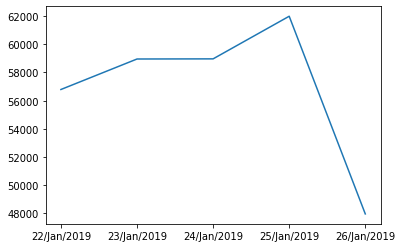

In [108]:
#(f)
plt.figure()
plt.plot(Dates,Count_hosts)
plt.show()

In [82]:
#(g)
tmp5 = final_df.select('Host','Code')
tmp6 = tmp5.filter(tmp5.Code.startswith('4') | tmp5.Code.startswith('5'))
error_hosts = tmp6.groupBy('Host').count().sort('count',ascending = False).limit(5)
print("Failed HTTP Clients:")
temp = error_hosts.collect()
for i in range(5):
    print(temp[i]['Host'])

Failed HTTP Clients:


104.222.32.91
66.249.66.194
151.239.241.163
91.99.47.57
91.99.30.32


In [123]:
#(h)
time = r'([0-9]{2}/[a-zA-Z]{3}/[0-9]{4}):([0-9]{2})'
jan22 = r'(22/Jan/2019)'
tmp8 = final_df.select('Code',regexp('Timestamp',time,1).alias('Date'),regexp('Timestamp',time,2).alias('Hour'))
tmp88 = tmp8.select('Code','Hour',regexp('Date',jan22,1).alias('Date'))
#print(tmp88.show(2))
tmp9 = tmp88.filter(tmp88.Code.startswith('4') | tmp88.Code.startswith('5'))
total_req = tmp8.groupBy('Hour').count().sort('Hour',ascending = True)
failed_req = tmp9.groupBy('Hour').count().sort('Hour',ascending = True)
temp1 = total_req.collect()
temp2 = failed_req.collect()
total_hours = []
total_count = []
failed_hours = []
failed_count = []
for i in range(len(temp1)):
    total_hours.append(temp1[i]['Hour'])
    total_count.append(temp1[i]['count'])
for i in range(len(temp2)):
    failed_hours.append(temp2[i]['Hour'])
    failed_count.append(temp2[i]['count'])

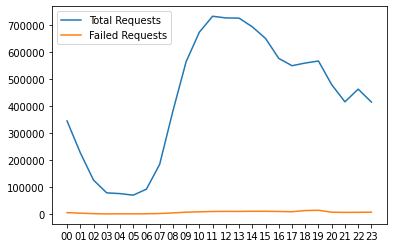

In [124]:

plt.figure()
plt.plot(total_hours,total_count,label='Total Requests')
plt.plot(failed_hours,failed_count,label='Failed Requests')
plt.legend()
plt.show()


In [128]:
#(i)
tmp10 = tmp8.select('Date','Hour').groupBy(['Hour','Date']).count()
tmp11 = tmp10.join(tmp10.groupBy('Date').agg(pyspark.sql.functions.max('count').alias('count')),on=['count','Date'])
temp = tmp11.collect()
print("Active Hours:")
print("day hour")
for i in range(len(temp)):
    print(temp[i]['Date'],temp[i]['Hour']+":00")

[Row(count=164407, Date='22/Jan/2019', Hour='11'), Row(count=169094, Date='23/Jan/2019', Hour='11'), Row(count=136330, Date='24/Jan/2019', Hour='11'), Row(count=124942, Date='25/Jan/2019', Hour='22'), Row(count=187021, Date='26/Jan/2019', Hour='13')]


Active Hours:
day hour
22/Jan/2019 11:00
23/Jan/2019 11:00
24/Jan/2019 11:00
25/Jan/2019 22:00
26/Jan/2019 13:00


In [132]:
#(j)
tmp7 = final_df.select('Length')
tmp11 = tmp7.withColumn('Length',tmp7.Length.cast('int'))
print("Response length statistics:")
print("Minimum length",tmp11.agg({'Length':'min'}).collect()[0][0])
print("Maximum length",tmp11.agg({'Length':'max'}).collect()[0][0])
print("Average length",tmp11.agg({'Length':'avg'}).collect()[0][0])

Response length statistics:


ERROR:root:KeyboardInterrupt while sending command.>                (0 + 0) / 1]
Traceback (most recent call last):
  File "/home/vigna/.local/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/vigna/.local/lib/python3.8/site-packages/py4j/clientserver.py", line 475, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 